<a href="https://www.kaggle.com/code/erikanderson1/gan-for-generating-art-in-the-style-of-monet?scriptVersionId=234541427" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CycleGAN | Photo to Monet
This notebook uses the CycleGAN generative adversarial network to stylize photos in the style of Monet as described in paper [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593).

Image-to-image translation tasks are easy for humans. Humans  have no trouble imagining the scene that Monet painted as a true landscape, or vice versa. However, for machines this task is more challenging. Often there are no labeled examples for which to train a model (for example, a photograph and the resulting landscape painting). CycleGAN proposes an adversarial network that trains a generator to fool a discriminator that is trying to detect generated images. Over time, the generator learns the appropriate style to achieve the image-to-image translation task.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import PIL
import shutil
from tqdm import tqdm
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

print(tf.__version__)

E0000 00:00:1744929130.026687      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


2.18.0


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    print("✅ TPU initialized")
except Exception as e:
    strategy = tf.distribute.get_strategy()  # fallback to CPU/GPU
    BATCH_SIZE = 1
    print("❌ TPU not found, using default strategy")
    print(f"Error: {e}")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1744929153.296648      74 service.cc:148] XLA service 0x57a30fca4ca0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744929153.296684      74 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1744929153.296688      74 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1744929153.296691      74 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8


I0000 00:00:1744929153.296694      74 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1744929153.296697      74 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1744929153.296700      74 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1744929153.296702      74 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1744929153.296705      74 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


✅ TPU initialized


## Exploratory Data Analysis
The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`, offering the same data in two formats: TFRecords and JPEG. For processing efficiency, I'll use the TFRecord files. The directories include
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [3]:
monet_tf_path = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
photo_tf_path = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'

monet_tf = tf.data.Dataset.list_files(monet_tf_path)
photo_tf = tf.data.Dataset.list_files(photo_tf_path)

print('Monet TFRecord Files: ', len(monet_tf))
print('Photo TFRecord Files: ', len(photo_tf))

Monet TFRecord Files:  5


Photo TFRecord Files:  20


## Data Preparation
Following the [TensorFlow CycleGAN tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan) and [CycleGAN paper](https://arxiv.org/abs/1703.10593) referenced therein, I'll load the datasets from TFRecords. For training data, I'll apply the tranformations to avoid overfitting including
- random jittering - image is resized to 286 x 286 and then randomly cropped to 256 x 256.
- random mirroring - image is randomly flipped horizontally i.e., left to right.

The data preparation code will be organized in my `ImagePreprocessor` class.

In [4]:
IMAGE_SIZE = [256, 256]

class ImagePreprocessor:
    def __init__(self, training=True):
        self.training = training

    def decode(self, image):
        img = tf.image.decode_jpeg(image, channels=3)
        return img

    def read_tfrecord(self, tfrecord):
        format_tf = {
            'image_name': tf.io.FixedLenFeature([], tf.string),
            'image': tf.io.FixedLenFeature([], tf.string),
            'target': tf.io.FixedLenFeature([], tf.string),
        }
        ex = tf.io.parse_single_example(tfrecord, format_tf)
        image = self.decode(ex['image'])
        return image

    def random_crop(self, image):
        return tf.image.random_crop(image, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])

    def normalize(self, image):
        image = tf.cast(image, tf.float32)
        return (image / 127.5) - 1

    def random_jitter(self, image):
        image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        image = self.random_crop(image)
        image = tf.image.random_flip_left_right(image)
        return image

    def preprocess_image_train(self, image):
        image = self.random_jitter(image)
        return self.normalize(image)

    def preprocess_image_test(self, image):
        return self.normalize(image)

    def preprocess_image(self, tfrecord):
        image = self.read_tfrecord(tfrecord)
        if self.training:
            return self.preprocess_image_train(image)
        else:
            return self.preprocess_image_test(image)

    def load_dataset(self, tf_files, batch_size=BATCH_SIZE, repeat=True):
        dataset = tf.data.TFRecordDataset(tf_files)
        dataset = dataset.map(lambda x: self.preprocess_image(x), num_parallel_calls=AUTOTUNE)
        if repeat:
            dataset = dataset.repeat()
        dataset = dataset.shuffle(1024)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(AUTOTUNE)
        return dataset


In [5]:
train_preprocessor = ImagePreprocessor(training=True)
test_preprocessor = ImagePreprocessor(training=False)

monet_ds = train_preprocessor.load_dataset(monet_tf)
photo_ds = train_preprocessor.load_dataset(photo_tf)
test_monet_ds = test_preprocessor.load_dataset(monet_tf, batch_size=1, repeat=False)
test_photo_ds = test_preprocessor.load_dataset(photo_tf, batch_size=1, repeat=False)

In [6]:
print("Monet Images: ", sum(1 for _ in tf.data.TFRecordDataset(monet_tf)))
print('Photo Images: ', sum(1 for _ in tf.data.TFRecordDataset(photo_tf)))

Monet Images:  300


Photo Images:  7038


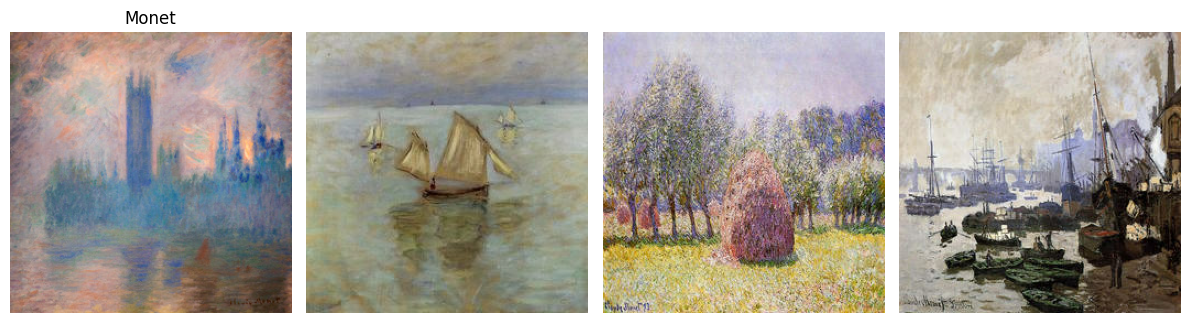

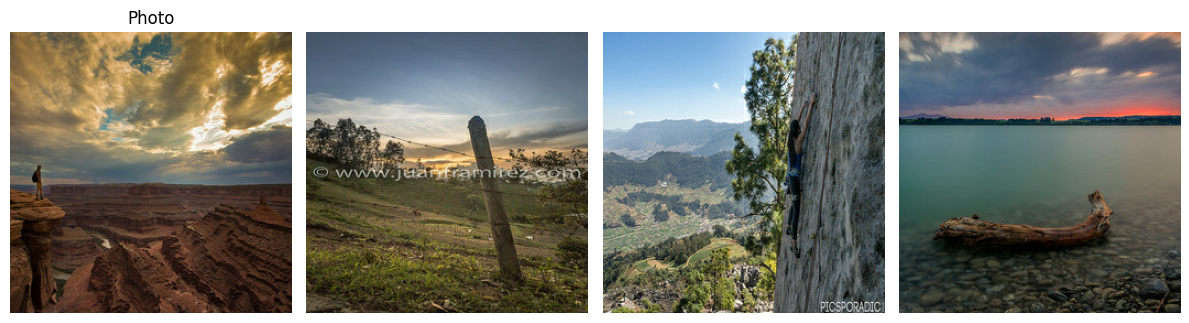

In [7]:
def show_img(ds, title):
    plt.figure(figsize=(12,6))
    for i, img in enumerate(ds.take(4)):
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title) if i == 0 else ''
    plt.tight_layout()
    plt.show()

show_img(test_monet_ds, 'Monet')
show_img(test_photo_ds, 'Photo')

## Model Architecture (Analysis Plan)
CycleGAN is an adversarial approach to translating an image from one domain (e.g., a photo) to another domain (e.g., the painting style of Monet). As described in paper [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593) the algorithm learns a mapping $G: X \to Y$ (i.e., from photos to Monet) with an inverse mapping $F: Y \to X$ (i.e., from Monet to photos) under the constraint $F(G(X)) \approx X$ such that cycling an image through will translate from one domain back to its own domain. This is akin to what humans do when imagining the actual landscape that Monet painted, or the way Monet might paint a landscape.

The algorithm is trained by training both the mapping G and F simultaneously, and adding a cycle consistency loss, where a descriminator learns to distinguish real from generated examples in each domain. The process is shown below

![img](https://www.tensorflow.org/static/tutorials/generative/images/cycle_loss.png)

The CycleGAN paper uses a modified resnet based generator. I instead implement a modified unet generator for simplicity. Inspiration for implementation provided by Amy Jang's implementation in the [CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) notebook.

### Generator
The generator first downsamples the image by striding across the image with stride=2 such that the width and height are reduced by half with each pass. Upsampling does the opposite. The idea is to create the stepped architecture such that the image is encoded to the latent space coding and then decoded in the new domain (learned through interaction with the discriminator). Instance normalization is applied for model stability and consistent style across imagesl dropout is applied for improved model generalization.  Skip connections bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one.

In [8]:
OUTPUT_CHANNELS = 3

class Generator:
        
    def downsample(self, filters, size, apply_instancenorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))
    
        if apply_instancenorm:
            result.add(layers.GroupNormalization(1)) # instance normalization 
    
        result.add(layers.LeakyReLU())
    
        return result

    def upsample(self, filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        result.add(layers.GroupNormalization(1)) # instance normalization 
    
        if apply_dropout:
            result.add(layers.Dropout(0.5))
    
        result.add(layers.ReLU())
    
        return result

    def build(self):
        inputs = layers.Input(shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])

        # bs = batch size
        down_stack = [
            self.downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
            self.downsample(128, 4), # (bs, 64, 64, 128)
            self.downsample(256, 4), # (bs, 32, 32, 256)
            self.downsample(512, 4), # (bs, 16, 16, 512)
            self.downsample(512, 4), # (bs, 8, 8, 512)
            self.downsample(512, 4), # (bs, 4, 4, 512)
            self.downsample(512, 4), # (bs, 2, 2, 512)
            self.downsample(512, 4), # (bs, 1, 1, 512)
        ]
    
        up_stack = [
            self.upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
            self.upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
            self.upsample(512, 4), # (bs, 16, 16, 1024)
            self.upsample(256, 4), # (bs, 32, 32, 512)
            self.upsample(128, 4), # (bs, 64, 64, 256)
            self.upsample(64, 4), # (bs, 128, 128, 128)
        ]
    
        initializer = tf.random_normal_initializer(0., 0.02)
        last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh') # (bs, 256, 256, 3)
    
        x = inputs
    
        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)
    
        skips = reversed(skips[:-1])
    
        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = layers.Concatenate()([x, skip])
    
        x = last(x)
    
        return keras.Model(inputs=inputs, outputs=x, name='generator')

### Discriminator
The discriminator learns to distinguish the difference between real and generated images. In this implementation, instead of a binary prediction of "Real" or "Fake", the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [9]:
class Discriminator:

    def downsample(self, filters, size, apply_instancenorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))
    
        if apply_instancenorm:
            result.add(layers.GroupNormalization(1)) # instance normalization 
    
        result.add(layers.LeakyReLU())
    
        return result

    def build(self):    
        inp = layers.Input(shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3], name='input_image')
        x = inp
    
        ds_stack = [
            self.downsample(64, 4, apply_instancenorm=False), # batch, 128, 128, 64
            self.downsample(128, 4), # batch, 64, 64, 128
            self.downsample(256, 4), # batch, 32, 32, 256
        ]
    
        for ds in ds_stack:
            x = ds(x)
        
        result = keras.Sequential([
            layers.Conv2D(512, 4, strides=1, padding='same'), # batch, 32, 32, 512
            layers.GroupNormalization(1), # instance normalization
            layers.LeakyReLU(),
            layers.Conv2D(1, 4, strides=1, padding='same'), # batch, 32, 32, 1 <-- our patch map (Real/Fake)
        ])
    
        x = result(x)
    
        return tf.keras.Model(inputs=inp, outputs=x, name='discriminator')

Now I'll build the Generator and Discriminator. `strategy.scope()` ensures TPU can be used if available.

In [10]:
with strategy.scope():
    monet_generator = Generator().build()
    photo_generator = Generator().build()

    monet_discriminator = Discriminator().build()
    photo_discriminator = Discriminator().build()

I0000 00:00:1744929163.400344      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [11]:
monet_generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,328 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    524,800 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,098,176 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,195,328 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,195,328 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,195,328 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,195,328 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,195,328 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,389,632 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,389,632 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,389,632 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
monet_discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_33 (Sequential)      │ (None, 32, 32, 1)      │     2,106,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,081 (10.55 MB)

 Trainable params: 2,766,081 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

### CycleGAN Model
Subclassing a `keras` model, I'll build the custom CycleGAN model.

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = (
                self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + 
                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            )

            # evaluates total generator loss
            total_monet_gen_loss = (
                monet_gen_loss + 
                total_cycle_loss + 
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            )
            total_photo_gen_loss = (
                photo_gen_loss + 
                total_cycle_loss + 
                self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            )

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

    def call(self, inputs, training=False):
        # Provide a simple forward pass — used for model.build()
        return self.m_gen(inputs, training=training)


#### Loss Function
The authors propose cycle consistency loss as the loss function for updating weights in the model. This simply means that when translating from one domain to another and back again, the output should be similar to the input $F(G(X) \approx X$ and $G(F(Y)) \approx Y$.

Recall the loss will be pixel-by-pixel rather than binary. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss. Meanwhile, the generator is trying to fool the discriminator into returning all 1s for a generated image. Cycle consistency loss averages the difference between the real and cycled image (e.g., $X \to Y \to X$). Identity loss compares the photo created by its own generator with itself, ideally these should be equivalent (all 1s).

In [14]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### Model training
The authors of the CycleGAN paper use the Adam optimizer with learning rate of `2e-4`, so I will follow suit to fit the model.

In [15]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    cycle_gan_model = CycleGan(
        monet_generator, 
        photo_generator, 
        monet_discriminator, 
        photo_discriminator
    )
    
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [16]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=200,
    steps_per_epoch=300 // BATCH_SIZE
)

Epoch 1/200


I0000 00:00:1744929240.721746      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9656413054668708596


I0000 00:00:1744929246.843483     803 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(10371180232949301951), session_name()


I0000 00:00:1744929303.606466     803 tpu_compile_op_common.cc:245] Compilation of 10371180232949301951 with session name  took 56.762930136s and succeeded


I0000 00:00:1744929303.774260     803 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(10371180232949301951), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_9656413054668708596", property.function_library_fingerprint = 5332979053941902925, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1744929303.774307     803 tpu_compilation_cache_interface.cc:542] After adding entry for key 10371180232949301951 with session_name  cache is 1 entries (342846804 bytes),  marked for eviction 0 entries (0 bytes).


1/2 ━━━━━━━━━━━━━━━━━━━━ 2:03 123s/step - monet_disc_loss: 0.7662 - monet_gen_loss: 11.9479 - photo_disc_loss: 0.6789 - photo_gen_loss: 13.0140

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - monet_disc_loss: 0.5611 - monet_gen_loss: 14.1628 - photo_disc_loss: 0.3810 - photo_gen_loss: 14.4415 

2/2 ━━━━━━━━━━━━━━━━━━━━ 123s 283ms/step - monet_disc_loss: 0.4928 - monet_gen_loss: 14.9011 - photo_disc_loss: 0.2817 - photo_gen_loss: 14.9174


Epoch 2/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 3.0887 - monet_gen_loss: 10.7139 - photo_disc_loss: 1.6293 - photo_gen_loss: 11.2053

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 1.5736 - monet_gen_loss: 12.6795 - photo_disc_loss: 0.9375 - photo_gen_loss: 15.5034

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 1.0685 - monet_gen_loss: 13.3347 - photo_disc_loss: 0.7070 - photo_gen_loss: 16.9362


Epoch 3/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.1300 - monet_gen_loss: 13.6047 - photo_disc_loss: 0.1181 - photo_gen_loss: 18.2513

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - monet_disc_loss: 0.4630 - monet_gen_loss: 12.4531 - photo_disc_loss: 0.2270 - photo_gen_loss: 15.3320

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - monet_disc_loss: 0.5740 - monet_gen_loss: 12.0693 - photo_disc_loss: 0.2633 - photo_gen_loss: 14.3589


Epoch 4/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 1.0181 - monet_gen_loss: 15.4889 - photo_disc_loss: 0.0941 - photo_gen_loss: 13.7179

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - monet_disc_loss: 1.5013 - monet_gen_loss: 12.7826 - photo_disc_loss: 0.7272 - photo_gen_loss: 12.2719

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - monet_disc_loss: 1.6624 - monet_gen_loss: 11.8805 - photo_disc_loss: 0.9382 - photo_gen_loss: 11.7899


Epoch 5/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - monet_disc_loss: 0.4539 - monet_gen_loss: 14.4671 - photo_disc_loss: 1.9411 - photo_gen_loss: 16.2746

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.3592 - monet_gen_loss: 13.1248 - photo_disc_loss: 1.1964 - photo_gen_loss: 13.4266

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.3276 - monet_gen_loss: 12.6773 - photo_disc_loss: 0.9482 - photo_gen_loss: 12.4772


Epoch 6/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - monet_disc_loss: 1.0936 - monet_gen_loss: 9.8088 - photo_disc_loss: 0.7505 - photo_gen_loss: 11.8237

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - monet_disc_loss: 0.7871 - monet_gen_loss: 11.1507 - photo_disc_loss: 0.5599 - photo_gen_loss: 11.6933

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - monet_disc_loss: 0.6849 - monet_gen_loss: 11.5980 - photo_disc_loss: 0.4963 - photo_gen_loss: 11.6499


Epoch 7/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - monet_disc_loss: 0.3329 - monet_gen_loss: 10.6029 - photo_disc_loss: 0.9203 - photo_gen_loss: 9.1740

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 1.1389 - monet_gen_loss: 9.5538 - photo_disc_loss: 0.7944 - photo_gen_loss: 11.4796

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 1.4076 - monet_gen_loss: 9.2041 - photo_disc_loss: 0.7524 - photo_gen_loss: 12.2481


Epoch 8/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.8338 - monet_gen_loss: 9.9564 - photo_disc_loss: 0.8356 - photo_gen_loss: 10.4769

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.9973 - monet_gen_loss: 9.0501 - photo_disc_loss: 0.5676 - photo_gen_loss: 10.0317

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 1.0517 - monet_gen_loss: 8.7480 - photo_disc_loss: 0.4783 - photo_gen_loss: 9.8833 


Epoch 9/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - monet_disc_loss: 0.9163 - monet_gen_loss: 7.8545 - photo_disc_loss: 1.3082 - photo_gen_loss: 8.2639

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - monet_disc_loss: 0.8007 - monet_gen_loss: 8.6114 - photo_disc_loss: 0.9920 - photo_gen_loss: 8.3977

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - monet_disc_loss: 0.7621 - monet_gen_loss: 8.8638 - photo_disc_loss: 0.8866 - photo_gen_loss: 8.4423


Epoch 10/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - monet_disc_loss: 1.0813 - monet_gen_loss: 7.3696 - photo_disc_loss: 0.8815 - photo_gen_loss: 8.0632

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - monet_disc_loss: 0.8634 - monet_gen_loss: 7.4823 - photo_disc_loss: 1.0248 - photo_gen_loss: 7.9628

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - monet_disc_loss: 0.7907 - monet_gen_loss: 7.5198 - photo_disc_loss: 1.0725 - photo_gen_loss: 7.9294


Epoch 11/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.7019 - monet_gen_loss: 9.0111 - photo_disc_loss: 1.1643 - photo_gen_loss: 7.7718

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.8099 - monet_gen_loss: 8.1539 - photo_disc_loss: 0.9575 - photo_gen_loss: 8.2398

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.8459 - monet_gen_loss: 7.8681 - photo_disc_loss: 0.8885 - photo_gen_loss: 8.3958


Epoch 12/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.7102 - monet_gen_loss: 7.5750 - photo_disc_loss: 0.6244 - photo_gen_loss: 7.3892

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.8992 - monet_gen_loss: 7.2280 - photo_disc_loss: 0.5997 - photo_gen_loss: 7.3366

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.9623 - monet_gen_loss: 7.1123 - photo_disc_loss: 0.5914 - photo_gen_loss: 7.3191


Epoch 13/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - monet_disc_loss: 1.0034 - monet_gen_loss: 7.2847 - photo_disc_loss: 0.5320 - photo_gen_loss: 7.9715

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 1.0646 - monet_gen_loss: 7.1614 - photo_disc_loss: 0.5521 - photo_gen_loss: 7.6528

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 1.0851 - monet_gen_loss: 7.1203 - photo_disc_loss: 0.5588 - photo_gen_loss: 7.5466


Epoch 14/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.9339 - monet_gen_loss: 6.8615 - photo_disc_loss: 0.5891 - photo_gen_loss: 7.2072

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - monet_disc_loss: 0.8822 - monet_gen_loss: 6.9769 - photo_disc_loss: 0.6649 - photo_gen_loss: 7.1912

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - monet_disc_loss: 0.8650 - monet_gen_loss: 7.0153 - photo_disc_loss: 0.6901 - photo_gen_loss: 7.1859


Epoch 15/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6699 - monet_gen_loss: 6.6353 - photo_disc_loss: 0.7923 - photo_gen_loss: 6.7357

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - monet_disc_loss: 0.6634 - monet_gen_loss: 6.9543 - photo_disc_loss: 0.8318 - photo_gen_loss: 6.9758

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - monet_disc_loss: 0.6612 - monet_gen_loss: 7.0606 - photo_disc_loss: 0.8450 - photo_gen_loss: 7.0559


Epoch 16/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 6.6281 - photo_disc_loss: 0.9242 - photo_gen_loss: 8.2184

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 6.7354 - photo_disc_loss: 0.9875 - photo_gen_loss: 7.5429

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - monet_disc_loss: 0.5998 - monet_gen_loss: 6.7712 - photo_disc_loss: 1.0086 - photo_gen_loss: 7.3177


Epoch 17/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 6.5874 - photo_disc_loss: 0.8875 - photo_gen_loss: 7.3797

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - monet_disc_loss: 0.6881 - monet_gen_loss: 6.6059 - photo_disc_loss: 0.8673 - photo_gen_loss: 6.8747

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - monet_disc_loss: 0.7101 - monet_gen_loss: 6.6120 - photo_disc_loss: 0.8605 - photo_gen_loss: 6.7064


Epoch 18/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.7015 - monet_gen_loss: 6.3087 - photo_disc_loss: 0.8803 - photo_gen_loss: 6.3564

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - monet_disc_loss: 0.7061 - monet_gen_loss: 6.3968 - photo_disc_loss: 0.7734 - photo_gen_loss: 6.6518

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - monet_disc_loss: 0.7076 - monet_gen_loss: 6.4261 - photo_disc_loss: 0.7378 - photo_gen_loss: 6.7503


Epoch 19/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - monet_disc_loss: 0.7365 - monet_gen_loss: 6.7037 - photo_disc_loss: 0.6368 - photo_gen_loss: 7.0797

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.7484 - monet_gen_loss: 6.5770 - photo_disc_loss: 0.6417 - photo_gen_loss: 6.8441

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.7524 - monet_gen_loss: 6.5348 - photo_disc_loss: 0.6433 - photo_gen_loss: 6.7656


Epoch 20/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.7611 - monet_gen_loss: 6.4640 - photo_disc_loss: 0.6119 - photo_gen_loss: 6.5970

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - monet_disc_loss: 0.7487 - monet_gen_loss: 6.5278 - photo_disc_loss: 0.6159 - photo_gen_loss: 6.6548

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - monet_disc_loss: 0.7445 - monet_gen_loss: 6.5491 - photo_disc_loss: 0.6173 - photo_gen_loss: 6.6740


Epoch 21/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - monet_disc_loss: 0.7368 - monet_gen_loss: 6.2755 - photo_disc_loss: 0.6556 - photo_gen_loss: 6.4279

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.7369 - monet_gen_loss: 6.4073 - photo_disc_loss: 0.6628 - photo_gen_loss: 6.5024

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.7369 - monet_gen_loss: 6.4513 - photo_disc_loss: 0.6652 - photo_gen_loss: 6.5273


Epoch 22/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.7404 - monet_gen_loss: 6.1674 - photo_disc_loss: 0.6833 - photo_gen_loss: 6.2159

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.7141 - monet_gen_loss: 6.4667 - photo_disc_loss: 0.7018 - photo_gen_loss: 6.5485

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.7053 - monet_gen_loss: 6.5665 - photo_disc_loss: 0.7080 - photo_gen_loss: 6.6594


Epoch 23/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6977 - monet_gen_loss: 5.8321 - photo_disc_loss: 0.7307 - photo_gen_loss: 5.8541

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6592 - monet_gen_loss: 6.0474 - photo_disc_loss: 0.7131 - photo_gen_loss: 6.1241

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6463 - monet_gen_loss: 6.1191 - photo_disc_loss: 0.7072 - photo_gen_loss: 6.2140


Epoch 24/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6728 - monet_gen_loss: 6.5915 - photo_disc_loss: 0.7288 - photo_gen_loss: 6.6244

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6499 - monet_gen_loss: 6.3072 - photo_disc_loss: 0.6910 - photo_gen_loss: 6.2943

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6422 - monet_gen_loss: 6.2125 - photo_disc_loss: 0.6784 - photo_gen_loss: 6.1842


Epoch 25/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5329 - monet_gen_loss: 6.4169 - photo_disc_loss: 0.6707 - photo_gen_loss: 6.4140

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5979 - monet_gen_loss: 6.2007 - photo_disc_loss: 0.6354 - photo_gen_loss: 6.1754

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 6.1286 - photo_disc_loss: 0.6236 - photo_gen_loss: 6.0959


Epoch 26/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6468 - monet_gen_loss: 5.8377 - photo_disc_loss: 0.6662 - photo_gen_loss: 6.0704

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 6.1920 - photo_disc_loss: 0.6401 - photo_gen_loss: 6.4548

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 6.3101 - photo_disc_loss: 0.6314 - photo_gen_loss: 6.5829


Epoch 27/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6524 - monet_gen_loss: 6.3695 - photo_disc_loss: 0.6081 - photo_gen_loss: 6.4495

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6502 - monet_gen_loss: 6.3166 - photo_disc_loss: 0.6333 - photo_gen_loss: 6.4034

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6495 - monet_gen_loss: 6.2989 - photo_disc_loss: 0.6417 - photo_gen_loss: 6.3881


Epoch 28/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.6493 - monet_gen_loss: 5.9483 - photo_disc_loss: 0.6808 - photo_gen_loss: 6.0563

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - monet_disc_loss: 0.6295 - monet_gen_loss: 6.1693 - photo_disc_loss: 0.6208 - photo_gen_loss: 6.2639

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 6.2429 - photo_disc_loss: 0.6008 - photo_gen_loss: 6.3332


Epoch 29/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6295 - monet_gen_loss: 6.1538 - photo_disc_loss: 0.5545 - photo_gen_loss: 6.3556

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 6.0873 - photo_disc_loss: 0.5613 - photo_gen_loss: 6.2614

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 6.0651 - photo_disc_loss: 0.5636 - photo_gen_loss: 6.2300


Epoch 30/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6362 - monet_gen_loss: 6.0921 - photo_disc_loss: 0.6176 - photo_gen_loss: 6.4498

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6332 - monet_gen_loss: 6.1485 - photo_disc_loss: 0.6014 - photo_gen_loss: 6.3475

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6322 - monet_gen_loss: 6.1673 - photo_disc_loss: 0.5960 - photo_gen_loss: 6.3134


Epoch 31/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 6.4438 - photo_disc_loss: 0.5793 - photo_gen_loss: 6.2128

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6275 - monet_gen_loss: 6.3718 - photo_disc_loss: 0.5763 - photo_gen_loss: 6.3482

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6338 - monet_gen_loss: 6.3477 - photo_disc_loss: 0.5753 - photo_gen_loss: 6.3933


Epoch 32/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5390 - monet_gen_loss: 5.7713 - photo_disc_loss: 0.5558 - photo_gen_loss: 5.8298

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5622 - monet_gen_loss: 5.8399 - photo_disc_loss: 0.5558 - photo_gen_loss: 5.9785

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.5700 - monet_gen_loss: 5.8628 - photo_disc_loss: 0.5558 - photo_gen_loss: 6.0281


Epoch 33/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 6.0694 - photo_disc_loss: 0.5623 - photo_gen_loss: 5.9817

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 5.9597 - photo_disc_loss: 0.5383 - photo_gen_loss: 6.0567

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 5.9231 - photo_disc_loss: 0.5303 - photo_gen_loss: 6.0817


Epoch 34/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - monet_disc_loss: 0.6527 - monet_gen_loss: 5.8167 - photo_disc_loss: 0.5336 - photo_gen_loss: 5.8792

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.5954 - monet_gen_loss: 5.9143 - photo_disc_loss: 0.5838 - photo_gen_loss: 5.9005

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.5762 - monet_gen_loss: 5.9468 - photo_disc_loss: 0.6006 - photo_gen_loss: 5.9076


Epoch 35/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6685 - monet_gen_loss: 5.8648 - photo_disc_loss: 0.7189 - photo_gen_loss: 6.0392

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - monet_disc_loss: 0.6709 - monet_gen_loss: 5.7803 - photo_disc_loss: 0.7024 - photo_gen_loss: 5.8645

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - monet_disc_loss: 0.6717 - monet_gen_loss: 5.7522 - photo_disc_loss: 0.6969 - photo_gen_loss: 5.8063


Epoch 36/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.7160 - monet_gen_loss: 5.4104 - photo_disc_loss: 0.6991 - photo_gen_loss: 5.6660

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6959 - monet_gen_loss: 5.5664 - photo_disc_loss: 0.6581 - photo_gen_loss: 5.8126

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6892 - monet_gen_loss: 5.6183 - photo_disc_loss: 0.6445 - photo_gen_loss: 5.8615


Epoch 37/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6408 - monet_gen_loss: 5.6514 - photo_disc_loss: 0.7177 - photo_gen_loss: 5.9200

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - monet_disc_loss: 0.6521 - monet_gen_loss: 5.3242 - photo_disc_loss: 0.7287 - photo_gen_loss: 5.4243

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - monet_disc_loss: 0.6558 - monet_gen_loss: 5.2151 - photo_disc_loss: 0.7324 - photo_gen_loss: 5.2591


Epoch 38/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 5.4308 - photo_disc_loss: 0.6533 - photo_gen_loss: 5.5092

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6713 - monet_gen_loss: 5.2965 - photo_disc_loss: 0.7202 - photo_gen_loss: 5.4808

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6900 - monet_gen_loss: 5.2518 - photo_disc_loss: 0.7425 - photo_gen_loss: 5.4713


Epoch 39/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6551 - monet_gen_loss: 4.8314 - photo_disc_loss: 0.6797 - photo_gen_loss: 5.1873

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.7573 - monet_gen_loss: 5.0322 - photo_disc_loss: 0.7413 - photo_gen_loss: 5.2640

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.7913 - monet_gen_loss: 5.0992 - photo_disc_loss: 0.7618 - photo_gen_loss: 5.2896


Epoch 40/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.8175 - monet_gen_loss: 5.5931 - photo_disc_loss: 0.7537 - photo_gen_loss: 5.5597

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.7314 - monet_gen_loss: 5.3176 - photo_disc_loss: 0.7391 - photo_gen_loss: 5.3458

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.7027 - monet_gen_loss: 5.2258 - photo_disc_loss: 0.7342 - photo_gen_loss: 5.2745


Epoch 41/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.7708 - monet_gen_loss: 5.2315 - photo_disc_loss: 0.8053 - photo_gen_loss: 5.3861

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.7081 - monet_gen_loss: 5.1950 - photo_disc_loss: 0.7464 - photo_gen_loss: 5.3992

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - monet_disc_loss: 0.6872 - monet_gen_loss: 5.1828 - photo_disc_loss: 0.7268 - photo_gen_loss: 5.4036


Epoch 42/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6908 - monet_gen_loss: 4.6336 - photo_disc_loss: 0.7222 - photo_gen_loss: 4.5614

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.6811 - monet_gen_loss: 4.8077 - photo_disc_loss: 0.7076 - photo_gen_loss: 4.7011

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6779 - monet_gen_loss: 4.8657 - photo_disc_loss: 0.7028 - photo_gen_loss: 4.7477


Epoch 43/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - monet_disc_loss: 0.6348 - monet_gen_loss: 4.8941 - photo_disc_loss: 0.6543 - photo_gen_loss: 5.0470

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 4.9044 - photo_disc_loss: 0.6457 - photo_gen_loss: 4.8983

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 4.9078 - photo_disc_loss: 0.6428 - photo_gen_loss: 4.8488


Epoch 44/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6977 - monet_gen_loss: 4.7546 - photo_disc_loss: 0.6983 - photo_gen_loss: 4.7615

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6585 - monet_gen_loss: 4.8473 - photo_disc_loss: 0.6701 - photo_gen_loss: 4.8894

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6455 - monet_gen_loss: 4.8782 - photo_disc_loss: 0.6607 - photo_gen_loss: 4.9320


Epoch 45/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.5848 - monet_gen_loss: 4.4414 - photo_disc_loss: 0.6121 - photo_gen_loss: 4.4433

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 4.4789 - photo_disc_loss: 0.6351 - photo_gen_loss: 4.5150

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.6307 - monet_gen_loss: 4.4915 - photo_disc_loss: 0.6428 - photo_gen_loss: 4.5389


Epoch 46/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6759 - monet_gen_loss: 4.2696 - photo_disc_loss: 0.6769 - photo_gen_loss: 4.4621

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.6755 - monet_gen_loss: 4.5708 - photo_disc_loss: 0.6933 - photo_gen_loss: 4.6307

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6754 - monet_gen_loss: 4.6713 - photo_disc_loss: 0.6988 - photo_gen_loss: 4.6869


Epoch 47/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - monet_disc_loss: 0.5615 - monet_gen_loss: 4.5625 - photo_disc_loss: 0.5925 - photo_gen_loss: 4.6357

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5931 - monet_gen_loss: 4.5008 - photo_disc_loss: 0.6112 - photo_gen_loss: 4.5287

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 4.4803 - photo_disc_loss: 0.6175 - photo_gen_loss: 4.4930


Epoch 48/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6817 - monet_gen_loss: 4.6169 - photo_disc_loss: 0.7066 - photo_gen_loss: 4.5768

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6744 - monet_gen_loss: 4.5425 - photo_disc_loss: 0.7010 - photo_gen_loss: 4.5294

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6719 - monet_gen_loss: 4.5177 - photo_disc_loss: 0.6991 - photo_gen_loss: 4.5136


Epoch 49/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6022 - monet_gen_loss: 4.5908 - photo_disc_loss: 0.6504 - photo_gen_loss: 4.7316

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 4.6441 - photo_disc_loss: 0.6422 - photo_gen_loss: 4.8435

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 4.6619 - photo_disc_loss: 0.6395 - photo_gen_loss: 4.8809


Epoch 50/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6493 - monet_gen_loss: 4.5120 - photo_disc_loss: 0.6533 - photo_gen_loss: 4.2900

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6786 - monet_gen_loss: 4.6008 - photo_disc_loss: 0.6761 - photo_gen_loss: 4.4891

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6883 - monet_gen_loss: 4.6305 - photo_disc_loss: 0.6837 - photo_gen_loss: 4.5554


Epoch 51/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.7312 - monet_gen_loss: 4.1969 - photo_disc_loss: 0.7333 - photo_gen_loss: 4.3155

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6678 - monet_gen_loss: 4.4159 - photo_disc_loss: 0.6782 - photo_gen_loss: 4.4328

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6467 - monet_gen_loss: 4.4889 - photo_disc_loss: 0.6598 - photo_gen_loss: 4.4719


Epoch 52/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.7349 - monet_gen_loss: 4.3805 - photo_disc_loss: 0.7234 - photo_gen_loss: 4.2938

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6484 - monet_gen_loss: 4.5315 - photo_disc_loss: 0.6573 - photo_gen_loss: 4.5674

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 4.5818 - photo_disc_loss: 0.6352 - photo_gen_loss: 4.6585


Epoch 53/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.7350 - monet_gen_loss: 4.2781 - photo_disc_loss: 0.7322 - photo_gen_loss: 4.2491

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6897 - monet_gen_loss: 4.3971 - photo_disc_loss: 0.6955 - photo_gen_loss: 4.4837

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6745 - monet_gen_loss: 4.4367 - photo_disc_loss: 0.6833 - photo_gen_loss: 4.5619


Epoch 54/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.5997 - monet_gen_loss: 4.4454 - photo_disc_loss: 0.6266 - photo_gen_loss: 4.2079

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 4.4993 - photo_disc_loss: 0.6160 - photo_gen_loss: 4.3871

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 4.5172 - photo_disc_loss: 0.6125 - photo_gen_loss: 4.4469


Epoch 55/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6698 - monet_gen_loss: 4.4296 - photo_disc_loss: 0.7025 - photo_gen_loss: 4.6079

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6739 - monet_gen_loss: 4.3688 - photo_disc_loss: 0.6942 - photo_gen_loss: 4.5525

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6753 - monet_gen_loss: 4.3485 - photo_disc_loss: 0.6914 - photo_gen_loss: 4.5340


Epoch 56/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.6362 - monet_gen_loss: 4.6753 - photo_disc_loss: 0.6809 - photo_gen_loss: 4.6986

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - monet_disc_loss: 0.6427 - monet_gen_loss: 4.6293 - photo_disc_loss: 0.6697 - photo_gen_loss: 4.6703

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - monet_disc_loss: 0.6449 - monet_gen_loss: 4.6139 - photo_disc_loss: 0.6660 - photo_gen_loss: 4.6609


Epoch 57/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6341 - monet_gen_loss: 4.1001 - photo_disc_loss: 0.6435 - photo_gen_loss: 4.2832

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 4.2039 - photo_disc_loss: 0.6393 - photo_gen_loss: 4.2178

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 4.2384 - photo_disc_loss: 0.6380 - photo_gen_loss: 4.1959


Epoch 58/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 4.2936 - photo_disc_loss: 0.6305 - photo_gen_loss: 4.4285

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6318 - monet_gen_loss: 4.2263 - photo_disc_loss: 0.6514 - photo_gen_loss: 4.4048

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6379 - monet_gen_loss: 4.2039 - photo_disc_loss: 0.6583 - photo_gen_loss: 4.3969


Epoch 59/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.5939 - monet_gen_loss: 4.6653 - photo_disc_loss: 0.6110 - photo_gen_loss: 4.2532

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.7095 - monet_gen_loss: 4.4330 - photo_disc_loss: 0.7116 - photo_gen_loss: 4.2425

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.7480 - monet_gen_loss: 4.3556 - photo_disc_loss: 0.7452 - photo_gen_loss: 4.2389


Epoch 60/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 4.3803 - photo_disc_loss: 0.6220 - photo_gen_loss: 4.4901

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 4.3530 - photo_disc_loss: 0.6205 - photo_gen_loss: 4.5081

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 4.3439 - photo_disc_loss: 0.6200 - photo_gen_loss: 4.5141


Epoch 61/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.5916 - monet_gen_loss: 3.9177 - photo_disc_loss: 0.6550 - photo_gen_loss: 4.2399

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 4.0148 - photo_disc_loss: 0.6429 - photo_gen_loss: 4.1905

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 4.0472 - photo_disc_loss: 0.6389 - photo_gen_loss: 4.1741


Epoch 62/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5670 - monet_gen_loss: 4.7056 - photo_disc_loss: 0.6095 - photo_gen_loss: 4.4829

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5572 - monet_gen_loss: 4.4290 - photo_disc_loss: 0.5972 - photo_gen_loss: 4.3580

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.5539 - monet_gen_loss: 4.3368 - photo_disc_loss: 0.5931 - photo_gen_loss: 4.3163


Epoch 63/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6381 - monet_gen_loss: 4.3427 - photo_disc_loss: 0.6483 - photo_gen_loss: 4.2900

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6477 - monet_gen_loss: 4.5252 - photo_disc_loss: 0.6639 - photo_gen_loss: 4.5597

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6510 - monet_gen_loss: 4.5861 - photo_disc_loss: 0.6691 - photo_gen_loss: 4.6496


Epoch 64/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6008 - monet_gen_loss: 4.1364 - photo_disc_loss: 0.6390 - photo_gen_loss: 4.3174

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 4.2600 - photo_disc_loss: 0.6314 - photo_gen_loss: 4.3487

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 4.3012 - photo_disc_loss: 0.6288 - photo_gen_loss: 4.3591


Epoch 65/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6820 - monet_gen_loss: 4.4359 - photo_disc_loss: 0.6824 - photo_gen_loss: 4.1704

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6677 - monet_gen_loss: 4.3486 - photo_disc_loss: 0.6777 - photo_gen_loss: 4.2025

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6630 - monet_gen_loss: 4.3195 - photo_disc_loss: 0.6761 - photo_gen_loss: 4.2132


Epoch 66/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 4.2926 - photo_disc_loss: 0.6477 - photo_gen_loss: 4.2362

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6341 - monet_gen_loss: 4.3651 - photo_disc_loss: 0.6679 - photo_gen_loss: 4.1542

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6414 - monet_gen_loss: 4.3893 - photo_disc_loss: 0.6747 - photo_gen_loss: 4.1269


Epoch 67/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6833 - monet_gen_loss: 3.9407 - photo_disc_loss: 0.7031 - photo_gen_loss: 4.1311

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.6857 - monet_gen_loss: 4.1509 - photo_disc_loss: 0.6941 - photo_gen_loss: 4.2616

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6866 - monet_gen_loss: 4.2209 - photo_disc_loss: 0.6911 - photo_gen_loss: 4.3051


Epoch 68/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6468 - monet_gen_loss: 4.3191 - photo_disc_loss: 0.6650 - photo_gen_loss: 4.3353

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6485 - monet_gen_loss: 4.1763 - photo_disc_loss: 0.6737 - photo_gen_loss: 4.0730

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6490 - monet_gen_loss: 4.1287 - photo_disc_loss: 0.6766 - photo_gen_loss: 3.9856


Epoch 69/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.5801 - monet_gen_loss: 4.0450 - photo_disc_loss: 0.6147 - photo_gen_loss: 4.1550

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - monet_disc_loss: 0.5930 - monet_gen_loss: 4.3662 - photo_disc_loss: 0.6340 - photo_gen_loss: 4.2977

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - monet_disc_loss: 0.5974 - monet_gen_loss: 4.4733 - photo_disc_loss: 0.6405 - photo_gen_loss: 4.3453


Epoch 70/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6814 - monet_gen_loss: 4.5231 - photo_disc_loss: 0.6732 - photo_gen_loss: 4.3390

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6634 - monet_gen_loss: 4.3563 - photo_disc_loss: 0.6924 - photo_gen_loss: 4.1847

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6574 - monet_gen_loss: 4.3008 - photo_disc_loss: 0.6989 - photo_gen_loss: 4.1333


Epoch 71/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.7084 - monet_gen_loss: 4.1106 - photo_disc_loss: 0.7248 - photo_gen_loss: 4.1500

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6397 - monet_gen_loss: 4.2589 - photo_disc_loss: 0.6755 - photo_gen_loss: 4.2504

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 4.3083 - photo_disc_loss: 0.6591 - photo_gen_loss: 4.2838


Epoch 72/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 4.3782 - photo_disc_loss: 0.6535 - photo_gen_loss: 4.2517

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6446 - monet_gen_loss: 4.2965 - photo_disc_loss: 0.6698 - photo_gen_loss: 4.1752

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6522 - monet_gen_loss: 4.2692 - photo_disc_loss: 0.6752 - photo_gen_loss: 4.1497


Epoch 73/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6414 - monet_gen_loss: 4.3594 - photo_disc_loss: 0.6431 - photo_gen_loss: 4.1908

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6579 - monet_gen_loss: 4.3493 - photo_disc_loss: 0.6662 - photo_gen_loss: 4.1615

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6635 - monet_gen_loss: 4.3460 - photo_disc_loss: 0.6739 - photo_gen_loss: 4.1518


Epoch 74/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5509 - monet_gen_loss: 3.9435 - photo_disc_loss: 0.5855 - photo_gen_loss: 4.1095

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 4.2445 - photo_disc_loss: 0.6330 - photo_gen_loss: 4.1480

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 4.3448 - photo_disc_loss: 0.6488 - photo_gen_loss: 4.1608


Epoch 75/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - monet_disc_loss: 0.5827 - monet_gen_loss: 4.4409 - photo_disc_loss: 0.6074 - photo_gen_loss: 4.6277

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 4.3936 - photo_disc_loss: 0.6486 - photo_gen_loss: 4.4826

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - monet_disc_loss: 0.6225 - monet_gen_loss: 4.3778 - photo_disc_loss: 0.6623 - photo_gen_loss: 4.4342


Epoch 76/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - monet_disc_loss: 0.6542 - monet_gen_loss: 3.9227 - photo_disc_loss: 0.6857 - photo_gen_loss: 3.8423

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6716 - monet_gen_loss: 4.0689 - photo_disc_loss: 0.7059 - photo_gen_loss: 3.9019

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6774 - monet_gen_loss: 4.1176 - photo_disc_loss: 0.7126 - photo_gen_loss: 3.9218


Epoch 77/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - monet_disc_loss: 0.5601 - monet_gen_loss: 3.9150 - photo_disc_loss: 0.6326 - photo_gen_loss: 3.8917

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 3.9536 - photo_disc_loss: 0.6812 - photo_gen_loss: 3.8643

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6404 - monet_gen_loss: 3.9665 - photo_disc_loss: 0.6974 - photo_gen_loss: 3.8551


Epoch 78/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 4.5201 - photo_disc_loss: 0.6248 - photo_gen_loss: 4.4631

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6528 - monet_gen_loss: 4.4125 - photo_disc_loss: 0.6948 - photo_gen_loss: 4.3910

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6664 - monet_gen_loss: 4.3766 - photo_disc_loss: 0.7181 - photo_gen_loss: 4.3669


Epoch 79/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - monet_disc_loss: 0.7108 - monet_gen_loss: 4.7036 - photo_disc_loss: 0.6491 - photo_gen_loss: 4.6704

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - monet_disc_loss: 0.7060 - monet_gen_loss: 4.3337 - photo_disc_loss: 0.6749 - photo_gen_loss: 4.2014

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - monet_disc_loss: 0.7044 - monet_gen_loss: 4.2104 - photo_disc_loss: 0.6835 - photo_gen_loss: 4.0450


Epoch 80/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6907 - monet_gen_loss: 4.1373 - photo_disc_loss: 0.6714 - photo_gen_loss: 4.0712

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.6508 - monet_gen_loss: 4.0255 - photo_disc_loss: 0.6558 - photo_gen_loss: 4.0289

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - monet_disc_loss: 0.6375 - monet_gen_loss: 3.9882 - photo_disc_loss: 0.6506 - photo_gen_loss: 4.0148


Epoch 81/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6561 - monet_gen_loss: 4.1787 - photo_disc_loss: 0.6602 - photo_gen_loss: 3.9633

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6844 - monet_gen_loss: 3.9350 - photo_disc_loss: 0.6548 - photo_gen_loss: 3.9745

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6938 - monet_gen_loss: 3.8538 - photo_disc_loss: 0.6530 - photo_gen_loss: 3.9783


Epoch 82/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6524 - monet_gen_loss: 4.2100 - photo_disc_loss: 0.6695 - photo_gen_loss: 4.0746

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6703 - monet_gen_loss: 4.1221 - photo_disc_loss: 0.6637 - photo_gen_loss: 4.0554

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6763 - monet_gen_loss: 4.0929 - photo_disc_loss: 0.6618 - photo_gen_loss: 4.0490


Epoch 83/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5225 - monet_gen_loss: 4.4029 - photo_disc_loss: 0.5380 - photo_gen_loss: 4.1701

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 4.3927 - photo_disc_loss: 0.5884 - photo_gen_loss: 4.3580

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 4.3893 - photo_disc_loss: 0.6052 - photo_gen_loss: 4.4207


Epoch 84/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6304 - monet_gen_loss: 4.4251 - photo_disc_loss: 0.6356 - photo_gen_loss: 4.2190

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6543 - monet_gen_loss: 4.1564 - photo_disc_loss: 0.6914 - photo_gen_loss: 4.0227

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6623 - monet_gen_loss: 4.0668 - photo_disc_loss: 0.7100 - photo_gen_loss: 3.9572


Epoch 85/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - monet_disc_loss: 0.6941 - monet_gen_loss: 3.8678 - photo_disc_loss: 0.6964 - photo_gen_loss: 3.8506

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6963 - monet_gen_loss: 4.0708 - photo_disc_loss: 0.6870 - photo_gen_loss: 4.0356

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6970 - monet_gen_loss: 4.1385 - photo_disc_loss: 0.6839 - photo_gen_loss: 4.0972


Epoch 86/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.7456 - monet_gen_loss: 3.9761 - photo_disc_loss: 0.6664 - photo_gen_loss: 4.1616

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.7162 - monet_gen_loss: 4.0266 - photo_disc_loss: 0.6816 - photo_gen_loss: 4.1002

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.7064 - monet_gen_loss: 4.0434 - photo_disc_loss: 0.6867 - photo_gen_loss: 4.0797


Epoch 87/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 4.0842 - photo_disc_loss: 0.6548 - photo_gen_loss: 4.0825

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 4.1143 - photo_disc_loss: 0.6519 - photo_gen_loss: 4.1383

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 4.1244 - photo_disc_loss: 0.6510 - photo_gen_loss: 4.1569


Epoch 88/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.5730 - monet_gen_loss: 4.1991 - photo_disc_loss: 0.6177 - photo_gen_loss: 4.0196

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - monet_disc_loss: 0.5688 - monet_gen_loss: 3.9799 - photo_disc_loss: 0.6172 - photo_gen_loss: 3.9335

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - monet_disc_loss: 0.5674 - monet_gen_loss: 3.9069 - photo_disc_loss: 0.6170 - photo_gen_loss: 3.9048


Epoch 89/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.7464 - monet_gen_loss: 4.1726 - photo_disc_loss: 0.7281 - photo_gen_loss: 4.2219

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6799 - monet_gen_loss: 4.4187 - photo_disc_loss: 0.6742 - photo_gen_loss: 4.2790

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - monet_disc_loss: 0.6577 - monet_gen_loss: 4.5007 - photo_disc_loss: 0.6562 - photo_gen_loss: 4.2980


Epoch 90/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6797 - monet_gen_loss: 3.9154 - photo_disc_loss: 0.6432 - photo_gen_loss: 4.0574

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.7005 - monet_gen_loss: 4.1937 - photo_disc_loss: 0.6550 - photo_gen_loss: 4.2271

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.7074 - monet_gen_loss: 4.2864 - photo_disc_loss: 0.6589 - photo_gen_loss: 4.2837


Epoch 91/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.7679 - monet_gen_loss: 4.4045 - photo_disc_loss: 0.7852 - photo_gen_loss: 4.2896

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.7286 - monet_gen_loss: 4.2271 - photo_disc_loss: 0.7335 - photo_gen_loss: 4.2339

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.7155 - monet_gen_loss: 4.1680 - photo_disc_loss: 0.7162 - photo_gen_loss: 4.2153


Epoch 92/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 4.1414 - photo_disc_loss: 0.6655 - photo_gen_loss: 3.9883

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6504 - monet_gen_loss: 4.1387 - photo_disc_loss: 0.6832 - photo_gen_loss: 4.0157

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6606 - monet_gen_loss: 4.1379 - photo_disc_loss: 0.6892 - photo_gen_loss: 4.0248


Epoch 93/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.8099 - photo_disc_loss: 0.6451 - photo_gen_loss: 3.7877

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.5841 - monet_gen_loss: 3.7910 - photo_disc_loss: 0.6161 - photo_gen_loss: 3.8353

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.5764 - monet_gen_loss: 3.7847 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.8512


Epoch 94/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6570 - monet_gen_loss: 4.0938 - photo_disc_loss: 0.6743 - photo_gen_loss: 3.9000

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - monet_disc_loss: 0.6566 - monet_gen_loss: 4.1521 - photo_disc_loss: 0.6508 - photo_gen_loss: 4.0140

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - monet_disc_loss: 0.6565 - monet_gen_loss: 4.1715 - photo_disc_loss: 0.6430 - photo_gen_loss: 4.0521


Epoch 95/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.6954 - photo_disc_loss: 0.6212 - photo_gen_loss: 3.9776

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6234 - monet_gen_loss: 3.7641 - photo_disc_loss: 0.6369 - photo_gen_loss: 3.8242

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6268 - monet_gen_loss: 3.7870 - photo_disc_loss: 0.6421 - photo_gen_loss: 3.7730


Epoch 96/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6455 - monet_gen_loss: 3.8691 - photo_disc_loss: 0.6408 - photo_gen_loss: 3.8852

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6571 - monet_gen_loss: 3.8927 - photo_disc_loss: 0.6538 - photo_gen_loss: 3.8981

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6610 - monet_gen_loss: 3.9006 - photo_disc_loss: 0.6581 - photo_gen_loss: 3.9024


Epoch 97/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.5741 - monet_gen_loss: 3.7162 - photo_disc_loss: 0.6034 - photo_gen_loss: 3.8168

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.8684 - photo_disc_loss: 0.6412 - photo_gen_loss: 3.7358

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6299 - monet_gen_loss: 3.9191 - photo_disc_loss: 0.6538 - photo_gen_loss: 3.7088


Epoch 98/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6380 - monet_gen_loss: 3.7440 - photo_disc_loss: 0.6777 - photo_gen_loss: 3.6199

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - monet_disc_loss: 0.7001 - monet_gen_loss: 3.8259 - photo_disc_loss: 0.6960 - photo_gen_loss: 3.7559

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - monet_disc_loss: 0.7208 - monet_gen_loss: 3.8532 - photo_disc_loss: 0.7020 - photo_gen_loss: 3.8013


Epoch 99/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.5780 - monet_gen_loss: 3.8275 - photo_disc_loss: 0.6439 - photo_gen_loss: 3.8921

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 3.7249 - photo_disc_loss: 0.6400 - photo_gen_loss: 3.9211

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6418 - monet_gen_loss: 3.6908 - photo_disc_loss: 0.6386 - photo_gen_loss: 3.9307


Epoch 100/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6425 - monet_gen_loss: 3.7882 - photo_disc_loss: 0.6880 - photo_gen_loss: 3.4072

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6968 - monet_gen_loss: 3.7358 - photo_disc_loss: 0.6962 - photo_gen_loss: 3.5477

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.7149 - monet_gen_loss: 3.7184 - photo_disc_loss: 0.6989 - photo_gen_loss: 3.5945


Epoch 101/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6721 - monet_gen_loss: 3.7335 - photo_disc_loss: 0.7222 - photo_gen_loss: 4.0941

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6484 - monet_gen_loss: 3.9004 - photo_disc_loss: 0.6825 - photo_gen_loss: 3.9507

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6405 - monet_gen_loss: 3.9560 - photo_disc_loss: 0.6693 - photo_gen_loss: 3.9029


Epoch 102/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5631 - monet_gen_loss: 4.2088 - photo_disc_loss: 0.6247 - photo_gen_loss: 3.9698

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5983 - monet_gen_loss: 3.9654 - photo_disc_loss: 0.6242 - photo_gen_loss: 3.8448

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.8843 - photo_disc_loss: 0.6240 - photo_gen_loss: 3.8032


Epoch 103/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.5789 - monet_gen_loss: 3.9842 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.6986

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.5972 - monet_gen_loss: 3.9519 - photo_disc_loss: 0.6097 - photo_gen_loss: 3.8538

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - monet_disc_loss: 0.6033 - monet_gen_loss: 3.9412 - photo_disc_loss: 0.6139 - photo_gen_loss: 3.9055


Epoch 104/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - monet_disc_loss: 0.6444 - monet_gen_loss: 3.9919 - photo_disc_loss: 0.6221 - photo_gen_loss: 4.0446

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6492 - monet_gen_loss: 3.8792 - photo_disc_loss: 0.6330 - photo_gen_loss: 3.9145

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6509 - monet_gen_loss: 3.8416 - photo_disc_loss: 0.6367 - photo_gen_loss: 3.8711


Epoch 105/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6559 - monet_gen_loss: 4.7319 - photo_disc_loss: 0.6577 - photo_gen_loss: 4.2462

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.6390 - monet_gen_loss: 4.3989 - photo_disc_loss: 0.6535 - photo_gen_loss: 4.2972

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - monet_disc_loss: 0.6334 - monet_gen_loss: 4.2879 - photo_disc_loss: 0.6521 - photo_gen_loss: 4.3142


Epoch 106/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.5449 - monet_gen_loss: 4.0250 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.8812

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.6023 - monet_gen_loss: 4.0550 - photo_disc_loss: 0.6393 - photo_gen_loss: 3.7982

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 4.0650 - photo_disc_loss: 0.6537 - photo_gen_loss: 3.7706


Epoch 107/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.9487 - photo_disc_loss: 0.6437 - photo_gen_loss: 4.1593

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.8447 - photo_disc_loss: 0.6394 - photo_gen_loss: 3.9821

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.8101 - photo_disc_loss: 0.6380 - photo_gen_loss: 3.9231


Epoch 108/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.6914 - monet_gen_loss: 4.0066 - photo_disc_loss: 0.6640 - photo_gen_loss: 3.7468

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6758 - monet_gen_loss: 3.9084 - photo_disc_loss: 0.6368 - photo_gen_loss: 3.9654

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6706 - monet_gen_loss: 3.8756 - photo_disc_loss: 0.6278 - photo_gen_loss: 4.0383


Epoch 109/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 3.9613 - photo_disc_loss: 0.6586 - photo_gen_loss: 3.8645

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.5641 - monet_gen_loss: 4.1805 - photo_disc_loss: 0.6157 - photo_gen_loss: 4.0249

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.5455 - monet_gen_loss: 4.2536 - photo_disc_loss: 0.6014 - photo_gen_loss: 4.0784


Epoch 110/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6727 - monet_gen_loss: 3.6564 - photo_disc_loss: 0.6463 - photo_gen_loss: 3.9829

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6483 - monet_gen_loss: 3.8192 - photo_disc_loss: 0.6333 - photo_gen_loss: 3.9024

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6402 - monet_gen_loss: 3.8735 - photo_disc_loss: 0.6290 - photo_gen_loss: 3.8755


Epoch 111/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.7196 - monet_gen_loss: 3.8956 - photo_disc_loss: 0.7448 - photo_gen_loss: 3.8503

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.7284 - monet_gen_loss: 3.7250 - photo_disc_loss: 0.7060 - photo_gen_loss: 3.7779

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.7313 - monet_gen_loss: 3.6681 - photo_disc_loss: 0.6930 - photo_gen_loss: 3.7538


Epoch 112/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6657 - monet_gen_loss: 3.9041 - photo_disc_loss: 0.6253 - photo_gen_loss: 3.7065

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 3.8844 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.8019

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.8778 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.8337


Epoch 113/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 4.0071 - photo_disc_loss: 0.6513 - photo_gen_loss: 3.8369

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 4.0647 - photo_disc_loss: 0.6436 - photo_gen_loss: 4.0056

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 4.0839 - photo_disc_loss: 0.6410 - photo_gen_loss: 4.0618


Epoch 114/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.7322 - monet_gen_loss: 3.8037 - photo_disc_loss: 0.6981 - photo_gen_loss: 4.0656

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6789 - monet_gen_loss: 3.9435 - photo_disc_loss: 0.6899 - photo_gen_loss: 4.0039

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6611 - monet_gen_loss: 3.9901 - photo_disc_loss: 0.6872 - photo_gen_loss: 3.9834


Epoch 115/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6515 - monet_gen_loss: 3.6524 - photo_disc_loss: 0.6421 - photo_gen_loss: 3.9139

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6506 - monet_gen_loss: 3.7395 - photo_disc_loss: 0.6502 - photo_gen_loss: 3.9223

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6502 - monet_gen_loss: 3.7686 - photo_disc_loss: 0.6529 - photo_gen_loss: 3.9250


Epoch 116/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.5935 - monet_gen_loss: 3.5359 - photo_disc_loss: 0.6499 - photo_gen_loss: 3.5988

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 3.6328 - photo_disc_loss: 0.6896 - photo_gen_loss: 3.5647

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6338 - monet_gen_loss: 3.6650 - photo_disc_loss: 0.7028 - photo_gen_loss: 3.5534


Epoch 117/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5646 - monet_gen_loss: 3.9928 - photo_disc_loss: 0.6377 - photo_gen_loss: 4.1365

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 4.0257 - photo_disc_loss: 0.7058 - photo_gen_loss: 3.9152

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6499 - monet_gen_loss: 4.0367 - photo_disc_loss: 0.7284 - photo_gen_loss: 3.8414


Epoch 118/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6853 - monet_gen_loss: 3.3842 - photo_disc_loss: 0.7125 - photo_gen_loss: 3.6661

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6406 - monet_gen_loss: 3.6434 - photo_disc_loss: 0.6614 - photo_gen_loss: 3.6905

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 3.7299 - photo_disc_loss: 0.6444 - photo_gen_loss: 3.6986


Epoch 119/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.6854 - photo_disc_loss: 0.6537 - photo_gen_loss: 3.7527

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 3.6720 - photo_disc_loss: 0.6483 - photo_gen_loss: 3.6700

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 3.6676 - photo_disc_loss: 0.6465 - photo_gen_loss: 3.6424


Epoch 120/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - monet_disc_loss: 0.6523 - monet_gen_loss: 3.6018 - photo_disc_loss: 0.6518 - photo_gen_loss: 3.3596

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 3.7398 - photo_disc_loss: 0.6217 - photo_gen_loss: 3.7309

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.7858 - photo_disc_loss: 0.6117 - photo_gen_loss: 3.8546


Epoch 121/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - monet_disc_loss: 0.5255 - monet_gen_loss: 3.9353 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.6049

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.5669 - monet_gen_loss: 3.7885 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.6521

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - monet_disc_loss: 0.5807 - monet_gen_loss: 3.7396 - photo_disc_loss: 0.6088 - photo_gen_loss: 3.6678


Epoch 122/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 3.8173 - photo_disc_loss: 0.6390 - photo_gen_loss: 3.5567

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 3.8409 - photo_disc_loss: 0.6286 - photo_gen_loss: 3.6889

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.6017 - monet_gen_loss: 3.8488 - photo_disc_loss: 0.6251 - photo_gen_loss: 3.7330


Epoch 123/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5707 - monet_gen_loss: 4.0316 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.6419

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.5680 - monet_gen_loss: 4.2251 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.9129

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.5671 - monet_gen_loss: 4.2895 - photo_disc_loss: 0.5818 - photo_gen_loss: 4.0032


Epoch 124/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.5145 - monet_gen_loss: 4.0388 - photo_disc_loss: 0.6020 - photo_gen_loss: 4.3113

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - monet_disc_loss: 0.5610 - monet_gen_loss: 3.9343 - photo_disc_loss: 0.6094 - photo_gen_loss: 4.0694

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - monet_disc_loss: 0.5765 - monet_gen_loss: 3.8995 - photo_disc_loss: 0.6119 - photo_gen_loss: 3.9888


Epoch 125/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6330 - monet_gen_loss: 3.8597 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.8325

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - monet_disc_loss: 0.6393 - monet_gen_loss: 3.8776 - photo_disc_loss: 0.6131 - photo_gen_loss: 3.8526

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - monet_disc_loss: 0.6414 - monet_gen_loss: 3.8835 - photo_disc_loss: 0.6153 - photo_gen_loss: 3.8593


Epoch 126/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6322 - monet_gen_loss: 3.8107 - photo_disc_loss: 0.6849 - photo_gen_loss: 3.6147

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6264 - monet_gen_loss: 3.7565 - photo_disc_loss: 0.6475 - photo_gen_loss: 3.7993

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 3.7384 - photo_disc_loss: 0.6351 - photo_gen_loss: 3.8609


Epoch 127/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6365 - monet_gen_loss: 3.9818 - photo_disc_loss: 0.6125 - photo_gen_loss: 3.7182

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 3.8517 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.8231

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 3.8083 - photo_disc_loss: 0.6127 - photo_gen_loss: 3.8581


Epoch 128/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6264 - monet_gen_loss: 3.6086 - photo_disc_loss: 0.6013 - photo_gen_loss: 3.6586

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 3.7077 - photo_disc_loss: 0.6110 - photo_gen_loss: 3.6906

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 3.7407 - photo_disc_loss: 0.6143 - photo_gen_loss: 3.7013


Epoch 129/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6324 - monet_gen_loss: 3.8556 - photo_disc_loss: 0.6110 - photo_gen_loss: 3.7622

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6247 - monet_gen_loss: 3.8414 - photo_disc_loss: 0.6233 - photo_gen_loss: 3.6951

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 3.8366 - photo_disc_loss: 0.6274 - photo_gen_loss: 3.6727


Epoch 130/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6591 - monet_gen_loss: 3.6539 - photo_disc_loss: 0.6342 - photo_gen_loss: 3.8023

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6525 - monet_gen_loss: 3.6607 - photo_disc_loss: 0.6480 - photo_gen_loss: 3.7029

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6503 - monet_gen_loss: 3.6629 - photo_disc_loss: 0.6526 - photo_gen_loss: 3.6698


Epoch 131/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.7813 - monet_gen_loss: 3.4209 - photo_disc_loss: 0.7476 - photo_gen_loss: 3.5146

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.7292 - monet_gen_loss: 3.4885 - photo_disc_loss: 0.7258 - photo_gen_loss: 3.5813

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.7118 - monet_gen_loss: 3.5110 - photo_disc_loss: 0.7186 - photo_gen_loss: 3.6035


Epoch 132/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 3.5986 - photo_disc_loss: 0.6586 - photo_gen_loss: 3.4987

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.5652 - monet_gen_loss: 3.6822 - photo_disc_loss: 0.6287 - photo_gen_loss: 3.6162

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - monet_disc_loss: 0.5523 - monet_gen_loss: 3.7101 - photo_disc_loss: 0.6187 - photo_gen_loss: 3.6554


Epoch 133/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.5798 - monet_gen_loss: 3.4693 - photo_disc_loss: 0.6758 - photo_gen_loss: 3.4114

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.5883 - monet_gen_loss: 3.6043 - photo_disc_loss: 0.6733 - photo_gen_loss: 3.6154

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.5912 - monet_gen_loss: 3.6493 - photo_disc_loss: 0.6725 - photo_gen_loss: 3.6834


Epoch 134/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 3.3731 - photo_disc_loss: 0.6270 - photo_gen_loss: 3.2445

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6582 - monet_gen_loss: 3.4539 - photo_disc_loss: 0.6602 - photo_gen_loss: 3.3376

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.6729 - monet_gen_loss: 3.4808 - photo_disc_loss: 0.6713 - photo_gen_loss: 3.3686


Epoch 135/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6537 - monet_gen_loss: 3.3083 - photo_disc_loss: 0.6529 - photo_gen_loss: 3.4980

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.6297 - monet_gen_loss: 3.5082 - photo_disc_loss: 0.6601 - photo_gen_loss: 3.4899

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 3.5748 - photo_disc_loss: 0.6625 - photo_gen_loss: 3.4872


Epoch 136/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - monet_disc_loss: 0.6707 - monet_gen_loss: 3.7121 - photo_disc_loss: 0.6456 - photo_gen_loss: 3.6324

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6350 - monet_gen_loss: 3.6236 - photo_disc_loss: 0.6361 - photo_gen_loss: 3.6643

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 3.5942 - photo_disc_loss: 0.6330 - photo_gen_loss: 3.6749


Epoch 137/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6799 - monet_gen_loss: 3.5728 - photo_disc_loss: 0.6770 - photo_gen_loss: 3.5273

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.6502 - monet_gen_loss: 3.7447 - photo_disc_loss: 0.6448 - photo_gen_loss: 3.5145

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - monet_disc_loss: 0.6404 - monet_gen_loss: 3.8021 - photo_disc_loss: 0.6341 - photo_gen_loss: 3.5103


Epoch 138/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 3.6236 - photo_disc_loss: 0.6647 - photo_gen_loss: 3.5635

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6316 - monet_gen_loss: 3.6737 - photo_disc_loss: 0.6748 - photo_gen_loss: 3.6075

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6348 - monet_gen_loss: 3.6904 - photo_disc_loss: 0.6781 - photo_gen_loss: 3.6222


Epoch 139/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.5811 - monet_gen_loss: 3.7524 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.6810

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.5724 - photo_disc_loss: 0.6220 - photo_gen_loss: 3.5541

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 3.5124 - photo_disc_loss: 0.6316 - photo_gen_loss: 3.5118


Epoch 140/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6595 - monet_gen_loss: 3.8102 - photo_disc_loss: 0.6294 - photo_gen_loss: 3.7148

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.6304 - photo_disc_loss: 0.6088 - photo_gen_loss: 3.5771

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.5906 - monet_gen_loss: 3.5704 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.5312


Epoch 141/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5760 - monet_gen_loss: 3.7814 - photo_disc_loss: 0.6758 - photo_gen_loss: 3.9893

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.5775 - monet_gen_loss: 3.7217 - photo_disc_loss: 0.6794 - photo_gen_loss: 3.7014

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.5780 - monet_gen_loss: 3.7018 - photo_disc_loss: 0.6806 - photo_gen_loss: 3.6055


Epoch 142/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 3.8460 - photo_disc_loss: 0.6835 - photo_gen_loss: 3.8228

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.7835 - photo_disc_loss: 0.6530 - photo_gen_loss: 3.7529

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 3.7627 - photo_disc_loss: 0.6428 - photo_gen_loss: 3.7296


Epoch 143/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.5763 - monet_gen_loss: 3.5945 - photo_disc_loss: 0.6050 - photo_gen_loss: 3.6443

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.6267 - monet_gen_loss: 3.9349 - photo_disc_loss: 0.6267 - photo_gen_loss: 3.7082

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - monet_disc_loss: 0.6434 - monet_gen_loss: 4.0484 - photo_disc_loss: 0.6339 - photo_gen_loss: 3.7294


Epoch 144/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 3.5589 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.6575

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6474 - monet_gen_loss: 3.6194 - photo_disc_loss: 0.6438 - photo_gen_loss: 3.5397

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6617 - monet_gen_loss: 3.6396 - photo_disc_loss: 0.6635 - photo_gen_loss: 3.5005


Epoch 145/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5598 - monet_gen_loss: 3.5412 - photo_disc_loss: 0.5806 - photo_gen_loss: 3.7243

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.5800 - monet_gen_loss: 3.7863 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.5885

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.5868 - monet_gen_loss: 3.8680 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.5433


Epoch 146/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 3.2583 - photo_disc_loss: 0.5805 - photo_gen_loss: 3.6466

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6623 - monet_gen_loss: 3.5959 - photo_disc_loss: 0.6063 - photo_gen_loss: 3.6692

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6758 - monet_gen_loss: 3.7084 - photo_disc_loss: 0.6149 - photo_gen_loss: 3.6768


Epoch 147/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - monet_disc_loss: 0.6715 - monet_gen_loss: 3.6709 - photo_disc_loss: 0.6476 - photo_gen_loss: 3.7920

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6858 - monet_gen_loss: 3.5959 - photo_disc_loss: 0.6758 - photo_gen_loss: 3.6967

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.6906 - monet_gen_loss: 3.5709 - photo_disc_loss: 0.6852 - photo_gen_loss: 3.6649


Epoch 148/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5440 - monet_gen_loss: 3.8614 - photo_disc_loss: 0.5504 - photo_gen_loss: 3.4421

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.5973 - monet_gen_loss: 3.7159 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.5084

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.6674 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.5305


Epoch 149/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6365 - monet_gen_loss: 3.4026 - photo_disc_loss: 0.6834 - photo_gen_loss: 3.3391

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5993 - monet_gen_loss: 3.4412 - photo_disc_loss: 0.6212 - photo_gen_loss: 3.4216

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.5869 - monet_gen_loss: 3.4541 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.4491


Epoch 150/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 3.3969 - photo_disc_loss: 0.6247 - photo_gen_loss: 3.5664

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.4999 - photo_disc_loss: 0.6348 - photo_gen_loss: 3.6315

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.5342 - photo_disc_loss: 0.6382 - photo_gen_loss: 3.6532


Epoch 151/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.4029 - photo_disc_loss: 0.6406 - photo_gen_loss: 3.6502

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - monet_disc_loss: 0.6274 - monet_gen_loss: 3.6052 - photo_disc_loss: 0.6710 - photo_gen_loss: 3.5660

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - monet_disc_loss: 0.6339 - monet_gen_loss: 3.6726 - photo_disc_loss: 0.6811 - photo_gen_loss: 3.5379


Epoch 152/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.6219 - photo_disc_loss: 0.6165 - photo_gen_loss: 3.5338

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6458 - monet_gen_loss: 3.4907 - photo_disc_loss: 0.6595 - photo_gen_loss: 3.4747

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6573 - monet_gen_loss: 3.4470 - photo_disc_loss: 0.6738 - photo_gen_loss: 3.4550


Epoch 153/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.5912 - monet_gen_loss: 3.7075 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.6739

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - monet_disc_loss: 0.5758 - monet_gen_loss: 3.7617 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.6758

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - monet_disc_loss: 0.5706 - monet_gen_loss: 3.7798 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.6764


Epoch 154/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6996 - monet_gen_loss: 3.8559 - photo_disc_loss: 0.6798 - photo_gen_loss: 3.6881

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 3.6487 - photo_disc_loss: 0.6185 - photo_gen_loss: 3.5770

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.5958 - monet_gen_loss: 3.5796 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.5399


Epoch 155/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.5069 - monet_gen_loss: 3.7941 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.8827

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5644 - monet_gen_loss: 3.6945 - photo_disc_loss: 0.6259 - photo_gen_loss: 3.7542

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.5835 - monet_gen_loss: 3.6613 - photo_disc_loss: 0.6324 - photo_gen_loss: 3.7114


Epoch 156/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - monet_disc_loss: 0.5136 - monet_gen_loss: 3.5394 - photo_disc_loss: 0.5812 - photo_gen_loss: 3.5378

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.5886 - monet_gen_loss: 3.6143 - photo_disc_loss: 0.5996 - photo_gen_loss: 3.6473

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.6393 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.6838


Epoch 157/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - monet_disc_loss: 0.6277 - monet_gen_loss: 3.6186 - photo_disc_loss: 0.6688 - photo_gen_loss: 3.5346

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - monet_disc_loss: 0.6800 - monet_gen_loss: 3.4514 - photo_disc_loss: 0.7044 - photo_gen_loss: 3.5619

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - monet_disc_loss: 0.6975 - monet_gen_loss: 3.3957 - photo_disc_loss: 0.7163 - photo_gen_loss: 3.5710


Epoch 158/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6367 - monet_gen_loss: 3.7770 - photo_disc_loss: 0.6515 - photo_gen_loss: 3.2873

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - monet_disc_loss: 0.6232 - monet_gen_loss: 3.6586 - photo_disc_loss: 0.6444 - photo_gen_loss: 3.4052

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 3.6192 - photo_disc_loss: 0.6420 - photo_gen_loss: 3.4446


Epoch 159/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.5630 - monet_gen_loss: 3.5255 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.5885

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5604 - monet_gen_loss: 3.5400 - photo_disc_loss: 0.5801 - photo_gen_loss: 3.5055

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.5595 - monet_gen_loss: 3.5448 - photo_disc_loss: 0.5755 - photo_gen_loss: 3.4778


Epoch 160/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6574 - monet_gen_loss: 3.8366 - photo_disc_loss: 0.6744 - photo_gen_loss: 3.6683

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6964 - monet_gen_loss: 3.5611 - photo_disc_loss: 0.6632 - photo_gen_loss: 3.6078

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.7094 - monet_gen_loss: 3.4693 - photo_disc_loss: 0.6595 - photo_gen_loss: 3.5876


Epoch 161/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - monet_disc_loss: 0.7438 - monet_gen_loss: 4.0444 - photo_disc_loss: 0.6804 - photo_gen_loss: 3.4074

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.7290 - monet_gen_loss: 3.8142 - photo_disc_loss: 0.6489 - photo_gen_loss: 3.5770

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.7241 - monet_gen_loss: 3.7375 - photo_disc_loss: 0.6384 - photo_gen_loss: 3.6336


Epoch 162/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.7308 - monet_gen_loss: 3.8672 - photo_disc_loss: 0.7411 - photo_gen_loss: 3.6201

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6902 - monet_gen_loss: 3.7899 - photo_disc_loss: 0.7221 - photo_gen_loss: 3.4642

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - monet_disc_loss: 0.6767 - monet_gen_loss: 3.7642 - photo_disc_loss: 0.7157 - photo_gen_loss: 3.4122


Epoch 163/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5823 - monet_gen_loss: 3.1708 - photo_disc_loss: 0.5799 - photo_gen_loss: 3.3819

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6312 - monet_gen_loss: 3.3375 - photo_disc_loss: 0.6725 - photo_gen_loss: 3.3455

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6476 - monet_gen_loss: 3.3931 - photo_disc_loss: 0.7034 - photo_gen_loss: 3.3334


Epoch 164/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6233 - monet_gen_loss: 3.7627 - photo_disc_loss: 0.6995 - photo_gen_loss: 4.1862

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6355 - monet_gen_loss: 3.6622 - photo_disc_loss: 0.6356 - photo_gen_loss: 3.8540

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.6396 - monet_gen_loss: 3.6287 - photo_disc_loss: 0.6143 - photo_gen_loss: 3.7433


Epoch 165/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.5904 - monet_gen_loss: 3.6415 - photo_disc_loss: 0.6193 - photo_gen_loss: 3.4221

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6369 - monet_gen_loss: 3.6496 - photo_disc_loss: 0.6380 - photo_gen_loss: 3.4541

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6524 - monet_gen_loss: 3.6523 - photo_disc_loss: 0.6442 - photo_gen_loss: 3.4648


Epoch 166/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6654 - monet_gen_loss: 3.6051 - photo_disc_loss: 0.6455 - photo_gen_loss: 3.7335

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.4260 - photo_disc_loss: 0.6323 - photo_gen_loss: 3.5188

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - monet_disc_loss: 0.5948 - monet_gen_loss: 3.3664 - photo_disc_loss: 0.6280 - photo_gen_loss: 3.4473


Epoch 167/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6324 - monet_gen_loss: 3.4798 - photo_disc_loss: 0.6654 - photo_gen_loss: 3.5327

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.4818 - photo_disc_loss: 0.6565 - photo_gen_loss: 3.4464

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6053 - monet_gen_loss: 3.4824 - photo_disc_loss: 0.6536 - photo_gen_loss: 3.4176


Epoch 168/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.7883 - monet_gen_loss: 3.4428 - photo_disc_loss: 0.6930 - photo_gen_loss: 3.4234

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.7473 - monet_gen_loss: 3.4804 - photo_disc_loss: 0.6905 - photo_gen_loss: 3.4257

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.7336 - monet_gen_loss: 3.4930 - photo_disc_loss: 0.6897 - photo_gen_loss: 3.4265


Epoch 169/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.4349 - photo_disc_loss: 0.6352 - photo_gen_loss: 3.2965

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 3.3866 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.5484

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 3.3706 - photo_disc_loss: 0.5825 - photo_gen_loss: 3.6324


Epoch 170/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6427 - monet_gen_loss: 3.7210 - photo_disc_loss: 0.5566 - photo_gen_loss: 3.7299

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.5888 - photo_disc_loss: 0.6112 - photo_gen_loss: 3.5441

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.5447 - photo_disc_loss: 0.6294 - photo_gen_loss: 3.4822


Epoch 171/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - monet_disc_loss: 0.6823 - monet_gen_loss: 3.1929 - photo_disc_loss: 0.6841 - photo_gen_loss: 3.4819

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 3.5105 - photo_disc_loss: 0.6149 - photo_gen_loss: 3.5107

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - monet_disc_loss: 0.5811 - monet_gen_loss: 3.6164 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.5203


Epoch 172/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - monet_disc_loss: 0.5547 - monet_gen_loss: 3.5130 - photo_disc_loss: 0.6124 - photo_gen_loss: 3.4018

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.4131 - photo_disc_loss: 0.6888 - photo_gen_loss: 3.4176

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 3.3798 - photo_disc_loss: 0.7142 - photo_gen_loss: 3.4229


Epoch 173/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6657 - monet_gen_loss: 3.5279 - photo_disc_loss: 0.6304 - photo_gen_loss: 3.6493

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6515 - monet_gen_loss: 3.4357 - photo_disc_loss: 0.6738 - photo_gen_loss: 3.4630

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6467 - monet_gen_loss: 3.4050 - photo_disc_loss: 0.6883 - photo_gen_loss: 3.4009


Epoch 174/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.5679 - monet_gen_loss: 3.4120 - photo_disc_loss: 0.6255 - photo_gen_loss: 3.7642

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.4561 - photo_disc_loss: 0.6409 - photo_gen_loss: 3.5604

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 3.4708 - photo_disc_loss: 0.6460 - photo_gen_loss: 3.4925


Epoch 175/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.5911 - monet_gen_loss: 3.3338 - photo_disc_loss: 0.6252 - photo_gen_loss: 3.3573

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.3259 - photo_disc_loss: 0.6338 - photo_gen_loss: 3.2653

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 3.3233 - photo_disc_loss: 0.6367 - photo_gen_loss: 3.2346


Epoch 176/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5279 - monet_gen_loss: 3.8900 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.7017

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.6874 - photo_disc_loss: 0.6194 - photo_gen_loss: 3.7071

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6360 - monet_gen_loss: 3.6199 - photo_disc_loss: 0.6297 - photo_gen_loss: 3.7090


Epoch 177/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.6618 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.3338

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.5822 - monet_gen_loss: 3.6221 - photo_disc_loss: 0.5788 - photo_gen_loss: 3.3775

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.5709 - monet_gen_loss: 3.6089 - photo_disc_loss: 0.5710 - photo_gen_loss: 3.3921


Epoch 178/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5744 - monet_gen_loss: 3.7153 - photo_disc_loss: 0.6068 - photo_gen_loss: 3.6037

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.5467 - monet_gen_loss: 3.6284 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.5347

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - monet_disc_loss: 0.5375 - monet_gen_loss: 3.5994 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.5117


Epoch 179/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.5551 - monet_gen_loss: 3.5794 - photo_disc_loss: 0.5848 - photo_gen_loss: 3.2576

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5587 - monet_gen_loss: 3.4549 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.2571

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.5599 - monet_gen_loss: 3.4134 - photo_disc_loss: 0.5962 - photo_gen_loss: 3.2569


Epoch 180/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 3.1862 - photo_disc_loss: 0.6819 - photo_gen_loss: 3.1568

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6525 - monet_gen_loss: 3.2332 - photo_disc_loss: 0.6908 - photo_gen_loss: 3.3992

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6685 - monet_gen_loss: 3.2489 - photo_disc_loss: 0.6938 - photo_gen_loss: 3.4800


Epoch 181/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6346 - monet_gen_loss: 3.5129 - photo_disc_loss: 0.6185 - photo_gen_loss: 3.3167

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.6734 - monet_gen_loss: 3.4638 - photo_disc_loss: 0.6330 - photo_gen_loss: 3.4134

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - monet_disc_loss: 0.6863 - monet_gen_loss: 3.4475 - photo_disc_loss: 0.6378 - photo_gen_loss: 3.4456


Epoch 182/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6808 - monet_gen_loss: 3.7906 - photo_disc_loss: 0.6149 - photo_gen_loss: 3.5660

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6654 - monet_gen_loss: 3.6019 - photo_disc_loss: 0.6437 - photo_gen_loss: 3.4659

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6603 - monet_gen_loss: 3.5390 - photo_disc_loss: 0.6532 - photo_gen_loss: 3.4326


Epoch 183/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - monet_disc_loss: 0.5495 - monet_gen_loss: 3.4843 - photo_disc_loss: 0.5412 - photo_gen_loss: 3.4961

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.6034 - monet_gen_loss: 3.5505 - photo_disc_loss: 0.5984 - photo_gen_loss: 3.3283

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 3.5725 - photo_disc_loss: 0.6175 - photo_gen_loss: 3.2724


Epoch 184/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.4782 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.7252

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 3.3878 - photo_disc_loss: 0.6080 - photo_gen_loss: 3.6111

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 3.3576 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.5730


Epoch 185/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5492 - monet_gen_loss: 3.6700 - photo_disc_loss: 0.5743 - photo_gen_loss: 3.4951

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.5902 - monet_gen_loss: 3.5409 - photo_disc_loss: 0.6246 - photo_gen_loss: 3.5891

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 3.4979 - photo_disc_loss: 0.6413 - photo_gen_loss: 3.6204


Epoch 186/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5973 - monet_gen_loss: 3.3463 - photo_disc_loss: 0.7639 - photo_gen_loss: 3.2375

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.5773 - monet_gen_loss: 3.4378 - photo_disc_loss: 0.7085 - photo_gen_loss: 3.3019

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.5706 - monet_gen_loss: 3.4683 - photo_disc_loss: 0.6901 - photo_gen_loss: 3.3234


Epoch 187/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.7087 - monet_gen_loss: 3.3645 - photo_disc_loss: 0.6453 - photo_gen_loss: 3.7399

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.6321 - monet_gen_loss: 3.4345 - photo_disc_loss: 0.6078 - photo_gen_loss: 3.5829

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.4578 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.5305


Epoch 188/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 3.5435 - photo_disc_loss: 0.5738 - photo_gen_loss: 3.3195

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.4814 - photo_disc_loss: 0.5515 - photo_gen_loss: 3.4337

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.4607 - photo_disc_loss: 0.5441 - photo_gen_loss: 3.4717


Epoch 189/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - monet_disc_loss: 0.6281 - monet_gen_loss: 3.4220 - photo_disc_loss: 0.6730 - photo_gen_loss: 3.4332

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 3.5562 - photo_disc_loss: 0.6120 - photo_gen_loss: 3.5801

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - monet_disc_loss: 0.5793 - monet_gen_loss: 3.6009 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.6290


Epoch 190/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6580 - monet_gen_loss: 3.3442 - photo_disc_loss: 0.7278 - photo_gen_loss: 3.3591

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - monet_disc_loss: 0.5960 - monet_gen_loss: 3.4492 - photo_disc_loss: 0.6551 - photo_gen_loss: 3.4363

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - monet_disc_loss: 0.5754 - monet_gen_loss: 3.4842 - photo_disc_loss: 0.6309 - photo_gen_loss: 3.4620


Epoch 191/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 3.3369 - photo_disc_loss: 0.6610 - photo_gen_loss: 3.2223

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - monet_disc_loss: 0.6649 - monet_gen_loss: 3.3171 - photo_disc_loss: 0.6691 - photo_gen_loss: 3.1511

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - monet_disc_loss: 0.6794 - monet_gen_loss: 3.3105 - photo_disc_loss: 0.6718 - photo_gen_loss: 3.1274


Epoch 192/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.5858 - monet_gen_loss: 3.5482 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.6315

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6397 - monet_gen_loss: 3.5162 - photo_disc_loss: 0.6258 - photo_gen_loss: 3.4905

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - monet_disc_loss: 0.6577 - monet_gen_loss: 3.5055 - photo_disc_loss: 0.6385 - photo_gen_loss: 3.4434


Epoch 193/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 3.8057 - photo_disc_loss: 0.6242 - photo_gen_loss: 3.5700

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.5763 - photo_disc_loss: 0.6245 - photo_gen_loss: 3.7422

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 3.4998 - photo_disc_loss: 0.6246 - photo_gen_loss: 3.7996


Epoch 194/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6842 - monet_gen_loss: 3.9710 - photo_disc_loss: 0.6522 - photo_gen_loss: 3.3528

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.6826 - monet_gen_loss: 3.7390 - photo_disc_loss: 0.6689 - photo_gen_loss: 3.4227

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - monet_disc_loss: 0.6821 - monet_gen_loss: 3.6617 - photo_disc_loss: 0.6745 - photo_gen_loss: 3.4460


Epoch 195/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6673 - monet_gen_loss: 3.3167 - photo_disc_loss: 0.6306 - photo_gen_loss: 3.7355

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - monet_disc_loss: 0.6366 - monet_gen_loss: 3.4469 - photo_disc_loss: 0.6299 - photo_gen_loss: 3.5071

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - monet_disc_loss: 0.6264 - monet_gen_loss: 3.4903 - photo_disc_loss: 0.6296 - photo_gen_loss: 3.4309


Epoch 196/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - monet_disc_loss: 0.5887 - monet_gen_loss: 3.3867 - photo_disc_loss: 0.5517 - photo_gen_loss: 3.3703

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - monet_disc_loss: 0.6008 - monet_gen_loss: 3.2726 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.3684

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.2345 - photo_disc_loss: 0.6157 - photo_gen_loss: 3.3677


Epoch 197/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - monet_disc_loss: 0.6647 - monet_gen_loss: 3.6660 - photo_disc_loss: 0.6424 - photo_gen_loss: 3.2208

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - monet_disc_loss: 0.6603 - monet_gen_loss: 3.5624 - photo_disc_loss: 0.6318 - photo_gen_loss: 3.5452

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - monet_disc_loss: 0.6588 - monet_gen_loss: 3.5278 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.6533


Epoch 198/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - monet_disc_loss: 0.7381 - monet_gen_loss: 3.3467 - photo_disc_loss: 0.6645 - photo_gen_loss: 3.3832

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.6973 - monet_gen_loss: 3.3615 - photo_disc_loss: 0.6699 - photo_gen_loss: 3.3119

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6837 - monet_gen_loss: 3.3665 - photo_disc_loss: 0.6717 - photo_gen_loss: 3.2882


Epoch 199/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 3.2148 - photo_disc_loss: 0.6273 - photo_gen_loss: 3.2792

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - monet_disc_loss: 0.6718 - monet_gen_loss: 3.1568 - photo_disc_loss: 0.6608 - photo_gen_loss: 3.3623

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - monet_disc_loss: 0.6882 - monet_gen_loss: 3.1374 - photo_disc_loss: 0.6719 - photo_gen_loss: 3.3900


Epoch 200/200


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5787 - monet_gen_loss: 3.5544 - photo_disc_loss: 0.6268 - photo_gen_loss: 3.2167

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 3.5797 - photo_disc_loss: 0.6442 - photo_gen_loss: 3.3598

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.5882 - photo_disc_loss: 0.6499 - photo_gen_loss: 3.4075


## Results & Analysis

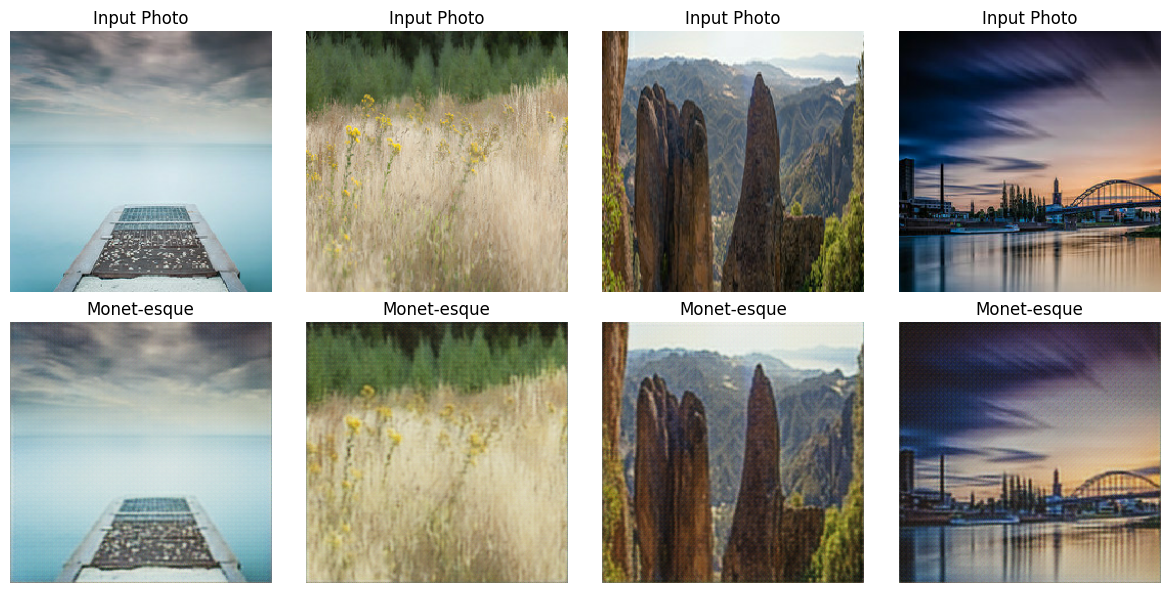

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, img in enumerate(photo_ds.take(4)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Input Photo")
    ax[1, i].set_title("Monet-esque")
    ax[0, i].axis("off")
    ax[1, i].axis("off")

plt.tight_layout()
plt.show()

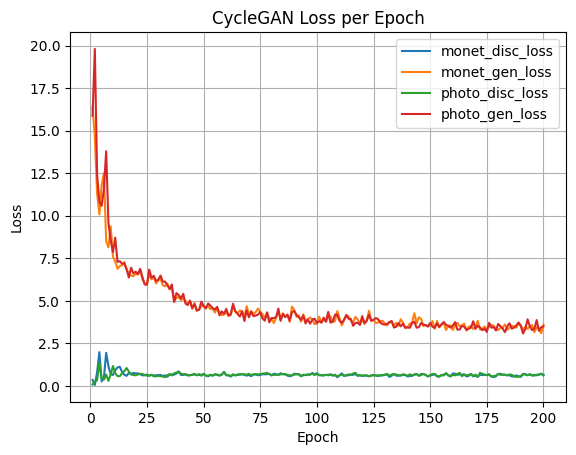

In [18]:
for name, losses in history.history.items():
    scalar_losses = [tf.reduce_mean(l).numpy() for l in losses]
    plt.plot(range(1, len(scalar_losses)+1), scalar_losses, label=name)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CycleGAN Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Submission
As recommended, I'll create an images directory and zip all generated images from the photo directory for submission. 

In [19]:
! mkdir ../images

In [20]:
for i, img in enumerate(tqdm(test_photo_ds, total=7028), 1):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")

  0%|          | 0/7028 [00:00<?, ?it/s]

  0%|          | 1/7028 [00:00<1:06:38,  1.76it/s]

  0%|          | 2/7028 [00:00<47:58,  2.44it/s]  

  0%|          | 3/7028 [00:01<42:00,  2.79it/s]

  0%|          | 4/7028 [00:01<38:54,  3.01it/s]

  0%|          | 5/7028 [00:01<37:34,  3.11it/s]

  0%|          | 6/7028 [00:02<36:43,  3.19it/s]

  0%|          | 7/7028 [00:02<36:10,  3.23it/s]

  0%|          | 8/7028 [00:02<35:48,  3.27it/s]

  0%|          | 9/7028 [00:02<35:35,  3.29it/s]

  0%|          | 10/7028 [00:03<35:26,  3.30it/s]

  0%|          | 11/7028 [00:03<35:34,  3.29it/s]

  0%|          | 12/7028 [00:03<35:36,  3.28it/s]

  0%|          | 13/7028 [00:04<35:51,  3.26it/s]

  0%|          | 14/7028 [00:04<35:39,  3.28it/s]

  0%|          | 15/7028 [00:04<35:08,  3.33it/s]

  0%|          | 16/7028 [00:05<35:11,  3.32it/s]

  0%|          | 17/7028 [00:05<35:45,  3.27it/s]

  0%|          | 18/7028 [00:05<35:00,  3.34it/s]

  0%|          | 19/7028 [00:05<34:47,  3.36it/s]

  0%|          | 20/7028 [00:06<34:22,  3.40it/s]

  0%|          | 21/7028 [00:06<34:04,  3.43it/s]

  0%|          | 22/7028 [00:06<33:49,  3.45it/s]

  0%|          | 23/7028 [00:07<33:43,  3.46it/s]

  0%|          | 24/7028 [00:07<33:30,  3.48it/s]

  0%|          | 25/7028 [00:07<33:25,  3.49it/s]

  0%|          | 26/7028 [00:07<33:18,  3.50it/s]

  0%|          | 27/7028 [00:08<33:14,  3.51it/s]

  0%|          | 28/7028 [00:08<33:10,  3.52it/s]

  0%|          | 29/7028 [00:08<33:07,  3.52it/s]

  0%|          | 30/7028 [00:09<32:54,  3.54it/s]

  0%|          | 31/7028 [00:09<32:48,  3.55it/s]

  0%|          | 32/7028 [00:09<33:03,  3.53it/s]

  0%|          | 33/7028 [00:09<33:00,  3.53it/s]

  0%|          | 34/7028 [00:10<33:30,  3.48it/s]

  0%|          | 35/7028 [00:10<34:42,  3.36it/s]

  1%|          | 36/7028 [00:10<34:29,  3.38it/s]

  1%|          | 37/7028 [00:11<34:04,  3.42it/s]

  1%|          | 38/7028 [00:11<33:55,  3.43it/s]

  1%|          | 39/7028 [00:11<33:45,  3.45it/s]

  1%|          | 40/7028 [00:12<33:49,  3.44it/s]

  1%|          | 41/7028 [00:12<34:05,  3.42it/s]

  1%|          | 42/7028 [00:12<34:01,  3.42it/s]

  1%|          | 43/7028 [00:12<34:52,  3.34it/s]

  1%|          | 44/7028 [00:13<34:46,  3.35it/s]

  1%|          | 45/7028 [00:13<34:51,  3.34it/s]

  1%|          | 46/7028 [00:13<34:57,  3.33it/s]

  1%|          | 47/7028 [00:14<35:04,  3.32it/s]

  1%|          | 48/7028 [00:14<34:58,  3.33it/s]

  1%|          | 49/7028 [00:14<34:43,  3.35it/s]

  1%|          | 50/7028 [00:15<34:37,  3.36it/s]

  1%|          | 51/7028 [00:15<34:58,  3.33it/s]

  1%|          | 52/7028 [00:15<34:49,  3.34it/s]

  1%|          | 53/7028 [00:15<34:48,  3.34it/s]

  1%|          | 54/7028 [00:16<34:14,  3.39it/s]

  1%|          | 55/7028 [00:16<34:29,  3.37it/s]

  1%|          | 56/7028 [00:16<34:44,  3.34it/s]

  1%|          | 57/7028 [00:17<34:48,  3.34it/s]

  1%|          | 58/7028 [00:17<34:37,  3.36it/s]

  1%|          | 59/7028 [00:17<34:24,  3.38it/s]

  1%|          | 60/7028 [00:17<34:18,  3.38it/s]

  1%|          | 61/7028 [00:18<34:28,  3.37it/s]

  1%|          | 62/7028 [00:18<34:34,  3.36it/s]

  1%|          | 63/7028 [00:18<34:45,  3.34it/s]

  1%|          | 64/7028 [00:19<34:51,  3.33it/s]

  1%|          | 65/7028 [00:19<35:08,  3.30it/s]

  1%|          | 66/7028 [00:19<35:06,  3.31it/s]

  1%|          | 67/7028 [00:20<35:07,  3.30it/s]

  1%|          | 68/7028 [00:20<35:35,  3.26it/s]

  1%|          | 69/7028 [00:20<35:16,  3.29it/s]

  1%|          | 70/7028 [00:21<35:06,  3.30it/s]

  1%|          | 71/7028 [00:21<35:03,  3.31it/s]

  1%|          | 72/7028 [00:21<34:55,  3.32it/s]

  1%|          | 73/7028 [00:21<34:49,  3.33it/s]

  1%|          | 74/7028 [00:22<34:41,  3.34it/s]

  1%|          | 75/7028 [00:22<34:05,  3.40it/s]

  1%|          | 76/7028 [00:22<34:06,  3.40it/s]

  1%|          | 77/7028 [00:23<33:58,  3.41it/s]

  1%|          | 78/7028 [00:23<34:00,  3.41it/s]

  1%|          | 79/7028 [00:23<33:47,  3.43it/s]

  1%|          | 80/7028 [00:23<33:38,  3.44it/s]

  1%|          | 81/7028 [00:24<33:14,  3.48it/s]

  1%|          | 82/7028 [00:24<33:01,  3.51it/s]

  1%|          | 83/7028 [00:24<32:45,  3.53it/s]

  1%|          | 84/7028 [00:25<32:42,  3.54it/s]

  1%|          | 85/7028 [00:25<33:18,  3.47it/s]

  1%|          | 86/7028 [00:25<33:14,  3.48it/s]

  1%|          | 87/7028 [00:25<33:37,  3.44it/s]

  1%|▏         | 88/7028 [00:26<34:11,  3.38it/s]

  1%|▏         | 89/7028 [00:26<34:24,  3.36it/s]

  1%|▏         | 90/7028 [00:26<34:21,  3.37it/s]

  1%|▏         | 91/7028 [00:27<34:34,  3.34it/s]

  1%|▏         | 92/7028 [00:27<34:38,  3.34it/s]

  1%|▏         | 93/7028 [00:27<34:39,  3.33it/s]

  1%|▏         | 94/7028 [00:28<34:29,  3.35it/s]

  1%|▏         | 95/7028 [00:28<34:32,  3.35it/s]

  1%|▏         | 96/7028 [00:28<34:24,  3.36it/s]

  1%|▏         | 97/7028 [00:28<34:34,  3.34it/s]

  1%|▏         | 98/7028 [00:29<34:52,  3.31it/s]

  1%|▏         | 99/7028 [00:29<35:06,  3.29it/s]

  1%|▏         | 100/7028 [00:29<34:49,  3.32it/s]

  1%|▏         | 101/7028 [00:30<34:42,  3.33it/s]

  1%|▏         | 102/7028 [00:30<35:10,  3.28it/s]

  1%|▏         | 103/7028 [00:30<34:44,  3.32it/s]

  1%|▏         | 104/7028 [00:31<34:32,  3.34it/s]

  1%|▏         | 105/7028 [00:31<34:24,  3.35it/s]

  2%|▏         | 106/7028 [00:31<34:25,  3.35it/s]

  2%|▏         | 107/7028 [00:31<34:27,  3.35it/s]

  2%|▏         | 108/7028 [00:32<34:57,  3.30it/s]

  2%|▏         | 109/7028 [00:32<34:54,  3.30it/s]

  2%|▏         | 110/7028 [00:32<34:47,  3.31it/s]

  2%|▏         | 111/7028 [00:33<34:15,  3.37it/s]

  2%|▏         | 112/7028 [00:33<34:15,  3.37it/s]

  2%|▏         | 113/7028 [00:33<34:17,  3.36it/s]

  2%|▏         | 114/7028 [00:34<34:19,  3.36it/s]

  2%|▏         | 115/7028 [00:34<34:11,  3.37it/s]

  2%|▏         | 116/7028 [00:34<34:15,  3.36it/s]

  2%|▏         | 117/7028 [00:34<34:08,  3.37it/s]

  2%|▏         | 118/7028 [00:35<34:27,  3.34it/s]

  2%|▏         | 119/7028 [00:35<35:10,  3.27it/s]

  2%|▏         | 120/7028 [00:35<35:17,  3.26it/s]

  2%|▏         | 121/7028 [00:36<34:47,  3.31it/s]

  2%|▏         | 122/7028 [00:36<34:24,  3.35it/s]

  2%|▏         | 123/7028 [00:36<34:06,  3.37it/s]

  2%|▏         | 124/7028 [00:37<34:03,  3.38it/s]

  2%|▏         | 125/7028 [00:37<33:56,  3.39it/s]

  2%|▏         | 126/7028 [00:37<33:49,  3.40it/s]

  2%|▏         | 127/7028 [00:37<33:48,  3.40it/s]

  2%|▏         | 128/7028 [00:38<33:43,  3.41it/s]

  2%|▏         | 129/7028 [00:38<33:44,  3.41it/s]

  2%|▏         | 130/7028 [00:38<33:51,  3.40it/s]

  2%|▏         | 131/7028 [00:39<33:51,  3.39it/s]

  2%|▏         | 132/7028 [00:39<33:45,  3.40it/s]

  2%|▏         | 133/7028 [00:39<33:48,  3.40it/s]

  2%|▏         | 134/7028 [00:39<33:55,  3.39it/s]

  2%|▏         | 135/7028 [00:40<34:05,  3.37it/s]

  2%|▏         | 136/7028 [00:40<34:50,  3.30it/s]

  2%|▏         | 137/7028 [00:40<35:02,  3.28it/s]

  2%|▏         | 138/7028 [00:41<34:42,  3.31it/s]

  2%|▏         | 139/7028 [00:41<34:27,  3.33it/s]

  2%|▏         | 140/7028 [00:41<34:04,  3.37it/s]

  2%|▏         | 141/7028 [00:42<34:00,  3.38it/s]

  2%|▏         | 142/7028 [00:42<33:45,  3.40it/s]

  2%|▏         | 143/7028 [00:42<33:22,  3.44it/s]

  2%|▏         | 144/7028 [00:42<33:02,  3.47it/s]

  2%|▏         | 145/7028 [00:43<32:49,  3.50it/s]

  2%|▏         | 146/7028 [00:43<32:45,  3.50it/s]

  2%|▏         | 147/7028 [00:43<32:47,  3.50it/s]

  2%|▏         | 148/7028 [00:44<32:41,  3.51it/s]

  2%|▏         | 149/7028 [00:44<32:40,  3.51it/s]

  2%|▏         | 150/7028 [00:44<32:44,  3.50it/s]

  2%|▏         | 151/7028 [00:44<32:32,  3.52it/s]

  2%|▏         | 152/7028 [00:45<32:45,  3.50it/s]

  2%|▏         | 153/7028 [00:45<33:17,  3.44it/s]

  2%|▏         | 154/7028 [00:45<33:13,  3.45it/s]

  2%|▏         | 155/7028 [00:46<33:06,  3.46it/s]

  2%|▏         | 156/7028 [00:46<32:56,  3.48it/s]

  2%|▏         | 157/7028 [00:46<32:47,  3.49it/s]

  2%|▏         | 158/7028 [00:46<32:49,  3.49it/s]

  2%|▏         | 159/7028 [00:47<32:53,  3.48it/s]

  2%|▏         | 160/7028 [00:47<33:02,  3.46it/s]

  2%|▏         | 161/7028 [00:47<33:35,  3.41it/s]

  2%|▏         | 162/7028 [00:48<34:11,  3.35it/s]

  2%|▏         | 163/7028 [00:48<34:15,  3.34it/s]

  2%|▏         | 164/7028 [00:48<34:06,  3.35it/s]

  2%|▏         | 165/7028 [00:49<34:03,  3.36it/s]

  2%|▏         | 166/7028 [00:49<33:59,  3.36it/s]

  2%|▏         | 167/7028 [00:49<33:54,  3.37it/s]

  2%|▏         | 168/7028 [00:49<33:54,  3.37it/s]

  2%|▏         | 169/7028 [00:50<33:54,  3.37it/s]

  2%|▏         | 170/7028 [00:50<34:24,  3.32it/s]

  2%|▏         | 171/7028 [00:50<34:08,  3.35it/s]

  2%|▏         | 172/7028 [00:51<34:03,  3.35it/s]

  2%|▏         | 173/7028 [00:51<33:50,  3.38it/s]

  2%|▏         | 174/7028 [00:51<33:57,  3.36it/s]

  2%|▏         | 175/7028 [00:52<33:46,  3.38it/s]

  3%|▎         | 176/7028 [00:52<33:55,  3.37it/s]

  3%|▎         | 177/7028 [00:52<33:56,  3.36it/s]

  3%|▎         | 178/7028 [00:52<33:56,  3.36it/s]

  3%|▎         | 179/7028 [00:53<33:54,  3.37it/s]

  3%|▎         | 180/7028 [00:53<34:03,  3.35it/s]

  3%|▎         | 181/7028 [00:53<34:03,  3.35it/s]

  3%|▎         | 182/7028 [00:54<34:22,  3.32it/s]

  3%|▎         | 183/7028 [00:54<34:29,  3.31it/s]

  3%|▎         | 184/7028 [00:54<34:31,  3.30it/s]

  3%|▎         | 185/7028 [00:55<34:41,  3.29it/s]

  3%|▎         | 186/7028 [00:55<34:54,  3.27it/s]

  3%|▎         | 187/7028 [00:55<34:27,  3.31it/s]

  3%|▎         | 188/7028 [00:55<34:11,  3.33it/s]

  3%|▎         | 189/7028 [00:56<34:05,  3.34it/s]

  3%|▎         | 190/7028 [00:56<34:00,  3.35it/s]

  3%|▎         | 191/7028 [00:56<33:54,  3.36it/s]

  3%|▎         | 192/7028 [00:57<33:56,  3.36it/s]

  3%|▎         | 193/7028 [00:57<33:51,  3.37it/s]

  3%|▎         | 194/7028 [00:57<33:43,  3.38it/s]

  3%|▎         | 195/7028 [00:57<33:35,  3.39it/s]

  3%|▎         | 196/7028 [00:58<33:14,  3.43it/s]

  3%|▎         | 197/7028 [00:58<32:59,  3.45it/s]

  3%|▎         | 198/7028 [00:58<32:48,  3.47it/s]

  3%|▎         | 199/7028 [00:59<32:43,  3.48it/s]

  3%|▎         | 200/7028 [00:59<32:31,  3.50it/s]

  3%|▎         | 201/7028 [00:59<32:37,  3.49it/s]

  3%|▎         | 202/7028 [00:59<32:34,  3.49it/s]

  3%|▎         | 203/7028 [01:00<33:41,  3.38it/s]

  3%|▎         | 204/7028 [01:00<33:50,  3.36it/s]

  3%|▎         | 205/7028 [01:00<33:34,  3.39it/s]

  3%|▎         | 206/7028 [01:01<33:49,  3.36it/s]

  3%|▎         | 207/7028 [01:01<34:00,  3.34it/s]

  3%|▎         | 208/7028 [01:01<34:04,  3.34it/s]

  3%|▎         | 209/7028 [01:02<34:02,  3.34it/s]

  3%|▎         | 210/7028 [01:02<33:46,  3.36it/s]

  3%|▎         | 211/7028 [01:02<33:23,  3.40it/s]

  3%|▎         | 212/7028 [01:02<33:06,  3.43it/s]

  3%|▎         | 213/7028 [01:03<32:53,  3.45it/s]

  3%|▎         | 214/7028 [01:03<32:46,  3.47it/s]

  3%|▎         | 215/7028 [01:03<33:00,  3.44it/s]

  3%|▎         | 216/7028 [01:04<33:18,  3.41it/s]

  3%|▎         | 217/7028 [01:04<33:14,  3.41it/s]

  3%|▎         | 218/7028 [01:04<33:14,  3.42it/s]

  3%|▎         | 219/7028 [01:05<32:49,  3.46it/s]

  3%|▎         | 220/7028 [01:05<32:53,  3.45it/s]

  3%|▎         | 221/7028 [01:05<33:22,  3.40it/s]

  3%|▎         | 222/7028 [01:05<33:05,  3.43it/s]

  3%|▎         | 223/7028 [01:06<32:41,  3.47it/s]

  3%|▎         | 224/7028 [01:06<32:55,  3.44it/s]

  3%|▎         | 225/7028 [01:06<32:59,  3.44it/s]

  3%|▎         | 226/7028 [01:07<33:01,  3.43it/s]

  3%|▎         | 227/7028 [01:07<32:39,  3.47it/s]

  3%|▎         | 228/7028 [01:07<32:36,  3.48it/s]

  3%|▎         | 229/7028 [01:07<32:20,  3.50it/s]

  3%|▎         | 230/7028 [01:08<32:16,  3.51it/s]

  3%|▎         | 231/7028 [01:08<32:06,  3.53it/s]

  3%|▎         | 232/7028 [01:08<32:00,  3.54it/s]

  3%|▎         | 233/7028 [01:09<32:03,  3.53it/s]

  3%|▎         | 234/7028 [01:09<32:09,  3.52it/s]

  3%|▎         | 235/7028 [01:09<32:02,  3.53it/s]

  3%|▎         | 236/7028 [01:09<31:58,  3.54it/s]

  3%|▎         | 237/7028 [01:10<31:57,  3.54it/s]

  3%|▎         | 238/7028 [01:10<32:55,  3.44it/s]

  3%|▎         | 239/7028 [01:10<32:35,  3.47it/s]

  3%|▎         | 240/7028 [01:11<32:14,  3.51it/s]

  3%|▎         | 241/7028 [01:11<32:12,  3.51it/s]

  3%|▎         | 242/7028 [01:11<32:10,  3.52it/s]

  3%|▎         | 243/7028 [01:11<32:49,  3.44it/s]

  3%|▎         | 244/7028 [01:12<33:10,  3.41it/s]

  3%|▎         | 245/7028 [01:12<33:20,  3.39it/s]

  4%|▎         | 246/7028 [01:12<33:23,  3.39it/s]

  4%|▎         | 247/7028 [01:13<33:18,  3.39it/s]

  4%|▎         | 248/7028 [01:13<33:22,  3.39it/s]

  4%|▎         | 249/7028 [01:13<33:36,  3.36it/s]

  4%|▎         | 250/7028 [01:13<33:36,  3.36it/s]

  4%|▎         | 251/7028 [01:14<33:23,  3.38it/s]

  4%|▎         | 252/7028 [01:14<33:17,  3.39it/s]

  4%|▎         | 253/7028 [01:14<33:14,  3.40it/s]

  4%|▎         | 254/7028 [01:15<33:10,  3.40it/s]

  4%|▎         | 255/7028 [01:15<33:42,  3.35it/s]

  4%|▎         | 256/7028 [01:15<33:34,  3.36it/s]

  4%|▎         | 257/7028 [01:16<33:34,  3.36it/s]

  4%|▎         | 258/7028 [01:16<33:48,  3.34it/s]

  4%|▎         | 259/7028 [01:16<33:53,  3.33it/s]

  4%|▎         | 260/7028 [01:16<33:50,  3.33it/s]

  4%|▎         | 261/7028 [01:17<33:53,  3.33it/s]

  4%|▎         | 262/7028 [01:17<33:37,  3.35it/s]

  4%|▎         | 263/7028 [01:17<33:56,  3.32it/s]

  4%|▍         | 264/7028 [01:18<33:55,  3.32it/s]

  4%|▍         | 265/7028 [01:18<33:34,  3.36it/s]

  4%|▍         | 266/7028 [01:18<33:10,  3.40it/s]

  4%|▍         | 267/7028 [01:19<32:57,  3.42it/s]

  4%|▍         | 268/7028 [01:19<33:50,  3.33it/s]

  4%|▍         | 269/7028 [01:19<33:08,  3.40it/s]

  4%|▍         | 270/7028 [01:19<32:41,  3.44it/s]

  4%|▍         | 271/7028 [01:20<32:30,  3.46it/s]

  4%|▍         | 272/7028 [01:20<32:58,  3.41it/s]

  4%|▍         | 273/7028 [01:20<32:15,  3.49it/s]

  4%|▍         | 274/7028 [01:21<31:53,  3.53it/s]

  4%|▍         | 275/7028 [01:21<31:34,  3.56it/s]

  4%|▍         | 276/7028 [01:21<31:23,  3.58it/s]

  4%|▍         | 277/7028 [01:21<31:21,  3.59it/s]

  4%|▍         | 278/7028 [01:22<31:17,  3.59it/s]

  4%|▍         | 279/7028 [01:22<31:17,  3.59it/s]

  4%|▍         | 280/7028 [01:22<31:03,  3.62it/s]

  4%|▍         | 281/7028 [01:22<31:31,  3.57it/s]

  4%|▍         | 282/7028 [01:23<32:12,  3.49it/s]

  4%|▍         | 283/7028 [01:23<32:40,  3.44it/s]

  4%|▍         | 284/7028 [01:23<32:34,  3.45it/s]

  4%|▍         | 285/7028 [01:24<32:24,  3.47it/s]

  4%|▍         | 286/7028 [01:24<32:33,  3.45it/s]

  4%|▍         | 287/7028 [01:24<32:27,  3.46it/s]

  4%|▍         | 288/7028 [01:25<33:02,  3.40it/s]

  4%|▍         | 289/7028 [01:25<33:19,  3.37it/s]

  4%|▍         | 290/7028 [01:25<33:27,  3.36it/s]

  4%|▍         | 291/7028 [01:25<32:58,  3.40it/s]

  4%|▍         | 292/7028 [01:26<32:41,  3.43it/s]

  4%|▍         | 293/7028 [01:26<32:14,  3.48it/s]

  4%|▍         | 294/7028 [01:26<31:48,  3.53it/s]

  4%|▍         | 295/7028 [01:27<31:43,  3.54it/s]

  4%|▍         | 296/7028 [01:27<31:34,  3.55it/s]

  4%|▍         | 297/7028 [01:27<31:21,  3.58it/s]

  4%|▍         | 298/7028 [01:27<31:22,  3.57it/s]

  4%|▍         | 299/7028 [01:28<31:22,  3.57it/s]

  4%|▍         | 300/7028 [01:28<31:22,  3.57it/s]

  4%|▍         | 301/7028 [01:28<31:33,  3.55it/s]

  4%|▍         | 302/7028 [01:29<31:48,  3.52it/s]

  4%|▍         | 303/7028 [01:29<31:42,  3.53it/s]

  4%|▍         | 304/7028 [01:29<31:54,  3.51it/s]

  4%|▍         | 305/7028 [01:29<32:03,  3.50it/s]

  4%|▍         | 306/7028 [01:30<32:15,  3.47it/s]

  4%|▍         | 307/7028 [01:30<32:44,  3.42it/s]

  4%|▍         | 308/7028 [01:30<32:21,  3.46it/s]

  4%|▍         | 309/7028 [01:31<32:15,  3.47it/s]

  4%|▍         | 310/7028 [01:31<32:28,  3.45it/s]

  4%|▍         | 311/7028 [01:31<32:09,  3.48it/s]

  4%|▍         | 312/7028 [01:31<32:05,  3.49it/s]

  4%|▍         | 313/7028 [01:32<32:19,  3.46it/s]

  4%|▍         | 314/7028 [01:32<32:01,  3.49it/s]

  4%|▍         | 315/7028 [01:32<31:45,  3.52it/s]

  4%|▍         | 316/7028 [01:33<31:33,  3.55it/s]

  5%|▍         | 317/7028 [01:33<31:16,  3.58it/s]

  5%|▍         | 318/7028 [01:33<31:16,  3.58it/s]

  5%|▍         | 319/7028 [01:33<31:17,  3.57it/s]

  5%|▍         | 320/7028 [01:34<31:16,  3.58it/s]

  5%|▍         | 321/7028 [01:34<31:19,  3.57it/s]

  5%|▍         | 322/7028 [01:34<31:16,  3.57it/s]

  5%|▍         | 323/7028 [01:34<31:16,  3.57it/s]

  5%|▍         | 324/7028 [01:35<31:16,  3.57it/s]

  5%|▍         | 325/7028 [01:35<31:56,  3.50it/s]

  5%|▍         | 326/7028 [01:35<31:38,  3.53it/s]

  5%|▍         | 327/7028 [01:36<31:28,  3.55it/s]

  5%|▍         | 328/7028 [01:36<31:24,  3.56it/s]

  5%|▍         | 329/7028 [01:36<31:21,  3.56it/s]

  5%|▍         | 330/7028 [01:36<31:30,  3.54it/s]

  5%|▍         | 331/7028 [01:37<32:02,  3.48it/s]

  5%|▍         | 332/7028 [01:37<32:23,  3.45it/s]

  5%|▍         | 333/7028 [01:37<32:53,  3.39it/s]

  5%|▍         | 334/7028 [01:38<33:16,  3.35it/s]

  5%|▍         | 335/7028 [01:38<33:19,  3.35it/s]

  5%|▍         | 336/7028 [01:38<33:17,  3.35it/s]

  5%|▍         | 337/7028 [01:39<33:09,  3.36it/s]

  5%|▍         | 338/7028 [01:39<32:59,  3.38it/s]

  5%|▍         | 339/7028 [01:39<32:51,  3.39it/s]

  5%|▍         | 340/7028 [01:39<32:44,  3.40it/s]

  5%|▍         | 341/7028 [01:40<32:46,  3.40it/s]

  5%|▍         | 342/7028 [01:40<33:27,  3.33it/s]

  5%|▍         | 343/7028 [01:40<33:15,  3.35it/s]

  5%|▍         | 344/7028 [01:41<33:17,  3.35it/s]

  5%|▍         | 345/7028 [01:41<33:09,  3.36it/s]

  5%|▍         | 346/7028 [01:41<33:02,  3.37it/s]

  5%|▍         | 347/7028 [01:42<32:50,  3.39it/s]

  5%|▍         | 348/7028 [01:42<32:51,  3.39it/s]

  5%|▍         | 349/7028 [01:42<32:39,  3.41it/s]

  5%|▍         | 350/7028 [01:42<32:43,  3.40it/s]

  5%|▍         | 351/7028 [01:43<33:10,  3.35it/s]

  5%|▌         | 352/7028 [01:43<33:27,  3.33it/s]

  5%|▌         | 353/7028 [01:43<33:40,  3.30it/s]

  5%|▌         | 354/7028 [01:44<33:15,  3.34it/s]

  5%|▌         | 355/7028 [01:44<33:14,  3.35it/s]

  5%|▌         | 356/7028 [01:44<33:09,  3.35it/s]

  5%|▌         | 357/7028 [01:45<33:37,  3.31it/s]

  5%|▌         | 358/7028 [01:45<33:31,  3.32it/s]

  5%|▌         | 359/7028 [01:45<33:36,  3.31it/s]

  5%|▌         | 360/7028 [01:45<33:14,  3.34it/s]

  5%|▌         | 361/7028 [01:46<33:04,  3.36it/s]

  5%|▌         | 362/7028 [01:46<32:50,  3.38it/s]

  5%|▌         | 363/7028 [01:46<32:41,  3.40it/s]

  5%|▌         | 364/7028 [01:47<32:39,  3.40it/s]

  5%|▌         | 365/7028 [01:47<32:33,  3.41it/s]

  5%|▌         | 366/7028 [01:47<32:29,  3.42it/s]

  5%|▌         | 367/7028 [01:47<32:19,  3.43it/s]

  5%|▌         | 368/7028 [01:48<32:17,  3.44it/s]

  5%|▌         | 369/7028 [01:48<32:23,  3.43it/s]

  5%|▌         | 370/7028 [01:48<32:22,  3.43it/s]

  5%|▌         | 371/7028 [01:49<32:18,  3.43it/s]

  5%|▌         | 372/7028 [01:49<32:26,  3.42it/s]

  5%|▌         | 373/7028 [01:49<32:32,  3.41it/s]

  5%|▌         | 374/7028 [01:50<32:48,  3.38it/s]

  5%|▌         | 375/7028 [01:50<32:50,  3.38it/s]

  5%|▌         | 376/7028 [01:50<34:00,  3.26it/s]

  5%|▌         | 377/7028 [01:50<34:02,  3.26it/s]

  5%|▌         | 378/7028 [01:51<33:53,  3.27it/s]

  5%|▌         | 379/7028 [01:51<33:31,  3.31it/s]

  5%|▌         | 380/7028 [01:51<33:05,  3.35it/s]

  5%|▌         | 381/7028 [01:52<32:57,  3.36it/s]

  5%|▌         | 382/7028 [01:52<32:51,  3.37it/s]

  5%|▌         | 383/7028 [01:52<32:46,  3.38it/s]

  5%|▌         | 384/7028 [01:53<32:36,  3.40it/s]

  5%|▌         | 385/7028 [01:53<32:32,  3.40it/s]

  5%|▌         | 386/7028 [01:53<32:29,  3.41it/s]

  6%|▌         | 387/7028 [01:53<32:33,  3.40it/s]

  6%|▌         | 388/7028 [01:54<32:42,  3.38it/s]

  6%|▌         | 389/7028 [01:54<32:49,  3.37it/s]

  6%|▌         | 390/7028 [01:54<32:55,  3.36it/s]

  6%|▌         | 391/7028 [01:55<32:50,  3.37it/s]

  6%|▌         | 392/7028 [01:55<33:26,  3.31it/s]

  6%|▌         | 393/7028 [01:55<33:19,  3.32it/s]

  6%|▌         | 394/7028 [01:56<33:22,  3.31it/s]

  6%|▌         | 395/7028 [01:56<33:30,  3.30it/s]

  6%|▌         | 396/7028 [01:56<33:31,  3.30it/s]

  6%|▌         | 397/7028 [01:56<33:48,  3.27it/s]

  6%|▌         | 398/7028 [01:57<33:25,  3.31it/s]

  6%|▌         | 399/7028 [01:57<33:35,  3.29it/s]

  6%|▌         | 400/7028 [01:57<33:01,  3.34it/s]

  6%|▌         | 401/7028 [01:58<32:22,  3.41it/s]

  6%|▌         | 402/7028 [01:58<32:04,  3.44it/s]

  6%|▌         | 403/7028 [01:58<31:48,  3.47it/s]

  6%|▌         | 404/7028 [01:58<32:23,  3.41it/s]

  6%|▌         | 405/7028 [01:59<32:37,  3.38it/s]

  6%|▌         | 406/7028 [01:59<32:46,  3.37it/s]

  6%|▌         | 407/7028 [01:59<32:44,  3.37it/s]

  6%|▌         | 408/7028 [02:00<32:43,  3.37it/s]

  6%|▌         | 409/7028 [02:00<33:10,  3.33it/s]

  6%|▌         | 410/7028 [02:00<32:59,  3.34it/s]

  6%|▌         | 411/7028 [02:01<33:05,  3.33it/s]

  6%|▌         | 412/7028 [02:01<32:53,  3.35it/s]

  6%|▌         | 413/7028 [02:01<32:39,  3.38it/s]

  6%|▌         | 414/7028 [02:01<32:44,  3.37it/s]

  6%|▌         | 415/7028 [02:02<32:35,  3.38it/s]

  6%|▌         | 416/7028 [02:02<32:54,  3.35it/s]

  6%|▌         | 417/7028 [02:02<32:52,  3.35it/s]

  6%|▌         | 418/7028 [02:03<33:19,  3.31it/s]

  6%|▌         | 419/7028 [02:03<33:24,  3.30it/s]

  6%|▌         | 420/7028 [02:03<33:22,  3.30it/s]

  6%|▌         | 421/7028 [02:04<32:51,  3.35it/s]

  6%|▌         | 422/7028 [02:04<32:23,  3.40it/s]

  6%|▌         | 423/7028 [02:04<32:12,  3.42it/s]

  6%|▌         | 424/7028 [02:04<32:18,  3.41it/s]

  6%|▌         | 425/7028 [02:05<32:13,  3.41it/s]

  6%|▌         | 426/7028 [02:05<32:53,  3.34it/s]

  6%|▌         | 427/7028 [02:05<32:36,  3.37it/s]

  6%|▌         | 428/7028 [02:06<32:31,  3.38it/s]

  6%|▌         | 429/7028 [02:06<32:36,  3.37it/s]

  6%|▌         | 430/7028 [02:06<32:34,  3.38it/s]

  6%|▌         | 431/7028 [02:07<32:28,  3.39it/s]

  6%|▌         | 432/7028 [02:07<32:21,  3.40it/s]

  6%|▌         | 433/7028 [02:07<32:21,  3.40it/s]

  6%|▌         | 434/7028 [02:07<32:20,  3.40it/s]

  6%|▌         | 435/7028 [02:08<32:21,  3.40it/s]

  6%|▌         | 436/7028 [02:08<32:13,  3.41it/s]

  6%|▌         | 437/7028 [02:08<32:28,  3.38it/s]

  6%|▌         | 438/7028 [02:09<32:39,  3.36it/s]

  6%|▌         | 439/7028 [02:09<32:44,  3.35it/s]

  6%|▋         | 440/7028 [02:09<32:50,  3.34it/s]

  6%|▋         | 441/7028 [02:09<32:50,  3.34it/s]

  6%|▋         | 442/7028 [02:10<32:57,  3.33it/s]

  6%|▋         | 443/7028 [02:10<33:15,  3.30it/s]

  6%|▋         | 444/7028 [02:10<33:07,  3.31it/s]

  6%|▋         | 445/7028 [02:11<33:01,  3.32it/s]

  6%|▋         | 446/7028 [02:11<32:59,  3.32it/s]

  6%|▋         | 447/7028 [02:11<32:50,  3.34it/s]

  6%|▋         | 448/7028 [02:12<32:55,  3.33it/s]

  6%|▋         | 449/7028 [02:12<32:44,  3.35it/s]

  6%|▋         | 450/7028 [02:12<32:50,  3.34it/s]

  6%|▋         | 451/7028 [02:12<32:48,  3.34it/s]

  6%|▋         | 452/7028 [02:13<32:40,  3.35it/s]

  6%|▋         | 453/7028 [02:13<32:30,  3.37it/s]

  6%|▋         | 454/7028 [02:13<32:37,  3.36it/s]

  6%|▋         | 455/7028 [02:14<32:31,  3.37it/s]

  6%|▋         | 456/7028 [02:14<32:29,  3.37it/s]

  7%|▋         | 457/7028 [02:14<32:23,  3.38it/s]

  7%|▋         | 458/7028 [02:15<32:32,  3.36it/s]

  7%|▋         | 459/7028 [02:15<32:41,  3.35it/s]

  7%|▋         | 460/7028 [02:15<33:09,  3.30it/s]

  7%|▋         | 461/7028 [02:15<33:08,  3.30it/s]

  7%|▋         | 462/7028 [02:16<33:04,  3.31it/s]

  7%|▋         | 463/7028 [02:16<32:55,  3.32it/s]

  7%|▋         | 464/7028 [02:16<32:53,  3.33it/s]

  7%|▋         | 465/7028 [02:17<32:42,  3.34it/s]

  7%|▋         | 466/7028 [02:17<32:31,  3.36it/s]

  7%|▋         | 467/7028 [02:17<32:25,  3.37it/s]

  7%|▋         | 468/7028 [02:18<32:25,  3.37it/s]

  7%|▋         | 469/7028 [02:18<32:21,  3.38it/s]

  7%|▋         | 470/7028 [02:18<32:18,  3.38it/s]

  7%|▋         | 471/7028 [02:18<32:31,  3.36it/s]

  7%|▋         | 472/7028 [02:19<32:20,  3.38it/s]

  7%|▋         | 473/7028 [02:19<32:54,  3.32it/s]

  7%|▋         | 474/7028 [02:19<33:07,  3.30it/s]

  7%|▋         | 475/7028 [02:20<32:51,  3.32it/s]

  7%|▋         | 476/7028 [02:20<33:15,  3.28it/s]

  7%|▋         | 477/7028 [02:20<33:09,  3.29it/s]

  7%|▋         | 478/7028 [02:21<32:51,  3.32it/s]

  7%|▋         | 479/7028 [02:21<32:54,  3.32it/s]

  7%|▋         | 480/7028 [02:21<32:52,  3.32it/s]

  7%|▋         | 481/7028 [02:21<33:16,  3.28it/s]

  7%|▋         | 482/7028 [02:22<33:02,  3.30it/s]

  7%|▋         | 483/7028 [02:22<33:15,  3.28it/s]

  7%|▋         | 484/7028 [02:22<32:57,  3.31it/s]

  7%|▋         | 485/7028 [02:23<32:50,  3.32it/s]

  7%|▋         | 486/7028 [02:23<32:43,  3.33it/s]

  7%|▋         | 487/7028 [02:23<32:36,  3.34it/s]

  7%|▋         | 488/7028 [02:24<32:22,  3.37it/s]

  7%|▋         | 489/7028 [02:24<32:15,  3.38it/s]

  7%|▋         | 490/7028 [02:24<32:13,  3.38it/s]

  7%|▋         | 491/7028 [02:24<32:09,  3.39it/s]

  7%|▋         | 492/7028 [02:25<32:10,  3.39it/s]

  7%|▋         | 493/7028 [02:25<32:39,  3.34it/s]

  7%|▋         | 494/7028 [02:25<32:27,  3.36it/s]

  7%|▋         | 495/7028 [02:26<31:57,  3.41it/s]

  7%|▋         | 496/7028 [02:26<31:35,  3.45it/s]

  7%|▋         | 497/7028 [02:26<31:34,  3.45it/s]

  7%|▋         | 498/7028 [02:26<31:35,  3.45it/s]

  7%|▋         | 499/7028 [02:27<31:59,  3.40it/s]

  7%|▋         | 500/7028 [02:27<32:15,  3.37it/s]

  7%|▋         | 501/7028 [02:27<32:04,  3.39it/s]

  7%|▋         | 502/7028 [02:28<31:53,  3.41it/s]

  7%|▋         | 503/7028 [02:28<31:51,  3.41it/s]

  7%|▋         | 504/7028 [02:28<32:10,  3.38it/s]

  7%|▋         | 505/7028 [02:29<32:02,  3.39it/s]

  7%|▋         | 506/7028 [02:29<31:39,  3.43it/s]

  7%|▋         | 507/7028 [02:29<31:27,  3.45it/s]

  7%|▋         | 508/7028 [02:29<31:25,  3.46it/s]

  7%|▋         | 509/7028 [02:30<31:16,  3.47it/s]

  7%|▋         | 510/7028 [02:30<31:40,  3.43it/s]

  7%|▋         | 511/7028 [02:30<31:10,  3.48it/s]

  7%|▋         | 512/7028 [02:31<30:56,  3.51it/s]

  7%|▋         | 513/7028 [02:31<30:51,  3.52it/s]

  7%|▋         | 514/7028 [02:31<30:50,  3.52it/s]

  7%|▋         | 515/7028 [02:31<30:51,  3.52it/s]

  7%|▋         | 516/7028 [02:32<30:47,  3.52it/s]

  7%|▋         | 517/7028 [02:32<30:40,  3.54it/s]

  7%|▋         | 518/7028 [02:32<30:35,  3.55it/s]

  7%|▋         | 519/7028 [02:33<30:32,  3.55it/s]

  7%|▋         | 520/7028 [02:33<30:40,  3.54it/s]

  7%|▋         | 521/7028 [02:33<30:46,  3.52it/s]

  7%|▋         | 522/7028 [02:33<31:06,  3.49it/s]

  7%|▋         | 523/7028 [02:34<31:26,  3.45it/s]

  7%|▋         | 524/7028 [02:34<31:24,  3.45it/s]

  7%|▋         | 525/7028 [02:34<31:30,  3.44it/s]

  7%|▋         | 526/7028 [02:35<31:28,  3.44it/s]

  7%|▋         | 527/7028 [02:35<31:24,  3.45it/s]

  8%|▊         | 528/7028 [02:35<32:05,  3.38it/s]

  8%|▊         | 529/7028 [02:35<31:50,  3.40it/s]

  8%|▊         | 530/7028 [02:36<31:38,  3.42it/s]

  8%|▊         | 531/7028 [02:36<31:20,  3.46it/s]

  8%|▊         | 532/7028 [02:36<31:10,  3.47it/s]

  8%|▊         | 533/7028 [02:37<31:00,  3.49it/s]

  8%|▊         | 534/7028 [02:37<30:47,  3.52it/s]

  8%|▊         | 535/7028 [02:37<30:43,  3.52it/s]

  8%|▊         | 536/7028 [02:37<30:55,  3.50it/s]

  8%|▊         | 537/7028 [02:38<30:55,  3.50it/s]

  8%|▊         | 538/7028 [02:38<30:50,  3.51it/s]

  8%|▊         | 539/7028 [02:38<30:47,  3.51it/s]

  8%|▊         | 540/7028 [02:39<30:50,  3.51it/s]

  8%|▊         | 541/7028 [02:39<30:51,  3.50it/s]

  8%|▊         | 542/7028 [02:39<30:47,  3.51it/s]

  8%|▊         | 543/7028 [02:39<31:12,  3.46it/s]

  8%|▊         | 544/7028 [02:40<31:30,  3.43it/s]

  8%|▊         | 545/7028 [02:40<32:25,  3.33it/s]

  8%|▊         | 546/7028 [02:40<32:47,  3.29it/s]

  8%|▊         | 547/7028 [02:41<32:55,  3.28it/s]

  8%|▊         | 548/7028 [02:41<32:36,  3.31it/s]

  8%|▊         | 549/7028 [02:41<31:55,  3.38it/s]

  8%|▊         | 550/7028 [02:42<31:40,  3.41it/s]

  8%|▊         | 551/7028 [02:42<31:39,  3.41it/s]

  8%|▊         | 552/7028 [02:42<31:40,  3.41it/s]

  8%|▊         | 553/7028 [02:42<31:23,  3.44it/s]

  8%|▊         | 554/7028 [02:43<31:11,  3.46it/s]

  8%|▊         | 555/7028 [02:43<31:06,  3.47it/s]

  8%|▊         | 556/7028 [02:43<31:05,  3.47it/s]

  8%|▊         | 557/7028 [02:44<31:01,  3.48it/s]

  8%|▊         | 558/7028 [02:44<30:53,  3.49it/s]

  8%|▊         | 559/7028 [02:44<30:38,  3.52it/s]

  8%|▊         | 560/7028 [02:44<30:39,  3.52it/s]

  8%|▊         | 561/7028 [02:45<30:42,  3.51it/s]

  8%|▊         | 562/7028 [02:45<31:14,  3.45it/s]

  8%|▊         | 563/7028 [02:45<31:03,  3.47it/s]

  8%|▊         | 564/7028 [02:46<31:00,  3.48it/s]

  8%|▊         | 565/7028 [02:46<31:03,  3.47it/s]

  8%|▊         | 566/7028 [02:46<30:55,  3.48it/s]

  8%|▊         | 567/7028 [02:46<31:02,  3.47it/s]

  8%|▊         | 568/7028 [02:47<30:53,  3.49it/s]

  8%|▊         | 569/7028 [02:47<30:48,  3.49it/s]

  8%|▊         | 570/7028 [02:47<30:37,  3.52it/s]

  8%|▊         | 571/7028 [02:48<30:57,  3.48it/s]

  8%|▊         | 572/7028 [02:48<30:43,  3.50it/s]

  8%|▊         | 573/7028 [02:48<30:58,  3.47it/s]

  8%|▊         | 574/7028 [02:48<31:19,  3.43it/s]

  8%|▊         | 575/7028 [02:49<31:17,  3.44it/s]

  8%|▊         | 576/7028 [02:49<31:16,  3.44it/s]

  8%|▊         | 577/7028 [02:49<31:22,  3.43it/s]

  8%|▊         | 578/7028 [02:50<31:27,  3.42it/s]

  8%|▊         | 579/7028 [02:50<31:59,  3.36it/s]

  8%|▊         | 580/7028 [02:50<31:50,  3.37it/s]

  8%|▊         | 581/7028 [02:51<31:43,  3.39it/s]

  8%|▊         | 582/7028 [02:51<31:34,  3.40it/s]

  8%|▊         | 583/7028 [02:51<31:29,  3.41it/s]

  8%|▊         | 584/7028 [02:51<31:42,  3.39it/s]

  8%|▊         | 585/7028 [02:52<31:43,  3.39it/s]

  8%|▊         | 586/7028 [02:52<32:11,  3.34it/s]

  8%|▊         | 587/7028 [02:52<32:16,  3.33it/s]

  8%|▊         | 588/7028 [02:53<32:26,  3.31it/s]

  8%|▊         | 589/7028 [02:53<32:21,  3.32it/s]

  8%|▊         | 590/7028 [02:53<32:21,  3.32it/s]

  8%|▊         | 591/7028 [02:54<32:18,  3.32it/s]

  8%|▊         | 592/7028 [02:54<32:15,  3.32it/s]

  8%|▊         | 593/7028 [02:54<32:08,  3.34it/s]

  8%|▊         | 594/7028 [02:54<32:32,  3.29it/s]

  8%|▊         | 595/7028 [02:55<32:12,  3.33it/s]

  8%|▊         | 596/7028 [02:55<32:52,  3.26it/s]

  8%|▊         | 597/7028 [02:55<32:29,  3.30it/s]

  9%|▊         | 598/7028 [02:56<32:11,  3.33it/s]

  9%|▊         | 599/7028 [02:56<32:03,  3.34it/s]

  9%|▊         | 600/7028 [02:56<31:52,  3.36it/s]

  9%|▊         | 601/7028 [02:57<31:47,  3.37it/s]

  9%|▊         | 602/7028 [02:57<31:39,  3.38it/s]

  9%|▊         | 603/7028 [02:57<31:34,  3.39it/s]

  9%|▊         | 604/7028 [02:57<31:31,  3.40it/s]

  9%|▊         | 605/7028 [02:58<31:42,  3.38it/s]

  9%|▊         | 606/7028 [02:58<31:38,  3.38it/s]

  9%|▊         | 607/7028 [02:58<31:58,  3.35it/s]

  9%|▊         | 608/7028 [02:59<31:54,  3.35it/s]

  9%|▊         | 609/7028 [02:59<31:56,  3.35it/s]

  9%|▊         | 610/7028 [02:59<32:04,  3.34it/s]

  9%|▊         | 611/7028 [02:59<31:41,  3.37it/s]

  9%|▊         | 612/7028 [03:00<31:10,  3.43it/s]

  9%|▊         | 613/7028 [03:00<31:54,  3.35it/s]

  9%|▊         | 614/7028 [03:00<31:52,  3.35it/s]

  9%|▉         | 615/7028 [03:01<31:45,  3.37it/s]

  9%|▉         | 616/7028 [03:01<31:47,  3.36it/s]

  9%|▉         | 617/7028 [03:01<31:56,  3.34it/s]

  9%|▉         | 618/7028 [03:02<32:01,  3.34it/s]

  9%|▉         | 619/7028 [03:02<32:03,  3.33it/s]

  9%|▉         | 620/7028 [03:02<31:51,  3.35it/s]

  9%|▉         | 621/7028 [03:02<31:52,  3.35it/s]

  9%|▉         | 622/7028 [03:03<31:37,  3.38it/s]

  9%|▉         | 623/7028 [03:03<31:33,  3.38it/s]

  9%|▉         | 624/7028 [03:03<31:33,  3.38it/s]

  9%|▉         | 625/7028 [03:04<31:10,  3.42it/s]

  9%|▉         | 626/7028 [03:04<31:08,  3.43it/s]

  9%|▉         | 627/7028 [03:04<30:44,  3.47it/s]

  9%|▉         | 628/7028 [03:05<31:17,  3.41it/s]

  9%|▉         | 629/7028 [03:05<31:27,  3.39it/s]

  9%|▉         | 630/7028 [03:05<32:09,  3.32it/s]

  9%|▉         | 631/7028 [03:05<32:06,  3.32it/s]

  9%|▉         | 632/7028 [03:06<31:49,  3.35it/s]

  9%|▉         | 633/7028 [03:06<31:40,  3.36it/s]

  9%|▉         | 634/7028 [03:06<31:29,  3.38it/s]

  9%|▉         | 635/7028 [03:07<31:26,  3.39it/s]

  9%|▉         | 636/7028 [03:07<31:30,  3.38it/s]

  9%|▉         | 637/7028 [03:07<31:26,  3.39it/s]

  9%|▉         | 638/7028 [03:08<31:36,  3.37it/s]

  9%|▉         | 639/7028 [03:08<31:45,  3.35it/s]

  9%|▉         | 640/7028 [03:08<31:46,  3.35it/s]

  9%|▉         | 641/7028 [03:08<31:48,  3.35it/s]

  9%|▉         | 642/7028 [03:09<31:51,  3.34it/s]

  9%|▉         | 643/7028 [03:09<31:48,  3.35it/s]

  9%|▉         | 644/7028 [03:09<31:35,  3.37it/s]

  9%|▉         | 645/7028 [03:10<31:36,  3.36it/s]

  9%|▉         | 646/7028 [03:10<31:45,  3.35it/s]

  9%|▉         | 647/7028 [03:10<32:10,  3.31it/s]

  9%|▉         | 648/7028 [03:10<31:53,  3.33it/s]

  9%|▉         | 649/7028 [03:11<31:53,  3.33it/s]

  9%|▉         | 650/7028 [03:11<31:51,  3.34it/s]

  9%|▉         | 651/7028 [03:11<31:31,  3.37it/s]

  9%|▉         | 652/7028 [03:12<31:12,  3.40it/s]

  9%|▉         | 653/7028 [03:12<30:54,  3.44it/s]

  9%|▉         | 654/7028 [03:12<30:35,  3.47it/s]

  9%|▉         | 655/7028 [03:13<30:26,  3.49it/s]

  9%|▉         | 656/7028 [03:13<30:14,  3.51it/s]

  9%|▉         | 657/7028 [03:13<30:10,  3.52it/s]

  9%|▉         | 658/7028 [03:13<30:45,  3.45it/s]

  9%|▉         | 659/7028 [03:14<30:59,  3.43it/s]

  9%|▉         | 660/7028 [03:14<31:07,  3.41it/s]

  9%|▉         | 661/7028 [03:14<30:52,  3.44it/s]

  9%|▉         | 662/7028 [03:15<30:35,  3.47it/s]

  9%|▉         | 663/7028 [03:15<30:39,  3.46it/s]

  9%|▉         | 664/7028 [03:15<30:56,  3.43it/s]

  9%|▉         | 665/7028 [03:15<30:52,  3.43it/s]

  9%|▉         | 666/7028 [03:16<30:37,  3.46it/s]

  9%|▉         | 667/7028 [03:16<30:37,  3.46it/s]

 10%|▉         | 668/7028 [03:16<30:24,  3.49it/s]

 10%|▉         | 669/7028 [03:17<30:07,  3.52it/s]

 10%|▉         | 670/7028 [03:17<30:24,  3.48it/s]

 10%|▉         | 671/7028 [03:17<30:14,  3.50it/s]

 10%|▉         | 672/7028 [03:17<30:22,  3.49it/s]

 10%|▉         | 673/7028 [03:18<30:23,  3.48it/s]

 10%|▉         | 674/7028 [03:18<30:22,  3.49it/s]

 10%|▉         | 675/7028 [03:18<30:11,  3.51it/s]

 10%|▉         | 676/7028 [03:19<29:58,  3.53it/s]

 10%|▉         | 677/7028 [03:19<29:55,  3.54it/s]

 10%|▉         | 678/7028 [03:19<29:57,  3.53it/s]

 10%|▉         | 679/7028 [03:19<29:50,  3.55it/s]

 10%|▉         | 680/7028 [03:20<29:59,  3.53it/s]

 10%|▉         | 681/7028 [03:20<30:33,  3.46it/s]

 10%|▉         | 682/7028 [03:20<30:17,  3.49it/s]

 10%|▉         | 683/7028 [03:21<30:10,  3.50it/s]

 10%|▉         | 684/7028 [03:21<30:01,  3.52it/s]

 10%|▉         | 685/7028 [03:21<30:04,  3.52it/s]

 10%|▉         | 686/7028 [03:21<29:56,  3.53it/s]

 10%|▉         | 687/7028 [03:22<29:56,  3.53it/s]

 10%|▉         | 688/7028 [03:22<30:31,  3.46it/s]

 10%|▉         | 689/7028 [03:22<31:00,  3.41it/s]

 10%|▉         | 690/7028 [03:23<30:39,  3.45it/s]

 10%|▉         | 691/7028 [03:23<30:35,  3.45it/s]

 10%|▉         | 692/7028 [03:23<30:14,  3.49it/s]

 10%|▉         | 693/7028 [03:23<30:17,  3.49it/s]

 10%|▉         | 694/7028 [03:24<30:20,  3.48it/s]

 10%|▉         | 695/7028 [03:24<30:12,  3.49it/s]

 10%|▉         | 696/7028 [03:24<30:12,  3.49it/s]

 10%|▉         | 697/7028 [03:25<29:56,  3.52it/s]

 10%|▉         | 698/7028 [03:25<29:43,  3.55it/s]

 10%|▉         | 699/7028 [03:25<30:15,  3.49it/s]

 10%|▉         | 700/7028 [03:25<30:00,  3.51it/s]

 10%|▉         | 701/7028 [03:26<29:49,  3.54it/s]

 10%|▉         | 702/7028 [03:26<29:52,  3.53it/s]

 10%|█         | 703/7028 [03:26<30:02,  3.51it/s]

 10%|█         | 704/7028 [03:27<30:02,  3.51it/s]

 10%|█         | 705/7028 [03:27<29:56,  3.52it/s]

 10%|█         | 706/7028 [03:27<30:02,  3.51it/s]

 10%|█         | 707/7028 [03:27<30:11,  3.49it/s]

 10%|█         | 708/7028 [03:28<30:09,  3.49it/s]

 10%|█         | 709/7028 [03:28<29:53,  3.52it/s]

 10%|█         | 710/7028 [03:28<29:45,  3.54it/s]

 10%|█         | 711/7028 [03:29<30:04,  3.50it/s]

 10%|█         | 712/7028 [03:29<30:24,  3.46it/s]

 10%|█         | 713/7028 [03:29<30:10,  3.49it/s]

 10%|█         | 714/7028 [03:29<30:18,  3.47it/s]

 10%|█         | 715/7028 [03:30<30:14,  3.48it/s]

 10%|█         | 716/7028 [03:30<31:06,  3.38it/s]

 10%|█         | 717/7028 [03:30<30:52,  3.41it/s]

 10%|█         | 718/7028 [03:31<30:37,  3.43it/s]

 10%|█         | 719/7028 [03:31<30:17,  3.47it/s]

 10%|█         | 720/7028 [03:31<30:02,  3.50it/s]

 10%|█         | 721/7028 [03:31<29:47,  3.53it/s]

 10%|█         | 722/7028 [03:32<29:33,  3.56it/s]

 10%|█         | 723/7028 [03:32<29:37,  3.55it/s]

 10%|█         | 724/7028 [03:32<29:31,  3.56it/s]

 10%|█         | 725/7028 [03:33<29:24,  3.57it/s]

 10%|█         | 726/7028 [03:33<29:23,  3.57it/s]

 10%|█         | 727/7028 [03:33<29:26,  3.57it/s]

 10%|█         | 728/7028 [03:33<29:44,  3.53it/s]

 10%|█         | 729/7028 [03:34<29:42,  3.53it/s]

 10%|█         | 730/7028 [03:34<29:45,  3.53it/s]

 10%|█         | 731/7028 [03:34<29:48,  3.52it/s]

 10%|█         | 732/7028 [03:35<29:59,  3.50it/s]

 10%|█         | 733/7028 [03:35<30:05,  3.49it/s]

 10%|█         | 734/7028 [03:35<30:44,  3.41it/s]

 10%|█         | 735/7028 [03:35<30:42,  3.42it/s]

 10%|█         | 736/7028 [03:36<30:22,  3.45it/s]

 10%|█         | 737/7028 [03:36<30:44,  3.41it/s]

 11%|█         | 738/7028 [03:36<30:43,  3.41it/s]

 11%|█         | 739/7028 [03:37<30:48,  3.40it/s]

 11%|█         | 740/7028 [03:37<30:51,  3.40it/s]

 11%|█         | 741/7028 [03:37<30:41,  3.41it/s]

 11%|█         | 742/7028 [03:37<30:35,  3.43it/s]

 11%|█         | 743/7028 [03:38<30:35,  3.42it/s]

 11%|█         | 744/7028 [03:38<30:24,  3.44it/s]

 11%|█         | 745/7028 [03:38<30:18,  3.46it/s]

 11%|█         | 746/7028 [03:39<30:16,  3.46it/s]

 11%|█         | 747/7028 [03:39<30:18,  3.45it/s]

 11%|█         | 748/7028 [03:39<30:20,  3.45it/s]

 11%|█         | 749/7028 [03:39<30:01,  3.48it/s]

 11%|█         | 750/7028 [03:40<29:48,  3.51it/s]

 11%|█         | 751/7028 [03:40<30:18,  3.45it/s]

 11%|█         | 752/7028 [03:40<30:06,  3.47it/s]

 11%|█         | 753/7028 [03:41<29:46,  3.51it/s]

 11%|█         | 754/7028 [03:41<29:35,  3.53it/s]

 11%|█         | 755/7028 [03:41<29:26,  3.55it/s]

 11%|█         | 756/7028 [03:41<29:18,  3.57it/s]

 11%|█         | 757/7028 [03:42<29:23,  3.56it/s]

 11%|█         | 758/7028 [03:42<29:28,  3.55it/s]

 11%|█         | 759/7028 [03:42<29:26,  3.55it/s]

 11%|█         | 760/7028 [03:43<29:23,  3.55it/s]

 11%|█         | 761/7028 [03:43<29:42,  3.52it/s]

 11%|█         | 762/7028 [03:43<29:49,  3.50it/s]

 11%|█         | 763/7028 [03:43<29:47,  3.50it/s]

 11%|█         | 764/7028 [03:44<30:07,  3.46it/s]

 11%|█         | 765/7028 [03:44<30:13,  3.45it/s]

 11%|█         | 766/7028 [03:44<30:08,  3.46it/s]

 11%|█         | 767/7028 [03:45<30:05,  3.47it/s]

 11%|█         | 768/7028 [03:45<30:25,  3.43it/s]

 11%|█         | 769/7028 [03:45<30:32,  3.42it/s]

 11%|█         | 770/7028 [03:46<30:32,  3.41it/s]

 11%|█         | 771/7028 [03:46<30:38,  3.40it/s]

 11%|█         | 772/7028 [03:46<30:32,  3.41it/s]

 11%|█         | 773/7028 [03:46<30:33,  3.41it/s]

 11%|█         | 774/7028 [03:47<30:35,  3.41it/s]

 11%|█         | 775/7028 [03:47<30:20,  3.44it/s]

 11%|█         | 776/7028 [03:47<29:54,  3.48it/s]

 11%|█         | 777/7028 [03:48<29:37,  3.52it/s]

 11%|█         | 778/7028 [03:48<29:27,  3.54it/s]

 11%|█         | 779/7028 [03:48<29:20,  3.55it/s]

 11%|█         | 780/7028 [03:48<29:22,  3.55it/s]

 11%|█         | 781/7028 [03:49<30:01,  3.47it/s]

 11%|█         | 782/7028 [03:49<30:31,  3.41it/s]

 11%|█         | 783/7028 [03:49<30:44,  3.38it/s]

 11%|█         | 784/7028 [03:50<31:02,  3.35it/s]

 11%|█         | 785/7028 [03:50<30:57,  3.36it/s]

 11%|█         | 786/7028 [03:50<31:20,  3.32it/s]

 11%|█         | 787/7028 [03:50<31:26,  3.31it/s]

 11%|█         | 788/7028 [03:51<31:23,  3.31it/s]

 11%|█         | 789/7028 [03:51<31:27,  3.31it/s]

 11%|█         | 790/7028 [03:51<31:13,  3.33it/s]

 11%|█▏        | 791/7028 [03:52<31:03,  3.35it/s]

 11%|█▏        | 792/7028 [03:52<30:59,  3.35it/s]

 11%|█▏        | 793/7028 [03:52<30:56,  3.36it/s]

 11%|█▏        | 794/7028 [03:53<30:53,  3.36it/s]

 11%|█▏        | 795/7028 [03:53<30:58,  3.35it/s]

 11%|█▏        | 796/7028 [03:53<30:59,  3.35it/s]

 11%|█▏        | 797/7028 [03:53<30:45,  3.38it/s]

 11%|█▏        | 798/7028 [03:54<30:14,  3.43it/s]

 11%|█▏        | 799/7028 [03:54<30:01,  3.46it/s]

 11%|█▏        | 800/7028 [03:54<30:06,  3.45it/s]

 11%|█▏        | 801/7028 [03:55<29:59,  3.46it/s]

 11%|█▏        | 802/7028 [03:55<30:25,  3.41it/s]

 11%|█▏        | 803/7028 [03:55<30:54,  3.36it/s]

 11%|█▏        | 804/7028 [03:56<30:48,  3.37it/s]

 11%|█▏        | 805/7028 [03:56<30:36,  3.39it/s]

 11%|█▏        | 806/7028 [03:56<30:16,  3.43it/s]

 11%|█▏        | 807/7028 [03:56<30:03,  3.45it/s]

 11%|█▏        | 808/7028 [03:57<29:46,  3.48it/s]

 12%|█▏        | 809/7028 [03:57<29:45,  3.48it/s]

 12%|█▏        | 810/7028 [03:57<29:35,  3.50it/s]

 12%|█▏        | 811/7028 [03:58<29:37,  3.50it/s]

 12%|█▏        | 812/7028 [03:58<29:46,  3.48it/s]

 12%|█▏        | 813/7028 [03:58<29:49,  3.47it/s]

 12%|█▏        | 814/7028 [03:58<29:45,  3.48it/s]

 12%|█▏        | 815/7028 [03:59<29:37,  3.49it/s]

 12%|█▏        | 816/7028 [03:59<29:35,  3.50it/s]

 12%|█▏        | 817/7028 [03:59<29:18,  3.53it/s]

 12%|█▏        | 818/7028 [04:00<29:28,  3.51it/s]

 12%|█▏        | 819/7028 [04:00<29:28,  3.51it/s]

 12%|█▏        | 820/7028 [04:00<29:59,  3.45it/s]

 12%|█▏        | 821/7028 [04:00<29:44,  3.48it/s]

 12%|█▏        | 822/7028 [04:01<29:26,  3.51it/s]

 12%|█▏        | 823/7028 [04:01<29:21,  3.52it/s]

 12%|█▏        | 824/7028 [04:01<29:14,  3.54it/s]

 12%|█▏        | 825/7028 [04:02<29:43,  3.48it/s]

 12%|█▏        | 826/7028 [04:02<29:33,  3.50it/s]

 12%|█▏        | 827/7028 [04:02<29:49,  3.47it/s]

 12%|█▏        | 828/7028 [04:02<29:36,  3.49it/s]

 12%|█▏        | 829/7028 [04:03<29:25,  3.51it/s]

 12%|█▏        | 830/7028 [04:03<29:19,  3.52it/s]

 12%|█▏        | 831/7028 [04:03<29:19,  3.52it/s]

 12%|█▏        | 832/7028 [04:04<29:18,  3.52it/s]

 12%|█▏        | 833/7028 [04:04<29:16,  3.53it/s]

 12%|█▏        | 834/7028 [04:04<29:15,  3.53it/s]

 12%|█▏        | 835/7028 [04:04<29:06,  3.55it/s]

 12%|█▏        | 836/7028 [04:05<29:12,  3.53it/s]

 12%|█▏        | 837/7028 [04:05<29:45,  3.47it/s]

 12%|█▏        | 838/7028 [04:05<29:52,  3.45it/s]

 12%|█▏        | 839/7028 [04:06<29:44,  3.47it/s]

 12%|█▏        | 840/7028 [04:06<29:52,  3.45it/s]

 12%|█▏        | 841/7028 [04:06<29:57,  3.44it/s]

 12%|█▏        | 842/7028 [04:06<30:00,  3.43it/s]

 12%|█▏        | 843/7028 [04:07<29:50,  3.45it/s]

 12%|█▏        | 844/7028 [04:07<29:38,  3.48it/s]

 12%|█▏        | 845/7028 [04:07<29:39,  3.47it/s]

 12%|█▏        | 846/7028 [04:08<29:46,  3.46it/s]

 12%|█▏        | 847/7028 [04:08<30:04,  3.43it/s]

 12%|█▏        | 848/7028 [04:08<30:06,  3.42it/s]

 12%|█▏        | 849/7028 [04:08<29:47,  3.46it/s]

 12%|█▏        | 850/7028 [04:09<29:26,  3.50it/s]

 12%|█▏        | 851/7028 [04:09<29:10,  3.53it/s]

 12%|█▏        | 852/7028 [04:09<29:01,  3.55it/s]

 12%|█▏        | 853/7028 [04:10<28:56,  3.56it/s]

 12%|█▏        | 854/7028 [04:10<28:53,  3.56it/s]

 12%|█▏        | 855/7028 [04:10<29:26,  3.50it/s]

 12%|█▏        | 856/7028 [04:10<29:18,  3.51it/s]

 12%|█▏        | 857/7028 [04:11<29:21,  3.50it/s]

 12%|█▏        | 858/7028 [04:11<29:18,  3.51it/s]

 12%|█▏        | 859/7028 [04:11<29:08,  3.53it/s]

 12%|█▏        | 860/7028 [04:12<29:26,  3.49it/s]

 12%|█▏        | 861/7028 [04:12<29:27,  3.49it/s]

 12%|█▏        | 862/7028 [04:12<29:28,  3.49it/s]

 12%|█▏        | 863/7028 [04:12<29:27,  3.49it/s]

 12%|█▏        | 864/7028 [04:13<29:27,  3.49it/s]

 12%|█▏        | 865/7028 [04:13<29:30,  3.48it/s]

 12%|█▏        | 866/7028 [04:13<29:23,  3.50it/s]

 12%|█▏        | 867/7028 [04:14<29:47,  3.45it/s]

 12%|█▏        | 868/7028 [04:14<30:21,  3.38it/s]

 12%|█▏        | 869/7028 [04:14<30:24,  3.38it/s]

 12%|█▏        | 870/7028 [04:14<30:42,  3.34it/s]

 12%|█▏        | 871/7028 [04:15<30:37,  3.35it/s]

 12%|█▏        | 872/7028 [04:15<31:15,  3.28it/s]

 12%|█▏        | 873/7028 [04:15<31:01,  3.31it/s]

 12%|█▏        | 874/7028 [04:16<30:51,  3.32it/s]

 12%|█▏        | 875/7028 [04:16<30:42,  3.34it/s]

 12%|█▏        | 876/7028 [04:16<30:35,  3.35it/s]

 12%|█▏        | 877/7028 [04:17<30:34,  3.35it/s]

 12%|█▏        | 878/7028 [04:17<30:28,  3.36it/s]

 13%|█▎        | 879/7028 [04:17<30:29,  3.36it/s]

 13%|█▎        | 880/7028 [04:17<30:36,  3.35it/s]

 13%|█▎        | 881/7028 [04:18<30:55,  3.31it/s]

 13%|█▎        | 882/7028 [04:18<30:58,  3.31it/s]

 13%|█▎        | 883/7028 [04:18<30:40,  3.34it/s]

 13%|█▎        | 884/7028 [04:19<30:59,  3.30it/s]

 13%|█▎        | 885/7028 [04:19<31:13,  3.28it/s]

 13%|█▎        | 886/7028 [04:19<31:11,  3.28it/s]

 13%|█▎        | 887/7028 [04:20<31:09,  3.28it/s]

 13%|█▎        | 888/7028 [04:20<31:25,  3.26it/s]

 13%|█▎        | 889/7028 [04:20<32:01,  3.19it/s]

 13%|█▎        | 890/7028 [04:21<31:33,  3.24it/s]

 13%|█▎        | 891/7028 [04:21<31:30,  3.25it/s]

 13%|█▎        | 892/7028 [04:21<31:10,  3.28it/s]

 13%|█▎        | 893/7028 [04:21<30:57,  3.30it/s]

 13%|█▎        | 894/7028 [04:22<30:39,  3.33it/s]

 13%|█▎        | 895/7028 [04:22<30:12,  3.38it/s]

 13%|█▎        | 896/7028 [04:22<29:52,  3.42it/s]

 13%|█▎        | 897/7028 [04:23<29:34,  3.45it/s]

 13%|█▎        | 898/7028 [04:23<29:27,  3.47it/s]

 13%|█▎        | 899/7028 [04:23<29:26,  3.47it/s]

 13%|█▎        | 900/7028 [04:23<29:15,  3.49it/s]

 13%|█▎        | 901/7028 [04:24<29:12,  3.50it/s]

 13%|█▎        | 902/7028 [04:24<29:14,  3.49it/s]

 13%|█▎        | 903/7028 [04:24<29:08,  3.50it/s]

 13%|█▎        | 904/7028 [04:25<29:10,  3.50it/s]

 13%|█▎        | 905/7028 [04:25<29:13,  3.49it/s]

 13%|█▎        | 906/7028 [04:25<30:14,  3.37it/s]

 13%|█▎        | 907/7028 [04:26<30:43,  3.32it/s]

 13%|█▎        | 908/7028 [04:26<30:41,  3.32it/s]

 13%|█▎        | 909/7028 [04:26<30:28,  3.35it/s]

 13%|█▎        | 910/7028 [04:26<30:12,  3.37it/s]

 13%|█▎        | 911/7028 [04:27<29:52,  3.41it/s]

 13%|█▎        | 912/7028 [04:27<29:43,  3.43it/s]

 13%|█▎        | 913/7028 [04:27<29:36,  3.44it/s]

 13%|█▎        | 914/7028 [04:28<29:20,  3.47it/s]

 13%|█▎        | 915/7028 [04:28<29:14,  3.48it/s]

 13%|█▎        | 916/7028 [04:28<29:06,  3.50it/s]

 13%|█▎        | 917/7028 [04:28<29:08,  3.50it/s]

 13%|█▎        | 918/7028 [04:29<29:03,  3.50it/s]

 13%|█▎        | 919/7028 [04:29<29:07,  3.50it/s]

 13%|█▎        | 920/7028 [04:29<29:11,  3.49it/s]

 13%|█▎        | 921/7028 [04:30<29:08,  3.49it/s]

 13%|█▎        | 922/7028 [04:30<29:11,  3.49it/s]

 13%|█▎        | 923/7028 [04:30<29:47,  3.42it/s]

 13%|█▎        | 924/7028 [04:30<29:29,  3.45it/s]

 13%|█▎        | 925/7028 [04:31<29:12,  3.48it/s]

 13%|█▎        | 926/7028 [04:31<29:07,  3.49it/s]

 13%|█▎        | 927/7028 [04:31<29:20,  3.46it/s]

 13%|█▎        | 928/7028 [04:32<29:26,  3.45it/s]

 13%|█▎        | 929/7028 [04:32<29:55,  3.40it/s]

 13%|█▎        | 930/7028 [04:32<30:04,  3.38it/s]

 13%|█▎        | 931/7028 [04:32<29:59,  3.39it/s]

 13%|█▎        | 932/7028 [04:33<30:03,  3.38it/s]

 13%|█▎        | 933/7028 [04:33<30:28,  3.33it/s]

 13%|█▎        | 934/7028 [04:33<30:41,  3.31it/s]

 13%|█▎        | 935/7028 [04:34<30:32,  3.32it/s]

 13%|█▎        | 936/7028 [04:34<30:30,  3.33it/s]

 13%|█▎        | 937/7028 [04:34<30:20,  3.35it/s]

 13%|█▎        | 938/7028 [04:35<30:25,  3.34it/s]

 13%|█▎        | 939/7028 [04:35<30:16,  3.35it/s]

 13%|█▎        | 940/7028 [04:35<30:45,  3.30it/s]

 13%|█▎        | 941/7028 [04:35<30:31,  3.32it/s]

 13%|█▎        | 942/7028 [04:36<30:27,  3.33it/s]

 13%|█▎        | 943/7028 [04:36<30:29,  3.33it/s]

 13%|█▎        | 944/7028 [04:36<30:27,  3.33it/s]

 13%|█▎        | 945/7028 [04:37<30:27,  3.33it/s]

 13%|█▎        | 946/7028 [04:37<30:25,  3.33it/s]

 13%|█▎        | 947/7028 [04:37<30:24,  3.33it/s]

 13%|█▎        | 948/7028 [04:38<30:23,  3.33it/s]

 14%|█▎        | 949/7028 [04:38<30:17,  3.35it/s]

 14%|█▎        | 950/7028 [04:38<30:25,  3.33it/s]

 14%|█▎        | 951/7028 [04:38<30:41,  3.30it/s]

 14%|█▎        | 952/7028 [04:39<30:37,  3.31it/s]

 14%|█▎        | 953/7028 [04:39<30:46,  3.29it/s]

 14%|█▎        | 954/7028 [04:39<30:41,  3.30it/s]

 14%|█▎        | 955/7028 [04:40<30:47,  3.29it/s]

 14%|█▎        | 956/7028 [04:40<31:24,  3.22it/s]

 14%|█▎        | 957/7028 [04:40<31:07,  3.25it/s]

 14%|█▎        | 958/7028 [04:41<30:47,  3.29it/s]

 14%|█▎        | 959/7028 [04:41<30:34,  3.31it/s]

 14%|█▎        | 960/7028 [04:41<30:18,  3.34it/s]

 14%|█▎        | 961/7028 [04:42<30:13,  3.35it/s]

 14%|█▎        | 962/7028 [04:42<30:09,  3.35it/s]

 14%|█▎        | 963/7028 [04:42<30:08,  3.35it/s]

 14%|█▎        | 964/7028 [04:42<30:03,  3.36it/s]

 14%|█▎        | 965/7028 [04:43<30:09,  3.35it/s]

 14%|█▎        | 966/7028 [04:43<30:09,  3.35it/s]

 14%|█▍        | 967/7028 [04:43<30:08,  3.35it/s]

 14%|█▍        | 968/7028 [04:44<30:07,  3.35it/s]

 14%|█▍        | 969/7028 [04:44<30:07,  3.35it/s]

 14%|█▍        | 970/7028 [04:44<29:51,  3.38it/s]

 14%|█▍        | 971/7028 [04:44<29:29,  3.42it/s]

 14%|█▍        | 972/7028 [04:45<29:31,  3.42it/s]

 14%|█▍        | 973/7028 [04:45<30:08,  3.35it/s]

 14%|█▍        | 974/7028 [04:45<30:03,  3.36it/s]

 14%|█▍        | 975/7028 [04:46<29:43,  3.39it/s]

 14%|█▍        | 976/7028 [04:46<29:28,  3.42it/s]

 14%|█▍        | 977/7028 [04:46<29:02,  3.47it/s]

 14%|█▍        | 978/7028 [04:47<28:55,  3.49it/s]

 14%|█▍        | 979/7028 [04:47<28:54,  3.49it/s]

 14%|█▍        | 980/7028 [04:47<28:51,  3.49it/s]

 14%|█▍        | 981/7028 [04:47<28:41,  3.51it/s]

 14%|█▍        | 982/7028 [04:48<28:30,  3.54it/s]

 14%|█▍        | 983/7028 [04:48<28:17,  3.56it/s]

 14%|█▍        | 984/7028 [04:48<28:14,  3.57it/s]

 14%|█▍        | 985/7028 [04:48<28:21,  3.55it/s]

 14%|█▍        | 986/7028 [04:49<28:17,  3.56it/s]

 14%|█▍        | 987/7028 [04:49<28:16,  3.56it/s]

 14%|█▍        | 988/7028 [04:49<28:18,  3.56it/s]

 14%|█▍        | 989/7028 [04:50<28:12,  3.57it/s]

 14%|█▍        | 990/7028 [04:50<28:05,  3.58it/s]

 14%|█▍        | 991/7028 [04:50<28:38,  3.51it/s]

 14%|█▍        | 992/7028 [04:50<28:33,  3.52it/s]

 14%|█▍        | 993/7028 [04:51<28:43,  3.50it/s]

 14%|█▍        | 994/7028 [04:51<28:48,  3.49it/s]

 14%|█▍        | 995/7028 [04:51<28:52,  3.48it/s]

 14%|█▍        | 996/7028 [04:52<28:58,  3.47it/s]

 14%|█▍        | 997/7028 [04:52<29:11,  3.44it/s]

 14%|█▍        | 998/7028 [04:52<28:52,  3.48it/s]

 14%|█▍        | 999/7028 [04:52<28:58,  3.47it/s]

 14%|█▍        | 1000/7028 [04:53<29:00,  3.46it/s]

 14%|█▍        | 1001/7028 [04:53<29:08,  3.45it/s]

 14%|█▍        | 1002/7028 [04:53<29:24,  3.41it/s]

 14%|█▍        | 1003/7028 [04:54<29:31,  3.40it/s]

 14%|█▍        | 1004/7028 [04:54<29:42,  3.38it/s]

 14%|█▍        | 1005/7028 [04:54<29:44,  3.38it/s]

 14%|█▍        | 1006/7028 [04:55<29:28,  3.41it/s]

 14%|█▍        | 1007/7028 [04:55<29:16,  3.43it/s]

 14%|█▍        | 1008/7028 [04:55<29:48,  3.37it/s]

 14%|█▍        | 1009/7028 [04:55<29:27,  3.40it/s]

 14%|█▍        | 1010/7028 [04:56<29:24,  3.41it/s]

 14%|█▍        | 1011/7028 [04:56<29:22,  3.41it/s]

 14%|█▍        | 1012/7028 [04:56<29:12,  3.43it/s]

 14%|█▍        | 1013/7028 [04:57<29:09,  3.44it/s]

 14%|█▍        | 1014/7028 [04:57<29:11,  3.43it/s]

 14%|█▍        | 1015/7028 [04:57<29:18,  3.42it/s]

 14%|█▍        | 1016/7028 [04:57<29:25,  3.41it/s]

 14%|█▍        | 1017/7028 [04:58<29:41,  3.37it/s]

 14%|█▍        | 1018/7028 [04:58<29:43,  3.37it/s]

 14%|█▍        | 1019/7028 [04:58<29:49,  3.36it/s]

 15%|█▍        | 1020/7028 [04:59<29:27,  3.40it/s]

 15%|█▍        | 1021/7028 [04:59<29:11,  3.43it/s]

 15%|█▍        | 1022/7028 [04:59<29:03,  3.44it/s]

 15%|█▍        | 1023/7028 [05:00<28:49,  3.47it/s]

 15%|█▍        | 1024/7028 [05:00<28:49,  3.47it/s]

 15%|█▍        | 1025/7028 [05:00<29:18,  3.41it/s]

 15%|█▍        | 1026/7028 [05:00<29:15,  3.42it/s]

 15%|█▍        | 1027/7028 [05:01<29:17,  3.41it/s]

 15%|█▍        | 1028/7028 [05:01<29:19,  3.41it/s]

 15%|█▍        | 1029/7028 [05:01<29:03,  3.44it/s]

 15%|█▍        | 1030/7028 [05:02<29:12,  3.42it/s]

 15%|█▍        | 1031/7028 [05:02<29:13,  3.42it/s]

 15%|█▍        | 1032/7028 [05:02<29:09,  3.43it/s]

 15%|█▍        | 1033/7028 [05:02<29:07,  3.43it/s]

 15%|█▍        | 1034/7028 [05:03<29:08,  3.43it/s]

 15%|█▍        | 1035/7028 [05:03<29:10,  3.42it/s]

 15%|█▍        | 1036/7028 [05:03<29:15,  3.41it/s]

 15%|█▍        | 1037/7028 [05:04<30:00,  3.33it/s]

 15%|█▍        | 1038/7028 [05:04<30:09,  3.31it/s]

 15%|█▍        | 1039/7028 [05:04<30:25,  3.28it/s]

 15%|█▍        | 1040/7028 [05:05<30:00,  3.33it/s]

 15%|█▍        | 1041/7028 [05:05<29:58,  3.33it/s]

 15%|█▍        | 1042/7028 [05:05<30:13,  3.30it/s]

 15%|█▍        | 1043/7028 [05:05<29:49,  3.34it/s]

 15%|█▍        | 1044/7028 [05:06<29:20,  3.40it/s]

 15%|█▍        | 1045/7028 [05:06<29:05,  3.43it/s]

 15%|█▍        | 1046/7028 [05:06<29:01,  3.44it/s]

 15%|█▍        | 1047/7028 [05:07<29:01,  3.43it/s]

 15%|█▍        | 1048/7028 [05:07<29:01,  3.43it/s]

 15%|█▍        | 1049/7028 [05:07<28:44,  3.47it/s]

 15%|█▍        | 1050/7028 [05:07<28:36,  3.48it/s]

 15%|█▍        | 1051/7028 [05:08<28:31,  3.49it/s]

 15%|█▍        | 1052/7028 [05:08<28:37,  3.48it/s]

 15%|█▍        | 1053/7028 [05:08<28:44,  3.46it/s]

 15%|█▍        | 1054/7028 [05:09<29:03,  3.43it/s]

 15%|█▌        | 1055/7028 [05:09<29:11,  3.41it/s]

 15%|█▌        | 1056/7028 [05:09<29:13,  3.41it/s]

 15%|█▌        | 1057/7028 [05:10<29:20,  3.39it/s]

 15%|█▌        | 1058/7028 [05:10<29:37,  3.36it/s]

 15%|█▌        | 1059/7028 [05:10<30:20,  3.28it/s]

 15%|█▌        | 1060/7028 [05:10<30:24,  3.27it/s]

 15%|█▌        | 1061/7028 [05:11<30:18,  3.28it/s]

 15%|█▌        | 1062/7028 [05:11<29:46,  3.34it/s]

 15%|█▌        | 1063/7028 [05:11<29:44,  3.34it/s]

 15%|█▌        | 1064/7028 [05:12<29:17,  3.39it/s]

 15%|█▌        | 1065/7028 [05:12<29:17,  3.39it/s]

 15%|█▌        | 1066/7028 [05:12<29:08,  3.41it/s]

 15%|█▌        | 1067/7028 [05:12<29:02,  3.42it/s]

 15%|█▌        | 1068/7028 [05:13<28:51,  3.44it/s]

 15%|█▌        | 1069/7028 [05:13<28:53,  3.44it/s]

 15%|█▌        | 1070/7028 [05:13<28:57,  3.43it/s]

 15%|█▌        | 1071/7028 [05:14<28:35,  3.47it/s]

 15%|█▌        | 1072/7028 [05:14<28:29,  3.48it/s]

 15%|█▌        | 1073/7028 [05:14<28:12,  3.52it/s]

 15%|█▌        | 1074/7028 [05:14<28:06,  3.53it/s]

 15%|█▌        | 1075/7028 [05:15<28:04,  3.53it/s]

 15%|█▌        | 1076/7028 [05:15<28:31,  3.48it/s]

 15%|█▌        | 1077/7028 [05:15<28:31,  3.48it/s]

 15%|█▌        | 1078/7028 [05:16<28:28,  3.48it/s]

 15%|█▌        | 1079/7028 [05:16<28:39,  3.46it/s]

 15%|█▌        | 1080/7028 [05:16<28:32,  3.47it/s]

 15%|█▌        | 1081/7028 [05:17<28:40,  3.46it/s]

 15%|█▌        | 1082/7028 [05:17<28:18,  3.50it/s]

 15%|█▌        | 1083/7028 [05:17<27:57,  3.54it/s]

 15%|█▌        | 1084/7028 [05:17<27:52,  3.55it/s]

 15%|█▌        | 1085/7028 [05:18<27:45,  3.57it/s]

 15%|█▌        | 1086/7028 [05:18<27:57,  3.54it/s]

 15%|█▌        | 1087/7028 [05:18<27:48,  3.56it/s]

 15%|█▌        | 1088/7028 [05:18<27:41,  3.58it/s]

 15%|█▌        | 1089/7028 [05:19<27:41,  3.57it/s]

 16%|█▌        | 1090/7028 [05:19<27:36,  3.59it/s]

 16%|█▌        | 1091/7028 [05:19<27:23,  3.61it/s]

 16%|█▌        | 1092/7028 [05:20<27:23,  3.61it/s]

 16%|█▌        | 1093/7028 [05:20<27:33,  3.59it/s]

 16%|█▌        | 1094/7028 [05:20<28:26,  3.48it/s]

 16%|█▌        | 1095/7028 [05:20<28:11,  3.51it/s]

 16%|█▌        | 1096/7028 [05:21<28:02,  3.52it/s]

 16%|█▌        | 1097/7028 [05:21<27:54,  3.54it/s]

 16%|█▌        | 1098/7028 [05:21<27:45,  3.56it/s]

 16%|█▌        | 1099/7028 [05:22<27:49,  3.55it/s]

 16%|█▌        | 1100/7028 [05:22<27:52,  3.55it/s]

 16%|█▌        | 1101/7028 [05:22<27:54,  3.54it/s]

 16%|█▌        | 1102/7028 [05:22<27:46,  3.56it/s]

 16%|█▌        | 1103/7028 [05:23<27:50,  3.55it/s]

 16%|█▌        | 1104/7028 [05:23<28:25,  3.47it/s]

 16%|█▌        | 1105/7028 [05:23<28:38,  3.45it/s]

 16%|█▌        | 1106/7028 [05:24<28:46,  3.43it/s]

 16%|█▌        | 1107/7028 [05:24<29:16,  3.37it/s]

 16%|█▌        | 1108/7028 [05:24<29:30,  3.34it/s]

 16%|█▌        | 1109/7028 [05:24<29:30,  3.34it/s]

 16%|█▌        | 1110/7028 [05:25<29:17,  3.37it/s]

 16%|█▌        | 1111/7028 [05:25<29:35,  3.33it/s]

 16%|█▌        | 1112/7028 [05:25<29:35,  3.33it/s]

 16%|█▌        | 1113/7028 [05:26<29:26,  3.35it/s]

 16%|█▌        | 1114/7028 [05:26<29:25,  3.35it/s]

 16%|█▌        | 1115/7028 [05:26<29:17,  3.36it/s]

 16%|█▌        | 1116/7028 [05:27<29:17,  3.36it/s]

 16%|█▌        | 1117/7028 [05:27<29:13,  3.37it/s]

 16%|█▌        | 1118/7028 [05:27<29:05,  3.39it/s]

 16%|█▌        | 1119/7028 [05:27<29:16,  3.36it/s]

 16%|█▌        | 1120/7028 [05:28<29:12,  3.37it/s]

 16%|█▌        | 1121/7028 [05:28<28:53,  3.41it/s]

 16%|█▌        | 1122/7028 [05:28<28:32,  3.45it/s]

 16%|█▌        | 1123/7028 [05:29<28:42,  3.43it/s]

 16%|█▌        | 1124/7028 [05:29<28:38,  3.44it/s]

 16%|█▌        | 1125/7028 [05:29<28:23,  3.47it/s]

 16%|█▌        | 1126/7028 [05:29<28:13,  3.48it/s]

 16%|█▌        | 1127/7028 [05:30<28:24,  3.46it/s]

 16%|█▌        | 1128/7028 [05:30<28:59,  3.39it/s]

 16%|█▌        | 1129/7028 [05:30<28:42,  3.43it/s]

 16%|█▌        | 1130/7028 [05:31<28:17,  3.47it/s]

 16%|█▌        | 1131/7028 [05:31<28:12,  3.48it/s]

 16%|█▌        | 1132/7028 [05:31<27:53,  3.52it/s]

 16%|█▌        | 1133/7028 [05:31<27:39,  3.55it/s]

 16%|█▌        | 1134/7028 [05:32<27:29,  3.57it/s]

 16%|█▌        | 1135/7028 [05:32<27:24,  3.58it/s]

 16%|█▌        | 1136/7028 [05:32<27:32,  3.57it/s]

 16%|█▌        | 1137/7028 [05:33<27:24,  3.58it/s]

 16%|█▌        | 1138/7028 [05:33<27:15,  3.60it/s]

 16%|█▌        | 1139/7028 [05:33<27:15,  3.60it/s]

 16%|█▌        | 1140/7028 [05:33<27:19,  3.59it/s]

 16%|█▌        | 1141/7028 [05:34<27:11,  3.61it/s]

 16%|█▌        | 1142/7028 [05:34<27:13,  3.60it/s]

 16%|█▋        | 1143/7028 [05:34<27:16,  3.60it/s]

 16%|█▋        | 1144/7028 [05:35<27:10,  3.61it/s]

 16%|█▋        | 1145/7028 [05:35<27:22,  3.58it/s]

 16%|█▋        | 1146/7028 [05:35<28:03,  3.49it/s]

 16%|█▋        | 1147/7028 [05:35<27:50,  3.52it/s]

 16%|█▋        | 1148/7028 [05:36<27:51,  3.52it/s]

 16%|█▋        | 1149/7028 [05:36<28:00,  3.50it/s]

 16%|█▋        | 1150/7028 [05:36<27:53,  3.51it/s]

 16%|█▋        | 1151/7028 [05:37<27:43,  3.53it/s]

 16%|█▋        | 1152/7028 [05:37<27:44,  3.53it/s]

 16%|█▋        | 1153/7028 [05:37<27:49,  3.52it/s]

 16%|█▋        | 1154/7028 [05:37<28:14,  3.47it/s]

 16%|█▋        | 1155/7028 [05:38<28:20,  3.45it/s]

 16%|█▋        | 1156/7028 [05:38<28:31,  3.43it/s]

 16%|█▋        | 1157/7028 [05:38<28:51,  3.39it/s]

 16%|█▋        | 1158/7028 [05:39<28:52,  3.39it/s]

 16%|█▋        | 1159/7028 [05:39<29:02,  3.37it/s]

 17%|█▋        | 1160/7028 [05:39<28:53,  3.39it/s]

 17%|█▋        | 1161/7028 [05:39<28:45,  3.40it/s]

 17%|█▋        | 1162/7028 [05:40<28:47,  3.40it/s]

 17%|█▋        | 1163/7028 [05:40<29:07,  3.36it/s]

 17%|█▋        | 1164/7028 [05:40<29:03,  3.36it/s]

 17%|█▋        | 1165/7028 [05:41<28:36,  3.42it/s]

 17%|█▋        | 1166/7028 [05:41<28:06,  3.48it/s]

 17%|█▋        | 1167/7028 [05:41<27:58,  3.49it/s]

 17%|█▋        | 1168/7028 [05:41<27:47,  3.51it/s]

 17%|█▋        | 1169/7028 [05:42<27:48,  3.51it/s]

 17%|█▋        | 1170/7028 [05:42<27:41,  3.53it/s]

 17%|█▋        | 1171/7028 [05:42<27:36,  3.54it/s]

 17%|█▋        | 1172/7028 [05:43<27:34,  3.54it/s]

 17%|█▋        | 1173/7028 [05:43<27:26,  3.56it/s]

 17%|█▋        | 1174/7028 [05:43<28:08,  3.47it/s]

 17%|█▋        | 1175/7028 [05:43<28:18,  3.45it/s]

 17%|█▋        | 1176/7028 [05:44<28:54,  3.37it/s]

 17%|█▋        | 1177/7028 [05:44<28:24,  3.43it/s]

 17%|█▋        | 1178/7028 [05:44<28:18,  3.44it/s]

 17%|█▋        | 1179/7028 [05:45<27:48,  3.51it/s]

 17%|█▋        | 1180/7028 [05:45<27:27,  3.55it/s]

 17%|█▋        | 1181/7028 [05:45<27:59,  3.48it/s]

 17%|█▋        | 1182/7028 [05:45<27:40,  3.52it/s]

 17%|█▋        | 1183/7028 [05:46<27:28,  3.55it/s]

 17%|█▋        | 1184/7028 [05:46<27:16,  3.57it/s]

 17%|█▋        | 1185/7028 [05:46<27:06,  3.59it/s]

 17%|█▋        | 1186/7028 [05:47<27:03,  3.60it/s]

 17%|█▋        | 1187/7028 [05:47<27:13,  3.58it/s]

 17%|█▋        | 1188/7028 [05:47<27:19,  3.56it/s]

 17%|█▋        | 1189/7028 [05:47<27:56,  3.48it/s]

 17%|█▋        | 1190/7028 [05:48<28:06,  3.46it/s]

 17%|█▋        | 1191/7028 [05:48<28:04,  3.47it/s]

 17%|█▋        | 1192/7028 [05:48<28:06,  3.46it/s]

 17%|█▋        | 1193/7028 [05:49<27:42,  3.51it/s]

 17%|█▋        | 1194/7028 [05:49<27:34,  3.53it/s]

 17%|█▋        | 1195/7028 [05:49<28:02,  3.47it/s]

 17%|█▋        | 1196/7028 [05:49<28:13,  3.44it/s]

 17%|█▋        | 1197/7028 [05:50<28:38,  3.39it/s]

 17%|█▋        | 1198/7028 [05:50<29:33,  3.29it/s]

 17%|█▋        | 1199/7028 [05:50<29:29,  3.29it/s]

 17%|█▋        | 1200/7028 [05:51<29:15,  3.32it/s]

 17%|█▋        | 1201/7028 [05:51<28:49,  3.37it/s]

 17%|█▋        | 1202/7028 [05:51<28:31,  3.40it/s]

 17%|█▋        | 1203/7028 [05:52<28:06,  3.45it/s]

 17%|█▋        | 1204/7028 [05:52<27:48,  3.49it/s]

 17%|█▋        | 1205/7028 [05:52<27:29,  3.53it/s]

 17%|█▋        | 1206/7028 [05:52<27:19,  3.55it/s]

 17%|█▋        | 1207/7028 [05:53<27:07,  3.58it/s]

 17%|█▋        | 1208/7028 [05:53<27:31,  3.52it/s]

 17%|█▋        | 1209/7028 [05:53<27:52,  3.48it/s]

 17%|█▋        | 1210/7028 [05:54<28:36,  3.39it/s]

 17%|█▋        | 1211/7028 [05:54<28:31,  3.40it/s]

 17%|█▋        | 1212/7028 [05:54<28:15,  3.43it/s]

 17%|█▋        | 1213/7028 [05:54<28:29,  3.40it/s]

 17%|█▋        | 1214/7028 [05:55<28:32,  3.40it/s]

 17%|█▋        | 1215/7028 [05:55<28:59,  3.34it/s]

 17%|█▋        | 1216/7028 [05:55<28:50,  3.36it/s]

 17%|█▋        | 1217/7028 [05:56<28:37,  3.38it/s]

 17%|█▋        | 1218/7028 [05:56<28:23,  3.41it/s]

 17%|█▋        | 1219/7028 [05:56<28:26,  3.40it/s]

 17%|█▋        | 1220/7028 [05:57<28:23,  3.41it/s]

 17%|█▋        | 1221/7028 [05:57<28:15,  3.42it/s]

 17%|█▋        | 1222/7028 [05:57<28:11,  3.43it/s]

 17%|█▋        | 1223/7028 [05:57<28:17,  3.42it/s]

 17%|█▋        | 1224/7028 [05:58<28:14,  3.43it/s]

 17%|█▋        | 1225/7028 [05:58<28:22,  3.41it/s]

 17%|█▋        | 1226/7028 [05:58<28:19,  3.41it/s]

 17%|█▋        | 1227/7028 [05:59<28:24,  3.40it/s]

 17%|█▋        | 1228/7028 [05:59<28:27,  3.40it/s]

 17%|█▋        | 1229/7028 [05:59<28:28,  3.39it/s]

 18%|█▊        | 1230/7028 [05:59<28:20,  3.41it/s]

 18%|█▊        | 1231/7028 [06:00<28:22,  3.40it/s]

 18%|█▊        | 1232/7028 [06:00<28:48,  3.35it/s]

 18%|█▊        | 1233/7028 [06:00<28:23,  3.40it/s]

 18%|█▊        | 1234/7028 [06:01<28:00,  3.45it/s]

 18%|█▊        | 1235/7028 [06:01<27:55,  3.46it/s]

 18%|█▊        | 1236/7028 [06:01<27:34,  3.50it/s]

 18%|█▊        | 1237/7028 [06:01<27:19,  3.53it/s]

 18%|█▊        | 1238/7028 [06:02<27:03,  3.57it/s]

 18%|█▊        | 1239/7028 [06:02<26:51,  3.59it/s]

 18%|█▊        | 1240/7028 [06:02<26:46,  3.60it/s]

 18%|█▊        | 1241/7028 [06:03<26:46,  3.60it/s]

 18%|█▊        | 1242/7028 [06:03<27:00,  3.57it/s]

 18%|█▊        | 1243/7028 [06:03<27:06,  3.56it/s]

 18%|█▊        | 1244/7028 [06:03<27:08,  3.55it/s]

 18%|█▊        | 1245/7028 [06:04<27:05,  3.56it/s]

 18%|█▊        | 1246/7028 [06:04<26:59,  3.57it/s]

 18%|█▊        | 1247/7028 [06:04<26:59,  3.57it/s]

 18%|█▊        | 1248/7028 [06:05<27:05,  3.56it/s]

 18%|█▊        | 1249/7028 [06:05<27:11,  3.54it/s]

 18%|█▊        | 1250/7028 [06:05<28:09,  3.42it/s]

 18%|█▊        | 1251/7028 [06:05<27:48,  3.46it/s]

 18%|█▊        | 1252/7028 [06:06<27:35,  3.49it/s]

 18%|█▊        | 1253/7028 [06:06<27:16,  3.53it/s]

 18%|█▊        | 1254/7028 [06:06<27:03,  3.56it/s]

 18%|█▊        | 1255/7028 [06:07<27:01,  3.56it/s]

 18%|█▊        | 1256/7028 [06:07<26:54,  3.57it/s]

 18%|█▊        | 1257/7028 [06:07<26:53,  3.58it/s]

 18%|█▊        | 1258/7028 [06:07<26:45,  3.59it/s]

 18%|█▊        | 1259/7028 [06:08<26:44,  3.60it/s]

 18%|█▊        | 1260/7028 [06:08<26:37,  3.61it/s]

 18%|█▊        | 1261/7028 [06:08<26:28,  3.63it/s]

 18%|█▊        | 1262/7028 [06:08<26:31,  3.62it/s]

 18%|█▊        | 1263/7028 [06:09<26:32,  3.62it/s]

 18%|█▊        | 1264/7028 [06:09<26:24,  3.64it/s]

 18%|█▊        | 1265/7028 [06:09<26:39,  3.60it/s]

 18%|█▊        | 1266/7028 [06:10<26:29,  3.63it/s]

 18%|█▊        | 1267/7028 [06:10<26:39,  3.60it/s]

 18%|█▊        | 1268/7028 [06:10<27:02,  3.55it/s]

 18%|█▊        | 1269/7028 [06:10<26:57,  3.56it/s]

 18%|█▊        | 1270/7028 [06:11<27:04,  3.55it/s]

 18%|█▊        | 1271/7028 [06:11<26:53,  3.57it/s]

 18%|█▊        | 1272/7028 [06:11<26:56,  3.56it/s]

 18%|█▊        | 1273/7028 [06:12<27:08,  3.53it/s]

 18%|█▊        | 1274/7028 [06:12<27:12,  3.53it/s]

 18%|█▊        | 1275/7028 [06:12<27:05,  3.54it/s]

 18%|█▊        | 1276/7028 [06:12<27:38,  3.47it/s]

 18%|█▊        | 1277/7028 [06:13<27:56,  3.43it/s]

 18%|█▊        | 1278/7028 [06:13<28:18,  3.39it/s]

 18%|█▊        | 1279/7028 [06:13<28:46,  3.33it/s]

 18%|█▊        | 1280/7028 [06:14<28:51,  3.32it/s]

 18%|█▊        | 1281/7028 [06:14<28:49,  3.32it/s]

 18%|█▊        | 1282/7028 [06:14<28:32,  3.36it/s]

 18%|█▊        | 1283/7028 [06:15<27:58,  3.42it/s]

 18%|█▊        | 1284/7028 [06:15<27:37,  3.46it/s]

 18%|█▊        | 1285/7028 [06:15<28:06,  3.41it/s]

 18%|█▊        | 1286/7028 [06:15<27:58,  3.42it/s]

 18%|█▊        | 1287/7028 [06:16<27:52,  3.43it/s]

 18%|█▊        | 1288/7028 [06:16<27:41,  3.45it/s]

 18%|█▊        | 1289/7028 [06:16<27:46,  3.44it/s]

 18%|█▊        | 1290/7028 [06:17<27:27,  3.48it/s]

 18%|█▊        | 1291/7028 [06:17<27:23,  3.49it/s]

 18%|█▊        | 1292/7028 [06:17<27:16,  3.51it/s]

 18%|█▊        | 1293/7028 [06:17<27:07,  3.52it/s]

 18%|█▊        | 1294/7028 [06:18<27:15,  3.51it/s]

 18%|█▊        | 1295/7028 [06:18<27:21,  3.49it/s]

 18%|█▊        | 1296/7028 [06:18<27:13,  3.51it/s]

 18%|█▊        | 1297/7028 [06:19<27:09,  3.52it/s]

 18%|█▊        | 1298/7028 [06:19<27:07,  3.52it/s]

 18%|█▊        | 1299/7028 [06:19<27:12,  3.51it/s]

 18%|█▊        | 1300/7028 [06:19<27:34,  3.46it/s]

 19%|█▊        | 1301/7028 [06:20<27:32,  3.47it/s]

 19%|█▊        | 1302/7028 [06:20<27:41,  3.45it/s]

 19%|█▊        | 1303/7028 [06:20<27:49,  3.43it/s]

 19%|█▊        | 1304/7028 [06:21<27:40,  3.45it/s]

 19%|█▊        | 1305/7028 [06:21<27:34,  3.46it/s]

 19%|█▊        | 1306/7028 [06:21<27:19,  3.49it/s]

 19%|█▊        | 1307/7028 [06:21<27:10,  3.51it/s]

 19%|█▊        | 1308/7028 [06:22<27:10,  3.51it/s]

 19%|█▊        | 1309/7028 [06:22<27:11,  3.51it/s]

 19%|█▊        | 1310/7028 [06:22<27:51,  3.42it/s]

 19%|█▊        | 1311/7028 [06:23<28:14,  3.37it/s]

 19%|█▊        | 1312/7028 [06:23<28:17,  3.37it/s]

 19%|█▊        | 1313/7028 [06:23<28:15,  3.37it/s]

 19%|█▊        | 1314/7028 [06:23<28:18,  3.36it/s]

 19%|█▊        | 1315/7028 [06:24<28:32,  3.34it/s]

 19%|█▊        | 1316/7028 [06:24<28:24,  3.35it/s]

 19%|█▊        | 1317/7028 [06:24<28:24,  3.35it/s]

 19%|█▉        | 1318/7028 [06:25<28:17,  3.36it/s]

 19%|█▉        | 1319/7028 [06:25<27:59,  3.40it/s]

 19%|█▉        | 1320/7028 [06:25<28:43,  3.31it/s]

 19%|█▉        | 1321/7028 [06:26<28:13,  3.37it/s]

 19%|█▉        | 1322/7028 [06:26<28:19,  3.36it/s]

 19%|█▉        | 1323/7028 [06:26<28:06,  3.38it/s]

 19%|█▉        | 1324/7028 [06:26<28:08,  3.38it/s]

 19%|█▉        | 1325/7028 [06:27<28:02,  3.39it/s]

 19%|█▉        | 1326/7028 [06:27<27:37,  3.44it/s]

 19%|█▉        | 1327/7028 [06:27<27:24,  3.47it/s]

 19%|█▉        | 1328/7028 [06:28<27:10,  3.50it/s]

 19%|█▉        | 1329/7028 [06:28<27:32,  3.45it/s]

 19%|█▉        | 1330/7028 [06:28<27:46,  3.42it/s]

 19%|█▉        | 1331/7028 [06:28<27:23,  3.47it/s]

 19%|█▉        | 1332/7028 [06:29<27:05,  3.50it/s]

 19%|█▉        | 1333/7028 [06:29<26:48,  3.54it/s]

 19%|█▉        | 1334/7028 [06:29<26:41,  3.55it/s]

 19%|█▉        | 1335/7028 [06:30<26:32,  3.58it/s]

 19%|█▉        | 1336/7028 [06:30<26:35,  3.57it/s]

 19%|█▉        | 1337/7028 [06:30<26:59,  3.51it/s]

 19%|█▉        | 1338/7028 [06:30<26:52,  3.53it/s]

 19%|█▉        | 1339/7028 [06:31<26:36,  3.56it/s]

 19%|█▉        | 1340/7028 [06:31<26:35,  3.56it/s]

 19%|█▉        | 1341/7028 [06:31<26:33,  3.57it/s]

 19%|█▉        | 1342/7028 [06:32<26:42,  3.55it/s]

 19%|█▉        | 1343/7028 [06:32<26:31,  3.57it/s]

 19%|█▉        | 1344/7028 [06:32<26:50,  3.53it/s]

 19%|█▉        | 1345/7028 [06:32<26:36,  3.56it/s]

 19%|█▉        | 1346/7028 [06:33<26:25,  3.58it/s]

 19%|█▉        | 1347/7028 [06:33<26:36,  3.56it/s]

 19%|█▉        | 1348/7028 [06:33<26:32,  3.57it/s]

 19%|█▉        | 1349/7028 [06:34<26:48,  3.53it/s]

 19%|█▉        | 1350/7028 [06:34<27:05,  3.49it/s]

 19%|█▉        | 1351/7028 [06:34<26:52,  3.52it/s]

 19%|█▉        | 1352/7028 [06:34<26:53,  3.52it/s]

 19%|█▉        | 1353/7028 [06:35<26:57,  3.51it/s]

 19%|█▉        | 1354/7028 [06:35<26:56,  3.51it/s]

 19%|█▉        | 1355/7028 [06:35<27:25,  3.45it/s]

 19%|█▉        | 1356/7028 [06:36<27:21,  3.45it/s]

 19%|█▉        | 1357/7028 [06:36<26:56,  3.51it/s]

 19%|█▉        | 1358/7028 [06:36<26:48,  3.53it/s]

 19%|█▉        | 1359/7028 [06:36<26:34,  3.56it/s]

 19%|█▉        | 1360/7028 [06:37<26:37,  3.55it/s]

 19%|█▉        | 1361/7028 [06:37<26:44,  3.53it/s]

 19%|█▉        | 1362/7028 [06:37<26:57,  3.50it/s]

 19%|█▉        | 1363/7028 [06:38<26:53,  3.51it/s]

 19%|█▉        | 1364/7028 [06:38<26:50,  3.52it/s]

 19%|█▉        | 1365/7028 [06:38<26:41,  3.54it/s]

 19%|█▉        | 1366/7028 [06:38<26:34,  3.55it/s]

 19%|█▉        | 1367/7028 [06:39<26:25,  3.57it/s]

 19%|█▉        | 1368/7028 [06:39<26:15,  3.59it/s]

 19%|█▉        | 1369/7028 [06:39<26:13,  3.60it/s]

 19%|█▉        | 1370/7028 [06:39<26:14,  3.59it/s]

 20%|█▉        | 1371/7028 [06:40<26:12,  3.60it/s]

 20%|█▉        | 1372/7028 [06:40<26:50,  3.51it/s]

 20%|█▉        | 1373/7028 [06:40<26:32,  3.55it/s]

 20%|█▉        | 1374/7028 [06:41<26:48,  3.52it/s]

 20%|█▉        | 1375/7028 [06:41<27:21,  3.44it/s]

 20%|█▉        | 1376/7028 [06:41<27:11,  3.46it/s]

 20%|█▉        | 1377/7028 [06:41<27:07,  3.47it/s]

 20%|█▉        | 1378/7028 [06:42<26:54,  3.50it/s]

 20%|█▉        | 1379/7028 [06:42<26:54,  3.50it/s]

 20%|█▉        | 1380/7028 [06:42<26:41,  3.53it/s]

 20%|█▉        | 1381/7028 [06:43<26:30,  3.55it/s]

 20%|█▉        | 1382/7028 [06:43<26:16,  3.58it/s]

 20%|█▉        | 1383/7028 [06:43<26:13,  3.59it/s]

 20%|█▉        | 1384/7028 [06:43<26:24,  3.56it/s]

 20%|█▉        | 1385/7028 [06:44<26:27,  3.55it/s]

 20%|█▉        | 1386/7028 [06:44<26:30,  3.55it/s]

 20%|█▉        | 1387/7028 [06:44<26:19,  3.57it/s]

 20%|█▉        | 1388/7028 [06:45<26:14,  3.58it/s]

 20%|█▉        | 1389/7028 [06:45<26:11,  3.59it/s]

 20%|█▉        | 1390/7028 [06:45<26:44,  3.51it/s]

 20%|█▉        | 1391/7028 [06:45<26:32,  3.54it/s]

 20%|█▉        | 1392/7028 [06:46<26:25,  3.56it/s]

 20%|█▉        | 1393/7028 [06:46<26:16,  3.57it/s]

 20%|█▉        | 1394/7028 [06:46<26:14,  3.58it/s]

 20%|█▉        | 1395/7028 [06:47<26:08,  3.59it/s]

 20%|█▉        | 1396/7028 [06:47<25:59,  3.61it/s]

 20%|█▉        | 1397/7028 [06:47<26:10,  3.59it/s]

 20%|█▉        | 1398/7028 [06:47<26:04,  3.60it/s]

 20%|█▉        | 1399/7028 [06:48<26:14,  3.58it/s]

 20%|█▉        | 1400/7028 [06:48<26:16,  3.57it/s]

 20%|█▉        | 1401/7028 [06:48<26:17,  3.57it/s]

 20%|█▉        | 1402/7028 [06:48<26:22,  3.56it/s]

 20%|█▉        | 1403/7028 [06:49<26:34,  3.53it/s]

 20%|█▉        | 1404/7028 [06:49<26:43,  3.51it/s]

 20%|█▉        | 1405/7028 [06:49<26:48,  3.50it/s]

 20%|██        | 1406/7028 [06:50<26:41,  3.51it/s]

 20%|██        | 1407/7028 [06:50<26:59,  3.47it/s]

 20%|██        | 1408/7028 [06:50<27:44,  3.38it/s]

 20%|██        | 1409/7028 [06:51<27:27,  3.41it/s]

 20%|██        | 1410/7028 [06:51<27:30,  3.40it/s]

 20%|██        | 1411/7028 [06:51<27:11,  3.44it/s]

 20%|██        | 1412/7028 [06:51<27:00,  3.46it/s]

 20%|██        | 1413/7028 [06:52<26:48,  3.49it/s]

 20%|██        | 1414/7028 [06:52<26:41,  3.51it/s]

 20%|██        | 1415/7028 [06:52<26:32,  3.53it/s]

 20%|██        | 1416/7028 [06:53<26:25,  3.54it/s]

 20%|██        | 1417/7028 [06:53<26:24,  3.54it/s]

 20%|██        | 1418/7028 [06:53<26:23,  3.54it/s]

 20%|██        | 1419/7028 [06:53<26:34,  3.52it/s]

 20%|██        | 1420/7028 [06:54<26:37,  3.51it/s]

 20%|██        | 1421/7028 [06:54<26:36,  3.51it/s]

 20%|██        | 1422/7028 [06:54<26:44,  3.49it/s]

 20%|██        | 1423/7028 [06:55<26:38,  3.51it/s]

 20%|██        | 1424/7028 [06:55<26:50,  3.48it/s]

 20%|██        | 1425/7028 [06:55<27:18,  3.42it/s]

 20%|██        | 1426/7028 [06:55<27:14,  3.43it/s]

 20%|██        | 1427/7028 [06:56<26:58,  3.46it/s]

 20%|██        | 1428/7028 [06:56<27:04,  3.45it/s]

 20%|██        | 1429/7028 [06:56<26:51,  3.47it/s]

 20%|██        | 1430/7028 [06:57<26:58,  3.46it/s]

 20%|██        | 1431/7028 [06:57<26:43,  3.49it/s]

 20%|██        | 1432/7028 [06:57<26:43,  3.49it/s]

 20%|██        | 1433/7028 [06:57<26:26,  3.53it/s]

 20%|██        | 1434/7028 [06:58<26:13,  3.56it/s]

 20%|██        | 1435/7028 [06:58<26:06,  3.57it/s]

 20%|██        | 1436/7028 [06:58<26:03,  3.58it/s]

 20%|██        | 1437/7028 [06:59<25:59,  3.59it/s]

 20%|██        | 1438/7028 [06:59<25:57,  3.59it/s]

 20%|██        | 1439/7028 [06:59<25:56,  3.59it/s]

 20%|██        | 1440/7028 [06:59<25:58,  3.59it/s]

 21%|██        | 1441/7028 [07:00<25:56,  3.59it/s]

 21%|██        | 1442/7028 [07:00<25:52,  3.60it/s]

 21%|██        | 1443/7028 [07:00<26:25,  3.52it/s]

 21%|██        | 1444/7028 [07:00<26:17,  3.54it/s]

 21%|██        | 1445/7028 [07:01<26:13,  3.55it/s]

 21%|██        | 1446/7028 [07:01<26:23,  3.52it/s]

 21%|██        | 1447/7028 [07:01<26:21,  3.53it/s]

 21%|██        | 1448/7028 [07:02<26:42,  3.48it/s]

 21%|██        | 1449/7028 [07:02<27:09,  3.42it/s]

 21%|██        | 1450/7028 [07:02<27:23,  3.39it/s]

 21%|██        | 1451/7028 [07:03<27:32,  3.38it/s]

 21%|██        | 1452/7028 [07:03<27:02,  3.44it/s]

 21%|██        | 1453/7028 [07:03<26:42,  3.48it/s]

 21%|██        | 1454/7028 [07:03<26:37,  3.49it/s]

 21%|██        | 1455/7028 [07:04<26:24,  3.52it/s]

 21%|██        | 1456/7028 [07:04<26:38,  3.49it/s]

 21%|██        | 1457/7028 [07:04<26:44,  3.47it/s]

 21%|██        | 1458/7028 [07:05<26:46,  3.47it/s]

 21%|██        | 1459/7028 [07:05<26:47,  3.46it/s]

 21%|██        | 1460/7028 [07:05<27:21,  3.39it/s]

 21%|██        | 1461/7028 [07:05<27:17,  3.40it/s]

 21%|██        | 1462/7028 [07:06<27:10,  3.41it/s]

 21%|██        | 1463/7028 [07:06<27:02,  3.43it/s]

 21%|██        | 1464/7028 [07:06<26:57,  3.44it/s]

 21%|██        | 1465/7028 [07:07<26:50,  3.45it/s]

 21%|██        | 1466/7028 [07:07<26:51,  3.45it/s]

 21%|██        | 1467/7028 [07:07<26:43,  3.47it/s]

 21%|██        | 1468/7028 [07:07<26:21,  3.52it/s]

 21%|██        | 1469/7028 [07:08<26:06,  3.55it/s]

 21%|██        | 1470/7028 [07:08<26:08,  3.54it/s]

 21%|██        | 1471/7028 [07:08<26:14,  3.53it/s]

 21%|██        | 1472/7028 [07:09<26:18,  3.52it/s]

 21%|██        | 1473/7028 [07:09<26:21,  3.51it/s]

 21%|██        | 1474/7028 [07:09<26:21,  3.51it/s]

 21%|██        | 1475/7028 [07:09<26:27,  3.50it/s]

 21%|██        | 1476/7028 [07:10<26:17,  3.52it/s]

 21%|██        | 1477/7028 [07:10<26:07,  3.54it/s]

 21%|██        | 1478/7028 [07:10<26:31,  3.49it/s]

 21%|██        | 1479/7028 [07:11<26:12,  3.53it/s]

 21%|██        | 1480/7028 [07:11<25:58,  3.56it/s]

 21%|██        | 1481/7028 [07:11<25:50,  3.58it/s]

 21%|██        | 1482/7028 [07:11<25:41,  3.60it/s]

 21%|██        | 1483/7028 [07:12<25:41,  3.60it/s]

 21%|██        | 1484/7028 [07:12<25:43,  3.59it/s]

 21%|██        | 1485/7028 [07:12<25:39,  3.60it/s]

 21%|██        | 1486/7028 [07:12<25:35,  3.61it/s]

 21%|██        | 1487/7028 [07:13<25:35,  3.61it/s]

 21%|██        | 1488/7028 [07:13<25:29,  3.62it/s]

 21%|██        | 1489/7028 [07:13<25:43,  3.59it/s]

 21%|██        | 1490/7028 [07:14<26:04,  3.54it/s]

 21%|██        | 1491/7028 [07:14<26:21,  3.50it/s]

 21%|██        | 1492/7028 [07:14<26:07,  3.53it/s]

 21%|██        | 1493/7028 [07:14<26:05,  3.54it/s]

 21%|██▏       | 1494/7028 [07:15<26:05,  3.53it/s]

 21%|██▏       | 1495/7028 [07:15<26:13,  3.52it/s]

 21%|██▏       | 1496/7028 [07:15<26:45,  3.44it/s]

 21%|██▏       | 1497/7028 [07:16<26:31,  3.47it/s]

 21%|██▏       | 1498/7028 [07:16<26:40,  3.45it/s]

 21%|██▏       | 1499/7028 [07:16<26:19,  3.50it/s]

 21%|██▏       | 1500/7028 [07:16<26:26,  3.48it/s]

 21%|██▏       | 1501/7028 [07:17<26:35,  3.47it/s]

 21%|██▏       | 1502/7028 [07:17<26:17,  3.50it/s]

 21%|██▏       | 1503/7028 [07:17<26:04,  3.53it/s]

 21%|██▏       | 1504/7028 [07:18<26:03,  3.53it/s]

 21%|██▏       | 1505/7028 [07:18<26:01,  3.54it/s]

 21%|██▏       | 1506/7028 [07:18<25:59,  3.54it/s]

 21%|██▏       | 1507/7028 [07:18<25:55,  3.55it/s]

 21%|██▏       | 1508/7028 [07:19<25:51,  3.56it/s]

 21%|██▏       | 1509/7028 [07:19<25:46,  3.57it/s]

 21%|██▏       | 1510/7028 [07:19<25:40,  3.58it/s]

 21%|██▏       | 1511/7028 [07:20<25:40,  3.58it/s]

 22%|██▏       | 1512/7028 [07:20<25:40,  3.58it/s]

 22%|██▏       | 1513/7028 [07:20<26:21,  3.49it/s]

 22%|██▏       | 1514/7028 [07:20<26:24,  3.48it/s]

 22%|██▏       | 1515/7028 [07:21<26:16,  3.50it/s]

 22%|██▏       | 1516/7028 [07:21<26:40,  3.44it/s]

 22%|██▏       | 1517/7028 [07:21<26:21,  3.48it/s]

 22%|██▏       | 1518/7028 [07:22<26:26,  3.47it/s]

 22%|██▏       | 1519/7028 [07:22<26:05,  3.52it/s]

 22%|██▏       | 1520/7028 [07:22<26:18,  3.49it/s]

 22%|██▏       | 1521/7028 [07:22<26:20,  3.49it/s]

 22%|██▏       | 1522/7028 [07:23<26:25,  3.47it/s]

 22%|██▏       | 1523/7028 [07:23<26:29,  3.46it/s]

 22%|██▏       | 1524/7028 [07:23<26:36,  3.45it/s]

 22%|██▏       | 1525/7028 [07:24<26:20,  3.48it/s]

 22%|██▏       | 1526/7028 [07:24<26:11,  3.50it/s]

 22%|██▏       | 1527/7028 [07:24<26:02,  3.52it/s]

 22%|██▏       | 1528/7028 [07:24<25:54,  3.54it/s]

 22%|██▏       | 1529/7028 [07:25<25:48,  3.55it/s]

 22%|██▏       | 1530/7028 [07:25<25:42,  3.56it/s]

 22%|██▏       | 1531/7028 [07:25<26:04,  3.51it/s]

 22%|██▏       | 1532/7028 [07:26<25:50,  3.54it/s]

 22%|██▏       | 1533/7028 [07:26<25:39,  3.57it/s]

 22%|██▏       | 1534/7028 [07:26<25:33,  3.58it/s]

 22%|██▏       | 1535/7028 [07:26<25:25,  3.60it/s]

 22%|██▏       | 1536/7028 [07:27<25:31,  3.59it/s]

 22%|██▏       | 1537/7028 [07:27<25:52,  3.54it/s]

 22%|██▏       | 1538/7028 [07:27<26:22,  3.47it/s]

 22%|██▏       | 1539/7028 [07:28<26:10,  3.49it/s]

 22%|██▏       | 1540/7028 [07:28<26:16,  3.48it/s]

 22%|██▏       | 1541/7028 [07:28<26:16,  3.48it/s]

 22%|██▏       | 1542/7028 [07:28<26:03,  3.51it/s]

 22%|██▏       | 1543/7028 [07:29<25:49,  3.54it/s]

 22%|██▏       | 1544/7028 [07:29<25:34,  3.57it/s]

 22%|██▏       | 1545/7028 [07:29<25:25,  3.60it/s]

 22%|██▏       | 1546/7028 [07:29<25:22,  3.60it/s]

 22%|██▏       | 1547/7028 [07:30<25:24,  3.59it/s]

 22%|██▏       | 1548/7028 [07:30<25:57,  3.52it/s]

 22%|██▏       | 1549/7028 [07:30<25:47,  3.54it/s]

 22%|██▏       | 1550/7028 [07:31<25:51,  3.53it/s]

 22%|██▏       | 1551/7028 [07:31<26:01,  3.51it/s]

 22%|██▏       | 1552/7028 [07:31<25:50,  3.53it/s]

 22%|██▏       | 1553/7028 [07:31<25:44,  3.54it/s]

 22%|██▏       | 1554/7028 [07:32<25:33,  3.57it/s]

 22%|██▏       | 1555/7028 [07:32<25:25,  3.59it/s]

 22%|██▏       | 1556/7028 [07:32<25:21,  3.60it/s]

 22%|██▏       | 1557/7028 [07:33<25:23,  3.59it/s]

 22%|██▏       | 1558/7028 [07:33<25:25,  3.59it/s]

 22%|██▏       | 1559/7028 [07:33<25:46,  3.54it/s]

 22%|██▏       | 1560/7028 [07:33<26:19,  3.46it/s]

 22%|██▏       | 1561/7028 [07:34<26:23,  3.45it/s]

 22%|██▏       | 1562/7028 [07:34<26:30,  3.44it/s]

 22%|██▏       | 1563/7028 [07:34<26:23,  3.45it/s]

 22%|██▏       | 1564/7028 [07:35<26:55,  3.38it/s]

 22%|██▏       | 1565/7028 [07:35<26:50,  3.39it/s]

 22%|██▏       | 1566/7028 [07:35<27:07,  3.36it/s]

 22%|██▏       | 1567/7028 [07:36<26:54,  3.38it/s]

 22%|██▏       | 1568/7028 [07:36<27:02,  3.37it/s]

 22%|██▏       | 1569/7028 [07:36<26:49,  3.39it/s]

 22%|██▏       | 1570/7028 [07:36<26:48,  3.39it/s]

 22%|██▏       | 1571/7028 [07:37<26:51,  3.39it/s]

 22%|██▏       | 1572/7028 [07:37<26:57,  3.37it/s]

 22%|██▏       | 1573/7028 [07:37<26:46,  3.40it/s]

 22%|██▏       | 1574/7028 [07:38<26:55,  3.38it/s]

 22%|██▏       | 1575/7028 [07:38<26:46,  3.39it/s]

 22%|██▏       | 1576/7028 [07:38<26:45,  3.40it/s]

 22%|██▏       | 1577/7028 [07:38<26:44,  3.40it/s]

 22%|██▏       | 1578/7028 [07:39<26:41,  3.40it/s]

 22%|██▏       | 1579/7028 [07:39<26:37,  3.41it/s]

 22%|██▏       | 1580/7028 [07:39<26:42,  3.40it/s]

 22%|██▏       | 1581/7028 [07:40<26:44,  3.39it/s]

 23%|██▎       | 1582/7028 [07:40<27:00,  3.36it/s]

 23%|██▎       | 1583/7028 [07:40<27:24,  3.31it/s]

 23%|██▎       | 1584/7028 [07:41<27:17,  3.33it/s]

 23%|██▎       | 1585/7028 [07:41<26:55,  3.37it/s]

 23%|██▎       | 1586/7028 [07:41<26:31,  3.42it/s]

 23%|██▎       | 1587/7028 [07:41<26:09,  3.47it/s]

 23%|██▎       | 1588/7028 [07:42<25:51,  3.51it/s]

 23%|██▎       | 1589/7028 [07:42<25:42,  3.53it/s]

 23%|██▎       | 1590/7028 [07:42<25:40,  3.53it/s]

 23%|██▎       | 1591/7028 [07:43<25:31,  3.55it/s]

 23%|██▎       | 1592/7028 [07:43<25:28,  3.56it/s]

 23%|██▎       | 1593/7028 [07:43<25:30,  3.55it/s]

 23%|██▎       | 1594/7028 [07:43<25:30,  3.55it/s]

 23%|██▎       | 1595/7028 [07:44<25:26,  3.56it/s]

 23%|██▎       | 1596/7028 [07:44<25:39,  3.53it/s]

 23%|██▎       | 1597/7028 [07:44<25:50,  3.50it/s]

 23%|██▎       | 1598/7028 [07:45<25:53,  3.50it/s]

 23%|██▎       | 1599/7028 [07:45<26:01,  3.48it/s]

 23%|██▎       | 1600/7028 [07:45<26:33,  3.41it/s]

 23%|██▎       | 1601/7028 [07:45<26:35,  3.40it/s]

 23%|██▎       | 1602/7028 [07:46<26:28,  3.42it/s]

 23%|██▎       | 1603/7028 [07:46<26:41,  3.39it/s]

 23%|██▎       | 1604/7028 [07:46<26:46,  3.38it/s]

 23%|██▎       | 1605/7028 [07:47<26:49,  3.37it/s]

 23%|██▎       | 1606/7028 [07:47<26:24,  3.42it/s]

 23%|██▎       | 1607/7028 [07:47<26:04,  3.47it/s]

 23%|██▎       | 1608/7028 [07:47<25:43,  3.51it/s]

 23%|██▎       | 1609/7028 [07:48<25:41,  3.52it/s]

 23%|██▎       | 1610/7028 [07:48<25:32,  3.54it/s]

 23%|██▎       | 1611/7028 [07:48<25:22,  3.56it/s]

 23%|██▎       | 1612/7028 [07:49<25:13,  3.58it/s]

 23%|██▎       | 1613/7028 [07:49<25:12,  3.58it/s]

 23%|██▎       | 1614/7028 [07:49<25:06,  3.59it/s]

 23%|██▎       | 1615/7028 [07:49<25:06,  3.59it/s]

 23%|██▎       | 1616/7028 [07:50<25:16,  3.57it/s]

 23%|██▎       | 1617/7028 [07:50<25:14,  3.57it/s]

 23%|██▎       | 1618/7028 [07:50<25:53,  3.48it/s]

 23%|██▎       | 1619/7028 [07:51<25:39,  3.51it/s]

 23%|██▎       | 1620/7028 [07:51<25:29,  3.54it/s]

 23%|██▎       | 1621/7028 [07:51<25:27,  3.54it/s]

 23%|██▎       | 1622/7028 [07:51<25:33,  3.52it/s]

 23%|██▎       | 1623/7028 [07:52<25:29,  3.53it/s]

 23%|██▎       | 1624/7028 [07:52<25:22,  3.55it/s]

 23%|██▎       | 1625/7028 [07:52<25:22,  3.55it/s]

 23%|██▎       | 1626/7028 [07:53<25:21,  3.55it/s]

 23%|██▎       | 1627/7028 [07:53<25:25,  3.54it/s]

 23%|██▎       | 1628/7028 [07:53<25:31,  3.53it/s]

 23%|██▎       | 1629/7028 [07:53<25:38,  3.51it/s]

 23%|██▎       | 1630/7028 [07:54<25:44,  3.49it/s]

 23%|██▎       | 1631/7028 [07:54<25:55,  3.47it/s]

 23%|██▎       | 1632/7028 [07:54<25:48,  3.49it/s]

 23%|██▎       | 1633/7028 [07:55<25:44,  3.49it/s]

 23%|██▎       | 1634/7028 [07:55<25:43,  3.49it/s]

 23%|██▎       | 1635/7028 [07:55<26:10,  3.43it/s]

 23%|██▎       | 1636/7028 [07:55<25:55,  3.47it/s]

 23%|██▎       | 1637/7028 [07:56<25:45,  3.49it/s]

 23%|██▎       | 1638/7028 [07:56<25:38,  3.50it/s]

 23%|██▎       | 1639/7028 [07:56<25:34,  3.51it/s]

 23%|██▎       | 1640/7028 [07:57<25:28,  3.52it/s]

 23%|██▎       | 1641/7028 [07:57<25:28,  3.52it/s]

 23%|██▎       | 1642/7028 [07:57<25:24,  3.53it/s]

 23%|██▎       | 1643/7028 [07:57<25:20,  3.54it/s]

 23%|██▎       | 1644/7028 [07:58<25:14,  3.55it/s]

 23%|██▎       | 1645/7028 [07:58<25:15,  3.55it/s]

 23%|██▎       | 1646/7028 [07:58<25:12,  3.56it/s]

 23%|██▎       | 1647/7028 [07:59<25:26,  3.52it/s]

 23%|██▎       | 1648/7028 [07:59<25:39,  3.49it/s]

 23%|██▎       | 1649/7028 [07:59<25:45,  3.48it/s]

 23%|██▎       | 1650/7028 [07:59<25:52,  3.47it/s]

 23%|██▎       | 1651/7028 [08:00<25:56,  3.45it/s]

 24%|██▎       | 1652/7028 [08:00<25:52,  3.46it/s]

 24%|██▎       | 1653/7028 [08:00<26:22,  3.40it/s]

 24%|██▎       | 1654/7028 [08:01<25:59,  3.45it/s]

 24%|██▎       | 1655/7028 [08:01<25:59,  3.44it/s]

 24%|██▎       | 1656/7028 [08:01<26:03,  3.44it/s]

 24%|██▎       | 1657/7028 [08:01<26:03,  3.44it/s]

 24%|██▎       | 1658/7028 [08:02<26:00,  3.44it/s]

 24%|██▎       | 1659/7028 [08:02<26:00,  3.44it/s]

 24%|██▎       | 1660/7028 [08:02<25:58,  3.44it/s]

 24%|██▎       | 1661/7028 [08:03<25:58,  3.44it/s]

 24%|██▎       | 1662/7028 [08:03<25:56,  3.45it/s]

 24%|██▎       | 1663/7028 [08:03<25:57,  3.45it/s]

 24%|██▎       | 1664/7028 [08:03<26:06,  3.42it/s]

 24%|██▎       | 1665/7028 [08:04<26:17,  3.40it/s]

 24%|██▎       | 1666/7028 [08:04<26:16,  3.40it/s]

 24%|██▎       | 1667/7028 [08:04<26:00,  3.44it/s]

 24%|██▎       | 1668/7028 [08:05<25:48,  3.46it/s]

 24%|██▎       | 1669/7028 [08:05<25:44,  3.47it/s]

 24%|██▍       | 1670/7028 [08:05<26:20,  3.39it/s]

 24%|██▍       | 1671/7028 [08:06<26:03,  3.43it/s]

 24%|██▍       | 1672/7028 [08:06<26:10,  3.41it/s]

 24%|██▍       | 1673/7028 [08:06<26:10,  3.41it/s]

 24%|██▍       | 1674/7028 [08:06<26:16,  3.40it/s]

 24%|██▍       | 1675/7028 [08:07<26:30,  3.37it/s]

 24%|██▍       | 1676/7028 [08:07<26:14,  3.40it/s]

 24%|██▍       | 1677/7028 [08:07<25:50,  3.45it/s]

 24%|██▍       | 1678/7028 [08:08<25:31,  3.49it/s]

 24%|██▍       | 1679/7028 [08:08<25:20,  3.52it/s]

 24%|██▍       | 1680/7028 [08:08<25:13,  3.53it/s]

 24%|██▍       | 1681/7028 [08:08<25:17,  3.52it/s]

 24%|██▍       | 1682/7028 [08:09<25:09,  3.54it/s]

 24%|██▍       | 1683/7028 [08:09<25:08,  3.54it/s]

 24%|██▍       | 1684/7028 [08:09<25:04,  3.55it/s]

 24%|██▍       | 1685/7028 [08:10<25:02,  3.56it/s]

 24%|██▍       | 1686/7028 [08:10<24:50,  3.58it/s]

 24%|██▍       | 1687/7028 [08:10<24:44,  3.60it/s]

 24%|██▍       | 1688/7028 [08:10<25:20,  3.51it/s]

 24%|██▍       | 1689/7028 [08:11<25:21,  3.51it/s]

 24%|██▍       | 1690/7028 [08:11<25:22,  3.51it/s]

 24%|██▍       | 1691/7028 [08:11<25:58,  3.42it/s]

 24%|██▍       | 1692/7028 [08:12<26:21,  3.37it/s]

 24%|██▍       | 1693/7028 [08:12<26:07,  3.40it/s]

 24%|██▍       | 1694/7028 [08:12<26:11,  3.40it/s]

 24%|██▍       | 1695/7028 [08:12<26:14,  3.39it/s]

 24%|██▍       | 1696/7028 [08:13<26:12,  3.39it/s]

 24%|██▍       | 1697/7028 [08:13<26:16,  3.38it/s]

 24%|██▍       | 1698/7028 [08:13<26:26,  3.36it/s]

 24%|██▍       | 1699/7028 [08:14<26:42,  3.33it/s]

 24%|██▍       | 1700/7028 [08:14<26:40,  3.33it/s]

 24%|██▍       | 1701/7028 [08:14<26:32,  3.34it/s]

 24%|██▍       | 1702/7028 [08:15<26:26,  3.36it/s]

 24%|██▍       | 1703/7028 [08:15<26:25,  3.36it/s]

 24%|██▍       | 1704/7028 [08:15<26:45,  3.32it/s]

 24%|██▍       | 1705/7028 [08:15<26:31,  3.34it/s]

 24%|██▍       | 1706/7028 [08:16<26:30,  3.35it/s]

 24%|██▍       | 1707/7028 [08:16<26:18,  3.37it/s]

 24%|██▍       | 1708/7028 [08:16<26:08,  3.39it/s]

 24%|██▍       | 1709/7028 [08:17<26:14,  3.38it/s]

 24%|██▍       | 1710/7028 [08:17<26:25,  3.36it/s]

 24%|██▍       | 1711/7028 [08:17<26:27,  3.35it/s]

 24%|██▍       | 1712/7028 [08:17<26:25,  3.35it/s]

 24%|██▍       | 1713/7028 [08:18<26:38,  3.33it/s]

 24%|██▍       | 1714/7028 [08:18<26:31,  3.34it/s]

 24%|██▍       | 1715/7028 [08:18<26:33,  3.33it/s]

 24%|██▍       | 1716/7028 [08:19<26:26,  3.35it/s]

 24%|██▍       | 1717/7028 [08:19<26:08,  3.39it/s]

 24%|██▍       | 1718/7028 [08:19<26:02,  3.40it/s]

 24%|██▍       | 1719/7028 [08:20<25:48,  3.43it/s]

 24%|██▍       | 1720/7028 [08:20<25:59,  3.40it/s]

 24%|██▍       | 1721/7028 [08:20<26:36,  3.32it/s]

 25%|██▍       | 1722/7028 [08:20<26:27,  3.34it/s]

 25%|██▍       | 1723/7028 [08:21<26:26,  3.34it/s]

 25%|██▍       | 1724/7028 [08:21<26:20,  3.36it/s]

 25%|██▍       | 1725/7028 [08:21<26:10,  3.38it/s]

 25%|██▍       | 1726/7028 [08:22<26:06,  3.38it/s]

 25%|██▍       | 1727/7028 [08:22<26:12,  3.37it/s]

 25%|██▍       | 1728/7028 [08:22<26:10,  3.37it/s]

 25%|██▍       | 1729/7028 [08:23<26:15,  3.36it/s]

 25%|██▍       | 1730/7028 [08:23<26:29,  3.33it/s]

 25%|██▍       | 1731/7028 [08:23<26:26,  3.34it/s]

 25%|██▍       | 1732/7028 [08:23<26:25,  3.34it/s]

 25%|██▍       | 1733/7028 [08:24<26:04,  3.38it/s]

 25%|██▍       | 1734/7028 [08:24<26:11,  3.37it/s]

 25%|██▍       | 1735/7028 [08:24<26:07,  3.38it/s]

 25%|██▍       | 1736/7028 [08:25<26:06,  3.38it/s]

 25%|██▍       | 1737/7028 [08:25<25:48,  3.42it/s]

 25%|██▍       | 1738/7028 [08:25<26:07,  3.37it/s]

 25%|██▍       | 1739/7028 [08:26<25:52,  3.41it/s]

 25%|██▍       | 1740/7028 [08:26<25:33,  3.45it/s]

 25%|██▍       | 1741/7028 [08:26<25:21,  3.47it/s]

 25%|██▍       | 1742/7028 [08:26<25:28,  3.46it/s]

 25%|██▍       | 1743/7028 [08:27<25:31,  3.45it/s]

 25%|██▍       | 1744/7028 [08:27<25:30,  3.45it/s]

 25%|██▍       | 1745/7028 [08:27<25:29,  3.45it/s]

 25%|██▍       | 1746/7028 [08:28<25:18,  3.48it/s]

 25%|██▍       | 1747/7028 [08:28<25:17,  3.48it/s]

 25%|██▍       | 1748/7028 [08:28<25:13,  3.49it/s]

 25%|██▍       | 1749/7028 [08:28<25:06,  3.51it/s]

 25%|██▍       | 1750/7028 [08:29<25:02,  3.51it/s]

 25%|██▍       | 1751/7028 [08:29<24:56,  3.53it/s]

 25%|██▍       | 1752/7028 [08:29<25:00,  3.52it/s]

 25%|██▍       | 1753/7028 [08:29<25:00,  3.52it/s]

 25%|██▍       | 1754/7028 [08:30<25:08,  3.50it/s]

 25%|██▍       | 1755/7028 [08:30<25:31,  3.44it/s]

 25%|██▍       | 1756/7028 [08:30<25:48,  3.41it/s]

 25%|██▌       | 1757/7028 [08:31<25:24,  3.46it/s]

 25%|██▌       | 1758/7028 [08:31<25:18,  3.47it/s]

 25%|██▌       | 1759/7028 [08:31<25:06,  3.50it/s]

 25%|██▌       | 1760/7028 [08:32<25:07,  3.49it/s]

 25%|██▌       | 1761/7028 [08:32<25:03,  3.50it/s]

 25%|██▌       | 1762/7028 [08:32<25:04,  3.50it/s]

 25%|██▌       | 1763/7028 [08:32<25:05,  3.50it/s]

 25%|██▌       | 1764/7028 [08:33<25:08,  3.49it/s]

 25%|██▌       | 1765/7028 [08:33<25:11,  3.48it/s]

 25%|██▌       | 1766/7028 [08:33<25:27,  3.45it/s]

 25%|██▌       | 1767/7028 [08:34<25:27,  3.44it/s]

 25%|██▌       | 1768/7028 [08:34<25:18,  3.46it/s]

 25%|██▌       | 1769/7028 [08:34<25:04,  3.49it/s]

 25%|██▌       | 1770/7028 [08:34<25:11,  3.48it/s]

 25%|██▌       | 1771/7028 [08:35<25:19,  3.46it/s]

 25%|██▌       | 1772/7028 [08:35<25:17,  3.46it/s]

 25%|██▌       | 1773/7028 [08:35<25:48,  3.39it/s]

 25%|██▌       | 1774/7028 [08:36<25:34,  3.43it/s]

 25%|██▌       | 1775/7028 [08:36<25:24,  3.45it/s]

 25%|██▌       | 1776/7028 [08:36<25:28,  3.44it/s]

 25%|██▌       | 1777/7028 [08:36<25:20,  3.45it/s]

 25%|██▌       | 1778/7028 [08:37<25:11,  3.47it/s]

 25%|██▌       | 1779/7028 [08:37<25:10,  3.47it/s]

 25%|██▌       | 1780/7028 [08:37<25:10,  3.48it/s]

 25%|██▌       | 1781/7028 [08:38<25:00,  3.50it/s]

 25%|██▌       | 1782/7028 [08:38<24:51,  3.52it/s]

 25%|██▌       | 1783/7028 [08:38<24:41,  3.54it/s]

 25%|██▌       | 1784/7028 [08:38<24:35,  3.56it/s]

 25%|██▌       | 1785/7028 [08:39<24:32,  3.56it/s]

 25%|██▌       | 1786/7028 [08:39<24:41,  3.54it/s]

 25%|██▌       | 1787/7028 [08:39<25:03,  3.48it/s]

 25%|██▌       | 1788/7028 [08:40<25:01,  3.49it/s]

 25%|██▌       | 1789/7028 [08:40<24:57,  3.50it/s]

 25%|██▌       | 1790/7028 [08:40<25:21,  3.44it/s]

 25%|██▌       | 1791/7028 [08:40<25:02,  3.49it/s]

 25%|██▌       | 1792/7028 [08:41<24:55,  3.50it/s]

 26%|██▌       | 1793/7028 [08:41<24:47,  3.52it/s]

 26%|██▌       | 1794/7028 [08:41<24:41,  3.53it/s]

 26%|██▌       | 1795/7028 [08:42<24:48,  3.52it/s]

 26%|██▌       | 1796/7028 [08:42<25:12,  3.46it/s]

 26%|██▌       | 1797/7028 [08:42<25:02,  3.48it/s]

 26%|██▌       | 1798/7028 [08:42<25:23,  3.43it/s]

 26%|██▌       | 1799/7028 [08:43<25:50,  3.37it/s]

 26%|██▌       | 1800/7028 [08:43<25:51,  3.37it/s]

 26%|██▌       | 1801/7028 [08:43<25:51,  3.37it/s]

 26%|██▌       | 1802/7028 [08:44<25:38,  3.40it/s]

 26%|██▌       | 1803/7028 [08:44<25:26,  3.42it/s]

 26%|██▌       | 1804/7028 [08:44<25:03,  3.47it/s]

 26%|██▌       | 1805/7028 [08:44<24:41,  3.52it/s]

 26%|██▌       | 1806/7028 [08:45<24:32,  3.55it/s]

 26%|██▌       | 1807/7028 [08:45<24:35,  3.54it/s]

 26%|██▌       | 1808/7028 [08:45<25:04,  3.47it/s]

 26%|██▌       | 1809/7028 [08:46<24:48,  3.51it/s]

 26%|██▌       | 1810/7028 [08:46<24:57,  3.48it/s]

 26%|██▌       | 1811/7028 [08:46<24:48,  3.50it/s]

 26%|██▌       | 1812/7028 [08:46<24:41,  3.52it/s]

 26%|██▌       | 1813/7028 [08:47<24:31,  3.54it/s]

 26%|██▌       | 1814/7028 [08:47<24:32,  3.54it/s]

 26%|██▌       | 1815/7028 [08:47<24:35,  3.53it/s]

 26%|██▌       | 1816/7028 [08:48<24:44,  3.51it/s]

 26%|██▌       | 1817/7028 [08:48<24:44,  3.51it/s]

 26%|██▌       | 1818/7028 [08:48<24:46,  3.51it/s]

 26%|██▌       | 1819/7028 [08:48<25:07,  3.45it/s]

 26%|██▌       | 1820/7028 [08:49<25:08,  3.45it/s]

 26%|██▌       | 1821/7028 [08:49<25:15,  3.44it/s]

 26%|██▌       | 1822/7028 [08:49<25:11,  3.44it/s]

 26%|██▌       | 1823/7028 [08:50<24:58,  3.47it/s]

 26%|██▌       | 1824/7028 [08:50<24:49,  3.49it/s]

 26%|██▌       | 1825/7028 [08:50<25:13,  3.44it/s]

 26%|██▌       | 1826/7028 [08:50<24:56,  3.48it/s]

 26%|██▌       | 1827/7028 [08:51<24:45,  3.50it/s]

 26%|██▌       | 1828/7028 [08:51<24:35,  3.52it/s]

 26%|██▌       | 1829/7028 [08:51<24:27,  3.54it/s]

 26%|██▌       | 1830/7028 [08:52<24:25,  3.55it/s]

 26%|██▌       | 1831/7028 [08:52<24:28,  3.54it/s]

 26%|██▌       | 1832/7028 [08:52<24:38,  3.51it/s]

 26%|██▌       | 1833/7028 [08:52<24:32,  3.53it/s]

 26%|██▌       | 1834/7028 [08:53<24:39,  3.51it/s]

 26%|██▌       | 1835/7028 [08:53<24:30,  3.53it/s]

 26%|██▌       | 1836/7028 [08:53<24:28,  3.54it/s]

 26%|██▌       | 1837/7028 [08:54<24:23,  3.55it/s]

 26%|██▌       | 1838/7028 [08:54<24:21,  3.55it/s]

 26%|██▌       | 1839/7028 [08:54<24:23,  3.55it/s]

 26%|██▌       | 1840/7028 [08:54<24:24,  3.54it/s]

 26%|██▌       | 1841/7028 [08:55<24:35,  3.51it/s]

 26%|██▌       | 1842/7028 [08:55<24:33,  3.52it/s]

 26%|██▌       | 1843/7028 [08:55<25:23,  3.40it/s]

 26%|██▌       | 1844/7028 [08:56<25:03,  3.45it/s]

 26%|██▋       | 1845/7028 [08:56<24:50,  3.48it/s]

 26%|██▋       | 1846/7028 [08:56<24:41,  3.50it/s]

 26%|██▋       | 1847/7028 [08:56<24:30,  3.52it/s]

 26%|██▋       | 1848/7028 [08:57<24:20,  3.55it/s]

 26%|██▋       | 1849/7028 [08:57<24:14,  3.56it/s]

 26%|██▋       | 1850/7028 [08:57<24:15,  3.56it/s]

 26%|██▋       | 1851/7028 [08:58<24:13,  3.56it/s]

 26%|██▋       | 1852/7028 [08:58<24:15,  3.56it/s]

 26%|██▋       | 1853/7028 [08:58<24:20,  3.54it/s]

 26%|██▋       | 1854/7028 [08:58<24:20,  3.54it/s]

 26%|██▋       | 1855/7028 [08:59<24:32,  3.51it/s]

 26%|██▋       | 1856/7028 [08:59<24:18,  3.55it/s]

 26%|██▋       | 1857/7028 [08:59<24:13,  3.56it/s]

 26%|██▋       | 1858/7028 [09:00<24:07,  3.57it/s]

 26%|██▋       | 1859/7028 [09:00<24:06,  3.57it/s]

 26%|██▋       | 1860/7028 [09:00<24:29,  3.52it/s]

 26%|██▋       | 1861/7028 [09:00<24:35,  3.50it/s]

 26%|██▋       | 1862/7028 [09:01<24:30,  3.51it/s]

 27%|██▋       | 1863/7028 [09:01<24:27,  3.52it/s]

 27%|██▋       | 1864/7028 [09:01<24:15,  3.55it/s]

 27%|██▋       | 1865/7028 [09:02<24:24,  3.53it/s]

 27%|██▋       | 1866/7028 [09:02<24:21,  3.53it/s]

 27%|██▋       | 1867/7028 [09:02<24:21,  3.53it/s]

 27%|██▋       | 1868/7028 [09:02<24:19,  3.54it/s]

 27%|██▋       | 1869/7028 [09:03<24:24,  3.52it/s]

 27%|██▋       | 1870/7028 [09:03<24:18,  3.54it/s]

 27%|██▋       | 1871/7028 [09:03<24:19,  3.53it/s]

 27%|██▋       | 1872/7028 [09:04<24:17,  3.54it/s]

 27%|██▋       | 1873/7028 [09:04<24:06,  3.56it/s]

 27%|██▋       | 1874/7028 [09:04<23:57,  3.59it/s]

 27%|██▋       | 1875/7028 [09:04<23:53,  3.60it/s]

 27%|██▋       | 1876/7028 [09:05<23:58,  3.58it/s]

 27%|██▋       | 1877/7028 [09:05<23:55,  3.59it/s]

 27%|██▋       | 1878/7028 [09:05<24:50,  3.46it/s]

 27%|██▋       | 1879/7028 [09:06<24:45,  3.47it/s]

 27%|██▋       | 1880/7028 [09:06<24:44,  3.47it/s]

 27%|██▋       | 1881/7028 [09:06<24:37,  3.48it/s]

 27%|██▋       | 1882/7028 [09:06<24:32,  3.50it/s]

 27%|██▋       | 1883/7028 [09:07<24:32,  3.49it/s]

 27%|██▋       | 1884/7028 [09:07<24:22,  3.52it/s]

 27%|██▋       | 1885/7028 [09:07<24:23,  3.52it/s]

 27%|██▋       | 1886/7028 [09:08<24:37,  3.48it/s]

 27%|██▋       | 1887/7028 [09:08<24:51,  3.45it/s]

 27%|██▋       | 1888/7028 [09:08<25:11,  3.40it/s]

 27%|██▋       | 1889/7028 [09:08<25:25,  3.37it/s]

 27%|██▋       | 1890/7028 [09:09<25:15,  3.39it/s]

 27%|██▋       | 1891/7028 [09:09<24:53,  3.44it/s]

 27%|██▋       | 1892/7028 [09:09<24:51,  3.44it/s]

 27%|██▋       | 1893/7028 [09:10<24:40,  3.47it/s]

 27%|██▋       | 1894/7028 [09:10<25:02,  3.42it/s]

 27%|██▋       | 1895/7028 [09:10<25:36,  3.34it/s]

 27%|██▋       | 1896/7028 [09:10<25:28,  3.36it/s]

 27%|██▋       | 1897/7028 [09:11<25:31,  3.35it/s]

 27%|██▋       | 1898/7028 [09:11<25:29,  3.35it/s]

 27%|██▋       | 1899/7028 [09:11<25:35,  3.34it/s]

 27%|██▋       | 1900/7028 [09:12<25:47,  3.31it/s]

 27%|██▋       | 1901/7028 [09:12<25:41,  3.33it/s]

 27%|██▋       | 1902/7028 [09:12<25:26,  3.36it/s]

 27%|██▋       | 1903/7028 [09:13<25:04,  3.41it/s]

 27%|██▋       | 1904/7028 [09:13<24:45,  3.45it/s]

 27%|██▋       | 1905/7028 [09:13<24:33,  3.48it/s]

 27%|██▋       | 1906/7028 [09:13<24:23,  3.50it/s]

 27%|██▋       | 1907/7028 [09:14<24:29,  3.48it/s]

 27%|██▋       | 1908/7028 [09:14<24:35,  3.47it/s]

 27%|██▋       | 1909/7028 [09:14<24:26,  3.49it/s]

 27%|██▋       | 1910/7028 [09:15<24:32,  3.48it/s]

 27%|██▋       | 1911/7028 [09:15<24:27,  3.49it/s]

 27%|██▋       | 1912/7028 [09:15<24:37,  3.46it/s]

 27%|██▋       | 1913/7028 [09:15<24:55,  3.42it/s]

 27%|██▋       | 1914/7028 [09:16<24:51,  3.43it/s]

 27%|██▋       | 1915/7028 [09:16<24:36,  3.46it/s]

 27%|██▋       | 1916/7028 [09:16<24:20,  3.50it/s]

 27%|██▋       | 1917/7028 [09:17<24:37,  3.46it/s]

 27%|██▋       | 1918/7028 [09:17<24:46,  3.44it/s]

 27%|██▋       | 1919/7028 [09:17<24:44,  3.44it/s]

 27%|██▋       | 1920/7028 [09:17<24:53,  3.42it/s]

 27%|██▋       | 1921/7028 [09:18<24:47,  3.43it/s]

 27%|██▋       | 1922/7028 [09:18<24:29,  3.47it/s]

 27%|██▋       | 1923/7028 [09:18<24:21,  3.49it/s]

 27%|██▋       | 1924/7028 [09:19<24:22,  3.49it/s]

 27%|██▋       | 1925/7028 [09:19<24:13,  3.51it/s]

 27%|██▋       | 1926/7028 [09:19<24:08,  3.52it/s]

 27%|██▋       | 1927/7028 [09:19<23:57,  3.55it/s]

 27%|██▋       | 1928/7028 [09:20<24:05,  3.53it/s]

 27%|██▋       | 1929/7028 [09:20<24:44,  3.44it/s]

 27%|██▋       | 1930/7028 [09:20<25:34,  3.32it/s]

 27%|██▋       | 1931/7028 [09:21<25:12,  3.37it/s]

 27%|██▋       | 1932/7028 [09:21<25:00,  3.40it/s]

 28%|██▊       | 1933/7028 [09:21<24:45,  3.43it/s]

 28%|██▊       | 1934/7028 [09:21<24:36,  3.45it/s]

 28%|██▊       | 1935/7028 [09:22<24:21,  3.48it/s]

 28%|██▊       | 1936/7028 [09:22<24:14,  3.50it/s]

 28%|██▊       | 1937/7028 [09:22<24:16,  3.49it/s]

 28%|██▊       | 1938/7028 [09:23<24:10,  3.51it/s]

 28%|██▊       | 1939/7028 [09:23<24:09,  3.51it/s]

 28%|██▊       | 1940/7028 [09:23<24:15,  3.50it/s]

 28%|██▊       | 1941/7028 [09:23<24:09,  3.51it/s]

 28%|██▊       | 1942/7028 [09:24<24:17,  3.49it/s]

 28%|██▊       | 1943/7028 [09:24<24:14,  3.50it/s]

 28%|██▊       | 1944/7028 [09:24<24:13,  3.50it/s]

 28%|██▊       | 1945/7028 [09:25<24:25,  3.47it/s]

 28%|██▊       | 1946/7028 [09:25<24:21,  3.48it/s]

 28%|██▊       | 1947/7028 [09:25<24:59,  3.39it/s]

 28%|██▊       | 1948/7028 [09:26<24:37,  3.44it/s]

 28%|██▊       | 1949/7028 [09:26<24:31,  3.45it/s]

 28%|██▊       | 1950/7028 [09:26<24:18,  3.48it/s]

 28%|██▊       | 1951/7028 [09:26<24:34,  3.44it/s]

 28%|██▊       | 1952/7028 [09:27<24:24,  3.47it/s]

 28%|██▊       | 1953/7028 [09:27<24:23,  3.47it/s]

 28%|██▊       | 1954/7028 [09:27<24:10,  3.50it/s]

 28%|██▊       | 1955/7028 [09:28<24:03,  3.51it/s]

 28%|██▊       | 1956/7028 [09:28<23:52,  3.54it/s]

 28%|██▊       | 1957/7028 [09:28<23:47,  3.55it/s]

 28%|██▊       | 1958/7028 [09:28<23:44,  3.56it/s]

 28%|██▊       | 1959/7028 [09:29<23:50,  3.54it/s]

 28%|██▊       | 1960/7028 [09:29<23:42,  3.56it/s]

 28%|██▊       | 1961/7028 [09:29<23:40,  3.57it/s]

 28%|██▊       | 1962/7028 [09:29<23:38,  3.57it/s]

 28%|██▊       | 1963/7028 [09:30<23:46,  3.55it/s]

 28%|██▊       | 1964/7028 [09:30<23:42,  3.56it/s]

 28%|██▊       | 1965/7028 [09:30<24:25,  3.45it/s]

 28%|██▊       | 1966/7028 [09:31<24:18,  3.47it/s]

 28%|██▊       | 1967/7028 [09:31<24:12,  3.48it/s]

 28%|██▊       | 1968/7028 [09:31<24:29,  3.44it/s]

 28%|██▊       | 1969/7028 [09:32<24:41,  3.42it/s]

 28%|██▊       | 1970/7028 [09:32<24:34,  3.43it/s]

 28%|██▊       | 1971/7028 [09:32<24:25,  3.45it/s]

 28%|██▊       | 1972/7028 [09:32<24:23,  3.45it/s]

 28%|██▊       | 1973/7028 [09:33<24:20,  3.46it/s]

 28%|██▊       | 1974/7028 [09:33<24:14,  3.48it/s]

 28%|██▊       | 1975/7028 [09:33<24:23,  3.45it/s]

 28%|██▊       | 1976/7028 [09:34<24:14,  3.47it/s]

 28%|██▊       | 1977/7028 [09:34<24:12,  3.48it/s]

 28%|██▊       | 1978/7028 [09:34<24:06,  3.49it/s]

 28%|██▊       | 1979/7028 [09:34<24:06,  3.49it/s]

 28%|██▊       | 1980/7028 [09:35<23:53,  3.52it/s]

 28%|██▊       | 1981/7028 [09:35<23:43,  3.55it/s]

 28%|██▊       | 1982/7028 [09:35<24:09,  3.48it/s]

 28%|██▊       | 1983/7028 [09:36<23:49,  3.53it/s]

 28%|██▊       | 1984/7028 [09:36<23:35,  3.56it/s]

 28%|██▊       | 1985/7028 [09:36<23:23,  3.59it/s]

 28%|██▊       | 1986/7028 [09:36<23:17,  3.61it/s]

 28%|██▊       | 1987/7028 [09:37<23:23,  3.59it/s]

 28%|██▊       | 1988/7028 [09:37<23:27,  3.58it/s]

 28%|██▊       | 1989/7028 [09:37<23:22,  3.59it/s]

 28%|██▊       | 1990/7028 [09:37<23:45,  3.53it/s]

 28%|██▊       | 1991/7028 [09:38<24:05,  3.48it/s]

 28%|██▊       | 1992/7028 [09:38<24:28,  3.43it/s]

 28%|██▊       | 1993/7028 [09:38<24:58,  3.36it/s]

 28%|██▊       | 1994/7028 [09:39<25:00,  3.36it/s]

 28%|██▊       | 1995/7028 [09:39<25:07,  3.34it/s]

 28%|██▊       | 1996/7028 [09:39<24:57,  3.36it/s]

 28%|██▊       | 1997/7028 [09:40<24:37,  3.41it/s]

 28%|██▊       | 1998/7028 [09:40<24:18,  3.45it/s]

 28%|██▊       | 1999/7028 [09:40<24:02,  3.49it/s]

 28%|██▊       | 2000/7028 [09:40<24:28,  3.42it/s]

 28%|██▊       | 2001/7028 [09:41<24:17,  3.45it/s]

 28%|██▊       | 2002/7028 [09:41<24:00,  3.49it/s]

 29%|██▊       | 2003/7028 [09:41<23:55,  3.50it/s]

 29%|██▊       | 2004/7028 [09:42<23:39,  3.54it/s]

 29%|██▊       | 2005/7028 [09:42<23:36,  3.55it/s]

 29%|██▊       | 2006/7028 [09:42<23:38,  3.54it/s]

 29%|██▊       | 2007/7028 [09:42<23:31,  3.56it/s]

 29%|██▊       | 2008/7028 [09:43<23:32,  3.55it/s]

 29%|██▊       | 2009/7028 [09:43<23:38,  3.54it/s]

 29%|██▊       | 2010/7028 [09:43<23:59,  3.49it/s]

 29%|██▊       | 2011/7028 [09:44<23:54,  3.50it/s]

 29%|██▊       | 2012/7028 [09:44<24:06,  3.47it/s]

 29%|██▊       | 2013/7028 [09:44<24:15,  3.45it/s]

 29%|██▊       | 2014/7028 [09:44<24:43,  3.38it/s]

 29%|██▊       | 2015/7028 [09:45<24:32,  3.40it/s]

 29%|██▊       | 2016/7028 [09:45<24:06,  3.47it/s]

 29%|██▊       | 2017/7028 [09:45<24:21,  3.43it/s]

 29%|██▊       | 2018/7028 [09:46<24:02,  3.47it/s]

 29%|██▊       | 2019/7028 [09:46<23:51,  3.50it/s]

 29%|██▊       | 2020/7028 [09:46<23:35,  3.54it/s]

 29%|██▉       | 2021/7028 [09:46<23:34,  3.54it/s]

 29%|██▉       | 2022/7028 [09:47<23:23,  3.57it/s]

 29%|██▉       | 2023/7028 [09:47<23:28,  3.55it/s]

 29%|██▉       | 2024/7028 [09:47<23:27,  3.56it/s]

 29%|██▉       | 2025/7028 [09:48<23:25,  3.56it/s]

 29%|██▉       | 2026/7028 [09:48<23:13,  3.59it/s]

 29%|██▉       | 2027/7028 [09:48<23:07,  3.60it/s]

 29%|██▉       | 2028/7028 [09:48<23:02,  3.62it/s]

 29%|██▉       | 2029/7028 [09:49<23:01,  3.62it/s]

 29%|██▉       | 2030/7028 [09:49<22:59,  3.62it/s]

 29%|██▉       | 2031/7028 [09:49<22:56,  3.63it/s]

 29%|██▉       | 2032/7028 [09:49<22:59,  3.62it/s]

 29%|██▉       | 2033/7028 [09:50<23:03,  3.61it/s]

 29%|██▉       | 2034/7028 [09:50<23:12,  3.59it/s]

 29%|██▉       | 2035/7028 [09:50<23:50,  3.49it/s]

 29%|██▉       | 2036/7028 [09:51<24:04,  3.45it/s]

 29%|██▉       | 2037/7028 [09:51<24:10,  3.44it/s]

 29%|██▉       | 2038/7028 [09:51<24:12,  3.44it/s]

 29%|██▉       | 2039/7028 [09:52<24:17,  3.42it/s]

 29%|██▉       | 2040/7028 [09:52<24:12,  3.43it/s]

 29%|██▉       | 2041/7028 [09:52<24:08,  3.44it/s]

 29%|██▉       | 2042/7028 [09:52<23:51,  3.48it/s]

 29%|██▉       | 2043/7028 [09:53<23:42,  3.50it/s]

 29%|██▉       | 2044/7028 [09:53<23:37,  3.52it/s]

 29%|██▉       | 2045/7028 [09:53<23:36,  3.52it/s]

 29%|██▉       | 2046/7028 [09:53<23:31,  3.53it/s]

 29%|██▉       | 2047/7028 [09:54<23:35,  3.52it/s]

 29%|██▉       | 2048/7028 [09:54<23:25,  3.54it/s]

 29%|██▉       | 2049/7028 [09:54<23:23,  3.55it/s]

 29%|██▉       | 2050/7028 [09:55<23:18,  3.56it/s]

 29%|██▉       | 2051/7028 [09:55<23:10,  3.58it/s]

 29%|██▉       | 2052/7028 [09:55<23:25,  3.54it/s]

 29%|██▉       | 2053/7028 [09:55<23:38,  3.51it/s]

 29%|██▉       | 2054/7028 [09:56<23:37,  3.51it/s]

 29%|██▉       | 2055/7028 [09:56<23:29,  3.53it/s]

 29%|██▉       | 2056/7028 [09:56<23:39,  3.50it/s]

 29%|██▉       | 2057/7028 [09:57<23:25,  3.54it/s]

 29%|██▉       | 2058/7028 [09:57<23:18,  3.55it/s]

 29%|██▉       | 2059/7028 [09:57<23:33,  3.52it/s]

 29%|██▉       | 2060/7028 [09:57<24:23,  3.39it/s]

 29%|██▉       | 2061/7028 [09:58<24:04,  3.44it/s]

 29%|██▉       | 2062/7028 [09:58<23:47,  3.48it/s]

 29%|██▉       | 2063/7028 [09:58<24:27,  3.38it/s]

 29%|██▉       | 2064/7028 [09:59<24:15,  3.41it/s]

 29%|██▉       | 2065/7028 [09:59<23:56,  3.46it/s]

 29%|██▉       | 2066/7028 [09:59<23:36,  3.50it/s]

 29%|██▉       | 2067/7028 [09:59<23:20,  3.54it/s]

 29%|██▉       | 2068/7028 [10:00<23:01,  3.59it/s]

 29%|██▉       | 2069/7028 [10:00<22:49,  3.62it/s]

 29%|██▉       | 2070/7028 [10:00<23:14,  3.56it/s]

 29%|██▉       | 2071/7028 [10:01<23:06,  3.57it/s]

 29%|██▉       | 2072/7028 [10:01<23:06,  3.57it/s]

 29%|██▉       | 2073/7028 [10:01<23:01,  3.59it/s]

 30%|██▉       | 2074/7028 [10:01<23:08,  3.57it/s]

 30%|██▉       | 2075/7028 [10:02<23:10,  3.56it/s]

 30%|██▉       | 2076/7028 [10:02<23:16,  3.55it/s]

 30%|██▉       | 2077/7028 [10:02<23:18,  3.54it/s]

 30%|██▉       | 2078/7028 [10:03<23:52,  3.46it/s]

 30%|██▉       | 2079/7028 [10:03<24:12,  3.41it/s]

 30%|██▉       | 2080/7028 [10:03<24:22,  3.38it/s]

 30%|██▉       | 2081/7028 [10:03<24:21,  3.38it/s]

 30%|██▉       | 2082/7028 [10:04<24:10,  3.41it/s]

 30%|██▉       | 2083/7028 [10:04<24:05,  3.42it/s]

 30%|██▉       | 2084/7028 [10:04<23:57,  3.44it/s]

 30%|██▉       | 2085/7028 [10:05<23:41,  3.48it/s]

 30%|██▉       | 2086/7028 [10:05<23:29,  3.51it/s]

 30%|██▉       | 2087/7028 [10:05<23:51,  3.45it/s]

 30%|██▉       | 2088/7028 [10:06<23:42,  3.47it/s]

 30%|██▉       | 2089/7028 [10:06<23:28,  3.51it/s]

 30%|██▉       | 2090/7028 [10:06<23:20,  3.53it/s]

 30%|██▉       | 2091/7028 [10:06<23:14,  3.54it/s]

 30%|██▉       | 2092/7028 [10:07<23:07,  3.56it/s]

 30%|██▉       | 2093/7028 [10:07<23:05,  3.56it/s]

 30%|██▉       | 2094/7028 [10:07<23:03,  3.57it/s]

 30%|██▉       | 2095/7028 [10:07<22:56,  3.58it/s]

 30%|██▉       | 2096/7028 [10:08<22:56,  3.58it/s]

 30%|██▉       | 2097/7028 [10:08<22:53,  3.59it/s]

 30%|██▉       | 2098/7028 [10:08<22:53,  3.59it/s]

 30%|██▉       | 2099/7028 [10:09<22:53,  3.59it/s]

 30%|██▉       | 2100/7028 [10:09<22:55,  3.58it/s]

 30%|██▉       | 2101/7028 [10:09<22:53,  3.59it/s]

 30%|██▉       | 2102/7028 [10:09<22:57,  3.58it/s]

 30%|██▉       | 2103/7028 [10:10<23:01,  3.57it/s]

 30%|██▉       | 2104/7028 [10:10<22:54,  3.58it/s]

 30%|██▉       | 2105/7028 [10:10<23:29,  3.49it/s]

 30%|██▉       | 2106/7028 [10:11<23:21,  3.51it/s]

 30%|██▉       | 2107/7028 [10:11<23:17,  3.52it/s]

 30%|██▉       | 2108/7028 [10:11<23:06,  3.55it/s]

 30%|███       | 2109/7028 [10:11<22:52,  3.58it/s]

 30%|███       | 2110/7028 [10:12<22:40,  3.62it/s]

 30%|███       | 2111/7028 [10:12<22:32,  3.63it/s]

 30%|███       | 2112/7028 [10:12<22:30,  3.64it/s]

 30%|███       | 2113/7028 [10:12<22:32,  3.63it/s]

 30%|███       | 2114/7028 [10:13<22:36,  3.62it/s]

 30%|███       | 2115/7028 [10:13<22:43,  3.60it/s]

 30%|███       | 2116/7028 [10:13<22:41,  3.61it/s]

 30%|███       | 2117/7028 [10:14<22:35,  3.62it/s]

 30%|███       | 2118/7028 [10:14<22:27,  3.64it/s]

 30%|███       | 2119/7028 [10:14<22:29,  3.64it/s]

 30%|███       | 2120/7028 [10:14<22:31,  3.63it/s]

 30%|███       | 2121/7028 [10:15<22:30,  3.63it/s]

 30%|███       | 2122/7028 [10:15<22:27,  3.64it/s]

 30%|███       | 2123/7028 [10:15<22:49,  3.58it/s]

 30%|███       | 2124/7028 [10:16<22:45,  3.59it/s]

 30%|███       | 2125/7028 [10:16<22:45,  3.59it/s]

 30%|███       | 2126/7028 [10:16<22:47,  3.58it/s]

 30%|███       | 2127/7028 [10:16<22:43,  3.59it/s]

 30%|███       | 2128/7028 [10:17<22:45,  3.59it/s]

 30%|███       | 2129/7028 [10:17<23:04,  3.54it/s]

 30%|███       | 2130/7028 [10:17<23:08,  3.53it/s]

 30%|███       | 2131/7028 [10:17<22:54,  3.56it/s]

 30%|███       | 2132/7028 [10:18<22:49,  3.57it/s]

 30%|███       | 2133/7028 [10:18<22:46,  3.58it/s]

 30%|███       | 2134/7028 [10:18<22:45,  3.58it/s]

 30%|███       | 2135/7028 [10:19<22:42,  3.59it/s]

 30%|███       | 2136/7028 [10:19<22:47,  3.58it/s]

 30%|███       | 2137/7028 [10:19<22:48,  3.58it/s]

 30%|███       | 2138/7028 [10:19<22:46,  3.58it/s]

 30%|███       | 2139/7028 [10:20<22:46,  3.58it/s]

 30%|███       | 2140/7028 [10:20<22:45,  3.58it/s]

 30%|███       | 2141/7028 [10:20<23:19,  3.49it/s]

 30%|███       | 2142/7028 [10:21<23:06,  3.52it/s]

 30%|███       | 2143/7028 [10:21<22:58,  3.54it/s]

 31%|███       | 2144/7028 [10:21<22:57,  3.55it/s]

 31%|███       | 2145/7028 [10:21<22:47,  3.57it/s]

 31%|███       | 2146/7028 [10:22<22:48,  3.57it/s]

 31%|███       | 2147/7028 [10:22<22:43,  3.58it/s]

 31%|███       | 2148/7028 [10:22<22:49,  3.56it/s]

 31%|███       | 2149/7028 [10:23<22:51,  3.56it/s]

 31%|███       | 2150/7028 [10:23<22:57,  3.54it/s]

 31%|███       | 2151/7028 [10:23<23:00,  3.53it/s]

 31%|███       | 2152/7028 [10:23<23:02,  3.53it/s]

 31%|███       | 2153/7028 [10:24<23:01,  3.53it/s]

 31%|███       | 2154/7028 [10:24<22:48,  3.56it/s]

 31%|███       | 2155/7028 [10:24<22:34,  3.60it/s]

 31%|███       | 2156/7028 [10:24<22:28,  3.61it/s]

 31%|███       | 2157/7028 [10:25<22:26,  3.62it/s]

 31%|███       | 2158/7028 [10:25<22:26,  3.62it/s]

 31%|███       | 2159/7028 [10:25<22:56,  3.54it/s]

 31%|███       | 2160/7028 [10:26<22:42,  3.57it/s]

 31%|███       | 2161/7028 [10:26<22:39,  3.58it/s]

 31%|███       | 2162/7028 [10:26<22:33,  3.60it/s]

 31%|███       | 2163/7028 [10:26<22:33,  3.59it/s]

 31%|███       | 2164/7028 [10:27<22:34,  3.59it/s]

 31%|███       | 2165/7028 [10:27<22:39,  3.58it/s]

 31%|███       | 2166/7028 [10:27<22:36,  3.58it/s]

 31%|███       | 2167/7028 [10:28<22:40,  3.57it/s]

 31%|███       | 2168/7028 [10:28<22:32,  3.59it/s]

 31%|███       | 2169/7028 [10:28<22:32,  3.59it/s]

 31%|███       | 2170/7028 [10:28<22:32,  3.59it/s]

 31%|███       | 2171/7028 [10:29<22:31,  3.59it/s]

 31%|███       | 2172/7028 [10:29<22:34,  3.58it/s]

 31%|███       | 2173/7028 [10:29<22:36,  3.58it/s]

 31%|███       | 2174/7028 [10:30<22:43,  3.56it/s]

 31%|███       | 2175/7028 [10:30<22:49,  3.54it/s]

 31%|███       | 2176/7028 [10:30<22:42,  3.56it/s]

 31%|███       | 2177/7028 [10:30<23:05,  3.50it/s]

 31%|███       | 2178/7028 [10:31<22:58,  3.52it/s]

 31%|███       | 2179/7028 [10:31<22:51,  3.54it/s]

 31%|███       | 2180/7028 [10:31<22:40,  3.56it/s]

 31%|███       | 2181/7028 [10:32<22:37,  3.57it/s]

 31%|███       | 2182/7028 [10:32<22:29,  3.59it/s]

 31%|███       | 2183/7028 [10:32<22:26,  3.60it/s]

 31%|███       | 2184/7028 [10:32<22:22,  3.61it/s]

 31%|███       | 2185/7028 [10:33<22:26,  3.60it/s]

 31%|███       | 2186/7028 [10:33<22:35,  3.57it/s]

 31%|███       | 2187/7028 [10:33<22:42,  3.55it/s]

 31%|███       | 2188/7028 [10:33<22:48,  3.54it/s]

 31%|███       | 2189/7028 [10:34<22:57,  3.51it/s]

 31%|███       | 2190/7028 [10:34<23:11,  3.48it/s]

 31%|███       | 2191/7028 [10:34<23:15,  3.47it/s]

 31%|███       | 2192/7028 [10:35<23:39,  3.41it/s]

 31%|███       | 2193/7028 [10:35<23:33,  3.42it/s]

 31%|███       | 2194/7028 [10:35<24:13,  3.32it/s]

 31%|███       | 2195/7028 [10:36<23:48,  3.38it/s]

 31%|███       | 2196/7028 [10:36<23:40,  3.40it/s]

 31%|███▏      | 2197/7028 [10:36<23:18,  3.45it/s]

 31%|███▏      | 2198/7028 [10:36<23:01,  3.50it/s]

 31%|███▏      | 2199/7028 [10:37<22:58,  3.50it/s]

 31%|███▏      | 2200/7028 [10:37<22:51,  3.52it/s]

 31%|███▏      | 2201/7028 [10:37<22:38,  3.55it/s]

 31%|███▏      | 2202/7028 [10:38<22:35,  3.56it/s]

 31%|███▏      | 2203/7028 [10:38<22:30,  3.57it/s]

 31%|███▏      | 2204/7028 [10:38<22:27,  3.58it/s]

 31%|███▏      | 2205/7028 [10:38<22:28,  3.58it/s]

 31%|███▏      | 2206/7028 [10:39<22:27,  3.58it/s]

 31%|███▏      | 2207/7028 [10:39<22:24,  3.59it/s]

 31%|███▏      | 2208/7028 [10:39<22:22,  3.59it/s]

 31%|███▏      | 2209/7028 [10:39<22:28,  3.57it/s]

 31%|███▏      | 2210/7028 [10:40<22:26,  3.58it/s]

 31%|███▏      | 2211/7028 [10:40<22:31,  3.56it/s]

 31%|███▏      | 2212/7028 [10:40<23:06,  3.47it/s]

 31%|███▏      | 2213/7028 [10:41<22:49,  3.52it/s]

 32%|███▏      | 2214/7028 [10:41<22:48,  3.52it/s]

 32%|███▏      | 2215/7028 [10:41<22:41,  3.53it/s]

 32%|███▏      | 2216/7028 [10:41<22:46,  3.52it/s]

 32%|███▏      | 2217/7028 [10:42<22:37,  3.54it/s]

 32%|███▏      | 2218/7028 [10:42<22:34,  3.55it/s]

 32%|███▏      | 2219/7028 [10:42<22:32,  3.56it/s]

 32%|███▏      | 2220/7028 [10:43<22:35,  3.55it/s]

 32%|███▏      | 2221/7028 [10:43<22:42,  3.53it/s]

 32%|███▏      | 2222/7028 [10:43<22:52,  3.50it/s]

 32%|███▏      | 2223/7028 [10:43<22:42,  3.53it/s]

 32%|███▏      | 2224/7028 [10:44<22:46,  3.52it/s]

 32%|███▏      | 2225/7028 [10:44<22:38,  3.54it/s]

 32%|███▏      | 2226/7028 [10:44<22:35,  3.54it/s]

 32%|███▏      | 2227/7028 [10:45<22:30,  3.56it/s]

 32%|███▏      | 2228/7028 [10:45<22:28,  3.56it/s]

 32%|███▏      | 2229/7028 [10:45<22:20,  3.58it/s]

 32%|███▏      | 2230/7028 [10:45<22:52,  3.50it/s]

 32%|███▏      | 2231/7028 [10:46<22:42,  3.52it/s]

 32%|███▏      | 2232/7028 [10:46<22:39,  3.53it/s]

 32%|███▏      | 2233/7028 [10:46<23:04,  3.46it/s]

 32%|███▏      | 2234/7028 [10:47<23:23,  3.42it/s]

 32%|███▏      | 2235/7028 [10:47<23:28,  3.40it/s]

 32%|███▏      | 2236/7028 [10:47<23:14,  3.44it/s]

 32%|███▏      | 2237/7028 [10:47<22:59,  3.47it/s]

 32%|███▏      | 2238/7028 [10:48<22:49,  3.50it/s]

 32%|███▏      | 2239/7028 [10:48<22:46,  3.50it/s]

 32%|███▏      | 2240/7028 [10:48<22:37,  3.53it/s]

 32%|███▏      | 2241/7028 [10:49<22:37,  3.53it/s]

 32%|███▏      | 2242/7028 [10:49<22:37,  3.53it/s]

 32%|███▏      | 2243/7028 [10:49<22:46,  3.50it/s]

 32%|███▏      | 2244/7028 [10:49<22:43,  3.51it/s]

 32%|███▏      | 2245/7028 [10:50<22:46,  3.50it/s]

 32%|███▏      | 2246/7028 [10:50<22:43,  3.51it/s]

 32%|███▏      | 2247/7028 [10:50<23:10,  3.44it/s]

 32%|███▏      | 2248/7028 [10:51<23:02,  3.46it/s]

 32%|███▏      | 2249/7028 [10:51<22:58,  3.47it/s]

 32%|███▏      | 2250/7028 [10:51<22:41,  3.51it/s]

 32%|███▏      | 2251/7028 [10:51<22:29,  3.54it/s]

 32%|███▏      | 2252/7028 [10:52<22:18,  3.57it/s]

 32%|███▏      | 2253/7028 [10:52<22:17,  3.57it/s]

 32%|███▏      | 2254/7028 [10:52<22:10,  3.59it/s]

 32%|███▏      | 2255/7028 [10:53<22:12,  3.58it/s]

 32%|███▏      | 2256/7028 [10:53<22:08,  3.59it/s]

 32%|███▏      | 2257/7028 [10:53<22:10,  3.59it/s]

 32%|███▏      | 2258/7028 [10:53<22:20,  3.56it/s]

 32%|███▏      | 2259/7028 [10:54<22:36,  3.52it/s]

 32%|███▏      | 2260/7028 [10:54<22:56,  3.46it/s]

 32%|███▏      | 2261/7028 [10:54<23:02,  3.45it/s]

 32%|███▏      | 2262/7028 [10:55<22:54,  3.47it/s]

 32%|███▏      | 2263/7028 [10:55<22:51,  3.47it/s]

 32%|███▏      | 2264/7028 [10:55<22:40,  3.50it/s]

 32%|███▏      | 2265/7028 [10:55<23:07,  3.43it/s]

 32%|███▏      | 2266/7028 [10:56<23:05,  3.44it/s]

 32%|███▏      | 2267/7028 [10:56<23:06,  3.43it/s]

 32%|███▏      | 2268/7028 [10:56<22:54,  3.46it/s]

 32%|███▏      | 2269/7028 [10:57<22:42,  3.49it/s]

 32%|███▏      | 2270/7028 [10:57<22:34,  3.51it/s]

 32%|███▏      | 2271/7028 [10:57<22:28,  3.53it/s]

 32%|███▏      | 2272/7028 [10:57<22:29,  3.52it/s]

 32%|███▏      | 2273/7028 [10:58<22:32,  3.51it/s]

 32%|███▏      | 2274/7028 [10:58<22:25,  3.53it/s]

 32%|███▏      | 2275/7028 [10:58<22:26,  3.53it/s]

 32%|███▏      | 2276/7028 [10:59<22:25,  3.53it/s]

 32%|███▏      | 2277/7028 [10:59<22:32,  3.51it/s]

 32%|███▏      | 2278/7028 [10:59<22:25,  3.53it/s]

 32%|███▏      | 2279/7028 [10:59<22:36,  3.50it/s]

 32%|███▏      | 2280/7028 [11:00<22:42,  3.49it/s]

 32%|███▏      | 2281/7028 [11:00<22:29,  3.52it/s]

 32%|███▏      | 2282/7028 [11:00<23:08,  3.42it/s]

 32%|███▏      | 2283/7028 [11:01<22:53,  3.46it/s]

 32%|███▏      | 2284/7028 [11:01<23:04,  3.43it/s]

 33%|███▎      | 2285/7028 [11:01<23:00,  3.44it/s]

 33%|███▎      | 2286/7028 [11:01<22:52,  3.45it/s]

 33%|███▎      | 2287/7028 [11:02<22:45,  3.47it/s]

 33%|███▎      | 2288/7028 [11:02<22:46,  3.47it/s]

 33%|███▎      | 2289/7028 [11:02<22:36,  3.49it/s]

 33%|███▎      | 2290/7028 [11:03<22:39,  3.48it/s]

 33%|███▎      | 2291/7028 [11:03<22:25,  3.52it/s]

 33%|███▎      | 2292/7028 [11:03<22:18,  3.54it/s]

 33%|███▎      | 2293/7028 [11:03<22:12,  3.55it/s]

 33%|███▎      | 2294/7028 [11:04<22:04,  3.57it/s]

 33%|███▎      | 2295/7028 [11:04<21:56,  3.60it/s]

 33%|███▎      | 2296/7028 [11:04<21:55,  3.60it/s]

 33%|███▎      | 2297/7028 [11:05<21:48,  3.61it/s]

 33%|███▎      | 2298/7028 [11:05<21:46,  3.62it/s]

 33%|███▎      | 2299/7028 [11:05<21:49,  3.61it/s]

 33%|███▎      | 2300/7028 [11:05<22:15,  3.54it/s]

 33%|███▎      | 2301/7028 [11:06<22:10,  3.55it/s]

 33%|███▎      | 2302/7028 [11:06<22:09,  3.56it/s]

 33%|███▎      | 2303/7028 [11:06<22:13,  3.54it/s]

 33%|███▎      | 2304/7028 [11:06<22:13,  3.54it/s]

 33%|███▎      | 2305/7028 [11:07<22:16,  3.53it/s]

 33%|███▎      | 2306/7028 [11:07<22:30,  3.50it/s]

 33%|███▎      | 2307/7028 [11:07<22:30,  3.50it/s]

 33%|███▎      | 2308/7028 [11:08<22:29,  3.50it/s]

 33%|███▎      | 2309/7028 [11:08<22:28,  3.50it/s]

 33%|███▎      | 2310/7028 [11:08<22:27,  3.50it/s]

 33%|███▎      | 2311/7028 [11:09<22:36,  3.48it/s]

 33%|███▎      | 2312/7028 [11:09<22:41,  3.46it/s]

 33%|███▎      | 2313/7028 [11:09<22:34,  3.48it/s]

 33%|███▎      | 2314/7028 [11:09<22:25,  3.50it/s]

 33%|███▎      | 2315/7028 [11:10<22:34,  3.48it/s]

 33%|███▎      | 2316/7028 [11:10<22:39,  3.47it/s]

 33%|███▎      | 2317/7028 [11:10<22:25,  3.50it/s]

 33%|███▎      | 2318/7028 [11:11<22:48,  3.44it/s]

 33%|███▎      | 2319/7028 [11:11<22:41,  3.46it/s]

 33%|███▎      | 2320/7028 [11:11<22:35,  3.47it/s]

 33%|███▎      | 2321/7028 [11:11<22:30,  3.48it/s]

 33%|███▎      | 2322/7028 [11:12<22:20,  3.51it/s]

 33%|███▎      | 2323/7028 [11:12<22:27,  3.49it/s]

 33%|███▎      | 2324/7028 [11:12<22:22,  3.50it/s]

 33%|███▎      | 2325/7028 [11:13<22:11,  3.53it/s]

 33%|███▎      | 2326/7028 [11:13<22:08,  3.54it/s]

 33%|███▎      | 2327/7028 [11:13<22:12,  3.53it/s]

 33%|███▎      | 2328/7028 [11:13<22:23,  3.50it/s]

 33%|███▎      | 2329/7028 [11:14<22:06,  3.54it/s]

 33%|███▎      | 2330/7028 [11:14<21:59,  3.56it/s]

 33%|███▎      | 2331/7028 [11:14<21:56,  3.57it/s]

 33%|███▎      | 2332/7028 [11:14<21:52,  3.58it/s]

 33%|███▎      | 2333/7028 [11:15<21:48,  3.59it/s]

 33%|███▎      | 2334/7028 [11:15<21:47,  3.59it/s]

 33%|███▎      | 2335/7028 [11:15<22:14,  3.52it/s]

 33%|███▎      | 2336/7028 [11:16<22:08,  3.53it/s]

 33%|███▎      | 2337/7028 [11:16<22:03,  3.54it/s]

 33%|███▎      | 2338/7028 [11:16<22:00,  3.55it/s]

 33%|███▎      | 2339/7028 [11:16<22:06,  3.54it/s]

 33%|███▎      | 2340/7028 [11:17<21:57,  3.56it/s]

 33%|███▎      | 2341/7028 [11:17<21:56,  3.56it/s]

 33%|███▎      | 2342/7028 [11:17<21:46,  3.59it/s]

 33%|███▎      | 2343/7028 [11:18<21:46,  3.59it/s]

 33%|███▎      | 2344/7028 [11:18<21:44,  3.59it/s]

 33%|███▎      | 2345/7028 [11:18<21:49,  3.58it/s]

 33%|███▎      | 2346/7028 [11:18<21:51,  3.57it/s]

 33%|███▎      | 2347/7028 [11:19<21:49,  3.57it/s]

 33%|███▎      | 2348/7028 [11:19<21:49,  3.58it/s]

 33%|███▎      | 2349/7028 [11:19<22:00,  3.54it/s]

 33%|███▎      | 2350/7028 [11:20<22:09,  3.52it/s]

 33%|███▎      | 2351/7028 [11:20<22:11,  3.51it/s]

 33%|███▎      | 2352/7028 [11:20<22:05,  3.53it/s]

 33%|███▎      | 2353/7028 [11:20<22:34,  3.45it/s]

 33%|███▎      | 2354/7028 [11:21<22:30,  3.46it/s]

 34%|███▎      | 2355/7028 [11:21<22:40,  3.44it/s]

 34%|███▎      | 2356/7028 [11:21<22:34,  3.45it/s]

 34%|███▎      | 2357/7028 [11:22<22:58,  3.39it/s]

 34%|███▎      | 2358/7028 [11:22<23:11,  3.36it/s]

 34%|███▎      | 2359/7028 [11:22<22:48,  3.41it/s]

 34%|███▎      | 2360/7028 [11:22<22:40,  3.43it/s]

 34%|███▎      | 2361/7028 [11:23<22:39,  3.43it/s]

 34%|███▎      | 2362/7028 [11:23<23:08,  3.36it/s]

 34%|███▎      | 2363/7028 [11:23<23:10,  3.35it/s]

 34%|███▎      | 2364/7028 [11:24<23:11,  3.35it/s]

 34%|███▎      | 2365/7028 [11:24<23:06,  3.36it/s]

 34%|███▎      | 2366/7028 [11:24<23:03,  3.37it/s]

 34%|███▎      | 2367/7028 [11:25<22:42,  3.42it/s]

 34%|███▎      | 2368/7028 [11:25<22:37,  3.43it/s]

 34%|███▎      | 2369/7028 [11:25<22:20,  3.48it/s]

 34%|███▎      | 2370/7028 [11:25<22:40,  3.42it/s]

 34%|███▎      | 2371/7028 [11:26<22:30,  3.45it/s]

 34%|███▍      | 2372/7028 [11:26<22:25,  3.46it/s]

 34%|███▍      | 2373/7028 [11:26<22:13,  3.49it/s]

 34%|███▍      | 2374/7028 [11:27<22:05,  3.51it/s]

 34%|███▍      | 2375/7028 [11:27<21:55,  3.54it/s]

 34%|███▍      | 2376/7028 [11:27<21:47,  3.56it/s]

 34%|███▍      | 2377/7028 [11:27<21:42,  3.57it/s]

 34%|███▍      | 2378/7028 [11:28<21:42,  3.57it/s]

 34%|███▍      | 2379/7028 [11:28<21:50,  3.55it/s]

 34%|███▍      | 2380/7028 [11:28<21:52,  3.54it/s]

 34%|███▍      | 2381/7028 [11:29<21:58,  3.52it/s]

 34%|███▍      | 2382/7028 [11:29<21:56,  3.53it/s]

 34%|███▍      | 2383/7028 [11:29<21:55,  3.53it/s]

 34%|███▍      | 2384/7028 [11:29<21:55,  3.53it/s]

 34%|███▍      | 2385/7028 [11:30<22:00,  3.52it/s]

 34%|███▍      | 2386/7028 [11:30<22:27,  3.44it/s]

 34%|███▍      | 2387/7028 [11:30<23:00,  3.36it/s]

 34%|███▍      | 2388/7028 [11:31<23:34,  3.28it/s]

 34%|███▍      | 2389/7028 [11:31<23:41,  3.26it/s]

 34%|███▍      | 2390/7028 [11:31<23:47,  3.25it/s]

 34%|███▍      | 2391/7028 [11:32<23:47,  3.25it/s]

 34%|███▍      | 2392/7028 [11:32<23:49,  3.24it/s]

 34%|███▍      | 2393/7028 [11:32<23:30,  3.29it/s]

 34%|███▍      | 2394/7028 [11:32<23:13,  3.33it/s]

 34%|███▍      | 2395/7028 [11:33<23:01,  3.35it/s]

 34%|███▍      | 2396/7028 [11:33<22:52,  3.38it/s]

 34%|███▍      | 2397/7028 [11:33<22:50,  3.38it/s]

 34%|███▍      | 2398/7028 [11:34<22:42,  3.40it/s]

 34%|███▍      | 2399/7028 [11:34<22:41,  3.40it/s]

 34%|███▍      | 2400/7028 [11:34<22:35,  3.41it/s]

 34%|███▍      | 2401/7028 [11:34<22:48,  3.38it/s]

 34%|███▍      | 2402/7028 [11:35<22:52,  3.37it/s]

 34%|███▍      | 2403/7028 [11:35<22:48,  3.38it/s]

 34%|███▍      | 2404/7028 [11:35<22:55,  3.36it/s]

 34%|███▍      | 2405/7028 [11:36<22:31,  3.42it/s]

 34%|███▍      | 2406/7028 [11:36<22:17,  3.46it/s]

 34%|███▍      | 2407/7028 [11:36<22:05,  3.48it/s]

 34%|███▍      | 2408/7028 [11:36<22:07,  3.48it/s]

 34%|███▍      | 2409/7028 [11:37<22:04,  3.49it/s]

 34%|███▍      | 2410/7028 [11:37<22:04,  3.49it/s]

 34%|███▍      | 2411/7028 [11:37<22:02,  3.49it/s]

 34%|███▍      | 2412/7028 [11:38<22:03,  3.49it/s]

 34%|███▍      | 2413/7028 [11:38<22:17,  3.45it/s]

 34%|███▍      | 2414/7028 [11:38<22:03,  3.49it/s]

 34%|███▍      | 2415/7028 [11:38<21:50,  3.52it/s]

 34%|███▍      | 2416/7028 [11:39<21:38,  3.55it/s]

 34%|███▍      | 2417/7028 [11:39<21:29,  3.58it/s]

 34%|███▍      | 2418/7028 [11:39<21:24,  3.59it/s]

 34%|███▍      | 2419/7028 [11:40<21:44,  3.53it/s]

 34%|███▍      | 2420/7028 [11:40<21:53,  3.51it/s]

 34%|███▍      | 2421/7028 [11:40<22:07,  3.47it/s]

 34%|███▍      | 2422/7028 [11:41<22:38,  3.39it/s]

 34%|███▍      | 2423/7028 [11:41<22:47,  3.37it/s]

 34%|███▍      | 2424/7028 [11:41<23:05,  3.32it/s]

 35%|███▍      | 2425/7028 [11:41<22:56,  3.34it/s]

 35%|███▍      | 2426/7028 [11:42<22:28,  3.41it/s]

 35%|███▍      | 2427/7028 [11:42<22:05,  3.47it/s]

 35%|███▍      | 2428/7028 [11:42<22:01,  3.48it/s]

 35%|███▍      | 2429/7028 [11:43<21:50,  3.51it/s]

 35%|███▍      | 2430/7028 [11:43<21:49,  3.51it/s]

 35%|███▍      | 2431/7028 [11:43<21:46,  3.52it/s]

 35%|███▍      | 2432/7028 [11:43<22:13,  3.45it/s]

 35%|███▍      | 2433/7028 [11:44<22:10,  3.45it/s]

 35%|███▍      | 2434/7028 [11:44<22:03,  3.47it/s]

 35%|███▍      | 2435/7028 [11:44<22:32,  3.40it/s]

 35%|███▍      | 2436/7028 [11:45<22:38,  3.38it/s]

 35%|███▍      | 2437/7028 [11:45<22:39,  3.38it/s]

 35%|███▍      | 2438/7028 [11:45<22:19,  3.43it/s]

 35%|███▍      | 2439/7028 [11:45<22:32,  3.39it/s]

 35%|███▍      | 2440/7028 [11:46<22:18,  3.43it/s]

 35%|███▍      | 2441/7028 [11:46<22:07,  3.46it/s]

 35%|███▍      | 2442/7028 [11:46<22:18,  3.43it/s]

 35%|███▍      | 2443/7028 [11:47<22:24,  3.41it/s]

 35%|███▍      | 2444/7028 [11:47<22:39,  3.37it/s]

 35%|███▍      | 2445/7028 [11:47<22:42,  3.36it/s]

 35%|███▍      | 2446/7028 [11:48<22:47,  3.35it/s]

 35%|███▍      | 2447/7028 [11:48<22:45,  3.35it/s]

 35%|███▍      | 2448/7028 [11:48<22:16,  3.43it/s]

 35%|███▍      | 2449/7028 [11:48<22:00,  3.47it/s]

 35%|███▍      | 2450/7028 [11:49<21:48,  3.50it/s]

 35%|███▍      | 2451/7028 [11:49<21:45,  3.51it/s]

 35%|███▍      | 2452/7028 [11:49<21:40,  3.52it/s]

 35%|███▍      | 2453/7028 [11:50<21:50,  3.49it/s]

 35%|███▍      | 2454/7028 [11:50<22:02,  3.46it/s]

 35%|███▍      | 2455/7028 [11:50<22:13,  3.43it/s]

 35%|███▍      | 2456/7028 [11:50<22:54,  3.33it/s]

 35%|███▍      | 2457/7028 [11:51<22:45,  3.35it/s]

 35%|███▍      | 2458/7028 [11:51<22:39,  3.36it/s]

 35%|███▍      | 2459/7028 [11:51<22:29,  3.39it/s]

 35%|███▌      | 2460/7028 [11:52<22:13,  3.43it/s]

 35%|███▌      | 2461/7028 [11:52<22:23,  3.40it/s]

 35%|███▌      | 2462/7028 [11:52<22:10,  3.43it/s]

 35%|███▌      | 2463/7028 [11:52<22:00,  3.46it/s]

 35%|███▌      | 2464/7028 [11:53<21:45,  3.50it/s]

 35%|███▌      | 2465/7028 [11:53<21:46,  3.49it/s]

 35%|███▌      | 2466/7028 [11:53<21:45,  3.50it/s]

 35%|███▌      | 2467/7028 [11:54<21:47,  3.49it/s]

 35%|███▌      | 2468/7028 [11:54<21:56,  3.46it/s]

 35%|███▌      | 2469/7028 [11:54<22:01,  3.45it/s]

 35%|███▌      | 2470/7028 [11:54<22:03,  3.44it/s]

 35%|███▌      | 2471/7028 [11:55<21:53,  3.47it/s]

 35%|███▌      | 2472/7028 [11:55<21:49,  3.48it/s]

 35%|███▌      | 2473/7028 [11:55<22:24,  3.39it/s]

 35%|███▌      | 2474/7028 [11:56<22:28,  3.38it/s]

 35%|███▌      | 2475/7028 [11:56<22:14,  3.41it/s]

 35%|███▌      | 2476/7028 [11:56<22:01,  3.45it/s]

 35%|███▌      | 2477/7028 [11:57<21:51,  3.47it/s]

 35%|███▌      | 2478/7028 [11:57<22:09,  3.42it/s]

 35%|███▌      | 2479/7028 [11:57<22:00,  3.44it/s]

 35%|███▌      | 2480/7028 [11:57<21:58,  3.45it/s]

 35%|███▌      | 2481/7028 [11:58<21:45,  3.48it/s]

 35%|███▌      | 2482/7028 [11:58<21:45,  3.48it/s]

 35%|███▌      | 2483/7028 [11:58<21:51,  3.46it/s]

 35%|███▌      | 2484/7028 [11:59<22:03,  3.43it/s]

 35%|███▌      | 2485/7028 [11:59<22:06,  3.43it/s]

 35%|███▌      | 2486/7028 [11:59<22:00,  3.44it/s]

 35%|███▌      | 2487/7028 [11:59<21:52,  3.46it/s]

 35%|███▌      | 2488/7028 [12:00<21:47,  3.47it/s]

 35%|███▌      | 2489/7028 [12:00<21:44,  3.48it/s]

 35%|███▌      | 2490/7028 [12:00<21:59,  3.44it/s]

 35%|███▌      | 2491/7028 [12:01<22:14,  3.40it/s]

 35%|███▌      | 2492/7028 [12:01<22:26,  3.37it/s]

 35%|███▌      | 2493/7028 [12:01<22:23,  3.38it/s]

 35%|███▌      | 2494/7028 [12:01<22:31,  3.36it/s]

 36%|███▌      | 2495/7028 [12:02<22:21,  3.38it/s]

 36%|███▌      | 2496/7028 [12:02<22:16,  3.39it/s]

 36%|███▌      | 2497/7028 [12:02<22:22,  3.38it/s]

 36%|███▌      | 2498/7028 [12:03<22:15,  3.39it/s]

 36%|███▌      | 2499/7028 [12:03<22:22,  3.37it/s]

 36%|███▌      | 2500/7028 [12:03<22:27,  3.36it/s]

 36%|███▌      | 2501/7028 [12:04<22:37,  3.33it/s]

 36%|███▌      | 2502/7028 [12:04<22:38,  3.33it/s]

 36%|███▌      | 2503/7028 [12:04<22:30,  3.35it/s]

 36%|███▌      | 2504/7028 [12:04<22:26,  3.36it/s]

 36%|███▌      | 2505/7028 [12:05<22:27,  3.36it/s]

 36%|███▌      | 2506/7028 [12:05<22:30,  3.35it/s]

 36%|███▌      | 2507/7028 [12:05<22:56,  3.28it/s]

 36%|███▌      | 2508/7028 [12:06<22:36,  3.33it/s]

 36%|███▌      | 2509/7028 [12:06<22:33,  3.34it/s]

 36%|███▌      | 2510/7028 [12:06<22:29,  3.35it/s]

 36%|███▌      | 2511/7028 [12:07<22:28,  3.35it/s]

 36%|███▌      | 2512/7028 [12:07<22:41,  3.32it/s]

 36%|███▌      | 2513/7028 [12:07<22:40,  3.32it/s]

 36%|███▌      | 2514/7028 [12:07<22:38,  3.32it/s]

 36%|███▌      | 2515/7028 [12:08<22:43,  3.31it/s]

 36%|███▌      | 2516/7028 [12:08<22:32,  3.33it/s]

 36%|███▌      | 2517/7028 [12:08<22:11,  3.39it/s]

 36%|███▌      | 2518/7028 [12:09<21:53,  3.43it/s]

 36%|███▌      | 2519/7028 [12:09<21:37,  3.47it/s]

 36%|███▌      | 2520/7028 [12:09<21:29,  3.49it/s]

 36%|███▌      | 2521/7028 [12:09<21:32,  3.49it/s]

 36%|███▌      | 2522/7028 [12:10<21:47,  3.45it/s]

 36%|███▌      | 2523/7028 [12:10<21:41,  3.46it/s]

 36%|███▌      | 2524/7028 [12:10<21:59,  3.41it/s]

 36%|███▌      | 2525/7028 [12:11<21:52,  3.43it/s]

 36%|███▌      | 2526/7028 [12:11<21:43,  3.45it/s]

 36%|███▌      | 2527/7028 [12:11<21:41,  3.46it/s]

 36%|███▌      | 2528/7028 [12:12<21:35,  3.47it/s]

 36%|███▌      | 2529/7028 [12:12<21:36,  3.47it/s]

 36%|███▌      | 2530/7028 [12:12<21:33,  3.48it/s]

 36%|███▌      | 2531/7028 [12:12<21:31,  3.48it/s]

 36%|███▌      | 2532/7028 [12:13<21:33,  3.48it/s]

 36%|███▌      | 2533/7028 [12:13<22:32,  3.32it/s]

 36%|███▌      | 2534/7028 [12:13<22:27,  3.34it/s]

 36%|███▌      | 2535/7028 [12:14<22:14,  3.37it/s]

 36%|███▌      | 2536/7028 [12:14<22:06,  3.39it/s]

 36%|███▌      | 2537/7028 [12:14<21:51,  3.42it/s]

 36%|███▌      | 2538/7028 [12:14<21:59,  3.40it/s]

 36%|███▌      | 2539/7028 [12:15<21:59,  3.40it/s]

 36%|███▌      | 2540/7028 [12:15<21:58,  3.40it/s]

 36%|███▌      | 2541/7028 [12:15<22:25,  3.34it/s]

 36%|███▌      | 2542/7028 [12:16<22:33,  3.31it/s]

 36%|███▌      | 2543/7028 [12:16<22:13,  3.36it/s]

 36%|███▌      | 2544/7028 [12:16<21:48,  3.43it/s]

 36%|███▌      | 2545/7028 [12:17<21:30,  3.48it/s]

 36%|███▌      | 2546/7028 [12:17<21:16,  3.51it/s]

 36%|███▌      | 2547/7028 [12:17<21:05,  3.54it/s]

 36%|███▋      | 2548/7028 [12:17<20:56,  3.57it/s]

 36%|███▋      | 2549/7028 [12:18<20:49,  3.59it/s]

 36%|███▋      | 2550/7028 [12:18<20:47,  3.59it/s]

 36%|███▋      | 2551/7028 [12:18<20:43,  3.60it/s]

 36%|███▋      | 2552/7028 [12:18<20:41,  3.60it/s]

 36%|███▋      | 2553/7028 [12:19<20:42,  3.60it/s]

 36%|███▋      | 2554/7028 [12:19<20:44,  3.59it/s]

 36%|███▋      | 2555/7028 [12:19<20:45,  3.59it/s]

 36%|███▋      | 2556/7028 [12:20<20:46,  3.59it/s]

 36%|███▋      | 2557/7028 [12:20<21:16,  3.50it/s]

 36%|███▋      | 2558/7028 [12:20<21:35,  3.45it/s]

 36%|███▋      | 2559/7028 [12:20<22:00,  3.38it/s]

 36%|███▋      | 2560/7028 [12:21<21:31,  3.46it/s]

 36%|███▋      | 2561/7028 [12:21<21:11,  3.51it/s]

 36%|███▋      | 2562/7028 [12:21<21:19,  3.49it/s]

 36%|███▋      | 2563/7028 [12:22<21:24,  3.47it/s]

 36%|███▋      | 2564/7028 [12:22<21:33,  3.45it/s]

 36%|███▋      | 2565/7028 [12:22<21:34,  3.45it/s]

 37%|███▋      | 2566/7028 [12:22<21:20,  3.49it/s]

 37%|███▋      | 2567/7028 [12:23<21:09,  3.51it/s]

 37%|███▋      | 2568/7028 [12:23<21:12,  3.50it/s]

 37%|███▋      | 2569/7028 [12:23<21:27,  3.46it/s]

 37%|███▋      | 2570/7028 [12:24<21:38,  3.43it/s]

 37%|███▋      | 2571/7028 [12:24<21:22,  3.47it/s]

 37%|███▋      | 2572/7028 [12:24<21:06,  3.52it/s]

 37%|███▋      | 2573/7028 [12:24<20:58,  3.54it/s]

 37%|███▋      | 2574/7028 [12:25<20:57,  3.54it/s]

 37%|███▋      | 2575/7028 [12:25<21:02,  3.53it/s]

 37%|███▋      | 2576/7028 [12:25<21:27,  3.46it/s]

 37%|███▋      | 2577/7028 [12:26<21:29,  3.45it/s]

 37%|███▋      | 2578/7028 [12:26<21:29,  3.45it/s]

 37%|███▋      | 2579/7028 [12:26<21:27,  3.46it/s]

 37%|███▋      | 2580/7028 [12:27<21:26,  3.46it/s]

 37%|███▋      | 2581/7028 [12:27<21:21,  3.47it/s]

 37%|███▋      | 2582/7028 [12:27<21:11,  3.50it/s]

 37%|███▋      | 2583/7028 [12:27<21:04,  3.52it/s]

 37%|███▋      | 2584/7028 [12:28<21:04,  3.51it/s]

 37%|███▋      | 2585/7028 [12:28<21:06,  3.51it/s]

 37%|███▋      | 2586/7028 [12:28<21:12,  3.49it/s]

 37%|███▋      | 2587/7028 [12:28<21:13,  3.49it/s]

 37%|███▋      | 2588/7028 [12:29<21:02,  3.52it/s]

 37%|███▋      | 2589/7028 [12:29<20:52,  3.54it/s]

 37%|███▋      | 2590/7028 [12:29<20:47,  3.56it/s]

 37%|███▋      | 2591/7028 [12:30<20:41,  3.57it/s]

 37%|███▋      | 2592/7028 [12:30<20:38,  3.58it/s]

 37%|███▋      | 2593/7028 [12:30<20:37,  3.58it/s]

 37%|███▋      | 2594/7028 [12:30<21:04,  3.51it/s]

 37%|███▋      | 2595/7028 [12:31<20:57,  3.53it/s]

 37%|███▋      | 2596/7028 [12:31<20:53,  3.54it/s]

 37%|███▋      | 2597/7028 [12:31<20:50,  3.54it/s]

 37%|███▋      | 2598/7028 [12:32<20:41,  3.57it/s]

 37%|███▋      | 2599/7028 [12:32<20:37,  3.58it/s]

 37%|███▋      | 2600/7028 [12:32<20:41,  3.57it/s]

 37%|███▋      | 2601/7028 [12:32<20:48,  3.55it/s]

 37%|███▋      | 2602/7028 [12:33<20:54,  3.53it/s]

 37%|███▋      | 2603/7028 [12:33<21:10,  3.48it/s]

 37%|███▋      | 2604/7028 [12:33<21:22,  3.45it/s]

 37%|███▋      | 2605/7028 [12:34<21:22,  3.45it/s]

 37%|███▋      | 2606/7028 [12:34<21:08,  3.49it/s]

 37%|███▋      | 2607/7028 [12:34<21:12,  3.47it/s]

 37%|███▋      | 2608/7028 [12:34<21:19,  3.46it/s]

 37%|███▋      | 2609/7028 [12:35<21:19,  3.45it/s]

 37%|███▋      | 2610/7028 [12:35<21:12,  3.47it/s]

 37%|███▋      | 2611/7028 [12:35<21:31,  3.42it/s]

 37%|███▋      | 2612/7028 [12:36<21:14,  3.46it/s]

 37%|███▋      | 2613/7028 [12:36<21:02,  3.50it/s]

 37%|███▋      | 2614/7028 [12:36<20:50,  3.53it/s]

 37%|███▋      | 2615/7028 [12:36<20:46,  3.54it/s]

 37%|███▋      | 2616/7028 [12:37<20:51,  3.53it/s]

 37%|███▋      | 2617/7028 [12:37<20:50,  3.53it/s]

 37%|███▋      | 2618/7028 [12:37<20:45,  3.54it/s]

 37%|███▋      | 2619/7028 [12:38<20:46,  3.54it/s]

 37%|███▋      | 2620/7028 [12:38<20:42,  3.55it/s]

 37%|███▋      | 2621/7028 [12:38<20:47,  3.53it/s]

 37%|███▋      | 2622/7028 [12:38<20:56,  3.51it/s]

 37%|███▋      | 2623/7028 [12:39<21:06,  3.48it/s]

 37%|███▋      | 2624/7028 [12:39<21:05,  3.48it/s]

 37%|███▋      | 2625/7028 [12:39<21:13,  3.46it/s]

 37%|███▋      | 2626/7028 [12:40<21:11,  3.46it/s]

 37%|███▋      | 2627/7028 [12:40<21:11,  3.46it/s]

 37%|███▋      | 2628/7028 [12:40<21:01,  3.49it/s]

 37%|███▋      | 2629/7028 [12:40<21:31,  3.41it/s]

 37%|███▋      | 2630/7028 [12:41<21:11,  3.46it/s]

 37%|███▋      | 2631/7028 [12:41<21:06,  3.47it/s]

 37%|███▋      | 2632/7028 [12:41<20:58,  3.49it/s]

 37%|███▋      | 2633/7028 [12:42<21:02,  3.48it/s]

 37%|███▋      | 2634/7028 [12:42<21:05,  3.47it/s]

 37%|███▋      | 2635/7028 [12:42<21:01,  3.48it/s]

 38%|███▊      | 2636/7028 [12:42<20:59,  3.49it/s]

 38%|███▊      | 2637/7028 [12:43<20:55,  3.50it/s]

 38%|███▊      | 2638/7028 [12:43<20:49,  3.51it/s]

 38%|███▊      | 2639/7028 [12:43<20:45,  3.52it/s]

 38%|███▊      | 2640/7028 [12:44<20:47,  3.52it/s]

 38%|███▊      | 2641/7028 [12:44<20:57,  3.49it/s]

 38%|███▊      | 2642/7028 [12:44<20:48,  3.51it/s]

 38%|███▊      | 2643/7028 [12:44<20:47,  3.51it/s]

 38%|███▊      | 2644/7028 [12:45<20:45,  3.52it/s]

 38%|███▊      | 2645/7028 [12:45<20:57,  3.49it/s]

 38%|███▊      | 2646/7028 [12:45<21:40,  3.37it/s]

 38%|███▊      | 2647/7028 [12:46<22:02,  3.31it/s]

 38%|███▊      | 2648/7028 [12:46<21:39,  3.37it/s]

 38%|███▊      | 2649/7028 [12:46<21:32,  3.39it/s]

 38%|███▊      | 2650/7028 [12:47<21:17,  3.43it/s]

 38%|███▊      | 2651/7028 [12:47<21:06,  3.46it/s]

 38%|███▊      | 2652/7028 [12:47<20:55,  3.49it/s]

 38%|███▊      | 2653/7028 [12:47<20:46,  3.51it/s]

 38%|███▊      | 2654/7028 [12:48<20:39,  3.53it/s]

 38%|███▊      | 2655/7028 [12:48<20:37,  3.53it/s]

 38%|███▊      | 2656/7028 [12:48<20:43,  3.52it/s]

 38%|███▊      | 2657/7028 [12:49<21:07,  3.45it/s]

 38%|███▊      | 2658/7028 [12:49<21:24,  3.40it/s]

 38%|███▊      | 2659/7028 [12:49<21:34,  3.38it/s]

 38%|███▊      | 2660/7028 [12:49<21:41,  3.36it/s]

 38%|███▊      | 2661/7028 [12:50<21:40,  3.36it/s]

 38%|███▊      | 2662/7028 [12:50<21:39,  3.36it/s]

 38%|███▊      | 2663/7028 [12:50<21:56,  3.32it/s]

 38%|███▊      | 2664/7028 [12:51<21:53,  3.32it/s]

 38%|███▊      | 2665/7028 [12:51<21:43,  3.35it/s]

 38%|███▊      | 2666/7028 [12:51<21:47,  3.34it/s]

 38%|███▊      | 2667/7028 [12:52<21:52,  3.32it/s]

 38%|███▊      | 2668/7028 [12:52<21:36,  3.36it/s]

 38%|███▊      | 2669/7028 [12:52<21:21,  3.40it/s]

 38%|███▊      | 2670/7028 [12:52<21:05,  3.44it/s]

 38%|███▊      | 2671/7028 [12:53<20:54,  3.47it/s]

 38%|███▊      | 2672/7028 [12:53<20:54,  3.47it/s]

 38%|███▊      | 2673/7028 [12:53<20:55,  3.47it/s]

 38%|███▊      | 2674/7028 [12:54<20:51,  3.48it/s]

 38%|███▊      | 2675/7028 [12:54<20:48,  3.49it/s]

 38%|███▊      | 2676/7028 [12:54<20:39,  3.51it/s]

 38%|███▊      | 2677/7028 [12:54<20:29,  3.54it/s]

 38%|███▊      | 2678/7028 [12:55<20:20,  3.57it/s]

 38%|███▊      | 2679/7028 [12:55<20:12,  3.59it/s]

 38%|███▊      | 2680/7028 [12:55<20:08,  3.60it/s]

 38%|███▊      | 2681/7028 [12:56<20:30,  3.53it/s]

 38%|███▊      | 2682/7028 [12:56<20:17,  3.57it/s]

 38%|███▊      | 2683/7028 [12:56<20:06,  3.60it/s]

 38%|███▊      | 2684/7028 [12:56<20:02,  3.61it/s]

 38%|███▊      | 2685/7028 [12:57<19:52,  3.64it/s]

 38%|███▊      | 2686/7028 [12:57<19:47,  3.66it/s]

 38%|███▊      | 2687/7028 [12:57<19:45,  3.66it/s]

 38%|███▊      | 2688/7028 [12:57<19:52,  3.64it/s]

 38%|███▊      | 2689/7028 [12:58<20:10,  3.58it/s]

 38%|███▊      | 2690/7028 [12:58<20:24,  3.54it/s]

 38%|███▊      | 2691/7028 [12:58<20:22,  3.55it/s]

 38%|███▊      | 2692/7028 [12:59<20:19,  3.56it/s]

 38%|███▊      | 2693/7028 [12:59<20:28,  3.53it/s]

 38%|███▊      | 2694/7028 [12:59<20:43,  3.48it/s]

 38%|███▊      | 2695/7028 [12:59<20:55,  3.45it/s]

 38%|███▊      | 2696/7028 [13:00<20:57,  3.45it/s]

 38%|███▊      | 2697/7028 [13:00<20:39,  3.49it/s]

 38%|███▊      | 2698/7028 [13:00<20:26,  3.53it/s]

 38%|███▊      | 2699/7028 [13:01<20:38,  3.49it/s]

 38%|███▊      | 2700/7028 [13:01<20:26,  3.53it/s]

 38%|███▊      | 2701/7028 [13:01<20:15,  3.56it/s]

 38%|███▊      | 2702/7028 [13:01<20:12,  3.57it/s]

 38%|███▊      | 2703/7028 [13:02<20:12,  3.57it/s]

 38%|███▊      | 2704/7028 [13:02<20:11,  3.57it/s]

 38%|███▊      | 2705/7028 [13:02<20:23,  3.53it/s]

 39%|███▊      | 2706/7028 [13:03<20:16,  3.55it/s]

 39%|███▊      | 2707/7028 [13:03<20:18,  3.55it/s]

 39%|███▊      | 2708/7028 [13:03<20:14,  3.56it/s]

 39%|███▊      | 2709/7028 [13:03<20:15,  3.55it/s]

 39%|███▊      | 2710/7028 [13:04<20:14,  3.56it/s]

 39%|███▊      | 2711/7028 [13:04<20:14,  3.56it/s]

 39%|███▊      | 2712/7028 [13:04<20:17,  3.55it/s]

 39%|███▊      | 2713/7028 [13:05<20:07,  3.57it/s]

 39%|███▊      | 2714/7028 [13:05<20:06,  3.58it/s]

 39%|███▊      | 2715/7028 [13:05<20:12,  3.56it/s]

 39%|███▊      | 2716/7028 [13:05<20:50,  3.45it/s]

 39%|███▊      | 2717/7028 [13:06<20:42,  3.47it/s]

 39%|███▊      | 2718/7028 [13:06<20:46,  3.46it/s]

 39%|███▊      | 2719/7028 [13:06<20:51,  3.44it/s]

 39%|███▊      | 2720/7028 [13:07<20:54,  3.43it/s]

 39%|███▊      | 2721/7028 [13:07<20:56,  3.43it/s]

 39%|███▊      | 2722/7028 [13:07<20:54,  3.43it/s]

 39%|███▊      | 2723/7028 [13:07<20:51,  3.44it/s]

 39%|███▉      | 2724/7028 [13:08<20:55,  3.43it/s]

 39%|███▉      | 2725/7028 [13:08<20:55,  3.43it/s]

 39%|███▉      | 2726/7028 [13:08<20:53,  3.43it/s]

 39%|███▉      | 2727/7028 [13:09<20:48,  3.45it/s]

 39%|███▉      | 2728/7028 [13:09<20:34,  3.48it/s]

 39%|███▉      | 2729/7028 [13:09<20:24,  3.51it/s]

 39%|███▉      | 2730/7028 [13:09<20:22,  3.52it/s]

 39%|███▉      | 2731/7028 [13:10<20:28,  3.50it/s]

 39%|███▉      | 2732/7028 [13:10<20:51,  3.43it/s]

 39%|███▉      | 2733/7028 [13:10<20:39,  3.46it/s]

 39%|███▉      | 2734/7028 [13:11<20:56,  3.42it/s]

 39%|███▉      | 2735/7028 [13:11<20:37,  3.47it/s]

 39%|███▉      | 2736/7028 [13:11<20:29,  3.49it/s]

 39%|███▉      | 2737/7028 [13:11<20:24,  3.50it/s]

 39%|███▉      | 2738/7028 [13:12<20:20,  3.51it/s]

 39%|███▉      | 2739/7028 [13:12<20:20,  3.51it/s]

 39%|███▉      | 2740/7028 [13:12<20:29,  3.49it/s]

 39%|███▉      | 2741/7028 [13:13<20:32,  3.48it/s]

 39%|███▉      | 2742/7028 [13:13<20:40,  3.46it/s]

 39%|███▉      | 2743/7028 [13:13<20:45,  3.44it/s]

 39%|███▉      | 2744/7028 [13:13<20:54,  3.42it/s]

 39%|███▉      | 2745/7028 [13:14<20:46,  3.44it/s]

 39%|███▉      | 2746/7028 [13:14<20:34,  3.47it/s]

 39%|███▉      | 2747/7028 [13:14<20:31,  3.48it/s]

 39%|███▉      | 2748/7028 [13:15<20:18,  3.51it/s]

 39%|███▉      | 2749/7028 [13:15<20:16,  3.52it/s]

 39%|███▉      | 2750/7028 [13:15<20:19,  3.51it/s]

 39%|███▉      | 2751/7028 [13:15<20:48,  3.43it/s]

 39%|███▉      | 2752/7028 [13:16<20:39,  3.45it/s]

 39%|███▉      | 2753/7028 [13:16<20:37,  3.45it/s]

 39%|███▉      | 2754/7028 [13:16<20:41,  3.44it/s]

 39%|███▉      | 2755/7028 [13:17<20:35,  3.46it/s]

 39%|███▉      | 2756/7028 [13:17<20:35,  3.46it/s]

 39%|███▉      | 2757/7028 [13:17<20:24,  3.49it/s]

 39%|███▉      | 2758/7028 [13:17<20:21,  3.50it/s]

 39%|███▉      | 2759/7028 [13:18<20:26,  3.48it/s]

 39%|███▉      | 2760/7028 [13:18<20:29,  3.47it/s]

 39%|███▉      | 2761/7028 [13:18<20:19,  3.50it/s]

 39%|███▉      | 2762/7028 [13:19<20:26,  3.48it/s]

 39%|███▉      | 2763/7028 [13:19<20:12,  3.52it/s]

 39%|███▉      | 2764/7028 [13:19<19:59,  3.56it/s]

 39%|███▉      | 2765/7028 [13:19<19:48,  3.59it/s]

 39%|███▉      | 2766/7028 [13:20<19:43,  3.60it/s]

 39%|███▉      | 2767/7028 [13:20<19:41,  3.61it/s]

 39%|███▉      | 2768/7028 [13:20<19:43,  3.60it/s]

 39%|███▉      | 2769/7028 [13:21<20:05,  3.53it/s]

 39%|███▉      | 2770/7028 [13:21<19:58,  3.55it/s]

 39%|███▉      | 2771/7028 [13:21<19:52,  3.57it/s]

 39%|███▉      | 2772/7028 [13:21<19:45,  3.59it/s]

 39%|███▉      | 2773/7028 [13:22<19:45,  3.59it/s]

 39%|███▉      | 2774/7028 [13:22<19:42,  3.60it/s]

 39%|███▉      | 2775/7028 [13:22<19:54,  3.56it/s]

 39%|███▉      | 2776/7028 [13:23<19:46,  3.58it/s]

 40%|███▉      | 2777/7028 [13:23<19:43,  3.59it/s]

 40%|███▉      | 2778/7028 [13:23<19:45,  3.59it/s]

 40%|███▉      | 2779/7028 [13:23<20:00,  3.54it/s]

 40%|███▉      | 2780/7028 [13:24<20:00,  3.54it/s]

 40%|███▉      | 2781/7028 [13:24<19:56,  3.55it/s]

 40%|███▉      | 2782/7028 [13:24<20:08,  3.51it/s]

 40%|███▉      | 2783/7028 [13:25<20:10,  3.51it/s]

 40%|███▉      | 2784/7028 [13:25<20:25,  3.46it/s]

 40%|███▉      | 2785/7028 [13:25<20:16,  3.49it/s]

 40%|███▉      | 2786/7028 [13:25<20:47,  3.40it/s]

 40%|███▉      | 2787/7028 [13:26<20:28,  3.45it/s]

 40%|███▉      | 2788/7028 [13:26<20:21,  3.47it/s]

 40%|███▉      | 2789/7028 [13:26<20:11,  3.50it/s]

 40%|███▉      | 2790/7028 [13:27<20:01,  3.53it/s]

 40%|███▉      | 2791/7028 [13:27<19:52,  3.55it/s]

 40%|███▉      | 2792/7028 [13:27<19:51,  3.56it/s]

 40%|███▉      | 2793/7028 [13:27<19:46,  3.57it/s]

 40%|███▉      | 2794/7028 [13:28<19:47,  3.56it/s]

 40%|███▉      | 2795/7028 [13:28<19:57,  3.53it/s]

 40%|███▉      | 2796/7028 [13:28<19:51,  3.55it/s]

 40%|███▉      | 2797/7028 [13:29<20:00,  3.52it/s]

 40%|███▉      | 2798/7028 [13:29<20:00,  3.52it/s]

 40%|███▉      | 2799/7028 [13:29<19:53,  3.54it/s]

 40%|███▉      | 2800/7028 [13:29<19:44,  3.57it/s]

 40%|███▉      | 2801/7028 [13:30<19:48,  3.56it/s]

 40%|███▉      | 2802/7028 [13:30<19:43,  3.57it/s]

 40%|███▉      | 2803/7028 [13:30<19:42,  3.57it/s]

 40%|███▉      | 2804/7028 [13:31<20:29,  3.44it/s]

 40%|███▉      | 2805/7028 [13:31<20:35,  3.42it/s]

 40%|███▉      | 2806/7028 [13:31<20:40,  3.40it/s]

 40%|███▉      | 2807/7028 [13:31<20:29,  3.43it/s]

 40%|███▉      | 2808/7028 [13:32<20:21,  3.46it/s]

 40%|███▉      | 2809/7028 [13:32<20:12,  3.48it/s]

 40%|███▉      | 2810/7028 [13:32<20:02,  3.51it/s]

 40%|███▉      | 2811/7028 [13:33<19:51,  3.54it/s]

 40%|████      | 2812/7028 [13:33<19:46,  3.55it/s]

 40%|████      | 2813/7028 [13:33<19:48,  3.55it/s]

 40%|████      | 2814/7028 [13:33<19:53,  3.53it/s]

 40%|████      | 2815/7028 [13:34<19:52,  3.53it/s]

 40%|████      | 2816/7028 [13:34<19:50,  3.54it/s]

 40%|████      | 2817/7028 [13:34<19:53,  3.53it/s]

 40%|████      | 2818/7028 [13:34<19:52,  3.53it/s]

 40%|████      | 2819/7028 [13:35<20:06,  3.49it/s]

 40%|████      | 2820/7028 [13:35<20:04,  3.49it/s]

 40%|████      | 2821/7028 [13:35<20:28,  3.42it/s]

 40%|████      | 2822/7028 [13:36<20:20,  3.45it/s]

 40%|████      | 2823/7028 [13:36<20:12,  3.47it/s]

 40%|████      | 2824/7028 [13:36<20:12,  3.47it/s]

 40%|████      | 2825/7028 [13:37<20:11,  3.47it/s]

 40%|████      | 2826/7028 [13:37<20:21,  3.44it/s]

 40%|████      | 2827/7028 [13:37<20:34,  3.40it/s]

 40%|████      | 2828/7028 [13:37<20:16,  3.45it/s]

 40%|████      | 2829/7028 [13:38<19:59,  3.50it/s]

 40%|████      | 2830/7028 [13:38<19:58,  3.50it/s]

 40%|████      | 2831/7028 [13:38<20:01,  3.49it/s]

 40%|████      | 2832/7028 [13:39<20:00,  3.49it/s]

 40%|████      | 2833/7028 [13:39<19:54,  3.51it/s]

 40%|████      | 2834/7028 [13:39<19:55,  3.51it/s]

 40%|████      | 2835/7028 [13:39<19:54,  3.51it/s]

 40%|████      | 2836/7028 [13:40<19:48,  3.53it/s]

 40%|████      | 2837/7028 [13:40<19:52,  3.51it/s]

 40%|████      | 2838/7028 [13:40<19:48,  3.53it/s]

 40%|████      | 2839/7028 [13:41<20:17,  3.44it/s]

 40%|████      | 2840/7028 [13:41<20:06,  3.47it/s]

 40%|████      | 2841/7028 [13:41<20:04,  3.48it/s]

 40%|████      | 2842/7028 [13:41<19:54,  3.50it/s]

 40%|████      | 2843/7028 [13:42<19:46,  3.53it/s]

 40%|████      | 2844/7028 [13:42<19:41,  3.54it/s]

 40%|████      | 2845/7028 [13:42<19:36,  3.56it/s]

 40%|████      | 2846/7028 [13:43<19:36,  3.55it/s]

 41%|████      | 2847/7028 [13:43<19:31,  3.57it/s]

 41%|████      | 2848/7028 [13:43<19:46,  3.52it/s]

 41%|████      | 2849/7028 [13:43<19:56,  3.49it/s]

 41%|████      | 2850/7028 [13:44<20:07,  3.46it/s]

 41%|████      | 2851/7028 [13:44<20:02,  3.47it/s]

 41%|████      | 2852/7028 [13:44<19:55,  3.49it/s]

 41%|████      | 2853/7028 [13:45<20:03,  3.47it/s]

 41%|████      | 2854/7028 [13:45<20:18,  3.43it/s]

 41%|████      | 2855/7028 [13:45<20:36,  3.38it/s]

 41%|████      | 2856/7028 [13:45<21:01,  3.31it/s]

 41%|████      | 2857/7028 [13:46<20:39,  3.36it/s]

 41%|████      | 2858/7028 [13:46<20:21,  3.41it/s]

 41%|████      | 2859/7028 [13:46<20:08,  3.45it/s]

 41%|████      | 2860/7028 [13:47<19:58,  3.48it/s]

 41%|████      | 2861/7028 [13:47<19:51,  3.50it/s]

 41%|████      | 2862/7028 [13:47<19:44,  3.52it/s]

 41%|████      | 2863/7028 [13:47<19:46,  3.51it/s]

 41%|████      | 2864/7028 [13:48<19:45,  3.51it/s]

 41%|████      | 2865/7028 [13:48<19:39,  3.53it/s]

 41%|████      | 2866/7028 [13:48<19:30,  3.56it/s]

 41%|████      | 2867/7028 [13:49<19:28,  3.56it/s]

 41%|████      | 2868/7028 [13:49<19:28,  3.56it/s]

 41%|████      | 2869/7028 [13:49<19:25,  3.57it/s]

 41%|████      | 2870/7028 [13:49<19:30,  3.55it/s]

 41%|████      | 2871/7028 [13:50<19:29,  3.55it/s]

 41%|████      | 2872/7028 [13:50<19:25,  3.57it/s]

 41%|████      | 2873/7028 [13:50<19:21,  3.58it/s]

 41%|████      | 2874/7028 [13:51<19:54,  3.48it/s]

 41%|████      | 2875/7028 [13:51<19:43,  3.51it/s]

 41%|████      | 2876/7028 [13:51<19:47,  3.50it/s]

 41%|████      | 2877/7028 [13:51<20:13,  3.42it/s]

 41%|████      | 2878/7028 [13:52<20:02,  3.45it/s]

 41%|████      | 2879/7028 [13:52<19:58,  3.46it/s]

 41%|████      | 2880/7028 [13:52<20:15,  3.41it/s]

 41%|████      | 2881/7028 [13:53<20:36,  3.35it/s]

 41%|████      | 2882/7028 [13:53<20:44,  3.33it/s]

 41%|████      | 2883/7028 [13:53<20:43,  3.33it/s]

 41%|████      | 2884/7028 [13:54<20:45,  3.33it/s]

 41%|████      | 2885/7028 [13:54<20:50,  3.31it/s]

 41%|████      | 2886/7028 [13:54<20:39,  3.34it/s]

 41%|████      | 2887/7028 [13:54<20:33,  3.36it/s]

 41%|████      | 2888/7028 [13:55<20:23,  3.38it/s]

 41%|████      | 2889/7028 [13:55<20:16,  3.40it/s]

 41%|████      | 2890/7028 [13:55<20:06,  3.43it/s]

 41%|████      | 2891/7028 [13:56<20:32,  3.36it/s]

 41%|████      | 2892/7028 [13:56<20:20,  3.39it/s]

 41%|████      | 2893/7028 [13:56<20:05,  3.43it/s]

 41%|████      | 2894/7028 [13:56<19:51,  3.47it/s]

 41%|████      | 2895/7028 [13:57<19:43,  3.49it/s]

 41%|████      | 2896/7028 [13:57<19:34,  3.52it/s]

 41%|████      | 2897/7028 [13:57<19:36,  3.51it/s]

 41%|████      | 2898/7028 [13:58<19:50,  3.47it/s]

 41%|████      | 2899/7028 [13:58<20:03,  3.43it/s]

 41%|████▏     | 2900/7028 [13:58<20:07,  3.42it/s]

 41%|████▏     | 2901/7028 [13:58<20:07,  3.42it/s]

 41%|████▏     | 2902/7028 [13:59<20:11,  3.40it/s]

 41%|████▏     | 2903/7028 [13:59<20:16,  3.39it/s]

 41%|████▏     | 2904/7028 [13:59<20:07,  3.41it/s]

 41%|████▏     | 2905/7028 [14:00<19:59,  3.44it/s]

 41%|████▏     | 2906/7028 [14:00<19:55,  3.45it/s]

 41%|████▏     | 2907/7028 [14:00<19:51,  3.46it/s]

 41%|████▏     | 2908/7028 [14:01<20:11,  3.40it/s]

 41%|████▏     | 2909/7028 [14:01<19:56,  3.44it/s]

 41%|████▏     | 2910/7028 [14:01<19:45,  3.47it/s]

 41%|████▏     | 2911/7028 [14:01<19:42,  3.48it/s]

 41%|████▏     | 2912/7028 [14:02<19:42,  3.48it/s]

 41%|████▏     | 2913/7028 [14:02<19:40,  3.49it/s]

 41%|████▏     | 2914/7028 [14:02<19:38,  3.49it/s]

 41%|████▏     | 2915/7028 [14:03<19:26,  3.53it/s]

 41%|████▏     | 2916/7028 [14:03<19:23,  3.53it/s]

 42%|████▏     | 2917/7028 [14:03<19:22,  3.54it/s]

 42%|████▏     | 2918/7028 [14:03<19:20,  3.54it/s]

 42%|████▏     | 2919/7028 [14:04<19:17,  3.55it/s]

 42%|████▏     | 2920/7028 [14:04<19:27,  3.52it/s]

 42%|████▏     | 2921/7028 [14:04<19:22,  3.53it/s]

 42%|████▏     | 2922/7028 [14:04<19:25,  3.52it/s]

 42%|████▏     | 2923/7028 [14:05<19:17,  3.55it/s]

 42%|████▏     | 2924/7028 [14:05<19:12,  3.56it/s]

 42%|████▏     | 2925/7028 [14:05<19:15,  3.55it/s]

 42%|████▏     | 2926/7028 [14:06<19:43,  3.47it/s]

 42%|████▏     | 2927/7028 [14:06<19:53,  3.44it/s]

 42%|████▏     | 2928/7028 [14:06<19:50,  3.44it/s]

 42%|████▏     | 2929/7028 [14:07<19:47,  3.45it/s]

 42%|████▏     | 2930/7028 [14:07<19:48,  3.45it/s]

 42%|████▏     | 2931/7028 [14:07<19:40,  3.47it/s]

 42%|████▏     | 2932/7028 [14:07<19:33,  3.49it/s]

 42%|████▏     | 2933/7028 [14:08<19:25,  3.51it/s]

 42%|████▏     | 2934/7028 [14:08<19:32,  3.49it/s]

 42%|████▏     | 2935/7028 [14:08<19:47,  3.45it/s]

 42%|████▏     | 2936/7028 [14:09<19:51,  3.43it/s]

 42%|████▏     | 2937/7028 [14:09<19:39,  3.47it/s]

 42%|████▏     | 2938/7028 [14:09<19:28,  3.50it/s]

 42%|████▏     | 2939/7028 [14:09<19:21,  3.52it/s]

 42%|████▏     | 2940/7028 [14:10<19:18,  3.53it/s]

 42%|████▏     | 2941/7028 [14:10<19:19,  3.52it/s]

 42%|████▏     | 2942/7028 [14:10<19:17,  3.53it/s]

 42%|████▏     | 2943/7028 [14:11<19:51,  3.43it/s]

 42%|████▏     | 2944/7028 [14:11<19:52,  3.43it/s]

 42%|████▏     | 2945/7028 [14:11<19:46,  3.44it/s]

 42%|████▏     | 2946/7028 [14:11<19:54,  3.42it/s]

 42%|████▏     | 2947/7028 [14:12<19:48,  3.43it/s]

 42%|████▏     | 2948/7028 [14:12<19:43,  3.45it/s]

 42%|████▏     | 2949/7028 [14:12<19:48,  3.43it/s]

 42%|████▏     | 2950/7028 [14:13<19:57,  3.41it/s]

 42%|████▏     | 2951/7028 [14:13<19:44,  3.44it/s]

 42%|████▏     | 2952/7028 [14:13<19:26,  3.49it/s]

 42%|████▏     | 2953/7028 [14:13<19:20,  3.51it/s]

 42%|████▏     | 2954/7028 [14:14<19:25,  3.50it/s]

 42%|████▏     | 2955/7028 [14:14<19:21,  3.51it/s]

 42%|████▏     | 2956/7028 [14:14<19:15,  3.52it/s]

 42%|████▏     | 2957/7028 [14:15<19:14,  3.53it/s]

 42%|████▏     | 2958/7028 [14:15<19:06,  3.55it/s]

 42%|████▏     | 2959/7028 [14:15<18:57,  3.58it/s]

 42%|████▏     | 2960/7028 [14:15<19:01,  3.56it/s]

 42%|████▏     | 2961/7028 [14:16<19:12,  3.53it/s]

 42%|████▏     | 2962/7028 [14:16<19:03,  3.55it/s]

 42%|████▏     | 2963/7028 [14:16<19:00,  3.57it/s]

 42%|████▏     | 2964/7028 [14:17<19:13,  3.52it/s]

 42%|████▏     | 2965/7028 [14:17<19:20,  3.50it/s]

 42%|████▏     | 2966/7028 [14:17<19:07,  3.54it/s]

 42%|████▏     | 2967/7028 [14:17<19:04,  3.55it/s]

 42%|████▏     | 2968/7028 [14:18<19:02,  3.55it/s]

 42%|████▏     | 2969/7028 [14:18<18:54,  3.58it/s]

 42%|████▏     | 2970/7028 [14:18<18:53,  3.58it/s]

 42%|████▏     | 2971/7028 [14:18<19:08,  3.53it/s]

 42%|████▏     | 2972/7028 [14:19<19:09,  3.53it/s]

 42%|████▏     | 2973/7028 [14:19<19:03,  3.55it/s]

 42%|████▏     | 2974/7028 [14:19<19:03,  3.55it/s]

 42%|████▏     | 2975/7028 [14:20<19:03,  3.54it/s]

 42%|████▏     | 2976/7028 [14:20<18:58,  3.56it/s]

 42%|████▏     | 2977/7028 [14:20<18:49,  3.59it/s]

 42%|████▏     | 2978/7028 [14:20<19:16,  3.50it/s]

 42%|████▏     | 2979/7028 [14:21<19:11,  3.52it/s]

 42%|████▏     | 2980/7028 [14:21<19:08,  3.53it/s]

 42%|████▏     | 2981/7028 [14:21<19:01,  3.55it/s]

 42%|████▏     | 2982/7028 [14:22<18:48,  3.59it/s]

 42%|████▏     | 2983/7028 [14:22<18:34,  3.63it/s]

 42%|████▏     | 2984/7028 [14:22<18:24,  3.66it/s]

 42%|████▏     | 2985/7028 [14:22<18:21,  3.67it/s]

 42%|████▏     | 2986/7028 [14:23<18:23,  3.66it/s]

 43%|████▎     | 2987/7028 [14:23<18:31,  3.63it/s]

 43%|████▎     | 2988/7028 [14:23<18:38,  3.61it/s]

 43%|████▎     | 2989/7028 [14:24<18:47,  3.58it/s]

 43%|████▎     | 2990/7028 [14:24<18:44,  3.59it/s]

 43%|████▎     | 2991/7028 [14:24<18:56,  3.55it/s]

 43%|████▎     | 2992/7028 [14:24<18:54,  3.56it/s]

 43%|████▎     | 2993/7028 [14:25<18:56,  3.55it/s]

 43%|████▎     | 2994/7028 [14:25<19:18,  3.48it/s]

 43%|████▎     | 2995/7028 [14:25<19:23,  3.47it/s]

 43%|████▎     | 2996/7028 [14:26<19:49,  3.39it/s]

 43%|████▎     | 2997/7028 [14:26<19:47,  3.39it/s]

 43%|████▎     | 2998/7028 [14:26<20:01,  3.35it/s]

 43%|████▎     | 2999/7028 [14:26<19:59,  3.36it/s]

 43%|████▎     | 3000/7028 [14:27<19:47,  3.39it/s]

 43%|████▎     | 3001/7028 [14:27<19:33,  3.43it/s]

 43%|████▎     | 3002/7028 [14:27<19:17,  3.48it/s]

 43%|████▎     | 3003/7028 [14:28<19:09,  3.50it/s]

 43%|████▎     | 3004/7028 [14:28<19:03,  3.52it/s]

 43%|████▎     | 3005/7028 [14:28<19:03,  3.52it/s]

 43%|████▎     | 3006/7028 [14:28<18:59,  3.53it/s]

 43%|████▎     | 3007/7028 [14:29<18:55,  3.54it/s]

 43%|████▎     | 3008/7028 [14:29<18:56,  3.54it/s]

 43%|████▎     | 3009/7028 [14:29<18:57,  3.53it/s]

 43%|████▎     | 3010/7028 [14:30<18:58,  3.53it/s]

 43%|████▎     | 3011/7028 [14:30<18:55,  3.54it/s]

 43%|████▎     | 3012/7028 [14:30<19:06,  3.50it/s]

 43%|████▎     | 3013/7028 [14:30<19:11,  3.49it/s]

 43%|████▎     | 3014/7028 [14:31<19:22,  3.45it/s]

 43%|████▎     | 3015/7028 [14:31<19:10,  3.49it/s]

 43%|████▎     | 3016/7028 [14:31<19:01,  3.51it/s]

 43%|████▎     | 3017/7028 [14:32<18:55,  3.53it/s]

 43%|████▎     | 3018/7028 [14:32<18:53,  3.54it/s]

 43%|████▎     | 3019/7028 [14:32<18:51,  3.54it/s]

 43%|████▎     | 3020/7028 [14:32<18:55,  3.53it/s]

 43%|████▎     | 3021/7028 [14:33<18:57,  3.52it/s]

 43%|████▎     | 3022/7028 [14:33<19:25,  3.44it/s]

 43%|████▎     | 3023/7028 [14:33<19:25,  3.44it/s]

 43%|████▎     | 3024/7028 [14:34<19:24,  3.44it/s]

 43%|████▎     | 3025/7028 [14:34<19:19,  3.45it/s]

 43%|████▎     | 3026/7028 [14:34<19:08,  3.49it/s]

 43%|████▎     | 3027/7028 [14:34<18:58,  3.52it/s]

 43%|████▎     | 3028/7028 [14:35<18:51,  3.53it/s]

 43%|████▎     | 3029/7028 [14:35<18:47,  3.55it/s]

 43%|████▎     | 3030/7028 [14:35<18:41,  3.56it/s]

 43%|████▎     | 3031/7028 [14:36<19:03,  3.49it/s]

 43%|████▎     | 3032/7028 [14:36<18:57,  3.51it/s]

 43%|████▎     | 3033/7028 [14:36<18:55,  3.52it/s]

 43%|████▎     | 3034/7028 [14:36<19:09,  3.47it/s]

 43%|████▎     | 3035/7028 [14:37<18:58,  3.51it/s]

 43%|████▎     | 3036/7028 [14:37<18:54,  3.52it/s]

 43%|████▎     | 3037/7028 [14:37<18:43,  3.55it/s]

 43%|████▎     | 3038/7028 [14:38<18:39,  3.57it/s]

 43%|████▎     | 3039/7028 [14:38<18:37,  3.57it/s]

 43%|████▎     | 3040/7028 [14:38<18:45,  3.54it/s]

 43%|████▎     | 3041/7028 [14:38<18:46,  3.54it/s]

 43%|████▎     | 3042/7028 [14:39<18:59,  3.50it/s]

 43%|████▎     | 3043/7028 [14:39<19:08,  3.47it/s]

 43%|████▎     | 3044/7028 [14:39<19:31,  3.40it/s]

 43%|████▎     | 3045/7028 [14:40<19:42,  3.37it/s]

 43%|████▎     | 3046/7028 [14:40<19:32,  3.40it/s]

 43%|████▎     | 3047/7028 [14:40<19:14,  3.45it/s]

 43%|████▎     | 3048/7028 [14:40<19:22,  3.43it/s]

 43%|████▎     | 3049/7028 [14:41<19:17,  3.44it/s]

 43%|████▎     | 3050/7028 [14:41<19:06,  3.47it/s]

 43%|████▎     | 3051/7028 [14:41<19:16,  3.44it/s]

 43%|████▎     | 3052/7028 [14:42<19:26,  3.41it/s]

 43%|████▎     | 3053/7028 [14:42<19:37,  3.37it/s]

 43%|████▎     | 3054/7028 [14:42<19:37,  3.38it/s]

 43%|████▎     | 3055/7028 [14:42<19:25,  3.41it/s]

 43%|████▎     | 3056/7028 [14:43<19:18,  3.43it/s]

 43%|████▎     | 3057/7028 [14:43<19:13,  3.44it/s]

 44%|████▎     | 3058/7028 [14:43<19:27,  3.40it/s]

 44%|████▎     | 3059/7028 [14:44<19:09,  3.45it/s]

 44%|████▎     | 3060/7028 [14:44<18:53,  3.50it/s]

 44%|████▎     | 3061/7028 [14:44<18:43,  3.53it/s]

 44%|████▎     | 3062/7028 [14:44<18:38,  3.55it/s]

 44%|████▎     | 3063/7028 [14:45<18:33,  3.56it/s]

 44%|████▎     | 3064/7028 [14:45<18:30,  3.57it/s]

 44%|████▎     | 3065/7028 [14:45<18:23,  3.59it/s]

 44%|████▎     | 3066/7028 [14:46<18:51,  3.50it/s]

 44%|████▎     | 3067/7028 [14:46<18:46,  3.52it/s]

 44%|████▎     | 3068/7028 [14:46<18:52,  3.50it/s]

 44%|████▎     | 3069/7028 [14:46<18:53,  3.49it/s]

 44%|████▎     | 3070/7028 [14:47<18:47,  3.51it/s]

 44%|████▎     | 3071/7028 [14:47<18:44,  3.52it/s]

 44%|████▎     | 3072/7028 [14:47<18:38,  3.54it/s]

 44%|████▎     | 3073/7028 [14:48<18:39,  3.53it/s]

 44%|████▎     | 3074/7028 [14:48<18:39,  3.53it/s]

 44%|████▍     | 3075/7028 [14:48<18:34,  3.55it/s]

 44%|████▍     | 3076/7028 [14:48<18:29,  3.56it/s]

 44%|████▍     | 3077/7028 [14:49<18:30,  3.56it/s]

 44%|████▍     | 3078/7028 [14:49<18:36,  3.54it/s]

 44%|████▍     | 3079/7028 [14:49<18:34,  3.54it/s]

 44%|████▍     | 3080/7028 [14:50<18:34,  3.54it/s]

 44%|████▍     | 3081/7028 [14:50<18:53,  3.48it/s]

 44%|████▍     | 3082/7028 [14:50<18:46,  3.50it/s]

 44%|████▍     | 3083/7028 [14:50<19:08,  3.43it/s]

 44%|████▍     | 3084/7028 [14:51<18:51,  3.49it/s]

 44%|████▍     | 3085/7028 [14:51<18:41,  3.52it/s]

 44%|████▍     | 3086/7028 [14:51<18:38,  3.52it/s]

 44%|████▍     | 3087/7028 [14:52<18:33,  3.54it/s]

 44%|████▍     | 3088/7028 [14:52<18:39,  3.52it/s]

 44%|████▍     | 3089/7028 [14:52<18:35,  3.53it/s]

 44%|████▍     | 3090/7028 [14:52<18:30,  3.55it/s]

 44%|████▍     | 3091/7028 [14:53<18:26,  3.56it/s]

 44%|████▍     | 3092/7028 [14:53<18:23,  3.57it/s]

 44%|████▍     | 3093/7028 [14:53<18:20,  3.57it/s]

 44%|████▍     | 3094/7028 [14:54<18:22,  3.57it/s]

 44%|████▍     | 3095/7028 [14:54<18:17,  3.58it/s]

 44%|████▍     | 3096/7028 [14:54<18:16,  3.59it/s]

 44%|████▍     | 3097/7028 [14:54<18:12,  3.60it/s]

 44%|████▍     | 3098/7028 [14:55<18:15,  3.59it/s]

 44%|████▍     | 3099/7028 [14:55<18:19,  3.57it/s]

 44%|████▍     | 3100/7028 [14:55<18:25,  3.55it/s]

 44%|████▍     | 3101/7028 [14:56<18:48,  3.48it/s]

 44%|████▍     | 3102/7028 [14:56<18:46,  3.49it/s]

 44%|████▍     | 3103/7028 [14:56<18:48,  3.48it/s]

 44%|████▍     | 3104/7028 [14:56<18:47,  3.48it/s]

 44%|████▍     | 3105/7028 [14:57<18:38,  3.51it/s]

 44%|████▍     | 3106/7028 [14:57<18:26,  3.54it/s]

 44%|████▍     | 3107/7028 [14:57<18:21,  3.56it/s]

 44%|████▍     | 3108/7028 [14:57<18:22,  3.56it/s]

 44%|████▍     | 3109/7028 [14:58<18:20,  3.56it/s]

 44%|████▍     | 3110/7028 [14:58<18:22,  3.55it/s]

 44%|████▍     | 3111/7028 [14:58<18:27,  3.54it/s]

 44%|████▍     | 3112/7028 [14:59<18:23,  3.55it/s]

 44%|████▍     | 3113/7028 [14:59<18:19,  3.56it/s]

 44%|████▍     | 3114/7028 [14:59<18:15,  3.57it/s]

 44%|████▍     | 3115/7028 [14:59<18:16,  3.57it/s]

 44%|████▍     | 3116/7028 [15:00<18:16,  3.57it/s]

 44%|████▍     | 3117/7028 [15:00<18:20,  3.55it/s]

 44%|████▍     | 3118/7028 [15:00<18:24,  3.54it/s]

 44%|████▍     | 3119/7028 [15:01<18:51,  3.45it/s]

 44%|████▍     | 3120/7028 [15:01<18:52,  3.45it/s]

 44%|████▍     | 3121/7028 [15:01<18:53,  3.45it/s]

 44%|████▍     | 3122/7028 [15:01<18:59,  3.43it/s]

 44%|████▍     | 3123/7028 [15:02<18:50,  3.46it/s]

 44%|████▍     | 3124/7028 [15:02<18:48,  3.46it/s]

 44%|████▍     | 3125/7028 [15:02<18:43,  3.47it/s]

 44%|████▍     | 3126/7028 [15:03<18:52,  3.45it/s]

 44%|████▍     | 3127/7028 [15:03<19:01,  3.42it/s]

 45%|████▍     | 3128/7028 [15:03<19:04,  3.41it/s]

 45%|████▍     | 3129/7028 [15:04<18:58,  3.43it/s]

 45%|████▍     | 3130/7028 [15:04<18:42,  3.47it/s]

 45%|████▍     | 3131/7028 [15:04<18:32,  3.50it/s]

 45%|████▍     | 3132/7028 [15:04<18:36,  3.49it/s]

 45%|████▍     | 3133/7028 [15:05<18:31,  3.50it/s]

 45%|████▍     | 3134/7028 [15:05<18:33,  3.50it/s]

 45%|████▍     | 3135/7028 [15:05<18:26,  3.52it/s]

 45%|████▍     | 3136/7028 [15:06<18:43,  3.47it/s]

 45%|████▍     | 3137/7028 [15:06<18:31,  3.50it/s]

 45%|████▍     | 3138/7028 [15:06<18:18,  3.54it/s]

 45%|████▍     | 3139/7028 [15:06<18:13,  3.56it/s]

 45%|████▍     | 3140/7028 [15:07<18:11,  3.56it/s]

 45%|████▍     | 3141/7028 [15:07<18:11,  3.56it/s]

 45%|████▍     | 3142/7028 [15:07<18:09,  3.57it/s]

 45%|████▍     | 3143/7028 [15:07<18:07,  3.57it/s]

 45%|████▍     | 3144/7028 [15:08<18:09,  3.57it/s]

 45%|████▍     | 3145/7028 [15:08<18:08,  3.57it/s]

 45%|████▍     | 3146/7028 [15:08<18:14,  3.55it/s]

 45%|████▍     | 3147/7028 [15:09<18:19,  3.53it/s]

 45%|████▍     | 3148/7028 [15:09<18:18,  3.53it/s]

 45%|████▍     | 3149/7028 [15:09<18:27,  3.50it/s]

 45%|████▍     | 3150/7028 [15:09<18:30,  3.49it/s]

 45%|████▍     | 3151/7028 [15:10<18:24,  3.51it/s]

 45%|████▍     | 3152/7028 [15:10<18:19,  3.52it/s]

 45%|████▍     | 3153/7028 [15:10<18:30,  3.49it/s]

 45%|████▍     | 3154/7028 [15:11<18:56,  3.41it/s]

 45%|████▍     | 3155/7028 [15:11<18:52,  3.42it/s]

 45%|████▍     | 3156/7028 [15:11<18:36,  3.47it/s]

 45%|████▍     | 3157/7028 [15:11<18:29,  3.49it/s]

 45%|████▍     | 3158/7028 [15:12<18:22,  3.51it/s]

 45%|████▍     | 3159/7028 [15:12<18:21,  3.51it/s]

 45%|████▍     | 3160/7028 [15:12<18:17,  3.53it/s]

 45%|████▍     | 3161/7028 [15:13<18:17,  3.52it/s]

 45%|████▍     | 3162/7028 [15:13<18:14,  3.53it/s]

 45%|████▌     | 3163/7028 [15:13<18:14,  3.53it/s]

 45%|████▌     | 3164/7028 [15:13<18:10,  3.54it/s]

 45%|████▌     | 3165/7028 [15:14<18:06,  3.55it/s]

 45%|████▌     | 3166/7028 [15:14<18:04,  3.56it/s]

 45%|████▌     | 3167/7028 [15:14<18:01,  3.57it/s]

 45%|████▌     | 3168/7028 [15:15<18:02,  3.57it/s]

 45%|████▌     | 3169/7028 [15:15<18:01,  3.57it/s]

 45%|████▌     | 3170/7028 [15:15<17:55,  3.59it/s]

 45%|████▌     | 3171/7028 [15:15<18:00,  3.57it/s]

 45%|████▌     | 3172/7028 [15:16<18:35,  3.46it/s]

 45%|████▌     | 3173/7028 [15:16<18:39,  3.44it/s]

 45%|████▌     | 3174/7028 [15:16<18:42,  3.43it/s]

 45%|████▌     | 3175/7028 [15:17<18:37,  3.45it/s]

 45%|████▌     | 3176/7028 [15:17<18:48,  3.41it/s]

 45%|████▌     | 3177/7028 [15:17<18:52,  3.40it/s]

 45%|████▌     | 3178/7028 [15:17<18:40,  3.43it/s]

 45%|████▌     | 3179/7028 [15:18<18:26,  3.48it/s]

 45%|████▌     | 3180/7028 [15:18<18:15,  3.51it/s]

 45%|████▌     | 3181/7028 [15:18<18:08,  3.53it/s]

 45%|████▌     | 3182/7028 [15:19<18:05,  3.54it/s]

 45%|████▌     | 3183/7028 [15:19<18:01,  3.55it/s]

 45%|████▌     | 3184/7028 [15:19<17:55,  3.57it/s]

 45%|████▌     | 3185/7028 [15:19<17:54,  3.58it/s]

 45%|████▌     | 3186/7028 [15:20<17:52,  3.58it/s]

 45%|████▌     | 3187/7028 [15:20<17:52,  3.58it/s]

 45%|████▌     | 3188/7028 [15:20<17:56,  3.57it/s]

 45%|████▌     | 3189/7028 [15:21<18:19,  3.49it/s]

 45%|████▌     | 3190/7028 [15:21<18:17,  3.50it/s]

 45%|████▌     | 3191/7028 [15:21<18:12,  3.51it/s]

 45%|████▌     | 3192/7028 [15:21<18:06,  3.53it/s]

 45%|████▌     | 3193/7028 [15:22<18:00,  3.55it/s]

 45%|████▌     | 3194/7028 [15:22<17:57,  3.56it/s]

 45%|████▌     | 3195/7028 [15:22<17:56,  3.56it/s]

 45%|████▌     | 3196/7028 [15:23<18:05,  3.53it/s]

 45%|████▌     | 3197/7028 [15:23<18:04,  3.53it/s]

 46%|████▌     | 3198/7028 [15:23<18:09,  3.51it/s]

 46%|████▌     | 3199/7028 [15:23<18:11,  3.51it/s]

 46%|████▌     | 3200/7028 [15:24<18:01,  3.54it/s]

 46%|████▌     | 3201/7028 [15:24<17:56,  3.55it/s]

 46%|████▌     | 3202/7028 [15:24<17:53,  3.56it/s]

 46%|████▌     | 3203/7028 [15:25<18:05,  3.52it/s]

 46%|████▌     | 3204/7028 [15:25<18:17,  3.49it/s]

 46%|████▌     | 3205/7028 [15:25<18:25,  3.46it/s]

 46%|████▌     | 3206/7028 [15:25<18:27,  3.45it/s]

 46%|████▌     | 3207/7028 [15:26<18:48,  3.39it/s]

 46%|████▌     | 3208/7028 [15:26<18:44,  3.40it/s]

 46%|████▌     | 3209/7028 [15:26<18:40,  3.41it/s]

 46%|████▌     | 3210/7028 [15:27<18:34,  3.43it/s]

 46%|████▌     | 3211/7028 [15:27<18:31,  3.43it/s]

 46%|████▌     | 3212/7028 [15:27<18:34,  3.42it/s]

 46%|████▌     | 3213/7028 [15:27<18:28,  3.44it/s]

 46%|████▌     | 3214/7028 [15:28<18:17,  3.48it/s]

 46%|████▌     | 3215/7028 [15:28<18:13,  3.49it/s]

 46%|████▌     | 3216/7028 [15:28<18:11,  3.49it/s]

 46%|████▌     | 3217/7028 [15:29<18:12,  3.49it/s]

 46%|████▌     | 3218/7028 [15:29<18:11,  3.49it/s]

 46%|████▌     | 3219/7028 [15:29<18:03,  3.52it/s]

 46%|████▌     | 3220/7028 [15:29<17:57,  3.53it/s]

 46%|████▌     | 3221/7028 [15:30<18:00,  3.52it/s]

 46%|████▌     | 3222/7028 [15:30<17:51,  3.55it/s]

 46%|████▌     | 3223/7028 [15:30<17:55,  3.54it/s]

 46%|████▌     | 3224/7028 [15:31<18:18,  3.46it/s]

 46%|████▌     | 3225/7028 [15:31<18:17,  3.46it/s]

 46%|████▌     | 3226/7028 [15:31<18:20,  3.45it/s]

 46%|████▌     | 3227/7028 [15:31<18:11,  3.48it/s]

 46%|████▌     | 3228/7028 [15:32<17:58,  3.52it/s]

 46%|████▌     | 3229/7028 [15:32<17:52,  3.54it/s]

 46%|████▌     | 3230/7028 [15:32<17:45,  3.57it/s]

 46%|████▌     | 3231/7028 [15:33<17:43,  3.57it/s]

 46%|████▌     | 3232/7028 [15:33<17:44,  3.57it/s]

 46%|████▌     | 3233/7028 [15:33<17:44,  3.56it/s]

 46%|████▌     | 3234/7028 [15:33<18:07,  3.49it/s]

 46%|████▌     | 3235/7028 [15:34<18:08,  3.48it/s]

 46%|████▌     | 3236/7028 [15:34<17:58,  3.52it/s]

 46%|████▌     | 3237/7028 [15:34<17:44,  3.56it/s]

 46%|████▌     | 3238/7028 [15:35<17:42,  3.57it/s]

 46%|████▌     | 3239/7028 [15:35<17:44,  3.56it/s]

 46%|████▌     | 3240/7028 [15:35<17:39,  3.58it/s]

 46%|████▌     | 3241/7028 [15:35<17:42,  3.56it/s]

 46%|████▌     | 3242/7028 [15:36<17:56,  3.52it/s]

 46%|████▌     | 3243/7028 [15:36<17:55,  3.52it/s]

 46%|████▌     | 3244/7028 [15:36<17:49,  3.54it/s]

 46%|████▌     | 3245/7028 [15:37<17:45,  3.55it/s]

 46%|████▌     | 3246/7028 [15:37<17:42,  3.56it/s]

 46%|████▌     | 3247/7028 [15:37<17:42,  3.56it/s]

 46%|████▌     | 3248/7028 [15:37<17:37,  3.58it/s]

 46%|████▌     | 3249/7028 [15:38<17:42,  3.56it/s]

 46%|████▌     | 3250/7028 [15:38<17:59,  3.50it/s]

 46%|████▋     | 3251/7028 [15:38<18:20,  3.43it/s]

 46%|████▋     | 3252/7028 [15:39<18:34,  3.39it/s]

 46%|████▋     | 3253/7028 [15:39<18:45,  3.36it/s]

 46%|████▋     | 3254/7028 [15:39<18:47,  3.35it/s]

 46%|████▋     | 3255/7028 [15:39<18:52,  3.33it/s]

 46%|████▋     | 3256/7028 [15:40<18:36,  3.38it/s]

 46%|████▋     | 3257/7028 [15:40<18:43,  3.36it/s]

 46%|████▋     | 3258/7028 [15:40<18:36,  3.38it/s]

 46%|████▋     | 3259/7028 [15:41<18:45,  3.35it/s]

 46%|████▋     | 3260/7028 [15:41<18:47,  3.34it/s]

 46%|████▋     | 3261/7028 [15:41<18:46,  3.34it/s]

 46%|████▋     | 3262/7028 [15:42<18:36,  3.37it/s]

 46%|████▋     | 3263/7028 [15:42<18:38,  3.37it/s]

 46%|████▋     | 3264/7028 [15:42<18:20,  3.42it/s]

 46%|████▋     | 3265/7028 [15:42<18:16,  3.43it/s]

 46%|████▋     | 3266/7028 [15:43<18:05,  3.47it/s]

 46%|████▋     | 3267/7028 [15:43<17:56,  3.49it/s]

 46%|████▋     | 3268/7028 [15:43<17:47,  3.52it/s]

 47%|████▋     | 3269/7028 [15:44<17:39,  3.55it/s]

 47%|████▋     | 3270/7028 [15:44<17:44,  3.53it/s]

 47%|████▋     | 3271/7028 [15:44<17:48,  3.52it/s]

 47%|████▋     | 3272/7028 [15:44<17:47,  3.52it/s]

 47%|████▋     | 3273/7028 [15:45<17:50,  3.51it/s]

 47%|████▋     | 3274/7028 [15:45<17:57,  3.48it/s]

 47%|████▋     | 3275/7028 [15:45<18:00,  3.47it/s]

 47%|████▋     | 3276/7028 [15:46<18:17,  3.42it/s]

 47%|████▋     | 3277/7028 [15:46<18:30,  3.38it/s]

 47%|████▋     | 3278/7028 [15:46<18:31,  3.37it/s]

 47%|████▋     | 3279/7028 [15:46<18:33,  3.37it/s]

 47%|████▋     | 3280/7028 [15:47<18:29,  3.38it/s]

 47%|████▋     | 3281/7028 [15:47<18:35,  3.36it/s]

 47%|████▋     | 3282/7028 [15:47<18:40,  3.34it/s]

 47%|████▋     | 3283/7028 [15:48<18:44,  3.33it/s]

 47%|████▋     | 3284/7028 [15:48<18:48,  3.32it/s]

 47%|████▋     | 3285/7028 [15:48<19:01,  3.28it/s]

 47%|████▋     | 3286/7028 [15:49<18:59,  3.29it/s]

 47%|████▋     | 3287/7028 [15:49<18:58,  3.28it/s]

 47%|████▋     | 3288/7028 [15:49<18:48,  3.31it/s]

 47%|████▋     | 3289/7028 [15:49<18:41,  3.33it/s]

 47%|████▋     | 3290/7028 [15:50<18:35,  3.35it/s]

 47%|████▋     | 3291/7028 [15:50<18:33,  3.36it/s]

 47%|████▋     | 3292/7028 [15:50<18:31,  3.36it/s]

 47%|████▋     | 3293/7028 [15:51<18:49,  3.31it/s]

 47%|████▋     | 3294/7028 [15:51<18:44,  3.32it/s]

 47%|████▋     | 3295/7028 [15:51<18:49,  3.31it/s]

 47%|████▋     | 3296/7028 [15:52<18:41,  3.33it/s]

 47%|████▋     | 3297/7028 [15:52<18:58,  3.28it/s]

 47%|████▋     | 3298/7028 [15:52<18:51,  3.30it/s]

 47%|████▋     | 3299/7028 [15:52<18:39,  3.33it/s]

 47%|████▋     | 3300/7028 [15:53<18:27,  3.37it/s]

 47%|████▋     | 3301/7028 [15:53<18:17,  3.40it/s]

 47%|████▋     | 3302/7028 [15:53<18:04,  3.43it/s]

 47%|████▋     | 3303/7028 [15:54<17:52,  3.47it/s]

 47%|████▋     | 3304/7028 [15:54<17:39,  3.52it/s]

 47%|████▋     | 3305/7028 [15:54<17:35,  3.53it/s]

 47%|████▋     | 3306/7028 [15:54<17:47,  3.49it/s]

 47%|████▋     | 3307/7028 [15:55<17:36,  3.52it/s]

 47%|████▋     | 3308/7028 [15:55<17:33,  3.53it/s]

 47%|████▋     | 3309/7028 [15:55<17:26,  3.55it/s]

 47%|████▋     | 3310/7028 [15:56<17:43,  3.49it/s]

 47%|████▋     | 3311/7028 [15:56<17:33,  3.53it/s]

 47%|████▋     | 3312/7028 [15:56<17:28,  3.55it/s]

 47%|████▋     | 3313/7028 [15:56<17:28,  3.54it/s]

 47%|████▋     | 3314/7028 [15:57<17:25,  3.55it/s]

 47%|████▋     | 3315/7028 [15:57<17:27,  3.54it/s]

 47%|████▋     | 3316/7028 [15:57<17:25,  3.55it/s]

 47%|████▋     | 3317/7028 [15:58<17:23,  3.56it/s]

 47%|████▋     | 3318/7028 [15:58<17:23,  3.56it/s]

 47%|████▋     | 3319/7028 [15:58<17:30,  3.53it/s]

 47%|████▋     | 3320/7028 [15:58<17:33,  3.52it/s]

 47%|████▋     | 3321/7028 [15:59<17:30,  3.53it/s]

 47%|████▋     | 3322/7028 [15:59<17:49,  3.47it/s]

 47%|████▋     | 3323/7028 [15:59<17:52,  3.45it/s]

 47%|████▋     | 3324/7028 [16:00<17:42,  3.49it/s]

 47%|████▋     | 3325/7028 [16:00<17:36,  3.50it/s]

 47%|████▋     | 3326/7028 [16:00<17:34,  3.51it/s]

 47%|████▋     | 3327/7028 [16:00<17:37,  3.50it/s]

 47%|████▋     | 3328/7028 [16:01<18:06,  3.41it/s]

 47%|████▋     | 3329/7028 [16:01<18:00,  3.42it/s]

 47%|████▋     | 3330/7028 [16:01<17:58,  3.43it/s]

 47%|████▋     | 3331/7028 [16:02<17:51,  3.45it/s]

 47%|████▋     | 3332/7028 [16:02<17:42,  3.48it/s]

 47%|████▋     | 3333/7028 [16:02<17:31,  3.51it/s]

 47%|████▋     | 3334/7028 [16:02<17:25,  3.53it/s]

 47%|████▋     | 3335/7028 [16:03<17:21,  3.54it/s]

 47%|████▋     | 3336/7028 [16:03<17:22,  3.54it/s]

 47%|████▋     | 3337/7028 [16:03<17:40,  3.48it/s]

 47%|████▋     | 3338/7028 [16:04<17:50,  3.45it/s]

 48%|████▊     | 3339/7028 [16:04<18:02,  3.41it/s]

 48%|████▊     | 3340/7028 [16:04<18:07,  3.39it/s]

 48%|████▊     | 3341/7028 [16:05<18:20,  3.35it/s]

 48%|████▊     | 3342/7028 [16:05<18:13,  3.37it/s]

 48%|████▊     | 3343/7028 [16:05<17:59,  3.41it/s]

 48%|████▊     | 3344/7028 [16:05<17:48,  3.45it/s]

 48%|████▊     | 3345/7028 [16:06<18:07,  3.39it/s]

 48%|████▊     | 3346/7028 [16:06<17:56,  3.42it/s]

 48%|████▊     | 3347/7028 [16:06<17:50,  3.44it/s]

 48%|████▊     | 3348/7028 [16:07<18:00,  3.41it/s]

 48%|████▊     | 3349/7028 [16:07<18:07,  3.38it/s]

 48%|████▊     | 3350/7028 [16:07<18:15,  3.36it/s]

 48%|████▊     | 3351/7028 [16:07<18:25,  3.33it/s]

 48%|████▊     | 3352/7028 [16:08<18:22,  3.33it/s]

 48%|████▊     | 3353/7028 [16:08<18:21,  3.34it/s]

 48%|████▊     | 3354/7028 [16:08<18:14,  3.36it/s]

 48%|████▊     | 3355/7028 [16:09<18:05,  3.38it/s]

 48%|████▊     | 3356/7028 [16:09<18:00,  3.40it/s]

 48%|████▊     | 3357/7028 [16:09<17:52,  3.42it/s]

 48%|████▊     | 3358/7028 [16:10<17:49,  3.43it/s]

 48%|████▊     | 3359/7028 [16:10<17:49,  3.43it/s]

 48%|████▊     | 3360/7028 [16:10<17:53,  3.42it/s]

 48%|████▊     | 3361/7028 [16:10<18:01,  3.39it/s]

 48%|████▊     | 3362/7028 [16:11<18:16,  3.34it/s]

 48%|████▊     | 3363/7028 [16:11<18:07,  3.37it/s]

 48%|████▊     | 3364/7028 [16:11<17:54,  3.41it/s]

 48%|████▊     | 3365/7028 [16:12<17:43,  3.45it/s]

 48%|████▊     | 3366/7028 [16:12<17:36,  3.47it/s]

 48%|████▊     | 3367/7028 [16:12<17:27,  3.50it/s]

 48%|████▊     | 3368/7028 [16:12<17:19,  3.52it/s]

 48%|████▊     | 3369/7028 [16:13<17:21,  3.51it/s]

 48%|████▊     | 3370/7028 [16:13<17:20,  3.52it/s]

 48%|████▊     | 3371/7028 [16:13<17:29,  3.48it/s]

 48%|████▊     | 3372/7028 [16:14<17:40,  3.45it/s]

 48%|████▊     | 3373/7028 [16:14<17:38,  3.45it/s]

 48%|████▊     | 3374/7028 [16:14<17:46,  3.43it/s]

 48%|████▊     | 3375/7028 [16:14<17:45,  3.43it/s]

 48%|████▊     | 3376/7028 [16:15<17:35,  3.46it/s]

 48%|████▊     | 3377/7028 [16:15<17:31,  3.47it/s]

 48%|████▊     | 3378/7028 [16:15<17:23,  3.50it/s]

 48%|████▊     | 3379/7028 [16:16<17:43,  3.43it/s]

 48%|████▊     | 3380/7028 [16:16<17:35,  3.45it/s]

 48%|████▊     | 3381/7028 [16:16<17:33,  3.46it/s]

 48%|████▊     | 3382/7028 [16:16<17:25,  3.49it/s]

 48%|████▊     | 3383/7028 [16:17<17:24,  3.49it/s]

 48%|████▊     | 3384/7028 [16:17<17:31,  3.46it/s]

 48%|████▊     | 3385/7028 [16:17<17:33,  3.46it/s]

 48%|████▊     | 3386/7028 [16:18<17:38,  3.44it/s]

 48%|████▊     | 3387/7028 [16:18<17:39,  3.44it/s]

 48%|████▊     | 3388/7028 [16:18<17:42,  3.43it/s]

 48%|████▊     | 3389/7028 [16:18<17:35,  3.45it/s]

 48%|████▊     | 3390/7028 [16:19<17:28,  3.47it/s]

 48%|████▊     | 3391/7028 [16:19<17:22,  3.49it/s]

 48%|████▊     | 3392/7028 [16:19<17:34,  3.45it/s]

 48%|████▊     | 3393/7028 [16:20<17:33,  3.45it/s]

 48%|████▊     | 3394/7028 [16:20<17:58,  3.37it/s]

 48%|████▊     | 3395/7028 [16:20<18:02,  3.36it/s]

 48%|████▊     | 3396/7028 [16:21<18:16,  3.31it/s]

 48%|████▊     | 3397/7028 [16:21<18:16,  3.31it/s]

 48%|████▊     | 3398/7028 [16:21<18:08,  3.33it/s]

 48%|████▊     | 3399/7028 [16:21<18:03,  3.35it/s]

 48%|████▊     | 3400/7028 [16:22<17:59,  3.36it/s]

 48%|████▊     | 3401/7028 [16:22<17:54,  3.38it/s]

 48%|████▊     | 3402/7028 [16:22<17:49,  3.39it/s]

 48%|████▊     | 3403/7028 [16:23<17:52,  3.38it/s]

 48%|████▊     | 3404/7028 [16:23<17:58,  3.36it/s]

 48%|████▊     | 3405/7028 [16:23<18:08,  3.33it/s]

 48%|████▊     | 3406/7028 [16:24<18:10,  3.32it/s]

 48%|████▊     | 3407/7028 [16:24<18:08,  3.33it/s]

 48%|████▊     | 3408/7028 [16:24<18:05,  3.33it/s]

 49%|████▊     | 3409/7028 [16:24<18:07,  3.33it/s]

 49%|████▊     | 3410/7028 [16:25<18:05,  3.33it/s]

 49%|████▊     | 3411/7028 [16:25<18:01,  3.35it/s]

 49%|████▊     | 3412/7028 [16:25<17:55,  3.36it/s]

 49%|████▊     | 3413/7028 [16:26<18:13,  3.31it/s]

 49%|████▊     | 3414/7028 [16:26<18:12,  3.31it/s]

 49%|████▊     | 3415/7028 [16:26<18:23,  3.28it/s]

 49%|████▊     | 3416/7028 [16:27<18:16,  3.29it/s]

 49%|████▊     | 3417/7028 [16:27<18:19,  3.28it/s]

 49%|████▊     | 3418/7028 [16:27<18:24,  3.27it/s]

 49%|████▊     | 3419/7028 [16:27<18:08,  3.32it/s]

 49%|████▊     | 3420/7028 [16:28<17:55,  3.35it/s]

 49%|████▊     | 3421/7028 [16:28<17:46,  3.38it/s]

 49%|████▊     | 3422/7028 [16:28<17:39,  3.40it/s]

 49%|████▊     | 3423/7028 [16:29<17:42,  3.39it/s]

 49%|████▊     | 3424/7028 [16:29<17:41,  3.40it/s]

 49%|████▊     | 3425/7028 [16:29<17:52,  3.36it/s]

 49%|████▊     | 3426/7028 [16:30<17:57,  3.34it/s]

 49%|████▉     | 3427/7028 [16:30<17:57,  3.34it/s]

 49%|████▉     | 3428/7028 [16:30<17:55,  3.35it/s]

 49%|████▉     | 3429/7028 [16:30<17:53,  3.35it/s]

 49%|████▉     | 3430/7028 [16:31<18:09,  3.30it/s]

 49%|████▉     | 3431/7028 [16:31<18:01,  3.33it/s]

 49%|████▉     | 3432/7028 [16:31<17:53,  3.35it/s]

 49%|████▉     | 3433/7028 [16:32<17:58,  3.33it/s]

 49%|████▉     | 3434/7028 [16:32<18:02,  3.32it/s]

 49%|████▉     | 3435/7028 [16:32<18:09,  3.30it/s]

 49%|████▉     | 3436/7028 [16:33<18:13,  3.29it/s]

 49%|████▉     | 3437/7028 [16:33<18:00,  3.32it/s]

 49%|████▉     | 3438/7028 [16:33<18:01,  3.32it/s]

 49%|████▉     | 3439/7028 [16:33<17:44,  3.37it/s]

 49%|████▉     | 3440/7028 [16:34<17:45,  3.37it/s]

 49%|████▉     | 3441/7028 [16:34<17:54,  3.34it/s]

 49%|████▉     | 3442/7028 [16:34<17:56,  3.33it/s]

 49%|████▉     | 3443/7028 [16:35<17:49,  3.35it/s]

 49%|████▉     | 3444/7028 [16:35<17:49,  3.35it/s]

 49%|████▉     | 3445/7028 [16:35<17:47,  3.36it/s]

 49%|████▉     | 3446/7028 [16:36<18:08,  3.29it/s]

 49%|████▉     | 3447/7028 [16:36<17:54,  3.33it/s]

 49%|████▉     | 3448/7028 [16:36<17:44,  3.36it/s]

 49%|████▉     | 3449/7028 [16:36<17:34,  3.39it/s]

 49%|████▉     | 3450/7028 [16:37<17:23,  3.43it/s]

 49%|████▉     | 3451/7028 [16:37<17:20,  3.44it/s]

 49%|████▉     | 3452/7028 [16:37<17:15,  3.45it/s]

 49%|████▉     | 3453/7028 [16:38<17:12,  3.46it/s]

 49%|████▉     | 3454/7028 [16:38<17:09,  3.47it/s]

 49%|████▉     | 3455/7028 [16:38<17:08,  3.47it/s]

 49%|████▉     | 3456/7028 [16:38<17:13,  3.46it/s]

 49%|████▉     | 3457/7028 [16:39<17:11,  3.46it/s]

 49%|████▉     | 3458/7028 [16:39<17:17,  3.44it/s]

 49%|████▉     | 3459/7028 [16:39<17:20,  3.43it/s]

 49%|████▉     | 3460/7028 [16:40<17:14,  3.45it/s]

 49%|████▉     | 3461/7028 [16:40<17:15,  3.45it/s]

 49%|████▉     | 3462/7028 [16:40<17:12,  3.45it/s]

 49%|████▉     | 3463/7028 [16:40<17:05,  3.48it/s]

 49%|████▉     | 3464/7028 [16:41<17:23,  3.41it/s]

 49%|████▉     | 3465/7028 [16:41<17:21,  3.42it/s]

 49%|████▉     | 3466/7028 [16:41<17:26,  3.40it/s]

 49%|████▉     | 3467/7028 [16:42<17:35,  3.37it/s]

 49%|████▉     | 3468/7028 [16:42<17:32,  3.38it/s]

 49%|████▉     | 3469/7028 [16:42<17:19,  3.43it/s]

 49%|████▉     | 3470/7028 [16:43<17:05,  3.47it/s]

 49%|████▉     | 3471/7028 [16:43<16:57,  3.50it/s]

 49%|████▉     | 3472/7028 [16:43<16:55,  3.50it/s]

 49%|████▉     | 3473/7028 [16:43<16:54,  3.51it/s]

 49%|████▉     | 3474/7028 [16:44<16:51,  3.51it/s]

 49%|████▉     | 3475/7028 [16:44<16:47,  3.52it/s]

 49%|████▉     | 3476/7028 [16:44<16:47,  3.53it/s]

 49%|████▉     | 3477/7028 [16:45<16:43,  3.54it/s]

 49%|████▉     | 3478/7028 [16:45<17:00,  3.48it/s]

 50%|████▉     | 3479/7028 [16:45<17:14,  3.43it/s]

 50%|████▉     | 3480/7028 [16:45<17:29,  3.38it/s]

 50%|████▉     | 3481/7028 [16:46<17:51,  3.31it/s]

 50%|████▉     | 3482/7028 [16:46<17:47,  3.32it/s]

 50%|████▉     | 3483/7028 [16:46<17:48,  3.32it/s]

 50%|████▉     | 3484/7028 [16:47<17:41,  3.34it/s]

 50%|████▉     | 3485/7028 [16:47<17:25,  3.39it/s]

 50%|████▉     | 3486/7028 [16:47<17:24,  3.39it/s]

 50%|████▉     | 3487/7028 [16:48<17:35,  3.35it/s]

 50%|████▉     | 3488/7028 [16:48<17:46,  3.32it/s]

 50%|████▉     | 3489/7028 [16:48<17:49,  3.31it/s]

 50%|████▉     | 3490/7028 [16:48<17:49,  3.31it/s]

 50%|████▉     | 3491/7028 [16:49<17:38,  3.34it/s]

 50%|████▉     | 3492/7028 [16:49<17:30,  3.36it/s]

 50%|████▉     | 3493/7028 [16:49<17:27,  3.38it/s]

 50%|████▉     | 3494/7028 [16:50<17:27,  3.37it/s]

 50%|████▉     | 3495/7028 [16:50<17:31,  3.36it/s]

 50%|████▉     | 3496/7028 [16:50<17:26,  3.38it/s]

 50%|████▉     | 3497/7028 [16:50<17:28,  3.37it/s]

 50%|████▉     | 3498/7028 [16:51<17:44,  3.31it/s]

 50%|████▉     | 3499/7028 [16:51<17:29,  3.36it/s]

 50%|████▉     | 3500/7028 [16:51<17:20,  3.39it/s]

 50%|████▉     | 3501/7028 [16:52<17:06,  3.44it/s]

 50%|████▉     | 3502/7028 [16:52<16:55,  3.47it/s]

 50%|████▉     | 3503/7028 [16:52<16:50,  3.49it/s]

 50%|████▉     | 3504/7028 [16:53<16:44,  3.51it/s]

 50%|████▉     | 3505/7028 [16:53<16:46,  3.50it/s]

 50%|████▉     | 3506/7028 [16:53<16:43,  3.51it/s]

 50%|████▉     | 3507/7028 [16:53<17:05,  3.43it/s]

 50%|████▉     | 3508/7028 [16:54<17:12,  3.41it/s]

 50%|████▉     | 3509/7028 [16:54<17:23,  3.37it/s]

 50%|████▉     | 3510/7028 [16:54<17:31,  3.35it/s]

 50%|████▉     | 3511/7028 [16:55<17:31,  3.34it/s]

 50%|████▉     | 3512/7028 [16:55<17:37,  3.32it/s]

 50%|████▉     | 3513/7028 [16:55<17:42,  3.31it/s]

 50%|█████     | 3514/7028 [16:55<17:29,  3.35it/s]

 50%|█████     | 3515/7028 [16:56<17:26,  3.36it/s]

 50%|█████     | 3516/7028 [16:56<17:03,  3.43it/s]

 50%|█████     | 3517/7028 [16:56<16:49,  3.48it/s]

 50%|█████     | 3518/7028 [16:57<16:42,  3.50it/s]

 50%|█████     | 3519/7028 [16:57<16:34,  3.53it/s]

 50%|█████     | 3520/7028 [16:57<16:32,  3.53it/s]

 50%|█████     | 3521/7028 [16:57<16:27,  3.55it/s]

 50%|█████     | 3522/7028 [16:58<16:23,  3.56it/s]

 50%|█████     | 3523/7028 [16:58<16:22,  3.57it/s]

 50%|█████     | 3524/7028 [16:58<16:19,  3.58it/s]

 50%|█████     | 3525/7028 [16:59<16:21,  3.57it/s]

 50%|█████     | 3526/7028 [16:59<16:18,  3.58it/s]

 50%|█████     | 3527/7028 [16:59<16:21,  3.57it/s]

 50%|█████     | 3528/7028 [16:59<16:23,  3.56it/s]

 50%|█████     | 3529/7028 [17:00<16:32,  3.52it/s]

 50%|█████     | 3530/7028 [17:00<16:41,  3.49it/s]

 50%|█████     | 3531/7028 [17:00<16:47,  3.47it/s]

 50%|█████     | 3532/7028 [17:01<16:59,  3.43it/s]

 50%|█████     | 3533/7028 [17:01<16:51,  3.46it/s]

 50%|█████     | 3534/7028 [17:01<16:45,  3.47it/s]

 50%|█████     | 3535/7028 [17:01<16:42,  3.48it/s]

 50%|█████     | 3536/7028 [17:02<16:31,  3.52it/s]

 50%|█████     | 3537/7028 [17:02<16:27,  3.54it/s]

 50%|█████     | 3538/7028 [17:02<16:24,  3.55it/s]

 50%|█████     | 3539/7028 [17:03<16:23,  3.55it/s]

 50%|█████     | 3540/7028 [17:03<16:21,  3.55it/s]

 50%|█████     | 3541/7028 [17:03<16:20,  3.56it/s]

 50%|█████     | 3542/7028 [17:03<16:23,  3.55it/s]

 50%|█████     | 3543/7028 [17:04<16:25,  3.54it/s]

 50%|█████     | 3544/7028 [17:04<16:27,  3.53it/s]

 50%|█████     | 3545/7028 [17:04<16:23,  3.54it/s]

 50%|█████     | 3546/7028 [17:05<16:18,  3.56it/s]

 50%|█████     | 3547/7028 [17:05<16:13,  3.58it/s]

 50%|█████     | 3548/7028 [17:05<16:19,  3.55it/s]

 50%|█████     | 3549/7028 [17:05<16:20,  3.55it/s]

 51%|█████     | 3550/7028 [17:06<16:51,  3.44it/s]

 51%|█████     | 3551/7028 [17:06<16:41,  3.47it/s]

 51%|█████     | 3552/7028 [17:06<16:44,  3.46it/s]

 51%|█████     | 3553/7028 [17:07<16:49,  3.44it/s]

 51%|█████     | 3554/7028 [17:07<16:45,  3.45it/s]

 51%|█████     | 3555/7028 [17:07<16:34,  3.49it/s]

 51%|█████     | 3556/7028 [17:07<16:41,  3.47it/s]

 51%|█████     | 3557/7028 [17:08<16:31,  3.50it/s]

 51%|█████     | 3558/7028 [17:08<16:22,  3.53it/s]

 51%|█████     | 3559/7028 [17:08<16:21,  3.53it/s]

 51%|█████     | 3560/7028 [17:09<16:19,  3.54it/s]

 51%|█████     | 3561/7028 [17:09<16:19,  3.54it/s]

 51%|█████     | 3562/7028 [17:09<16:16,  3.55it/s]

 51%|█████     | 3563/7028 [17:09<16:16,  3.55it/s]

 51%|█████     | 3564/7028 [17:10<16:08,  3.58it/s]

 51%|█████     | 3565/7028 [17:10<16:13,  3.56it/s]

 51%|█████     | 3566/7028 [17:10<16:11,  3.56it/s]

 51%|█████     | 3567/7028 [17:11<16:10,  3.57it/s]

 51%|█████     | 3568/7028 [17:11<16:27,  3.50it/s]

 51%|█████     | 3569/7028 [17:11<16:20,  3.53it/s]

 51%|█████     | 3570/7028 [17:11<16:16,  3.54it/s]

 51%|█████     | 3571/7028 [17:12<16:17,  3.54it/s]

 51%|█████     | 3572/7028 [17:12<16:13,  3.55it/s]

 51%|█████     | 3573/7028 [17:12<16:15,  3.54it/s]

 51%|█████     | 3574/7028 [17:12<16:15,  3.54it/s]

 51%|█████     | 3575/7028 [17:13<16:20,  3.52it/s]

 51%|█████     | 3576/7028 [17:13<16:17,  3.53it/s]

 51%|█████     | 3577/7028 [17:13<16:29,  3.49it/s]

 51%|█████     | 3578/7028 [17:14<16:23,  3.51it/s]

 51%|█████     | 3579/7028 [17:14<16:28,  3.49it/s]

 51%|█████     | 3580/7028 [17:14<16:21,  3.51it/s]

 51%|█████     | 3581/7028 [17:14<16:14,  3.54it/s]

 51%|█████     | 3582/7028 [17:15<16:08,  3.56it/s]

 51%|█████     | 3583/7028 [17:15<16:09,  3.55it/s]

 51%|█████     | 3584/7028 [17:15<16:03,  3.57it/s]

 51%|█████     | 3585/7028 [17:16<16:31,  3.47it/s]

 51%|█████     | 3586/7028 [17:16<16:22,  3.50it/s]

 51%|█████     | 3587/7028 [17:16<16:37,  3.45it/s]

 51%|█████     | 3588/7028 [17:16<16:31,  3.47it/s]

 51%|█████     | 3589/7028 [17:17<16:25,  3.49it/s]

 51%|█████     | 3590/7028 [17:17<16:13,  3.53it/s]

 51%|█████     | 3591/7028 [17:17<16:07,  3.55it/s]

 51%|█████     | 3592/7028 [17:18<16:04,  3.56it/s]

 51%|█████     | 3593/7028 [17:18<16:04,  3.56it/s]

 51%|█████     | 3594/7028 [17:18<16:04,  3.56it/s]

 51%|█████     | 3595/7028 [17:18<16:03,  3.56it/s]

 51%|█████     | 3596/7028 [17:19<16:01,  3.57it/s]

 51%|█████     | 3597/7028 [17:19<16:00,  3.57it/s]

 51%|█████     | 3598/7028 [17:19<16:01,  3.57it/s]

 51%|█████     | 3599/7028 [17:20<15:57,  3.58it/s]

 51%|█████     | 3600/7028 [17:20<16:00,  3.57it/s]

 51%|█████     | 3601/7028 [17:20<16:05,  3.55it/s]

 51%|█████▏    | 3602/7028 [17:20<16:07,  3.54it/s]

 51%|█████▏    | 3603/7028 [17:21<16:28,  3.46it/s]

 51%|█████▏    | 3604/7028 [17:21<16:16,  3.51it/s]

 51%|█████▏    | 3605/7028 [17:21<16:13,  3.52it/s]

 51%|█████▏    | 3606/7028 [17:22<16:12,  3.52it/s]

 51%|█████▏    | 3607/7028 [17:22<16:15,  3.51it/s]

 51%|█████▏    | 3608/7028 [17:22<16:11,  3.52it/s]

 51%|█████▏    | 3609/7028 [17:22<16:11,  3.52it/s]

 51%|█████▏    | 3610/7028 [17:23<16:17,  3.50it/s]

 51%|█████▏    | 3611/7028 [17:23<16:14,  3.51it/s]

 51%|█████▏    | 3612/7028 [17:23<16:10,  3.52it/s]

 51%|█████▏    | 3613/7028 [17:24<16:00,  3.55it/s]

 51%|█████▏    | 3614/7028 [17:24<15:58,  3.56it/s]

 51%|█████▏    | 3615/7028 [17:24<16:04,  3.54it/s]

 51%|█████▏    | 3616/7028 [17:24<16:12,  3.51it/s]

 51%|█████▏    | 3617/7028 [17:25<16:24,  3.47it/s]

 51%|█████▏    | 3618/7028 [17:25<16:33,  3.43it/s]

 51%|█████▏    | 3619/7028 [17:25<16:43,  3.40it/s]

 52%|█████▏    | 3620/7028 [17:26<17:15,  3.29it/s]

 52%|█████▏    | 3621/7028 [17:26<16:52,  3.36it/s]

 52%|█████▏    | 3622/7028 [17:26<16:34,  3.43it/s]

 52%|█████▏    | 3623/7028 [17:26<16:21,  3.47it/s]

 52%|█████▏    | 3624/7028 [17:27<16:13,  3.50it/s]

 52%|█████▏    | 3625/7028 [17:27<16:02,  3.54it/s]

 52%|█████▏    | 3626/7028 [17:27<15:57,  3.55it/s]

 52%|█████▏    | 3627/7028 [17:28<15:52,  3.57it/s]

 52%|█████▏    | 3628/7028 [17:28<15:48,  3.58it/s]

 52%|█████▏    | 3629/7028 [17:28<15:51,  3.57it/s]

 52%|█████▏    | 3630/7028 [17:28<15:52,  3.57it/s]

 52%|█████▏    | 3631/7028 [17:29<16:12,  3.49it/s]

 52%|█████▏    | 3632/7028 [17:29<16:15,  3.48it/s]

 52%|█████▏    | 3633/7028 [17:29<16:24,  3.45it/s]

 52%|█████▏    | 3634/7028 [17:30<16:28,  3.43it/s]

 52%|█████▏    | 3635/7028 [17:30<16:39,  3.39it/s]

 52%|█████▏    | 3636/7028 [17:30<16:39,  3.40it/s]

 52%|█████▏    | 3637/7028 [17:30<16:42,  3.38it/s]

 52%|█████▏    | 3638/7028 [17:31<17:05,  3.31it/s]

 52%|█████▏    | 3639/7028 [17:31<16:45,  3.37it/s]

 52%|█████▏    | 3640/7028 [17:31<16:31,  3.42it/s]

 52%|█████▏    | 3641/7028 [17:32<16:23,  3.44it/s]

 52%|█████▏    | 3642/7028 [17:32<16:23,  3.44it/s]

 52%|█████▏    | 3643/7028 [17:32<16:18,  3.46it/s]

 52%|█████▏    | 3644/7028 [17:33<16:07,  3.50it/s]

 52%|█████▏    | 3645/7028 [17:33<16:01,  3.52it/s]

 52%|█████▏    | 3646/7028 [17:33<15:57,  3.53it/s]

 52%|█████▏    | 3647/7028 [17:33<15:57,  3.53it/s]

 52%|█████▏    | 3648/7028 [17:34<15:46,  3.57it/s]

 52%|█████▏    | 3649/7028 [17:34<15:42,  3.59it/s]

 52%|█████▏    | 3650/7028 [17:34<15:35,  3.61it/s]

 52%|█████▏    | 3651/7028 [17:34<15:37,  3.60it/s]

 52%|█████▏    | 3652/7028 [17:35<15:39,  3.59it/s]

 52%|█████▏    | 3653/7028 [17:35<15:41,  3.59it/s]

 52%|█████▏    | 3654/7028 [17:35<15:42,  3.58it/s]

 52%|█████▏    | 3655/7028 [17:36<16:25,  3.42it/s]

 52%|█████▏    | 3656/7028 [17:36<16:30,  3.40it/s]

 52%|█████▏    | 3657/7028 [17:36<16:35,  3.39it/s]

 52%|█████▏    | 3658/7028 [17:37<16:31,  3.40it/s]

 52%|█████▏    | 3659/7028 [17:37<16:22,  3.43it/s]

 52%|█████▏    | 3660/7028 [17:37<16:08,  3.48it/s]

 52%|█████▏    | 3661/7028 [17:37<16:17,  3.44it/s]

 52%|█████▏    | 3662/7028 [17:38<16:22,  3.43it/s]

 52%|█████▏    | 3663/7028 [17:38<16:17,  3.44it/s]

 52%|█████▏    | 3664/7028 [17:38<16:09,  3.47it/s]

 52%|█████▏    | 3665/7028 [17:39<16:04,  3.49it/s]

 52%|█████▏    | 3666/7028 [17:39<15:54,  3.52it/s]

 52%|█████▏    | 3667/7028 [17:39<15:49,  3.54it/s]

 52%|█████▏    | 3668/7028 [17:39<15:47,  3.55it/s]

 52%|█████▏    | 3669/7028 [17:40<15:41,  3.57it/s]

 52%|█████▏    | 3670/7028 [17:40<15:37,  3.58it/s]

 52%|█████▏    | 3671/7028 [17:40<15:33,  3.60it/s]

 52%|█████▏    | 3672/7028 [17:40<15:31,  3.60it/s]

 52%|█████▏    | 3673/7028 [17:41<15:52,  3.52it/s]

 52%|█████▏    | 3674/7028 [17:41<15:47,  3.54it/s]

 52%|█████▏    | 3675/7028 [17:41<15:54,  3.51it/s]

 52%|█████▏    | 3676/7028 [17:42<15:54,  3.51it/s]

 52%|█████▏    | 3677/7028 [17:42<15:54,  3.51it/s]

 52%|█████▏    | 3678/7028 [17:42<15:50,  3.53it/s]

 52%|█████▏    | 3679/7028 [17:42<15:50,  3.52it/s]

 52%|█████▏    | 3680/7028 [17:43<15:50,  3.52it/s]

 52%|█████▏    | 3681/7028 [17:43<15:52,  3.51it/s]

 52%|█████▏    | 3682/7028 [17:43<16:18,  3.42it/s]

 52%|█████▏    | 3683/7028 [17:44<16:23,  3.40it/s]

 52%|█████▏    | 3684/7028 [17:44<16:21,  3.41it/s]

 52%|█████▏    | 3685/7028 [17:44<16:29,  3.38it/s]

 52%|█████▏    | 3686/7028 [17:45<16:42,  3.33it/s]

 52%|█████▏    | 3687/7028 [17:45<16:36,  3.35it/s]

 52%|█████▏    | 3688/7028 [17:45<16:18,  3.41it/s]

 52%|█████▏    | 3689/7028 [17:45<16:04,  3.46it/s]

 53%|█████▎    | 3690/7028 [17:46<16:15,  3.42it/s]

 53%|█████▎    | 3691/7028 [17:46<16:05,  3.46it/s]

 53%|█████▎    | 3692/7028 [17:46<15:55,  3.49it/s]

 53%|█████▎    | 3693/7028 [17:47<15:47,  3.52it/s]

 53%|█████▎    | 3694/7028 [17:47<15:44,  3.53it/s]

 53%|█████▎    | 3695/7028 [17:47<15:38,  3.55it/s]

 53%|█████▎    | 3696/7028 [17:47<15:31,  3.58it/s]

 53%|█████▎    | 3697/7028 [17:48<15:32,  3.57it/s]

 53%|█████▎    | 3698/7028 [17:48<15:40,  3.54it/s]

 53%|█████▎    | 3699/7028 [17:48<15:50,  3.50it/s]

 53%|█████▎    | 3700/7028 [17:49<15:47,  3.51it/s]

 53%|█████▎    | 3701/7028 [17:49<15:46,  3.52it/s]

 53%|█████▎    | 3702/7028 [17:49<15:43,  3.53it/s]

 53%|█████▎    | 3703/7028 [17:49<15:47,  3.51it/s]

 53%|█████▎    | 3704/7028 [17:50<16:02,  3.45it/s]

 53%|█████▎    | 3705/7028 [17:50<16:10,  3.42it/s]

 53%|█████▎    | 3706/7028 [17:50<16:25,  3.37it/s]

 53%|█████▎    | 3707/7028 [17:51<16:30,  3.35it/s]

 53%|█████▎    | 3708/7028 [17:51<16:56,  3.27it/s]

 53%|█████▎    | 3709/7028 [17:51<16:32,  3.35it/s]

 53%|█████▎    | 3710/7028 [17:51<16:22,  3.38it/s]

 53%|█████▎    | 3711/7028 [17:52<16:08,  3.42it/s]

 53%|█████▎    | 3712/7028 [17:52<15:57,  3.46it/s]

 53%|█████▎    | 3713/7028 [17:52<15:50,  3.49it/s]

 53%|█████▎    | 3714/7028 [17:53<15:42,  3.51it/s]

 53%|█████▎    | 3715/7028 [17:53<15:35,  3.54it/s]

 53%|█████▎    | 3716/7028 [17:53<15:26,  3.58it/s]

 53%|█████▎    | 3717/7028 [17:53<15:28,  3.57it/s]

 53%|█████▎    | 3718/7028 [17:54<15:27,  3.57it/s]

 53%|█████▎    | 3719/7028 [17:54<15:32,  3.55it/s]

 53%|█████▎    | 3720/7028 [17:54<15:31,  3.55it/s]

 53%|█████▎    | 3721/7028 [17:55<15:32,  3.55it/s]

 53%|█████▎    | 3722/7028 [17:55<15:29,  3.56it/s]

 53%|█████▎    | 3723/7028 [17:55<15:26,  3.57it/s]

 53%|█████▎    | 3724/7028 [17:55<15:23,  3.58it/s]

 53%|█████▎    | 3725/7028 [17:56<15:40,  3.51it/s]

 53%|█████▎    | 3726/7028 [17:56<15:43,  3.50it/s]

 53%|█████▎    | 3727/7028 [17:56<15:30,  3.55it/s]

 53%|█████▎    | 3728/7028 [17:57<15:33,  3.53it/s]

 53%|█████▎    | 3729/7028 [17:57<15:33,  3.53it/s]

 53%|█████▎    | 3730/7028 [17:57<15:31,  3.54it/s]

 53%|█████▎    | 3731/7028 [17:57<15:32,  3.54it/s]

 53%|█████▎    | 3732/7028 [17:58<15:31,  3.54it/s]

 53%|█████▎    | 3733/7028 [17:58<15:41,  3.50it/s]

 53%|█████▎    | 3734/7028 [17:58<15:35,  3.52it/s]

 53%|█████▎    | 3735/7028 [17:59<15:33,  3.53it/s]

 53%|█████▎    | 3736/7028 [17:59<15:32,  3.53it/s]

 53%|█████▎    | 3737/7028 [17:59<15:25,  3.55it/s]

 53%|█████▎    | 3738/7028 [17:59<15:23,  3.56it/s]

 53%|█████▎    | 3739/7028 [18:00<15:25,  3.55it/s]

 53%|█████▎    | 3740/7028 [18:00<15:19,  3.57it/s]

 53%|█████▎    | 3741/7028 [18:00<15:20,  3.57it/s]

 53%|█████▎    | 3742/7028 [18:00<15:20,  3.57it/s]

 53%|█████▎    | 3743/7028 [18:01<15:46,  3.47it/s]

 53%|█████▎    | 3744/7028 [18:01<15:37,  3.50it/s]

 53%|█████▎    | 3745/7028 [18:01<15:31,  3.52it/s]

 53%|█████▎    | 3746/7028 [18:02<15:26,  3.54it/s]

 53%|█████▎    | 3747/7028 [18:02<15:19,  3.57it/s]

 53%|█████▎    | 3748/7028 [18:02<15:18,  3.57it/s]

 53%|█████▎    | 3749/7028 [18:02<15:19,  3.57it/s]

 53%|█████▎    | 3750/7028 [18:03<15:22,  3.55it/s]

 53%|█████▎    | 3751/7028 [18:03<15:29,  3.53it/s]

 53%|█████▎    | 3752/7028 [18:03<15:41,  3.48it/s]

 53%|█████▎    | 3753/7028 [18:04<15:35,  3.50it/s]

 53%|█████▎    | 3754/7028 [18:04<15:34,  3.51it/s]

 53%|█████▎    | 3755/7028 [18:04<15:32,  3.51it/s]

 53%|█████▎    | 3756/7028 [18:04<15:35,  3.50it/s]

 53%|█████▎    | 3757/7028 [18:05<15:25,  3.53it/s]

 53%|█████▎    | 3758/7028 [18:05<15:25,  3.53it/s]

 53%|█████▎    | 3759/7028 [18:05<15:23,  3.54it/s]

 54%|█████▎    | 3760/7028 [18:06<15:25,  3.53it/s]

 54%|█████▎    | 3761/7028 [18:06<15:46,  3.45it/s]

 54%|█████▎    | 3762/7028 [18:06<15:34,  3.50it/s]

 54%|█████▎    | 3763/7028 [18:06<15:30,  3.51it/s]

 54%|█████▎    | 3764/7028 [18:07<15:21,  3.54it/s]

 54%|█████▎    | 3765/7028 [18:07<15:27,  3.52it/s]

 54%|█████▎    | 3766/7028 [18:07<15:28,  3.51it/s]

 54%|█████▎    | 3767/7028 [18:08<15:25,  3.53it/s]

 54%|█████▎    | 3768/7028 [18:08<15:20,  3.54it/s]

 54%|█████▎    | 3769/7028 [18:08<15:18,  3.55it/s]

 54%|█████▎    | 3770/7028 [18:08<15:21,  3.54it/s]

 54%|█████▎    | 3771/7028 [18:09<15:22,  3.53it/s]

 54%|█████▎    | 3772/7028 [18:09<15:26,  3.51it/s]

 54%|█████▎    | 3773/7028 [18:09<15:23,  3.53it/s]

 54%|█████▎    | 3774/7028 [18:10<15:24,  3.52it/s]

 54%|█████▎    | 3775/7028 [18:10<15:23,  3.52it/s]

 54%|█████▎    | 3776/7028 [18:10<15:20,  3.53it/s]

 54%|█████▎    | 3777/7028 [18:10<15:23,  3.52it/s]

 54%|█████▍    | 3778/7028 [18:11<15:49,  3.42it/s]

 54%|█████▍    | 3779/7028 [18:11<15:39,  3.46it/s]

 54%|█████▍    | 3780/7028 [18:11<15:30,  3.49it/s]

 54%|█████▍    | 3781/7028 [18:12<15:22,  3.52it/s]

 54%|█████▍    | 3782/7028 [18:12<15:20,  3.53it/s]

 54%|█████▍    | 3783/7028 [18:12<15:18,  3.53it/s]

 54%|█████▍    | 3784/7028 [18:12<15:14,  3.55it/s]

 54%|█████▍    | 3785/7028 [18:13<15:16,  3.54it/s]

 54%|█████▍    | 3786/7028 [18:13<15:18,  3.53it/s]

 54%|█████▍    | 3787/7028 [18:13<15:19,  3.52it/s]

 54%|█████▍    | 3788/7028 [18:14<15:13,  3.55it/s]

 54%|█████▍    | 3789/7028 [18:14<15:09,  3.56it/s]

 54%|█████▍    | 3790/7028 [18:14<15:04,  3.58it/s]

 54%|█████▍    | 3791/7028 [18:14<15:08,  3.56it/s]

 54%|█████▍    | 3792/7028 [18:15<15:13,  3.54it/s]

 54%|█████▍    | 3793/7028 [18:15<15:16,  3.53it/s]

 54%|█████▍    | 3794/7028 [18:15<15:28,  3.48it/s]

 54%|█████▍    | 3795/7028 [18:16<15:22,  3.50it/s]

 54%|█████▍    | 3796/7028 [18:16<15:36,  3.45it/s]

 54%|█████▍    | 3797/7028 [18:16<15:21,  3.51it/s]

 54%|█████▍    | 3798/7028 [18:16<15:13,  3.54it/s]

 54%|█████▍    | 3799/7028 [18:17<15:04,  3.57it/s]

 54%|█████▍    | 3800/7028 [18:17<15:01,  3.58it/s]

 54%|█████▍    | 3801/7028 [18:17<14:56,  3.60it/s]

 54%|█████▍    | 3802/7028 [18:18<15:02,  3.58it/s]

 54%|█████▍    | 3803/7028 [18:18<15:05,  3.56it/s]

 54%|█████▍    | 3804/7028 [18:18<15:06,  3.56it/s]

 54%|█████▍    | 3805/7028 [18:18<15:16,  3.52it/s]

 54%|█████▍    | 3806/7028 [18:19<15:09,  3.54it/s]

 54%|█████▍    | 3807/7028 [18:19<15:18,  3.51it/s]

 54%|█████▍    | 3808/7028 [18:19<15:15,  3.52it/s]

 54%|█████▍    | 3809/7028 [18:20<15:28,  3.47it/s]

 54%|█████▍    | 3810/7028 [18:20<15:23,  3.48it/s]

 54%|█████▍    | 3811/7028 [18:20<15:28,  3.47it/s]

 54%|█████▍    | 3812/7028 [18:20<15:30,  3.46it/s]

 54%|█████▍    | 3813/7028 [18:21<15:46,  3.40it/s]

 54%|█████▍    | 3814/7028 [18:21<15:41,  3.41it/s]

 54%|█████▍    | 3815/7028 [18:21<15:35,  3.43it/s]

 54%|█████▍    | 3816/7028 [18:22<15:38,  3.42it/s]

 54%|█████▍    | 3817/7028 [18:22<15:42,  3.41it/s]

 54%|█████▍    | 3818/7028 [18:22<15:41,  3.41it/s]

 54%|█████▍    | 3819/7028 [18:22<15:40,  3.41it/s]

 54%|█████▍    | 3820/7028 [18:23<15:41,  3.41it/s]

 54%|█████▍    | 3821/7028 [18:23<15:39,  3.41it/s]

 54%|█████▍    | 3822/7028 [18:23<15:42,  3.40it/s]

 54%|█████▍    | 3823/7028 [18:24<15:49,  3.38it/s]

 54%|█████▍    | 3824/7028 [18:24<16:01,  3.33it/s]

 54%|█████▍    | 3825/7028 [18:24<15:59,  3.34it/s]

 54%|█████▍    | 3826/7028 [18:25<15:56,  3.35it/s]

 54%|█████▍    | 3827/7028 [18:25<15:52,  3.36it/s]

 54%|█████▍    | 3828/7028 [18:25<15:54,  3.35it/s]

 54%|█████▍    | 3829/7028 [18:25<15:50,  3.37it/s]

 54%|█████▍    | 3830/7028 [18:26<16:02,  3.32it/s]

 55%|█████▍    | 3831/7028 [18:26<15:48,  3.37it/s]

 55%|█████▍    | 3832/7028 [18:26<15:36,  3.41it/s]

 55%|█████▍    | 3833/7028 [18:27<15:33,  3.42it/s]

 55%|█████▍    | 3834/7028 [18:27<15:25,  3.45it/s]

 55%|█████▍    | 3835/7028 [18:27<15:34,  3.42it/s]

 55%|█████▍    | 3836/7028 [18:27<15:39,  3.40it/s]

 55%|█████▍    | 3837/7028 [18:28<15:53,  3.35it/s]

 55%|█████▍    | 3838/7028 [18:28<15:38,  3.40it/s]

 55%|█████▍    | 3839/7028 [18:28<15:21,  3.46it/s]

 55%|█████▍    | 3840/7028 [18:29<15:07,  3.51it/s]

 55%|█████▍    | 3841/7028 [18:29<15:00,  3.54it/s]

 55%|█████▍    | 3842/7028 [18:29<14:50,  3.58it/s]

 55%|█████▍    | 3843/7028 [18:29<14:49,  3.58it/s]

 55%|█████▍    | 3844/7028 [18:30<14:46,  3.59it/s]

 55%|█████▍    | 3845/7028 [18:30<15:02,  3.53it/s]

 55%|█████▍    | 3846/7028 [18:30<14:57,  3.55it/s]

 55%|█████▍    | 3847/7028 [18:31<14:54,  3.55it/s]

 55%|█████▍    | 3848/7028 [18:31<15:13,  3.48it/s]

 55%|█████▍    | 3849/7028 [18:31<15:05,  3.51it/s]

 55%|█████▍    | 3850/7028 [18:31<15:08,  3.50it/s]

 55%|█████▍    | 3851/7028 [18:32<15:00,  3.53it/s]

 55%|█████▍    | 3852/7028 [18:32<15:03,  3.51it/s]

 55%|█████▍    | 3853/7028 [18:32<15:03,  3.51it/s]

 55%|█████▍    | 3854/7028 [18:33<15:01,  3.52it/s]

 55%|█████▍    | 3855/7028 [18:33<15:11,  3.48it/s]

 55%|█████▍    | 3856/7028 [18:33<15:15,  3.46it/s]

 55%|█████▍    | 3857/7028 [18:33<15:18,  3.45it/s]

 55%|█████▍    | 3858/7028 [18:34<15:16,  3.46it/s]

 55%|█████▍    | 3859/7028 [18:34<15:18,  3.45it/s]

 55%|█████▍    | 3860/7028 [18:34<15:11,  3.48it/s]

 55%|█████▍    | 3861/7028 [18:35<15:05,  3.50it/s]

 55%|█████▍    | 3862/7028 [18:35<14:53,  3.54it/s]

 55%|█████▍    | 3863/7028 [18:35<14:47,  3.57it/s]

 55%|█████▍    | 3864/7028 [18:35<14:40,  3.59it/s]

 55%|█████▍    | 3865/7028 [18:36<14:58,  3.52it/s]

 55%|█████▌    | 3866/7028 [18:36<14:53,  3.54it/s]

 55%|█████▌    | 3867/7028 [18:36<14:46,  3.57it/s]

 55%|█████▌    | 3868/7028 [18:37<14:43,  3.58it/s]

 55%|█████▌    | 3869/7028 [18:37<14:47,  3.56it/s]

 55%|█████▌    | 3870/7028 [18:37<14:49,  3.55it/s]

 55%|█████▌    | 3871/7028 [18:37<14:44,  3.57it/s]

 55%|█████▌    | 3872/7028 [18:38<14:53,  3.53it/s]

 55%|█████▌    | 3873/7028 [18:38<14:58,  3.51it/s]

 55%|█████▌    | 3874/7028 [18:38<15:19,  3.43it/s]

 55%|█████▌    | 3875/7028 [18:39<15:26,  3.40it/s]

 55%|█████▌    | 3876/7028 [18:39<15:29,  3.39it/s]

 55%|█████▌    | 3877/7028 [18:39<15:31,  3.38it/s]

 55%|█████▌    | 3878/7028 [18:39<15:34,  3.37it/s]

 55%|█████▌    | 3879/7028 [18:40<15:39,  3.35it/s]

 55%|█████▌    | 3880/7028 [18:40<15:30,  3.38it/s]

 55%|█████▌    | 3881/7028 [18:40<15:21,  3.41it/s]

 55%|█████▌    | 3882/7028 [18:41<15:32,  3.37it/s]

 55%|█████▌    | 3883/7028 [18:41<15:37,  3.35it/s]

 55%|█████▌    | 3884/7028 [18:41<15:21,  3.41it/s]

 55%|█████▌    | 3885/7028 [18:42<15:10,  3.45it/s]

 55%|█████▌    | 3886/7028 [18:42<14:59,  3.49it/s]

 55%|█████▌    | 3887/7028 [18:42<14:53,  3.52it/s]

 55%|█████▌    | 3888/7028 [18:42<14:54,  3.51it/s]

 55%|█████▌    | 3889/7028 [18:43<14:54,  3.51it/s]

 55%|█████▌    | 3890/7028 [18:43<15:15,  3.43it/s]

 55%|█████▌    | 3891/7028 [18:43<15:18,  3.41it/s]

 55%|█████▌    | 3892/7028 [18:44<15:30,  3.37it/s]

 55%|█████▌    | 3893/7028 [18:44<15:31,  3.36it/s]

 55%|█████▌    | 3894/7028 [18:44<15:38,  3.34it/s]

 55%|█████▌    | 3895/7028 [18:44<15:36,  3.34it/s]

 55%|█████▌    | 3896/7028 [18:45<15:19,  3.40it/s]

 55%|█████▌    | 3897/7028 [18:45<15:08,  3.45it/s]

 55%|█████▌    | 3898/7028 [18:45<14:59,  3.48it/s]

 55%|█████▌    | 3899/7028 [18:46<14:56,  3.49it/s]

 55%|█████▌    | 3900/7028 [18:46<15:13,  3.42it/s]

 56%|█████▌    | 3901/7028 [18:46<15:19,  3.40it/s]

 56%|█████▌    | 3902/7028 [18:47<15:31,  3.36it/s]

 56%|█████▌    | 3903/7028 [18:47<15:40,  3.32it/s]

 56%|█████▌    | 3904/7028 [18:47<15:32,  3.35it/s]

 56%|█████▌    | 3905/7028 [18:47<15:32,  3.35it/s]

 56%|█████▌    | 3906/7028 [18:48<15:38,  3.33it/s]

 56%|█████▌    | 3907/7028 [18:48<15:38,  3.33it/s]

 56%|█████▌    | 3908/7028 [18:48<15:29,  3.35it/s]

 56%|█████▌    | 3909/7028 [18:49<15:20,  3.39it/s]

 56%|█████▌    | 3910/7028 [18:49<15:22,  3.38it/s]

 56%|█████▌    | 3911/7028 [18:49<15:17,  3.40it/s]

 56%|█████▌    | 3912/7028 [18:49<15:23,  3.37it/s]

 56%|█████▌    | 3913/7028 [18:50<15:24,  3.37it/s]

 56%|█████▌    | 3914/7028 [18:50<15:16,  3.40it/s]

 56%|█████▌    | 3915/7028 [18:50<15:13,  3.41it/s]

 56%|█████▌    | 3916/7028 [18:51<15:15,  3.40it/s]

 56%|█████▌    | 3917/7028 [18:51<15:21,  3.38it/s]

 56%|█████▌    | 3918/7028 [18:51<15:16,  3.39it/s]

 56%|█████▌    | 3919/7028 [18:52<15:10,  3.41it/s]

 56%|█████▌    | 3920/7028 [18:52<15:12,  3.41it/s]

 56%|█████▌    | 3921/7028 [18:52<15:13,  3.40it/s]

 56%|█████▌    | 3922/7028 [18:52<15:13,  3.40it/s]

 56%|█████▌    | 3923/7028 [18:53<15:19,  3.38it/s]

 56%|█████▌    | 3924/7028 [18:53<15:07,  3.42it/s]

 56%|█████▌    | 3925/7028 [18:53<15:01,  3.44it/s]

 56%|█████▌    | 3926/7028 [18:54<14:48,  3.49it/s]

 56%|█████▌    | 3927/7028 [18:54<14:42,  3.51it/s]

 56%|█████▌    | 3928/7028 [18:54<14:40,  3.52it/s]

 56%|█████▌    | 3929/7028 [18:54<14:31,  3.56it/s]

 56%|█████▌    | 3930/7028 [18:55<14:41,  3.51it/s]

 56%|█████▌    | 3931/7028 [18:55<14:39,  3.52it/s]

 56%|█████▌    | 3932/7028 [18:55<14:44,  3.50it/s]

 56%|█████▌    | 3933/7028 [18:56<14:39,  3.52it/s]

 56%|█████▌    | 3934/7028 [18:56<15:06,  3.41it/s]

 56%|█████▌    | 3935/7028 [18:56<14:54,  3.46it/s]

 56%|█████▌    | 3936/7028 [18:56<15:04,  3.42it/s]

 56%|█████▌    | 3937/7028 [18:57<15:10,  3.39it/s]

 56%|█████▌    | 3938/7028 [18:57<15:11,  3.39it/s]

 56%|█████▌    | 3939/7028 [18:57<15:07,  3.40it/s]

 56%|█████▌    | 3940/7028 [18:58<15:04,  3.41it/s]

 56%|█████▌    | 3941/7028 [18:58<15:01,  3.43it/s]

 56%|█████▌    | 3942/7028 [18:58<14:57,  3.44it/s]

 56%|█████▌    | 3943/7028 [18:58<15:01,  3.42it/s]

 56%|█████▌    | 3944/7028 [18:59<14:58,  3.43it/s]

 56%|█████▌    | 3945/7028 [18:59<15:06,  3.40it/s]

 56%|█████▌    | 3946/7028 [18:59<14:49,  3.46it/s]

 56%|█████▌    | 3947/7028 [19:00<14:36,  3.51it/s]

 56%|█████▌    | 3948/7028 [19:00<14:26,  3.56it/s]

 56%|█████▌    | 3949/7028 [19:00<14:20,  3.58it/s]

 56%|█████▌    | 3950/7028 [19:00<14:17,  3.59it/s]

 56%|█████▌    | 3951/7028 [19:01<14:31,  3.53it/s]

 56%|█████▌    | 3952/7028 [19:01<14:25,  3.55it/s]

 56%|█████▌    | 3953/7028 [19:01<14:27,  3.55it/s]

 56%|█████▋    | 3954/7028 [19:02<14:22,  3.56it/s]

 56%|█████▋    | 3955/7028 [19:02<14:42,  3.48it/s]

 56%|█████▋    | 3956/7028 [19:02<14:44,  3.47it/s]

 56%|█████▋    | 3957/7028 [19:02<14:48,  3.46it/s]

 56%|█████▋    | 3958/7028 [19:03<14:48,  3.45it/s]

 56%|█████▋    | 3959/7028 [19:03<15:04,  3.39it/s]

 56%|█████▋    | 3960/7028 [19:03<15:14,  3.35it/s]

 56%|█████▋    | 3961/7028 [19:04<15:15,  3.35it/s]

 56%|█████▋    | 3962/7028 [19:04<15:16,  3.34it/s]

 56%|█████▋    | 3963/7028 [19:04<15:09,  3.37it/s]

 56%|█████▋    | 3964/7028 [19:05<15:08,  3.37it/s]

 56%|█████▋    | 3965/7028 [19:05<15:05,  3.38it/s]

 56%|█████▋    | 3966/7028 [19:05<15:02,  3.39it/s]

 56%|█████▋    | 3967/7028 [19:05<15:09,  3.37it/s]

 56%|█████▋    | 3968/7028 [19:06<15:26,  3.30it/s]

 56%|█████▋    | 3969/7028 [19:06<15:20,  3.32it/s]

 56%|█████▋    | 3970/7028 [19:06<15:22,  3.32it/s]

 57%|█████▋    | 3971/7028 [19:07<15:15,  3.34it/s]

 57%|█████▋    | 3972/7028 [19:07<15:09,  3.36it/s]

 57%|█████▋    | 3973/7028 [19:07<15:07,  3.36it/s]

 57%|█████▋    | 3974/7028 [19:08<15:05,  3.37it/s]

 57%|█████▋    | 3975/7028 [19:08<15:05,  3.37it/s]

 57%|█████▋    | 3976/7028 [19:08<15:04,  3.37it/s]

 57%|█████▋    | 3977/7028 [19:08<15:03,  3.38it/s]

 57%|█████▋    | 3978/7028 [19:09<14:48,  3.43it/s]

 57%|█████▋    | 3979/7028 [19:09<14:44,  3.45it/s]

 57%|█████▋    | 3980/7028 [19:09<14:40,  3.46it/s]

 57%|█████▋    | 3981/7028 [19:10<14:44,  3.45it/s]

 57%|█████▋    | 3982/7028 [19:10<14:38,  3.47it/s]

 57%|█████▋    | 3983/7028 [19:10<14:31,  3.49it/s]

 57%|█████▋    | 3984/7028 [19:10<14:29,  3.50it/s]

 57%|█████▋    | 3985/7028 [19:11<14:45,  3.44it/s]

 57%|█████▋    | 3986/7028 [19:11<14:43,  3.44it/s]

 57%|█████▋    | 3987/7028 [19:11<14:34,  3.48it/s]

 57%|█████▋    | 3988/7028 [19:12<14:32,  3.48it/s]

 57%|█████▋    | 3989/7028 [19:12<14:27,  3.50it/s]

 57%|█████▋    | 3990/7028 [19:12<14:23,  3.52it/s]

 57%|█████▋    | 3991/7028 [19:12<14:18,  3.54it/s]

 57%|█████▋    | 3992/7028 [19:13<14:14,  3.55it/s]

 57%|█████▋    | 3993/7028 [19:13<14:13,  3.56it/s]

 57%|█████▋    | 3994/7028 [19:13<14:15,  3.55it/s]

 57%|█████▋    | 3995/7028 [19:14<14:15,  3.55it/s]

 57%|█████▋    | 3996/7028 [19:14<14:14,  3.55it/s]

 57%|█████▋    | 3997/7028 [19:14<14:10,  3.56it/s]

 57%|█████▋    | 3998/7028 [19:14<14:10,  3.56it/s]

 57%|█████▋    | 3999/7028 [19:15<14:14,  3.55it/s]

 57%|█████▋    | 4000/7028 [19:15<14:18,  3.53it/s]

 57%|█████▋    | 4001/7028 [19:15<14:25,  3.50it/s]

 57%|█████▋    | 4002/7028 [19:16<14:27,  3.49it/s]

 57%|█████▋    | 4003/7028 [19:16<14:49,  3.40it/s]

 57%|█████▋    | 4004/7028 [19:16<14:42,  3.43it/s]

 57%|█████▋    | 4005/7028 [19:16<14:30,  3.47it/s]

 57%|█████▋    | 4006/7028 [19:17<14:19,  3.52it/s]

 57%|█████▋    | 4007/7028 [19:17<14:11,  3.55it/s]

 57%|█████▋    | 4008/7028 [19:17<14:07,  3.56it/s]

 57%|█████▋    | 4009/7028 [19:18<14:02,  3.58it/s]

 57%|█████▋    | 4010/7028 [19:18<14:11,  3.54it/s]

 57%|█████▋    | 4011/7028 [19:18<14:14,  3.53it/s]

 57%|█████▋    | 4012/7028 [19:18<14:14,  3.53it/s]

 57%|█████▋    | 4013/7028 [19:19<14:13,  3.53it/s]

 57%|█████▋    | 4014/7028 [19:19<14:08,  3.55it/s]

 57%|█████▋    | 4015/7028 [19:19<14:06,  3.56it/s]

 57%|█████▋    | 4016/7028 [19:20<14:06,  3.56it/s]

 57%|█████▋    | 4017/7028 [19:20<14:02,  3.58it/s]

 57%|█████▋    | 4018/7028 [19:20<14:01,  3.58it/s]

 57%|█████▋    | 4019/7028 [19:20<13:59,  3.59it/s]

 57%|█████▋    | 4020/7028 [19:21<13:56,  3.60it/s]

 57%|█████▋    | 4021/7028 [19:21<14:16,  3.51it/s]

 57%|█████▋    | 4022/7028 [19:21<14:11,  3.53it/s]

 57%|█████▋    | 4023/7028 [19:22<14:27,  3.46it/s]

 57%|█████▋    | 4024/7028 [19:22<14:34,  3.44it/s]

 57%|█████▋    | 4025/7028 [19:22<14:36,  3.43it/s]

 57%|█████▋    | 4026/7028 [19:22<14:30,  3.45it/s]

 57%|█████▋    | 4027/7028 [19:23<14:24,  3.47it/s]

 57%|█████▋    | 4028/7028 [19:23<14:17,  3.50it/s]

 57%|█████▋    | 4029/7028 [19:23<14:13,  3.51it/s]

 57%|█████▋    | 4030/7028 [19:24<14:11,  3.52it/s]

 57%|█████▋    | 4031/7028 [19:24<14:05,  3.54it/s]

 57%|█████▋    | 4032/7028 [19:24<14:08,  3.53it/s]

 57%|█████▋    | 4033/7028 [19:24<14:07,  3.53it/s]

 57%|█████▋    | 4034/7028 [19:25<14:03,  3.55it/s]

 57%|█████▋    | 4035/7028 [19:25<14:04,  3.55it/s]

 57%|█████▋    | 4036/7028 [19:25<13:59,  3.56it/s]

 57%|█████▋    | 4037/7028 [19:25<13:57,  3.57it/s]

 57%|█████▋    | 4038/7028 [19:26<14:11,  3.51it/s]

 57%|█████▋    | 4039/7028 [19:26<14:06,  3.53it/s]

 57%|█████▋    | 4040/7028 [19:26<14:03,  3.54it/s]

 57%|█████▋    | 4041/7028 [19:27<14:05,  3.53it/s]

 58%|█████▊    | 4042/7028 [19:27<14:01,  3.55it/s]

 58%|█████▊    | 4043/7028 [19:27<14:00,  3.55it/s]

 58%|█████▊    | 4044/7028 [19:27<13:58,  3.56it/s]

 58%|█████▊    | 4045/7028 [19:28<14:09,  3.51it/s]

 58%|█████▊    | 4046/7028 [19:28<14:11,  3.50it/s]

 58%|█████▊    | 4047/7028 [19:28<14:12,  3.50it/s]

 58%|█████▊    | 4048/7028 [19:29<14:07,  3.52it/s]

 58%|█████▊    | 4049/7028 [19:29<14:05,  3.52it/s]

 58%|█████▊    | 4050/7028 [19:29<14:01,  3.54it/s]

 58%|█████▊    | 4051/7028 [19:29<14:00,  3.54it/s]

 58%|█████▊    | 4052/7028 [19:30<14:00,  3.54it/s]

 58%|█████▊    | 4053/7028 [19:30<14:03,  3.53it/s]

 58%|█████▊    | 4054/7028 [19:30<14:04,  3.52it/s]

 58%|█████▊    | 4055/7028 [19:31<14:01,  3.53it/s]

 58%|█████▊    | 4056/7028 [19:31<14:14,  3.48it/s]

 58%|█████▊    | 4057/7028 [19:31<14:07,  3.50it/s]

 58%|█████▊    | 4058/7028 [19:31<14:01,  3.53it/s]

 58%|█████▊    | 4059/7028 [19:32<13:57,  3.55it/s]

 58%|█████▊    | 4060/7028 [19:32<13:55,  3.55it/s]

 58%|█████▊    | 4061/7028 [19:32<13:50,  3.57it/s]

 58%|█████▊    | 4062/7028 [19:33<13:50,  3.57it/s]

 58%|█████▊    | 4063/7028 [19:33<13:49,  3.58it/s]

 58%|█████▊    | 4064/7028 [19:33<13:49,  3.57it/s]

 58%|█████▊    | 4065/7028 [19:33<13:57,  3.54it/s]

 58%|█████▊    | 4066/7028 [19:34<13:54,  3.55it/s]

 58%|█████▊    | 4067/7028 [19:34<13:57,  3.53it/s]

 58%|█████▊    | 4068/7028 [19:34<14:08,  3.49it/s]

 58%|█████▊    | 4069/7028 [19:35<14:09,  3.48it/s]

 58%|█████▊    | 4070/7028 [19:35<14:06,  3.49it/s]

 58%|█████▊    | 4071/7028 [19:35<14:00,  3.52it/s]

 58%|█████▊    | 4072/7028 [19:35<13:54,  3.54it/s]

 58%|█████▊    | 4073/7028 [19:36<13:47,  3.57it/s]

 58%|█████▊    | 4074/7028 [19:36<14:07,  3.48it/s]

 58%|█████▊    | 4075/7028 [19:36<14:05,  3.49it/s]

 58%|█████▊    | 4076/7028 [19:37<14:08,  3.48it/s]

 58%|█████▊    | 4077/7028 [19:37<13:57,  3.53it/s]

 58%|█████▊    | 4078/7028 [19:37<13:50,  3.55it/s]

 58%|█████▊    | 4079/7028 [19:37<13:47,  3.56it/s]

 58%|█████▊    | 4080/7028 [19:38<13:39,  3.60it/s]

 58%|█████▊    | 4081/7028 [19:38<13:35,  3.61it/s]

 58%|█████▊    | 4082/7028 [19:38<13:37,  3.61it/s]

 58%|█████▊    | 4083/7028 [19:38<13:36,  3.61it/s]

 58%|█████▊    | 4084/7028 [19:39<13:34,  3.62it/s]

 58%|█████▊    | 4085/7028 [19:39<13:32,  3.62it/s]

 58%|█████▊    | 4086/7028 [19:39<13:30,  3.63it/s]

 58%|█████▊    | 4087/7028 [19:40<13:46,  3.56it/s]

 58%|█████▊    | 4088/7028 [19:40<13:59,  3.50it/s]

 58%|█████▊    | 4089/7028 [19:40<13:55,  3.52it/s]

 58%|█████▊    | 4090/7028 [19:40<13:59,  3.50it/s]

 58%|█████▊    | 4091/7028 [19:41<14:19,  3.42it/s]

 58%|█████▊    | 4092/7028 [19:41<14:09,  3.45it/s]

 58%|█████▊    | 4093/7028 [19:41<14:04,  3.48it/s]

 58%|█████▊    | 4094/7028 [19:42<14:09,  3.45it/s]

 58%|█████▊    | 4095/7028 [19:42<14:11,  3.44it/s]

 58%|█████▊    | 4096/7028 [19:42<14:02,  3.48it/s]

 58%|█████▊    | 4097/7028 [19:42<14:05,  3.46it/s]

 58%|█████▊    | 4098/7028 [19:43<14:03,  3.47it/s]

 58%|█████▊    | 4099/7028 [19:43<14:13,  3.43it/s]

 58%|█████▊    | 4100/7028 [19:43<14:12,  3.43it/s]

 58%|█████▊    | 4101/7028 [19:44<14:03,  3.47it/s]

 58%|█████▊    | 4102/7028 [19:44<14:08,  3.45it/s]

 58%|█████▊    | 4103/7028 [19:44<14:00,  3.48it/s]

 58%|█████▊    | 4104/7028 [19:45<14:07,  3.45it/s]

 58%|█████▊    | 4105/7028 [19:45<14:15,  3.42it/s]

 58%|█████▊    | 4106/7028 [19:45<14:12,  3.43it/s]

 58%|█████▊    | 4107/7028 [19:45<14:19,  3.40it/s]

 58%|█████▊    | 4108/7028 [19:46<14:21,  3.39it/s]

 58%|█████▊    | 4109/7028 [19:46<14:33,  3.34it/s]

 58%|█████▊    | 4110/7028 [19:46<14:31,  3.35it/s]

 58%|█████▊    | 4111/7028 [19:47<14:32,  3.34it/s]

 59%|█████▊    | 4112/7028 [19:47<14:37,  3.32it/s]

 59%|█████▊    | 4113/7028 [19:47<14:34,  3.33it/s]

 59%|█████▊    | 4114/7028 [19:48<14:30,  3.35it/s]

 59%|█████▊    | 4115/7028 [19:48<14:30,  3.35it/s]

 59%|█████▊    | 4116/7028 [19:48<14:38,  3.32it/s]

 59%|█████▊    | 4117/7028 [19:48<14:34,  3.33it/s]

 59%|█████▊    | 4118/7028 [19:49<14:16,  3.40it/s]

 59%|█████▊    | 4119/7028 [19:49<14:03,  3.45it/s]

 59%|█████▊    | 4120/7028 [19:49<13:54,  3.49it/s]

 59%|█████▊    | 4121/7028 [19:50<13:48,  3.51it/s]

 59%|█████▊    | 4122/7028 [19:50<13:40,  3.54it/s]

 59%|█████▊    | 4123/7028 [19:50<13:36,  3.56it/s]

 59%|█████▊    | 4124/7028 [19:50<13:43,  3.53it/s]

 59%|█████▊    | 4125/7028 [19:51<13:38,  3.54it/s]

 59%|█████▊    | 4126/7028 [19:51<14:09,  3.42it/s]

 59%|█████▊    | 4127/7028 [19:51<14:17,  3.38it/s]

 59%|█████▊    | 4128/7028 [19:52<14:14,  3.39it/s]

 59%|█████▉    | 4129/7028 [19:52<14:13,  3.40it/s]

 59%|█████▉    | 4130/7028 [19:52<14:06,  3.42it/s]

 59%|█████▉    | 4131/7028 [19:52<14:11,  3.40it/s]

 59%|█████▉    | 4132/7028 [19:53<14:13,  3.39it/s]

 59%|█████▉    | 4133/7028 [19:53<14:20,  3.36it/s]

 59%|█████▉    | 4134/7028 [19:53<14:11,  3.40it/s]

 59%|█████▉    | 4135/7028 [19:54<14:00,  3.44it/s]

 59%|█████▉    | 4136/7028 [19:54<13:52,  3.48it/s]

 59%|█████▉    | 4137/7028 [19:54<13:44,  3.51it/s]

 59%|█████▉    | 4138/7028 [19:54<13:50,  3.48it/s]

 59%|█████▉    | 4139/7028 [19:55<13:47,  3.49it/s]

 59%|█████▉    | 4140/7028 [19:55<14:15,  3.38it/s]

 59%|█████▉    | 4141/7028 [19:55<14:22,  3.35it/s]

 59%|█████▉    | 4142/7028 [19:56<14:23,  3.34it/s]

 59%|█████▉    | 4143/7028 [19:56<14:36,  3.29it/s]

 59%|█████▉    | 4144/7028 [19:56<14:30,  3.31it/s]

 59%|█████▉    | 4145/7028 [19:57<14:23,  3.34it/s]

 59%|█████▉    | 4146/7028 [19:57<14:19,  3.35it/s]

 59%|█████▉    | 4147/7028 [19:57<14:15,  3.37it/s]

 59%|█████▉    | 4148/7028 [19:57<14:18,  3.36it/s]

 59%|█████▉    | 4149/7028 [19:58<14:15,  3.37it/s]

 59%|█████▉    | 4150/7028 [19:58<14:31,  3.30it/s]

 59%|█████▉    | 4151/7028 [19:58<14:32,  3.30it/s]

 59%|█████▉    | 4152/7028 [19:59<14:29,  3.31it/s]

 59%|█████▉    | 4153/7028 [19:59<14:27,  3.31it/s]

 59%|█████▉    | 4154/7028 [19:59<14:28,  3.31it/s]

 59%|█████▉    | 4155/7028 [20:00<14:28,  3.31it/s]

 59%|█████▉    | 4156/7028 [20:00<14:20,  3.34it/s]

 59%|█████▉    | 4157/7028 [20:00<14:15,  3.36it/s]

 59%|█████▉    | 4158/7028 [20:00<14:20,  3.33it/s]

 59%|█████▉    | 4159/7028 [20:01<14:31,  3.29it/s]

 59%|█████▉    | 4160/7028 [20:01<14:18,  3.34it/s]

 59%|█████▉    | 4161/7028 [20:01<14:09,  3.38it/s]

 59%|█████▉    | 4162/7028 [20:02<13:57,  3.42it/s]

 59%|█████▉    | 4163/7028 [20:02<13:48,  3.46it/s]

 59%|█████▉    | 4164/7028 [20:02<13:42,  3.48it/s]

 59%|█████▉    | 4165/7028 [20:03<13:36,  3.51it/s]

 59%|█████▉    | 4166/7028 [20:03<13:29,  3.53it/s]

 59%|█████▉    | 4167/7028 [20:03<13:27,  3.54it/s]

 59%|█████▉    | 4168/7028 [20:03<13:24,  3.55it/s]

 59%|█████▉    | 4169/7028 [20:04<13:19,  3.58it/s]

 59%|█████▉    | 4170/7028 [20:04<13:14,  3.60it/s]

 59%|█████▉    | 4171/7028 [20:04<13:13,  3.60it/s]

 59%|█████▉    | 4172/7028 [20:04<13:14,  3.60it/s]

 59%|█████▉    | 4173/7028 [20:05<13:13,  3.60it/s]

 59%|█████▉    | 4174/7028 [20:05<13:16,  3.58it/s]

 59%|█████▉    | 4175/7028 [20:05<13:15,  3.58it/s]

 59%|█████▉    | 4176/7028 [20:06<13:24,  3.54it/s]

 59%|█████▉    | 4177/7028 [20:06<13:41,  3.47it/s]

 59%|█████▉    | 4178/7028 [20:06<13:30,  3.52it/s]

 59%|█████▉    | 4179/7028 [20:06<13:25,  3.54it/s]

 59%|█████▉    | 4180/7028 [20:07<13:22,  3.55it/s]

 59%|█████▉    | 4181/7028 [20:07<13:20,  3.56it/s]

 60%|█████▉    | 4182/7028 [20:07<13:19,  3.56it/s]

 60%|█████▉    | 4183/7028 [20:08<13:19,  3.56it/s]

 60%|█████▉    | 4184/7028 [20:08<13:18,  3.56it/s]

 60%|█████▉    | 4185/7028 [20:08<13:16,  3.57it/s]

 60%|█████▉    | 4186/7028 [20:08<13:13,  3.58it/s]

 60%|█████▉    | 4187/7028 [20:09<13:09,  3.60it/s]

 60%|█████▉    | 4188/7028 [20:09<13:07,  3.61it/s]

 60%|█████▉    | 4189/7028 [20:09<13:05,  3.61it/s]

 60%|█████▉    | 4190/7028 [20:09<13:06,  3.61it/s]

 60%|█████▉    | 4191/7028 [20:10<13:05,  3.61it/s]

 60%|█████▉    | 4192/7028 [20:10<13:07,  3.60it/s]

 60%|█████▉    | 4193/7028 [20:10<13:05,  3.61it/s]

 60%|█████▉    | 4194/7028 [20:11<13:06,  3.60it/s]

 60%|█████▉    | 4195/7028 [20:11<13:23,  3.53it/s]

 60%|█████▉    | 4196/7028 [20:11<13:17,  3.55it/s]

 60%|█████▉    | 4197/7028 [20:11<13:15,  3.56it/s]

 60%|█████▉    | 4198/7028 [20:12<13:13,  3.57it/s]

 60%|█████▉    | 4199/7028 [20:12<13:09,  3.58it/s]

 60%|█████▉    | 4200/7028 [20:12<13:16,  3.55it/s]

 60%|█████▉    | 4201/7028 [20:13<13:18,  3.54it/s]

 60%|█████▉    | 4202/7028 [20:13<13:19,  3.53it/s]

 60%|█████▉    | 4203/7028 [20:13<13:21,  3.52it/s]

 60%|█████▉    | 4204/7028 [20:13<13:26,  3.50it/s]

 60%|█████▉    | 4205/7028 [20:14<13:26,  3.50it/s]

 60%|█████▉    | 4206/7028 [20:14<13:26,  3.50it/s]

 60%|█████▉    | 4207/7028 [20:14<13:21,  3.52it/s]

 60%|█████▉    | 4208/7028 [20:15<13:19,  3.53it/s]

 60%|█████▉    | 4209/7028 [20:15<13:12,  3.56it/s]

 60%|█████▉    | 4210/7028 [20:15<13:09,  3.57it/s]

 60%|█████▉    | 4211/7028 [20:15<13:07,  3.58it/s]

 60%|█████▉    | 4212/7028 [20:16<13:06,  3.58it/s]

 60%|█████▉    | 4213/7028 [20:16<13:23,  3.50it/s]

 60%|█████▉    | 4214/7028 [20:16<13:19,  3.52it/s]

 60%|█████▉    | 4215/7028 [20:17<13:13,  3.55it/s]

 60%|█████▉    | 4216/7028 [20:17<13:08,  3.56it/s]

 60%|██████    | 4217/7028 [20:17<13:08,  3.57it/s]

 60%|██████    | 4218/7028 [20:17<13:07,  3.57it/s]

 60%|██████    | 4219/7028 [20:18<13:07,  3.57it/s]

 60%|██████    | 4220/7028 [20:18<13:04,  3.58it/s]

 60%|██████    | 4221/7028 [20:18<13:11,  3.55it/s]

 60%|██████    | 4222/7028 [20:19<13:17,  3.52it/s]

 60%|██████    | 4223/7028 [20:19<13:22,  3.49it/s]

 60%|██████    | 4224/7028 [20:19<13:18,  3.51it/s]

 60%|██████    | 4225/7028 [20:19<13:27,  3.47it/s]

 60%|██████    | 4226/7028 [20:20<13:29,  3.46it/s]

 60%|██████    | 4227/7028 [20:20<13:43,  3.40it/s]

 60%|██████    | 4228/7028 [20:20<13:50,  3.37it/s]

 60%|██████    | 4229/7028 [20:21<13:52,  3.36it/s]

 60%|██████    | 4230/7028 [20:21<14:05,  3.31it/s]

 60%|██████    | 4231/7028 [20:21<13:47,  3.38it/s]

 60%|██████    | 4232/7028 [20:21<13:33,  3.44it/s]

 60%|██████    | 4233/7028 [20:22<13:22,  3.48it/s]

 60%|██████    | 4234/7028 [20:22<13:17,  3.51it/s]

 60%|██████    | 4235/7028 [20:22<13:12,  3.52it/s]

 60%|██████    | 4236/7028 [20:23<13:04,  3.56it/s]

 60%|██████    | 4237/7028 [20:23<13:01,  3.57it/s]

 60%|██████    | 4238/7028 [20:23<13:01,  3.57it/s]

 60%|██████    | 4239/7028 [20:23<13:03,  3.56it/s]

 60%|██████    | 4240/7028 [20:24<13:02,  3.56it/s]

 60%|██████    | 4241/7028 [20:24<13:00,  3.57it/s]

 60%|██████    | 4242/7028 [20:24<12:55,  3.59it/s]

 60%|██████    | 4243/7028 [20:25<13:07,  3.54it/s]

 60%|██████    | 4244/7028 [20:25<13:08,  3.53it/s]

 60%|██████    | 4245/7028 [20:25<13:13,  3.51it/s]

 60%|██████    | 4246/7028 [20:25<13:12,  3.51it/s]

 60%|██████    | 4247/7028 [20:26<13:12,  3.51it/s]

 60%|██████    | 4248/7028 [20:26<13:26,  3.45it/s]

 60%|██████    | 4249/7028 [20:26<13:30,  3.43it/s]

 60%|██████    | 4250/7028 [20:27<13:34,  3.41it/s]

 60%|██████    | 4251/7028 [20:27<13:27,  3.44it/s]

 61%|██████    | 4252/7028 [20:27<13:17,  3.48it/s]

 61%|██████    | 4253/7028 [20:27<13:09,  3.52it/s]

 61%|██████    | 4254/7028 [20:28<13:04,  3.54it/s]

 61%|██████    | 4255/7028 [20:28<12:58,  3.56it/s]

 61%|██████    | 4256/7028 [20:28<12:53,  3.58it/s]

 61%|██████    | 4257/7028 [20:29<12:51,  3.59it/s]

 61%|██████    | 4258/7028 [20:29<12:49,  3.60it/s]

 61%|██████    | 4259/7028 [20:29<12:48,  3.60it/s]

 61%|██████    | 4260/7028 [20:29<12:49,  3.60it/s]

 61%|██████    | 4261/7028 [20:30<12:50,  3.59it/s]

 61%|██████    | 4262/7028 [20:30<12:52,  3.58it/s]

 61%|██████    | 4263/7028 [20:30<12:50,  3.59it/s]

 61%|██████    | 4264/7028 [20:30<12:52,  3.58it/s]

 61%|██████    | 4265/7028 [20:31<13:13,  3.48it/s]

 61%|██████    | 4266/7028 [20:31<13:11,  3.49it/s]

 61%|██████    | 4267/7028 [20:31<13:14,  3.47it/s]

 61%|██████    | 4268/7028 [20:32<13:15,  3.47it/s]

 61%|██████    | 4269/7028 [20:32<13:12,  3.48it/s]

 61%|██████    | 4270/7028 [20:32<13:20,  3.45it/s]

 61%|██████    | 4271/7028 [20:33<13:19,  3.45it/s]

 61%|██████    | 4272/7028 [20:33<13:15,  3.46it/s]

 61%|██████    | 4273/7028 [20:33<13:09,  3.49it/s]

 61%|██████    | 4274/7028 [20:33<13:12,  3.47it/s]

 61%|██████    | 4275/7028 [20:34<13:15,  3.46it/s]

 61%|██████    | 4276/7028 [20:34<13:18,  3.45it/s]

 61%|██████    | 4277/7028 [20:34<13:05,  3.50it/s]

 61%|██████    | 4278/7028 [20:35<12:58,  3.53it/s]

 61%|██████    | 4279/7028 [20:35<12:48,  3.58it/s]

 61%|██████    | 4280/7028 [20:35<12:44,  3.60it/s]

 61%|██████    | 4281/7028 [20:35<12:45,  3.59it/s]

 61%|██████    | 4282/7028 [20:36<12:43,  3.60it/s]

 61%|██████    | 4283/7028 [20:36<12:58,  3.52it/s]

 61%|██████    | 4284/7028 [20:36<12:51,  3.56it/s]

 61%|██████    | 4285/7028 [20:36<12:46,  3.58it/s]

 61%|██████    | 4286/7028 [20:37<12:46,  3.58it/s]

 61%|██████    | 4287/7028 [20:37<12:48,  3.57it/s]

 61%|██████    | 4288/7028 [20:37<12:54,  3.54it/s]

 61%|██████    | 4289/7028 [20:38<12:56,  3.53it/s]

 61%|██████    | 4290/7028 [20:38<13:02,  3.50it/s]

 61%|██████    | 4291/7028 [20:38<13:03,  3.49it/s]

 61%|██████    | 4292/7028 [20:38<13:06,  3.48it/s]

 61%|██████    | 4293/7028 [20:39<13:10,  3.46it/s]

 61%|██████    | 4294/7028 [20:39<13:07,  3.47it/s]

 61%|██████    | 4295/7028 [20:39<13:08,  3.47it/s]

 61%|██████    | 4296/7028 [20:40<13:09,  3.46it/s]

 61%|██████    | 4297/7028 [20:40<13:33,  3.36it/s]

 61%|██████    | 4298/7028 [20:40<13:35,  3.35it/s]

 61%|██████    | 4299/7028 [20:41<13:35,  3.35it/s]

 61%|██████    | 4300/7028 [20:41<13:44,  3.31it/s]

 61%|██████    | 4301/7028 [20:41<13:34,  3.35it/s]

 61%|██████    | 4302/7028 [20:41<13:29,  3.37it/s]

 61%|██████    | 4303/7028 [20:42<13:25,  3.38it/s]

 61%|██████    | 4304/7028 [20:42<13:20,  3.40it/s]

 61%|██████▏   | 4305/7028 [20:42<13:16,  3.42it/s]

 61%|██████▏   | 4306/7028 [20:43<13:12,  3.43it/s]

 61%|██████▏   | 4307/7028 [20:43<13:14,  3.43it/s]

 61%|██████▏   | 4308/7028 [20:43<13:12,  3.43it/s]

 61%|██████▏   | 4309/7028 [20:43<13:09,  3.44it/s]

 61%|██████▏   | 4310/7028 [20:44<12:58,  3.49it/s]

 61%|██████▏   | 4311/7028 [20:44<13:04,  3.46it/s]

 61%|██████▏   | 4312/7028 [20:44<13:09,  3.44it/s]

 61%|██████▏   | 4313/7028 [20:45<13:23,  3.38it/s]

 61%|██████▏   | 4314/7028 [20:45<13:23,  3.38it/s]

 61%|██████▏   | 4315/7028 [20:45<13:21,  3.38it/s]

 61%|██████▏   | 4316/7028 [20:46<13:09,  3.43it/s]

 61%|██████▏   | 4317/7028 [20:46<13:19,  3.39it/s]

 61%|██████▏   | 4318/7028 [20:46<13:04,  3.46it/s]

 61%|██████▏   | 4319/7028 [20:46<12:57,  3.49it/s]

 61%|██████▏   | 4320/7028 [20:47<12:58,  3.48it/s]

 61%|██████▏   | 4321/7028 [20:47<13:07,  3.44it/s]

 61%|██████▏   | 4322/7028 [20:47<13:20,  3.38it/s]

 62%|██████▏   | 4323/7028 [20:48<13:28,  3.34it/s]

 62%|██████▏   | 4324/7028 [20:48<13:32,  3.33it/s]

 62%|██████▏   | 4325/7028 [20:48<13:31,  3.33it/s]

 62%|██████▏   | 4326/7028 [20:48<13:23,  3.36it/s]

 62%|██████▏   | 4327/7028 [20:49<13:22,  3.36it/s]

 62%|██████▏   | 4328/7028 [20:49<13:23,  3.36it/s]

 62%|██████▏   | 4329/7028 [20:49<13:19,  3.37it/s]

 62%|██████▏   | 4330/7028 [20:50<13:22,  3.36it/s]

 62%|██████▏   | 4331/7028 [20:50<13:12,  3.40it/s]

 62%|██████▏   | 4332/7028 [20:50<13:08,  3.42it/s]

 62%|██████▏   | 4333/7028 [20:51<12:55,  3.47it/s]

 62%|██████▏   | 4334/7028 [20:51<13:06,  3.43it/s]

 62%|██████▏   | 4335/7028 [20:51<13:00,  3.45it/s]

 62%|██████▏   | 4336/7028 [20:51<12:53,  3.48it/s]

 62%|██████▏   | 4337/7028 [20:52<12:44,  3.52it/s]

 62%|██████▏   | 4338/7028 [20:52<12:40,  3.54it/s]

 62%|██████▏   | 4339/7028 [20:52<12:37,  3.55it/s]

 62%|██████▏   | 4340/7028 [20:53<12:44,  3.52it/s]

 62%|██████▏   | 4341/7028 [20:53<12:42,  3.53it/s]

 62%|██████▏   | 4342/7028 [20:53<12:45,  3.51it/s]

 62%|██████▏   | 4343/7028 [20:53<12:53,  3.47it/s]

 62%|██████▏   | 4344/7028 [20:54<12:57,  3.45it/s]

 62%|██████▏   | 4345/7028 [20:54<13:05,  3.42it/s]

 62%|██████▏   | 4346/7028 [20:54<13:05,  3.42it/s]

 62%|██████▏   | 4347/7028 [20:55<12:56,  3.45it/s]

 62%|██████▏   | 4348/7028 [20:55<13:03,  3.42it/s]

 62%|██████▏   | 4349/7028 [20:55<12:54,  3.46it/s]

 62%|██████▏   | 4350/7028 [20:55<12:51,  3.47it/s]

 62%|██████▏   | 4351/7028 [20:56<12:52,  3.46it/s]

 62%|██████▏   | 4352/7028 [20:56<13:12,  3.37it/s]

 62%|██████▏   | 4353/7028 [20:56<13:13,  3.37it/s]

 62%|██████▏   | 4354/7028 [20:57<13:18,  3.35it/s]

 62%|██████▏   | 4355/7028 [20:57<13:16,  3.36it/s]

 62%|██████▏   | 4356/7028 [20:57<13:10,  3.38it/s]

 62%|██████▏   | 4357/7028 [20:57<12:57,  3.43it/s]

 62%|██████▏   | 4358/7028 [20:58<12:44,  3.49it/s]

 62%|██████▏   | 4359/7028 [20:58<12:35,  3.53it/s]

 62%|██████▏   | 4360/7028 [20:58<12:28,  3.56it/s]

 62%|██████▏   | 4361/7028 [20:59<12:25,  3.58it/s]

 62%|██████▏   | 4362/7028 [20:59<12:23,  3.59it/s]

 62%|██████▏   | 4363/7028 [20:59<12:21,  3.60it/s]

 62%|██████▏   | 4364/7028 [20:59<12:21,  3.59it/s]

 62%|██████▏   | 4365/7028 [21:00<12:23,  3.58it/s]

 62%|██████▏   | 4366/7028 [21:00<12:22,  3.59it/s]

 62%|██████▏   | 4367/7028 [21:00<12:21,  3.59it/s]

 62%|██████▏   | 4368/7028 [21:01<12:18,  3.60it/s]

 62%|██████▏   | 4369/7028 [21:01<12:32,  3.53it/s]

 62%|██████▏   | 4370/7028 [21:01<12:25,  3.57it/s]

 62%|██████▏   | 4371/7028 [21:01<12:22,  3.58it/s]

 62%|██████▏   | 4372/7028 [21:02<12:20,  3.59it/s]

 62%|██████▏   | 4373/7028 [21:02<12:16,  3.61it/s]

 62%|██████▏   | 4374/7028 [21:02<12:17,  3.60it/s]

 62%|██████▏   | 4375/7028 [21:02<12:21,  3.58it/s]

 62%|██████▏   | 4376/7028 [21:03<12:20,  3.58it/s]

 62%|██████▏   | 4377/7028 [21:03<12:16,  3.60it/s]

 62%|██████▏   | 4378/7028 [21:03<12:22,  3.57it/s]

 62%|██████▏   | 4379/7028 [21:04<12:23,  3.56it/s]

 62%|██████▏   | 4380/7028 [21:04<12:22,  3.57it/s]

 62%|██████▏   | 4381/7028 [21:04<12:19,  3.58it/s]

 62%|██████▏   | 4382/7028 [21:04<12:17,  3.59it/s]

 62%|██████▏   | 4383/7028 [21:05<12:14,  3.60it/s]

 62%|██████▏   | 4384/7028 [21:05<12:14,  3.60it/s]

 62%|██████▏   | 4385/7028 [21:05<12:13,  3.61it/s]

 62%|██████▏   | 4386/7028 [21:06<12:13,  3.60it/s]

 62%|██████▏   | 4387/7028 [21:06<12:27,  3.53it/s]

 62%|██████▏   | 4388/7028 [21:06<12:26,  3.54it/s]

 62%|██████▏   | 4389/7028 [21:06<12:29,  3.52it/s]

 62%|██████▏   | 4390/7028 [21:07<12:31,  3.51it/s]

 62%|██████▏   | 4391/7028 [21:07<12:30,  3.51it/s]

 62%|██████▏   | 4392/7028 [21:07<12:24,  3.54it/s]

 63%|██████▎   | 4393/7028 [21:08<12:27,  3.53it/s]

 63%|██████▎   | 4394/7028 [21:08<12:29,  3.51it/s]

 63%|██████▎   | 4395/7028 [21:08<12:29,  3.51it/s]

 63%|██████▎   | 4396/7028 [21:08<12:31,  3.50it/s]

 63%|██████▎   | 4397/7028 [21:09<12:37,  3.48it/s]

 63%|██████▎   | 4398/7028 [21:09<12:36,  3.48it/s]

 63%|██████▎   | 4399/7028 [21:09<12:33,  3.49it/s]

 63%|██████▎   | 4400/7028 [21:10<12:27,  3.52it/s]

 63%|██████▎   | 4401/7028 [21:10<12:23,  3.53it/s]

 63%|██████▎   | 4402/7028 [21:10<12:17,  3.56it/s]

 63%|██████▎   | 4403/7028 [21:10<12:15,  3.57it/s]

 63%|██████▎   | 4404/7028 [21:11<12:15,  3.57it/s]

 63%|██████▎   | 4405/7028 [21:11<12:31,  3.49it/s]

 63%|██████▎   | 4406/7028 [21:11<12:25,  3.52it/s]

 63%|██████▎   | 4407/7028 [21:12<12:19,  3.54it/s]

 63%|██████▎   | 4408/7028 [21:12<12:17,  3.55it/s]

 63%|██████▎   | 4409/7028 [21:12<12:18,  3.55it/s]

 63%|██████▎   | 4410/7028 [21:12<12:17,  3.55it/s]

 63%|██████▎   | 4411/7028 [21:13<12:27,  3.50it/s]

 63%|██████▎   | 4412/7028 [21:13<12:39,  3.44it/s]

 63%|██████▎   | 4413/7028 [21:13<12:37,  3.45it/s]

 63%|██████▎   | 4414/7028 [21:14<12:27,  3.50it/s]

 63%|██████▎   | 4415/7028 [21:14<12:20,  3.53it/s]

 63%|██████▎   | 4416/7028 [21:14<12:13,  3.56it/s]

 63%|██████▎   | 4417/7028 [21:14<12:12,  3.56it/s]

 63%|██████▎   | 4418/7028 [21:15<12:09,  3.58it/s]

 63%|██████▎   | 4419/7028 [21:15<12:07,  3.58it/s]

 63%|██████▎   | 4420/7028 [21:15<12:15,  3.55it/s]

 63%|██████▎   | 4421/7028 [21:16<12:28,  3.48it/s]

 63%|██████▎   | 4422/7028 [21:16<12:41,  3.42it/s]

 63%|██████▎   | 4423/7028 [21:16<12:30,  3.47it/s]

 63%|██████▎   | 4424/7028 [21:16<12:22,  3.51it/s]

 63%|██████▎   | 4425/7028 [21:17<12:17,  3.53it/s]

 63%|██████▎   | 4426/7028 [21:17<12:10,  3.56it/s]

 63%|██████▎   | 4427/7028 [21:17<12:08,  3.57it/s]

 63%|██████▎   | 4428/7028 [21:17<12:05,  3.58it/s]

 63%|██████▎   | 4429/7028 [21:18<12:00,  3.61it/s]

 63%|██████▎   | 4430/7028 [21:18<11:57,  3.62it/s]

 63%|██████▎   | 4431/7028 [21:18<11:55,  3.63it/s]

 63%|██████▎   | 4432/7028 [21:19<11:52,  3.64it/s]

 63%|██████▎   | 4433/7028 [21:19<11:52,  3.64it/s]

 63%|██████▎   | 4434/7028 [21:19<11:55,  3.63it/s]

 63%|██████▎   | 4435/7028 [21:19<12:04,  3.58it/s]

 63%|██████▎   | 4436/7028 [21:20<12:05,  3.57it/s]

 63%|██████▎   | 4437/7028 [21:20<12:02,  3.59it/s]

 63%|██████▎   | 4438/7028 [21:20<11:59,  3.60it/s]

 63%|██████▎   | 4439/7028 [21:21<11:58,  3.60it/s]

 63%|██████▎   | 4440/7028 [21:21<12:13,  3.53it/s]

 63%|██████▎   | 4441/7028 [21:21<12:11,  3.54it/s]

 63%|██████▎   | 4442/7028 [21:21<12:11,  3.54it/s]

 63%|██████▎   | 4443/7028 [21:22<12:14,  3.52it/s]

 63%|██████▎   | 4444/7028 [21:22<12:14,  3.52it/s]

 63%|██████▎   | 4445/7028 [21:22<12:09,  3.54it/s]

 63%|██████▎   | 4446/7028 [21:23<12:09,  3.54it/s]

 63%|██████▎   | 4447/7028 [21:23<12:07,  3.55it/s]

 63%|██████▎   | 4448/7028 [21:23<12:13,  3.52it/s]

 63%|██████▎   | 4449/7028 [21:23<12:18,  3.49it/s]

 63%|██████▎   | 4450/7028 [21:24<12:13,  3.51it/s]

 63%|██████▎   | 4451/7028 [21:24<12:06,  3.55it/s]

 63%|██████▎   | 4452/7028 [21:24<12:01,  3.57it/s]

 63%|██████▎   | 4453/7028 [21:24<11:58,  3.58it/s]

 63%|██████▎   | 4454/7028 [21:25<11:54,  3.60it/s]

 63%|██████▎   | 4455/7028 [21:25<11:51,  3.62it/s]

 63%|██████▎   | 4456/7028 [21:25<11:53,  3.61it/s]

 63%|██████▎   | 4457/7028 [21:26<11:53,  3.60it/s]

 63%|██████▎   | 4458/7028 [21:26<12:14,  3.50it/s]

 63%|██████▎   | 4459/7028 [21:26<12:13,  3.50it/s]

 63%|██████▎   | 4460/7028 [21:26<12:05,  3.54it/s]

 63%|██████▎   | 4461/7028 [21:27<12:02,  3.55it/s]

 63%|██████▎   | 4462/7028 [21:27<11:57,  3.58it/s]

 64%|██████▎   | 4463/7028 [21:27<11:53,  3.59it/s]

 64%|██████▎   | 4464/7028 [21:28<11:47,  3.62it/s]

 64%|██████▎   | 4465/7028 [21:28<11:47,  3.62it/s]

 64%|██████▎   | 4466/7028 [21:28<11:49,  3.61it/s]

 64%|██████▎   | 4467/7028 [21:28<11:51,  3.60it/s]

 64%|██████▎   | 4468/7028 [21:29<11:50,  3.60it/s]

 64%|██████▎   | 4469/7028 [21:29<11:50,  3.60it/s]

 64%|██████▎   | 4470/7028 [21:29<11:46,  3.62it/s]

 64%|██████▎   | 4471/7028 [21:30<11:48,  3.61it/s]

 64%|██████▎   | 4472/7028 [21:30<11:46,  3.62it/s]

 64%|██████▎   | 4473/7028 [21:30<11:47,  3.61it/s]

 64%|██████▎   | 4474/7028 [21:30<11:45,  3.62it/s]

 64%|██████▎   | 4475/7028 [21:31<11:41,  3.64it/s]

 64%|██████▎   | 4476/7028 [21:31<11:56,  3.56it/s]

 64%|██████▎   | 4477/7028 [21:31<11:52,  3.58it/s]

 64%|██████▎   | 4478/7028 [21:31<11:49,  3.60it/s]

 64%|██████▎   | 4479/7028 [21:32<11:47,  3.60it/s]

 64%|██████▎   | 4480/7028 [21:32<11:43,  3.62it/s]

 64%|██████▍   | 4481/7028 [21:32<11:42,  3.63it/s]

 64%|██████▍   | 4482/7028 [21:33<11:43,  3.62it/s]

 64%|██████▍   | 4483/7028 [21:33<12:00,  3.53it/s]

 64%|██████▍   | 4484/7028 [21:33<12:05,  3.51it/s]

 64%|██████▍   | 4485/7028 [21:33<12:05,  3.50it/s]

 64%|██████▍   | 4486/7028 [21:34<12:01,  3.52it/s]

 64%|██████▍   | 4487/7028 [21:34<12:10,  3.48it/s]

 64%|██████▍   | 4488/7028 [21:34<12:15,  3.45it/s]

 64%|██████▍   | 4489/7028 [21:35<12:19,  3.43it/s]

 64%|██████▍   | 4490/7028 [21:35<12:17,  3.44it/s]

 64%|██████▍   | 4491/7028 [21:35<12:17,  3.44it/s]

 64%|██████▍   | 4492/7028 [21:35<12:15,  3.45it/s]

 64%|██████▍   | 4493/7028 [21:36<12:13,  3.46it/s]

 64%|██████▍   | 4494/7028 [21:36<12:32,  3.37it/s]

 64%|██████▍   | 4495/7028 [21:36<12:28,  3.38it/s]

 64%|██████▍   | 4496/7028 [21:37<12:37,  3.34it/s]

 64%|██████▍   | 4497/7028 [21:37<12:36,  3.35it/s]

 64%|██████▍   | 4498/7028 [21:37<12:31,  3.37it/s]

 64%|██████▍   | 4499/7028 [21:38<12:29,  3.37it/s]

 64%|██████▍   | 4500/7028 [21:38<12:29,  3.37it/s]

 64%|██████▍   | 4501/7028 [21:38<12:30,  3.37it/s]

 64%|██████▍   | 4502/7028 [21:38<12:31,  3.36it/s]

 64%|██████▍   | 4503/7028 [21:39<12:34,  3.35it/s]

 64%|██████▍   | 4504/7028 [21:39<12:30,  3.36it/s]

 64%|██████▍   | 4505/7028 [21:39<12:22,  3.40it/s]

 64%|██████▍   | 4506/7028 [21:40<12:14,  3.43it/s]

 64%|██████▍   | 4507/7028 [21:40<12:20,  3.41it/s]

 64%|██████▍   | 4508/7028 [21:40<12:34,  3.34it/s]

 64%|██████▍   | 4509/7028 [21:41<12:30,  3.36it/s]

 64%|██████▍   | 4510/7028 [21:41<12:38,  3.32it/s]

 64%|██████▍   | 4511/7028 [21:41<12:27,  3.37it/s]

 64%|██████▍   | 4512/7028 [21:41<12:19,  3.40it/s]

 64%|██████▍   | 4513/7028 [21:42<12:13,  3.43it/s]

 64%|██████▍   | 4514/7028 [21:42<12:09,  3.44it/s]

 64%|██████▍   | 4515/7028 [21:42<12:07,  3.46it/s]

 64%|██████▍   | 4516/7028 [21:43<12:09,  3.44it/s]

 64%|██████▍   | 4517/7028 [21:43<12:18,  3.40it/s]

 64%|██████▍   | 4518/7028 [21:43<12:27,  3.36it/s]

 64%|██████▍   | 4519/7028 [21:43<12:39,  3.30it/s]

 64%|██████▍   | 4520/7028 [21:44<12:45,  3.28it/s]

 64%|██████▍   | 4521/7028 [21:44<12:48,  3.26it/s]

 64%|██████▍   | 4522/7028 [21:44<12:46,  3.27it/s]

 64%|██████▍   | 4523/7028 [21:45<12:45,  3.27it/s]

 64%|██████▍   | 4524/7028 [21:45<12:41,  3.29it/s]

 64%|██████▍   | 4525/7028 [21:45<12:44,  3.28it/s]

 64%|██████▍   | 4526/7028 [21:46<12:38,  3.30it/s]

 64%|██████▍   | 4527/7028 [21:46<12:56,  3.22it/s]

 64%|██████▍   | 4528/7028 [21:46<12:38,  3.30it/s]

 64%|██████▍   | 4529/7028 [21:47<12:33,  3.32it/s]

 64%|██████▍   | 4530/7028 [21:47<12:22,  3.36it/s]

 64%|██████▍   | 4531/7028 [21:47<12:11,  3.41it/s]

 64%|██████▍   | 4532/7028 [21:47<12:05,  3.44it/s]

 64%|██████▍   | 4533/7028 [21:48<11:57,  3.48it/s]

 65%|██████▍   | 4534/7028 [21:48<11:55,  3.48it/s]

 65%|██████▍   | 4535/7028 [21:48<11:52,  3.50it/s]

 65%|██████▍   | 4536/7028 [21:49<11:46,  3.53it/s]

 65%|██████▍   | 4537/7028 [21:49<11:43,  3.54it/s]

 65%|██████▍   | 4538/7028 [21:49<11:41,  3.55it/s]

 65%|██████▍   | 4539/7028 [21:49<11:43,  3.54it/s]

 65%|██████▍   | 4540/7028 [21:50<11:42,  3.54it/s]

 65%|██████▍   | 4541/7028 [21:50<11:45,  3.53it/s]

 65%|██████▍   | 4542/7028 [21:50<11:45,  3.52it/s]

 65%|██████▍   | 4543/7028 [21:50<11:47,  3.51it/s]

 65%|██████▍   | 4544/7028 [21:51<11:58,  3.46it/s]

 65%|██████▍   | 4545/7028 [21:51<12:14,  3.38it/s]

 65%|██████▍   | 4546/7028 [21:51<12:12,  3.39it/s]

 65%|██████▍   | 4547/7028 [21:52<12:12,  3.39it/s]

 65%|██████▍   | 4548/7028 [21:52<12:10,  3.40it/s]

 65%|██████▍   | 4549/7028 [21:52<12:13,  3.38it/s]

 65%|██████▍   | 4550/7028 [21:53<12:09,  3.40it/s]

 65%|██████▍   | 4551/7028 [21:53<12:14,  3.37it/s]

 65%|██████▍   | 4552/7028 [21:53<12:11,  3.39it/s]

 65%|██████▍   | 4553/7028 [21:53<12:06,  3.41it/s]

 65%|██████▍   | 4554/7028 [21:54<12:00,  3.43it/s]

 65%|██████▍   | 4555/7028 [21:54<11:59,  3.44it/s]

 65%|██████▍   | 4556/7028 [21:54<11:56,  3.45it/s]

 65%|██████▍   | 4557/7028 [21:55<11:56,  3.45it/s]

 65%|██████▍   | 4558/7028 [21:55<11:57,  3.44it/s]

 65%|██████▍   | 4559/7028 [21:55<11:59,  3.43it/s]

 65%|██████▍   | 4560/7028 [21:55<11:59,  3.43it/s]

 65%|██████▍   | 4561/7028 [21:56<12:04,  3.41it/s]

 65%|██████▍   | 4562/7028 [21:56<12:12,  3.37it/s]

 65%|██████▍   | 4563/7028 [21:56<12:06,  3.39it/s]

 65%|██████▍   | 4564/7028 [21:57<12:04,  3.40it/s]

 65%|██████▍   | 4565/7028 [21:57<12:19,  3.33it/s]

 65%|██████▍   | 4566/7028 [21:57<12:18,  3.33it/s]

 65%|██████▍   | 4567/7028 [21:58<12:13,  3.35it/s]

 65%|██████▍   | 4568/7028 [21:58<12:05,  3.39it/s]

 65%|██████▌   | 4569/7028 [21:58<12:08,  3.38it/s]

 65%|██████▌   | 4570/7028 [21:58<12:12,  3.36it/s]

 65%|██████▌   | 4571/7028 [21:59<12:10,  3.37it/s]

 65%|██████▌   | 4572/7028 [21:59<12:12,  3.35it/s]

 65%|██████▌   | 4573/7028 [21:59<12:06,  3.38it/s]

 65%|██████▌   | 4574/7028 [22:00<11:58,  3.42it/s]

 65%|██████▌   | 4575/7028 [22:00<11:52,  3.44it/s]

 65%|██████▌   | 4576/7028 [22:00<11:48,  3.46it/s]

 65%|██████▌   | 4577/7028 [22:00<11:43,  3.48it/s]

 65%|██████▌   | 4578/7028 [22:01<11:40,  3.50it/s]

 65%|██████▌   | 4579/7028 [22:01<11:54,  3.43it/s]

 65%|██████▌   | 4580/7028 [22:01<11:49,  3.45it/s]

 65%|██████▌   | 4581/7028 [22:02<11:44,  3.47it/s]

 65%|██████▌   | 4582/7028 [22:02<11:42,  3.48it/s]

 65%|██████▌   | 4583/7028 [22:02<11:41,  3.49it/s]

 65%|██████▌   | 4584/7028 [22:03<11:38,  3.50it/s]

 65%|██████▌   | 4585/7028 [22:03<11:38,  3.50it/s]

 65%|██████▌   | 4586/7028 [22:03<11:36,  3.51it/s]

 65%|██████▌   | 4587/7028 [22:03<11:44,  3.46it/s]

 65%|██████▌   | 4588/7028 [22:04<11:49,  3.44it/s]

 65%|██████▌   | 4589/7028 [22:04<11:58,  3.39it/s]

 65%|██████▌   | 4590/7028 [22:04<12:06,  3.36it/s]

 65%|██████▌   | 4591/7028 [22:05<12:16,  3.31it/s]

 65%|██████▌   | 4592/7028 [22:05<12:21,  3.29it/s]

 65%|██████▌   | 4593/7028 [22:05<12:23,  3.28it/s]

 65%|██████▌   | 4594/7028 [22:06<12:20,  3.29it/s]

 65%|██████▌   | 4595/7028 [22:06<12:17,  3.30it/s]

 65%|██████▌   | 4596/7028 [22:06<12:12,  3.32it/s]

 65%|██████▌   | 4597/7028 [22:06<12:00,  3.38it/s]

 65%|██████▌   | 4598/7028 [22:07<11:53,  3.41it/s]

 65%|██████▌   | 4599/7028 [22:07<11:48,  3.43it/s]

 65%|██████▌   | 4600/7028 [22:07<11:45,  3.44it/s]

 65%|██████▌   | 4601/7028 [22:08<11:42,  3.45it/s]

 65%|██████▌   | 4602/7028 [22:08<11:38,  3.47it/s]

 65%|██████▌   | 4603/7028 [22:08<11:35,  3.49it/s]

 66%|██████▌   | 4604/7028 [22:08<11:34,  3.49it/s]

 66%|██████▌   | 4605/7028 [22:09<11:34,  3.49it/s]

 66%|██████▌   | 4606/7028 [22:09<11:33,  3.49it/s]

 66%|██████▌   | 4607/7028 [22:09<11:29,  3.51it/s]

 66%|██████▌   | 4608/7028 [22:10<11:31,  3.50it/s]

 66%|██████▌   | 4609/7028 [22:10<11:31,  3.50it/s]

 66%|██████▌   | 4610/7028 [22:10<11:30,  3.50it/s]

 66%|██████▌   | 4611/7028 [22:10<11:32,  3.49it/s]

 66%|██████▌   | 4612/7028 [22:11<11:32,  3.49it/s]

 66%|██████▌   | 4613/7028 [22:11<11:48,  3.41it/s]

 66%|██████▌   | 4614/7028 [22:11<11:58,  3.36it/s]

 66%|██████▌   | 4615/7028 [22:12<12:00,  3.35it/s]

 66%|██████▌   | 4616/7028 [22:12<11:59,  3.35it/s]

 66%|██████▌   | 4617/7028 [22:12<11:56,  3.37it/s]

 66%|██████▌   | 4618/7028 [22:12<11:57,  3.36it/s]

 66%|██████▌   | 4619/7028 [22:13<11:55,  3.37it/s]

 66%|██████▌   | 4620/7028 [22:13<11:57,  3.35it/s]

 66%|██████▌   | 4621/7028 [22:13<11:55,  3.37it/s]

 66%|██████▌   | 4622/7028 [22:14<11:47,  3.40it/s]

 66%|██████▌   | 4623/7028 [22:14<11:39,  3.44it/s]

 66%|██████▌   | 4624/7028 [22:14<11:37,  3.45it/s]

 66%|██████▌   | 4625/7028 [22:15<11:37,  3.44it/s]

 66%|██████▌   | 4626/7028 [22:15<11:36,  3.45it/s]

 66%|██████▌   | 4627/7028 [22:15<11:37,  3.44it/s]

 66%|██████▌   | 4628/7028 [22:15<11:32,  3.47it/s]

 66%|██████▌   | 4629/7028 [22:16<11:30,  3.47it/s]

 66%|██████▌   | 4630/7028 [22:16<11:42,  3.42it/s]

 66%|██████▌   | 4631/7028 [22:16<11:35,  3.44it/s]

 66%|██████▌   | 4632/7028 [22:17<11:31,  3.46it/s]

 66%|██████▌   | 4633/7028 [22:17<11:27,  3.48it/s]

 66%|██████▌   | 4634/7028 [22:17<11:41,  3.41it/s]

 66%|██████▌   | 4635/7028 [22:17<11:50,  3.37it/s]

 66%|██████▌   | 4636/7028 [22:18<11:57,  3.33it/s]

 66%|██████▌   | 4637/7028 [22:18<12:05,  3.29it/s]

 66%|██████▌   | 4638/7028 [22:18<12:03,  3.30it/s]

 66%|██████▌   | 4639/7028 [22:19<11:55,  3.34it/s]

 66%|██████▌   | 4640/7028 [22:19<11:47,  3.38it/s]

 66%|██████▌   | 4641/7028 [22:19<11:45,  3.39it/s]

 66%|██████▌   | 4642/7028 [22:20<11:36,  3.42it/s]

 66%|██████▌   | 4643/7028 [22:20<11:39,  3.41it/s]

 66%|██████▌   | 4644/7028 [22:20<11:27,  3.47it/s]

 66%|██████▌   | 4645/7028 [22:20<11:17,  3.51it/s]

 66%|██████▌   | 4646/7028 [22:21<11:11,  3.55it/s]

 66%|██████▌   | 4647/7028 [22:21<11:17,  3.51it/s]

 66%|██████▌   | 4648/7028 [22:21<11:08,  3.56it/s]

 66%|██████▌   | 4649/7028 [22:21<11:06,  3.57it/s]

 66%|██████▌   | 4650/7028 [22:22<11:04,  3.58it/s]

 66%|██████▌   | 4651/7028 [22:22<11:00,  3.60it/s]

 66%|██████▌   | 4652/7028 [22:22<10:57,  3.61it/s]

 66%|██████▌   | 4653/7028 [22:23<10:59,  3.60it/s]

 66%|██████▌   | 4654/7028 [22:23<11:03,  3.58it/s]

 66%|██████▌   | 4655/7028 [22:23<11:10,  3.54it/s]

 66%|██████▌   | 4656/7028 [22:23<11:18,  3.50it/s]

 66%|██████▋   | 4657/7028 [22:24<11:26,  3.46it/s]

 66%|██████▋   | 4658/7028 [22:24<11:29,  3.44it/s]

 66%|██████▋   | 4659/7028 [22:24<11:33,  3.42it/s]

 66%|██████▋   | 4660/7028 [22:25<11:34,  3.41it/s]

 66%|██████▋   | 4661/7028 [22:25<11:32,  3.42it/s]

 66%|██████▋   | 4662/7028 [22:25<11:26,  3.45it/s]

 66%|██████▋   | 4663/7028 [22:26<11:21,  3.47it/s]

 66%|██████▋   | 4664/7028 [22:26<11:30,  3.43it/s]

 66%|██████▋   | 4665/7028 [22:26<11:47,  3.34it/s]

 66%|██████▋   | 4666/7028 [22:26<11:50,  3.33it/s]

 66%|██████▋   | 4667/7028 [22:27<11:50,  3.32it/s]

 66%|██████▋   | 4668/7028 [22:27<11:38,  3.38it/s]

 66%|██████▋   | 4669/7028 [22:27<11:30,  3.42it/s]

 66%|██████▋   | 4670/7028 [22:28<11:24,  3.45it/s]

 66%|██████▋   | 4671/7028 [22:28<11:20,  3.47it/s]

 66%|██████▋   | 4672/7028 [22:28<11:17,  3.48it/s]

 66%|██████▋   | 4673/7028 [22:28<11:16,  3.48it/s]

 67%|██████▋   | 4674/7028 [22:29<11:16,  3.48it/s]

 67%|██████▋   | 4675/7028 [22:29<11:21,  3.45it/s]

 67%|██████▋   | 4676/7028 [22:29<11:20,  3.46it/s]

 67%|██████▋   | 4677/7028 [22:30<11:21,  3.45it/s]

 67%|██████▋   | 4678/7028 [22:30<11:18,  3.47it/s]

 67%|██████▋   | 4679/7028 [22:30<11:33,  3.39it/s]

 67%|██████▋   | 4680/7028 [22:31<11:43,  3.34it/s]

 67%|██████▋   | 4681/7028 [22:31<11:43,  3.34it/s]

 67%|██████▋   | 4682/7028 [22:31<11:54,  3.28it/s]

 67%|██████▋   | 4683/7028 [22:31<11:53,  3.28it/s]

 67%|██████▋   | 4684/7028 [22:32<11:50,  3.30it/s]

 67%|██████▋   | 4685/7028 [22:32<11:48,  3.31it/s]

 67%|██████▋   | 4686/7028 [22:32<11:46,  3.32it/s]

 67%|██████▋   | 4687/7028 [22:33<11:42,  3.33it/s]

 67%|██████▋   | 4688/7028 [22:33<11:40,  3.34it/s]

 67%|██████▋   | 4689/7028 [22:33<11:40,  3.34it/s]

 67%|██████▋   | 4690/7028 [22:34<11:41,  3.33it/s]

 67%|██████▋   | 4691/7028 [22:34<11:33,  3.37it/s]

 67%|██████▋   | 4692/7028 [22:34<11:24,  3.41it/s]

 67%|██████▋   | 4693/7028 [22:34<11:20,  3.43it/s]

 67%|██████▋   | 4694/7028 [22:35<11:15,  3.45it/s]

 67%|██████▋   | 4695/7028 [22:35<11:14,  3.46it/s]

 67%|██████▋   | 4696/7028 [22:35<11:08,  3.49it/s]

 67%|██████▋   | 4697/7028 [22:36<11:07,  3.49it/s]

 67%|██████▋   | 4698/7028 [22:36<11:15,  3.45it/s]

 67%|██████▋   | 4699/7028 [22:36<11:19,  3.43it/s]

 67%|██████▋   | 4700/7028 [22:36<11:20,  3.42it/s]

 67%|██████▋   | 4701/7028 [22:37<11:30,  3.37it/s]

 67%|██████▋   | 4702/7028 [22:37<11:34,  3.35it/s]

 67%|██████▋   | 4703/7028 [22:37<11:33,  3.35it/s]

 67%|██████▋   | 4704/7028 [22:38<11:38,  3.33it/s]

 67%|██████▋   | 4705/7028 [22:38<11:40,  3.32it/s]

 67%|██████▋   | 4706/7028 [22:38<11:35,  3.34it/s]

 67%|██████▋   | 4707/7028 [22:39<11:35,  3.33it/s]

 67%|██████▋   | 4708/7028 [22:39<11:34,  3.34it/s]

 67%|██████▋   | 4709/7028 [22:39<11:35,  3.34it/s]

 67%|██████▋   | 4710/7028 [22:39<11:32,  3.35it/s]

 67%|██████▋   | 4711/7028 [22:40<11:32,  3.35it/s]

 67%|██████▋   | 4712/7028 [22:40<11:31,  3.35it/s]

 67%|██████▋   | 4713/7028 [22:40<11:31,  3.35it/s]

 67%|██████▋   | 4714/7028 [22:41<11:37,  3.32it/s]

 67%|██████▋   | 4715/7028 [22:41<11:39,  3.31it/s]

 67%|██████▋   | 4716/7028 [22:41<11:28,  3.36it/s]

 67%|██████▋   | 4717/7028 [22:41<11:18,  3.41it/s]

 67%|██████▋   | 4718/7028 [22:42<11:09,  3.45it/s]

 67%|██████▋   | 4719/7028 [22:42<11:08,  3.45it/s]

 67%|██████▋   | 4720/7028 [22:42<11:04,  3.47it/s]

 67%|██████▋   | 4721/7028 [22:43<11:04,  3.47it/s]

 67%|██████▋   | 4722/7028 [22:43<11:14,  3.42it/s]

 67%|██████▋   | 4723/7028 [22:43<11:17,  3.40it/s]

 67%|██████▋   | 4724/7028 [22:44<11:16,  3.40it/s]

 67%|██████▋   | 4725/7028 [22:44<11:19,  3.39it/s]

 67%|██████▋   | 4726/7028 [22:44<11:18,  3.39it/s]

 67%|██████▋   | 4727/7028 [22:44<11:12,  3.42it/s]

 67%|██████▋   | 4728/7028 [22:45<11:04,  3.46it/s]

 67%|██████▋   | 4729/7028 [22:45<10:56,  3.50it/s]

 67%|██████▋   | 4730/7028 [22:45<10:52,  3.52it/s]

 67%|██████▋   | 4731/7028 [22:46<10:47,  3.55it/s]

 67%|██████▋   | 4732/7028 [22:46<10:49,  3.53it/s]

 67%|██████▋   | 4733/7028 [22:46<10:59,  3.48it/s]

 67%|██████▋   | 4734/7028 [22:46<10:52,  3.51it/s]

 67%|██████▋   | 4735/7028 [22:47<10:53,  3.51it/s]

 67%|██████▋   | 4736/7028 [22:47<10:49,  3.53it/s]

 67%|██████▋   | 4737/7028 [22:47<10:50,  3.52it/s]

 67%|██████▋   | 4738/7028 [22:48<10:47,  3.53it/s]

 67%|██████▋   | 4739/7028 [22:48<10:49,  3.53it/s]

 67%|██████▋   | 4740/7028 [22:48<10:47,  3.53it/s]

 67%|██████▋   | 4741/7028 [22:48<10:49,  3.52it/s]

 67%|██████▋   | 4742/7028 [22:49<10:53,  3.50it/s]

 67%|██████▋   | 4743/7028 [22:49<10:55,  3.49it/s]

 68%|██████▊   | 4744/7028 [22:49<10:59,  3.46it/s]

 68%|██████▊   | 4745/7028 [22:50<10:54,  3.49it/s]

 68%|██████▊   | 4746/7028 [22:50<10:49,  3.51it/s]

 68%|██████▊   | 4747/7028 [22:50<10:45,  3.53it/s]

 68%|██████▊   | 4748/7028 [22:50<10:42,  3.55it/s]

 68%|██████▊   | 4749/7028 [22:51<10:39,  3.56it/s]

 68%|██████▊   | 4750/7028 [22:51<10:55,  3.48it/s]

 68%|██████▊   | 4751/7028 [22:51<10:48,  3.51it/s]

 68%|██████▊   | 4752/7028 [22:52<10:41,  3.55it/s]

 68%|██████▊   | 4753/7028 [22:52<10:40,  3.55it/s]

 68%|██████▊   | 4754/7028 [22:52<10:39,  3.56it/s]

 68%|██████▊   | 4755/7028 [22:52<10:37,  3.56it/s]

 68%|██████▊   | 4756/7028 [22:53<10:34,  3.58it/s]

 68%|██████▊   | 4757/7028 [22:53<10:34,  3.58it/s]

 68%|██████▊   | 4758/7028 [22:53<10:36,  3.57it/s]

 68%|██████▊   | 4759/7028 [22:53<10:36,  3.57it/s]

 68%|██████▊   | 4760/7028 [22:54<10:35,  3.57it/s]

 68%|██████▊   | 4761/7028 [22:54<10:33,  3.58it/s]

 68%|██████▊   | 4762/7028 [22:54<10:35,  3.57it/s]

 68%|██████▊   | 4763/7028 [22:55<10:49,  3.49it/s]

 68%|██████▊   | 4764/7028 [22:55<11:06,  3.40it/s]

 68%|██████▊   | 4765/7028 [22:55<11:06,  3.39it/s]

 68%|██████▊   | 4766/7028 [22:56<11:06,  3.39it/s]

 68%|██████▊   | 4767/7028 [22:56<10:58,  3.43it/s]

 68%|██████▊   | 4768/7028 [22:56<11:06,  3.39it/s]

 68%|██████▊   | 4769/7028 [22:56<11:00,  3.42it/s]

 68%|██████▊   | 4770/7028 [22:57<10:51,  3.47it/s]

 68%|██████▊   | 4771/7028 [22:57<10:47,  3.49it/s]

 68%|██████▊   | 4772/7028 [22:57<10:47,  3.48it/s]

 68%|██████▊   | 4773/7028 [22:58<10:49,  3.47it/s]

 68%|██████▊   | 4774/7028 [22:58<10:48,  3.48it/s]

 68%|██████▊   | 4775/7028 [22:58<10:41,  3.51it/s]

 68%|██████▊   | 4776/7028 [22:58<10:38,  3.53it/s]

 68%|██████▊   | 4777/7028 [22:59<10:36,  3.53it/s]

 68%|██████▊   | 4778/7028 [22:59<10:37,  3.53it/s]

 68%|██████▊   | 4779/7028 [22:59<10:35,  3.54it/s]

 68%|██████▊   | 4780/7028 [22:59<10:33,  3.55it/s]

 68%|██████▊   | 4781/7028 [23:00<10:31,  3.56it/s]

 68%|██████▊   | 4782/7028 [23:00<10:30,  3.56it/s]

 68%|██████▊   | 4783/7028 [23:00<10:34,  3.54it/s]

 68%|██████▊   | 4784/7028 [23:01<10:47,  3.47it/s]

 68%|██████▊   | 4785/7028 [23:01<11:02,  3.38it/s]

 68%|██████▊   | 4786/7028 [23:01<11:06,  3.36it/s]

 68%|██████▊   | 4787/7028 [23:02<11:00,  3.40it/s]

 68%|██████▊   | 4788/7028 [23:02<10:58,  3.40it/s]

 68%|██████▊   | 4789/7028 [23:02<10:47,  3.46it/s]

 68%|██████▊   | 4790/7028 [23:02<10:40,  3.49it/s]

 68%|██████▊   | 4791/7028 [23:03<10:37,  3.51it/s]

 68%|██████▊   | 4792/7028 [23:03<10:38,  3.50it/s]

 68%|██████▊   | 4793/7028 [23:03<10:34,  3.52it/s]

 68%|██████▊   | 4794/7028 [23:04<10:34,  3.52it/s]

 68%|██████▊   | 4795/7028 [23:04<10:31,  3.54it/s]

 68%|██████▊   | 4796/7028 [23:04<10:30,  3.54it/s]

 68%|██████▊   | 4797/7028 [23:04<10:28,  3.55it/s]

 68%|██████▊   | 4798/7028 [23:05<10:30,  3.54it/s]

 68%|██████▊   | 4799/7028 [23:05<10:38,  3.49it/s]

 68%|██████▊   | 4800/7028 [23:05<10:42,  3.47it/s]

 68%|██████▊   | 4801/7028 [23:06<10:44,  3.46it/s]

 68%|██████▊   | 4802/7028 [23:06<10:47,  3.44it/s]

 68%|██████▊   | 4803/7028 [23:06<11:01,  3.37it/s]

 68%|██████▊   | 4804/7028 [23:06<11:00,  3.37it/s]

 68%|██████▊   | 4805/7028 [23:07<10:57,  3.38it/s]

 68%|██████▊   | 4806/7028 [23:07<10:56,  3.39it/s]

 68%|██████▊   | 4807/7028 [23:07<10:54,  3.40it/s]

 68%|██████▊   | 4808/7028 [23:08<10:58,  3.37it/s]

 68%|██████▊   | 4809/7028 [23:08<11:08,  3.32it/s]

 68%|██████▊   | 4810/7028 [23:08<11:13,  3.29it/s]

 68%|██████▊   | 4811/7028 [23:09<11:01,  3.35it/s]

 68%|██████▊   | 4812/7028 [23:09<10:51,  3.40it/s]

 68%|██████▊   | 4813/7028 [23:09<10:40,  3.46it/s]

 68%|██████▊   | 4814/7028 [23:09<10:36,  3.48it/s]

 69%|██████▊   | 4815/7028 [23:10<10:31,  3.50it/s]

 69%|██████▊   | 4816/7028 [23:10<10:33,  3.49it/s]

 69%|██████▊   | 4817/7028 [23:10<10:31,  3.50it/s]

 69%|██████▊   | 4818/7028 [23:11<10:45,  3.42it/s]

 69%|██████▊   | 4819/7028 [23:11<10:47,  3.41it/s]

 69%|██████▊   | 4820/7028 [23:11<11:01,  3.34it/s]

 69%|██████▊   | 4821/7028 [23:11<11:00,  3.34it/s]

 69%|██████▊   | 4822/7028 [23:12<10:58,  3.35it/s]

 69%|██████▊   | 4823/7028 [23:12<10:55,  3.37it/s]

 69%|██████▊   | 4824/7028 [23:12<10:50,  3.39it/s]

 69%|██████▊   | 4825/7028 [23:13<10:50,  3.39it/s]

 69%|██████▊   | 4826/7028 [23:13<10:50,  3.38it/s]

 69%|██████▊   | 4827/7028 [23:13<10:57,  3.35it/s]

 69%|██████▊   | 4828/7028 [23:14<10:54,  3.36it/s]

 69%|██████▊   | 4829/7028 [23:14<10:59,  3.33it/s]

 69%|██████▊   | 4830/7028 [23:14<10:46,  3.40it/s]

 69%|██████▊   | 4831/7028 [23:14<10:40,  3.43it/s]

 69%|██████▉   | 4832/7028 [23:15<10:32,  3.47it/s]

 69%|██████▉   | 4833/7028 [23:15<10:25,  3.51it/s]

 69%|██████▉   | 4834/7028 [23:15<10:20,  3.54it/s]

 69%|██████▉   | 4835/7028 [23:16<10:24,  3.51it/s]

 69%|██████▉   | 4836/7028 [23:16<10:35,  3.45it/s]

 69%|██████▉   | 4837/7028 [23:16<10:51,  3.36it/s]

 69%|██████▉   | 4838/7028 [23:16<10:55,  3.34it/s]

 69%|██████▉   | 4839/7028 [23:17<10:52,  3.36it/s]

 69%|██████▉   | 4840/7028 [23:17<10:45,  3.39it/s]

 69%|██████▉   | 4841/7028 [23:17<10:36,  3.43it/s]

 69%|██████▉   | 4842/7028 [23:18<10:29,  3.47it/s]

 69%|██████▉   | 4843/7028 [23:18<10:27,  3.48it/s]

 69%|██████▉   | 4844/7028 [23:18<10:25,  3.49it/s]

 69%|██████▉   | 4845/7028 [23:18<10:24,  3.50it/s]

 69%|██████▉   | 4846/7028 [23:19<10:24,  3.49it/s]

 69%|██████▉   | 4847/7028 [23:19<10:22,  3.51it/s]

 69%|██████▉   | 4848/7028 [23:19<10:19,  3.52it/s]

 69%|██████▉   | 4849/7028 [23:20<10:19,  3.52it/s]

 69%|██████▉   | 4850/7028 [23:20<10:13,  3.55it/s]

 69%|██████▉   | 4851/7028 [23:20<10:30,  3.45it/s]

 69%|██████▉   | 4852/7028 [23:20<10:37,  3.41it/s]

 69%|██████▉   | 4853/7028 [23:21<10:28,  3.46it/s]

 69%|██████▉   | 4854/7028 [23:21<10:36,  3.42it/s]

 69%|██████▉   | 4855/7028 [23:21<10:28,  3.46it/s]

 69%|██████▉   | 4856/7028 [23:22<10:31,  3.44it/s]

 69%|██████▉   | 4857/7028 [23:22<10:35,  3.42it/s]

 69%|██████▉   | 4858/7028 [23:22<10:42,  3.38it/s]

 69%|██████▉   | 4859/7028 [23:23<10:47,  3.35it/s]

 69%|██████▉   | 4860/7028 [23:23<10:44,  3.37it/s]

 69%|██████▉   | 4861/7028 [23:23<10:53,  3.32it/s]

 69%|██████▉   | 4862/7028 [23:23<10:50,  3.33it/s]

 69%|██████▉   | 4863/7028 [23:24<10:37,  3.39it/s]

 69%|██████▉   | 4864/7028 [23:24<10:30,  3.43it/s]

 69%|██████▉   | 4865/7028 [23:24<10:21,  3.48it/s]

 69%|██████▉   | 4866/7028 [23:25<10:17,  3.50it/s]

 69%|██████▉   | 4867/7028 [23:25<10:11,  3.53it/s]

 69%|██████▉   | 4868/7028 [23:25<10:09,  3.55it/s]

 69%|██████▉   | 4869/7028 [23:25<10:07,  3.55it/s]

 69%|██████▉   | 4870/7028 [23:26<10:12,  3.52it/s]

 69%|██████▉   | 4871/7028 [23:26<10:22,  3.46it/s]

 69%|██████▉   | 4872/7028 [23:26<10:19,  3.48it/s]

 69%|██████▉   | 4873/7028 [23:27<10:15,  3.50it/s]

 69%|██████▉   | 4874/7028 [23:27<10:16,  3.50it/s]

 69%|██████▉   | 4875/7028 [23:27<10:11,  3.52it/s]

 69%|██████▉   | 4876/7028 [23:27<10:07,  3.54it/s]

 69%|██████▉   | 4877/7028 [23:28<10:05,  3.55it/s]

 69%|██████▉   | 4878/7028 [23:28<10:03,  3.56it/s]

 69%|██████▉   | 4879/7028 [23:28<10:04,  3.55it/s]

 69%|██████▉   | 4880/7028 [23:29<10:09,  3.53it/s]

 69%|██████▉   | 4881/7028 [23:29<10:11,  3.51it/s]

 69%|██████▉   | 4882/7028 [23:29<10:09,  3.52it/s]

 69%|██████▉   | 4883/7028 [23:29<10:19,  3.46it/s]

 69%|██████▉   | 4884/7028 [23:30<10:18,  3.47it/s]

 70%|██████▉   | 4885/7028 [23:30<10:22,  3.44it/s]

 70%|██████▉   | 4886/7028 [23:30<10:16,  3.47it/s]

 70%|██████▉   | 4887/7028 [23:31<10:14,  3.48it/s]

 70%|██████▉   | 4888/7028 [23:31<10:11,  3.50it/s]

 70%|██████▉   | 4889/7028 [23:31<10:23,  3.43it/s]

 70%|██████▉   | 4890/7028 [23:31<10:19,  3.45it/s]

 70%|██████▉   | 4891/7028 [23:32<10:15,  3.47it/s]

 70%|██████▉   | 4892/7028 [23:32<10:18,  3.45it/s]

 70%|██████▉   | 4893/7028 [23:32<10:11,  3.49it/s]

 70%|██████▉   | 4894/7028 [23:33<10:17,  3.46it/s]

 70%|██████▉   | 4895/7028 [23:33<10:13,  3.48it/s]

 70%|██████▉   | 4896/7028 [23:33<10:13,  3.47it/s]

 70%|██████▉   | 4897/7028 [23:33<10:08,  3.50it/s]

 70%|██████▉   | 4898/7028 [23:34<10:02,  3.54it/s]

 70%|██████▉   | 4899/7028 [23:34<09:59,  3.55it/s]

 70%|██████▉   | 4900/7028 [23:34<09:55,  3.57it/s]

 70%|██████▉   | 4901/7028 [23:35<09:55,  3.57it/s]

 70%|██████▉   | 4902/7028 [23:35<09:54,  3.58it/s]

 70%|██████▉   | 4903/7028 [23:35<09:51,  3.59it/s]

 70%|██████▉   | 4904/7028 [23:35<09:55,  3.57it/s]

 70%|██████▉   | 4905/7028 [23:36<09:54,  3.57it/s]

 70%|██████▉   | 4906/7028 [23:36<10:07,  3.49it/s]

 70%|██████▉   | 4907/7028 [23:36<10:02,  3.52it/s]

 70%|██████▉   | 4908/7028 [23:36<10:03,  3.51it/s]

 70%|██████▉   | 4909/7028 [23:37<10:01,  3.52it/s]

 70%|██████▉   | 4910/7028 [23:37<09:54,  3.57it/s]

 70%|██████▉   | 4911/7028 [23:37<09:51,  3.58it/s]

 70%|██████▉   | 4912/7028 [23:38<09:49,  3.59it/s]

 70%|██████▉   | 4913/7028 [23:38<09:49,  3.59it/s]

 70%|██████▉   | 4914/7028 [23:38<09:51,  3.58it/s]

 70%|██████▉   | 4915/7028 [23:38<09:51,  3.57it/s]

 70%|██████▉   | 4916/7028 [23:39<09:51,  3.57it/s]

 70%|██████▉   | 4917/7028 [23:39<09:55,  3.54it/s]

 70%|██████▉   | 4918/7028 [23:39<10:04,  3.49it/s]

 70%|██████▉   | 4919/7028 [23:40<10:01,  3.51it/s]

 70%|███████   | 4920/7028 [23:40<09:58,  3.52it/s]

 70%|███████   | 4921/7028 [23:40<09:56,  3.53it/s]

 70%|███████   | 4922/7028 [23:40<09:52,  3.55it/s]

 70%|███████   | 4923/7028 [23:41<09:51,  3.56it/s]

 70%|███████   | 4924/7028 [23:41<10:02,  3.49it/s]

 70%|███████   | 4925/7028 [23:41<09:57,  3.52it/s]

 70%|███████   | 4926/7028 [23:42<09:59,  3.51it/s]

 70%|███████   | 4927/7028 [23:42<09:57,  3.52it/s]

 70%|███████   | 4928/7028 [23:42<09:55,  3.53it/s]

 70%|███████   | 4929/7028 [23:42<10:00,  3.50it/s]

 70%|███████   | 4930/7028 [23:43<10:00,  3.49it/s]

 70%|███████   | 4931/7028 [23:43<10:00,  3.49it/s]

 70%|███████   | 4932/7028 [23:43<09:59,  3.49it/s]

 70%|███████   | 4933/7028 [23:44<09:57,  3.51it/s]

 70%|███████   | 4934/7028 [23:44<09:51,  3.54it/s]

 70%|███████   | 4935/7028 [23:44<09:47,  3.56it/s]

 70%|███████   | 4936/7028 [23:44<09:44,  3.58it/s]

 70%|███████   | 4937/7028 [23:45<09:39,  3.61it/s]

 70%|███████   | 4938/7028 [23:45<09:40,  3.60it/s]

 70%|███████   | 4939/7028 [23:45<09:40,  3.60it/s]

 70%|███████   | 4940/7028 [23:46<09:47,  3.55it/s]

 70%|███████   | 4941/7028 [23:46<09:46,  3.56it/s]

 70%|███████   | 4942/7028 [23:46<09:58,  3.48it/s]

 70%|███████   | 4943/7028 [23:46<09:51,  3.53it/s]

 70%|███████   | 4944/7028 [23:47<09:43,  3.57it/s]

 70%|███████   | 4945/7028 [23:47<09:40,  3.59it/s]

 70%|███████   | 4946/7028 [23:47<09:36,  3.61it/s]

 70%|███████   | 4947/7028 [23:47<09:37,  3.61it/s]

 70%|███████   | 4948/7028 [23:48<09:37,  3.60it/s]

 70%|███████   | 4949/7028 [23:48<09:35,  3.61it/s]

 70%|███████   | 4950/7028 [23:48<09:33,  3.62it/s]

 70%|███████   | 4951/7028 [23:49<09:40,  3.58it/s]

 70%|███████   | 4952/7028 [23:49<09:47,  3.54it/s]

 70%|███████   | 4953/7028 [23:49<09:45,  3.55it/s]

 70%|███████   | 4954/7028 [23:49<09:44,  3.55it/s]

 71%|███████   | 4955/7028 [23:50<09:40,  3.57it/s]

 71%|███████   | 4956/7028 [23:50<09:37,  3.59it/s]

 71%|███████   | 4957/7028 [23:50<09:39,  3.58it/s]

 71%|███████   | 4958/7028 [23:51<09:38,  3.58it/s]

 71%|███████   | 4959/7028 [23:51<09:45,  3.54it/s]

 71%|███████   | 4960/7028 [23:51<09:57,  3.46it/s]

 71%|███████   | 4961/7028 [23:51<10:04,  3.42it/s]

 71%|███████   | 4962/7028 [23:52<10:06,  3.41it/s]

 71%|███████   | 4963/7028 [23:52<09:56,  3.46it/s]

 71%|███████   | 4964/7028 [23:52<09:48,  3.51it/s]

 71%|███████   | 4965/7028 [23:53<09:43,  3.54it/s]

 71%|███████   | 4966/7028 [23:53<09:39,  3.56it/s]

 71%|███████   | 4967/7028 [23:53<09:38,  3.56it/s]

 71%|███████   | 4968/7028 [23:53<09:47,  3.51it/s]

 71%|███████   | 4969/7028 [23:54<09:54,  3.47it/s]

 71%|███████   | 4970/7028 [23:54<10:00,  3.43it/s]

 71%|███████   | 4971/7028 [23:54<10:06,  3.39it/s]

 71%|███████   | 4972/7028 [23:55<10:07,  3.38it/s]

 71%|███████   | 4973/7028 [23:55<10:13,  3.35it/s]

 71%|███████   | 4974/7028 [23:55<10:14,  3.34it/s]

 71%|███████   | 4975/7028 [23:56<10:20,  3.31it/s]

 71%|███████   | 4976/7028 [23:56<10:20,  3.31it/s]

 71%|███████   | 4977/7028 [23:56<10:32,  3.24it/s]

 71%|███████   | 4978/7028 [23:56<10:25,  3.28it/s]

 71%|███████   | 4979/7028 [23:57<10:18,  3.31it/s]

 71%|███████   | 4980/7028 [23:57<10:16,  3.32it/s]

 71%|███████   | 4981/7028 [23:57<10:17,  3.32it/s]

 71%|███████   | 4982/7028 [23:58<10:22,  3.28it/s]

 71%|███████   | 4983/7028 [23:58<10:28,  3.25it/s]

 71%|███████   | 4984/7028 [23:58<10:21,  3.29it/s]

 71%|███████   | 4985/7028 [23:59<10:17,  3.31it/s]

 71%|███████   | 4986/7028 [23:59<10:15,  3.32it/s]

 71%|███████   | 4987/7028 [23:59<10:12,  3.33it/s]

 71%|███████   | 4988/7028 [23:59<10:07,  3.36it/s]

 71%|███████   | 4989/7028 [24:00<10:06,  3.36it/s]

 71%|███████   | 4990/7028 [24:00<10:06,  3.36it/s]

 71%|███████   | 4991/7028 [24:00<10:06,  3.36it/s]

 71%|███████   | 4992/7028 [24:01<10:06,  3.36it/s]

 71%|███████   | 4993/7028 [24:01<10:15,  3.31it/s]

 71%|███████   | 4994/7028 [24:01<10:11,  3.33it/s]

 71%|███████   | 4995/7028 [24:02<10:07,  3.35it/s]

 71%|███████   | 4996/7028 [24:02<10:05,  3.36it/s]

 71%|███████   | 4997/7028 [24:02<10:02,  3.37it/s]

 71%|███████   | 4998/7028 [24:02<10:10,  3.32it/s]

 71%|███████   | 4999/7028 [24:03<10:06,  3.34it/s]

 71%|███████   | 5000/7028 [24:03<10:05,  3.35it/s]

 71%|███████   | 5001/7028 [24:03<10:07,  3.34it/s]

 71%|███████   | 5002/7028 [24:04<10:12,  3.31it/s]

 71%|███████   | 5003/7028 [24:04<10:18,  3.28it/s]

 71%|███████   | 5004/7028 [24:04<10:26,  3.23it/s]

 71%|███████   | 5005/7028 [24:05<10:25,  3.23it/s]

 71%|███████   | 5006/7028 [24:05<10:14,  3.29it/s]

 71%|███████   | 5007/7028 [24:05<10:00,  3.37it/s]

 71%|███████▏  | 5008/7028 [24:05<09:49,  3.43it/s]

 71%|███████▏  | 5009/7028 [24:06<09:41,  3.47it/s]

 71%|███████▏  | 5010/7028 [24:06<09:49,  3.42it/s]

 71%|███████▏  | 5011/7028 [24:06<09:40,  3.48it/s]

 71%|███████▏  | 5012/7028 [24:07<09:35,  3.50it/s]

 71%|███████▏  | 5013/7028 [24:07<09:33,  3.51it/s]

 71%|███████▏  | 5014/7028 [24:07<09:32,  3.52it/s]

 71%|███████▏  | 5015/7028 [24:07<09:27,  3.55it/s]

 71%|███████▏  | 5016/7028 [24:08<09:25,  3.56it/s]

 71%|███████▏  | 5017/7028 [24:08<09:32,  3.51it/s]

 71%|███████▏  | 5018/7028 [24:08<09:39,  3.47it/s]

 71%|███████▏  | 5019/7028 [24:09<09:45,  3.43it/s]

 71%|███████▏  | 5020/7028 [24:09<09:53,  3.38it/s]

 71%|███████▏  | 5021/7028 [24:09<09:51,  3.39it/s]

 71%|███████▏  | 5022/7028 [24:10<09:54,  3.37it/s]

 71%|███████▏  | 5023/7028 [24:10<09:51,  3.39it/s]

 71%|███████▏  | 5024/7028 [24:10<09:57,  3.36it/s]

 71%|███████▏  | 5025/7028 [24:10<09:45,  3.42it/s]

 72%|███████▏  | 5026/7028 [24:11<09:40,  3.45it/s]

 72%|███████▏  | 5027/7028 [24:11<09:47,  3.40it/s]

 72%|███████▏  | 5028/7028 [24:11<09:40,  3.44it/s]

 72%|███████▏  | 5029/7028 [24:12<09:42,  3.43it/s]

 72%|███████▏  | 5030/7028 [24:12<09:38,  3.45it/s]

 72%|███████▏  | 5031/7028 [24:12<09:29,  3.51it/s]

 72%|███████▏  | 5032/7028 [24:12<09:26,  3.53it/s]

 72%|███████▏  | 5033/7028 [24:13<09:26,  3.52it/s]

 72%|███████▏  | 5034/7028 [24:13<09:25,  3.53it/s]

 72%|███████▏  | 5035/7028 [24:13<09:23,  3.54it/s]

 72%|███████▏  | 5036/7028 [24:14<09:18,  3.56it/s]

 72%|███████▏  | 5037/7028 [24:14<09:17,  3.57it/s]

 72%|███████▏  | 5038/7028 [24:14<09:15,  3.58it/s]

 72%|███████▏  | 5039/7028 [24:14<09:18,  3.56it/s]

 72%|███████▏  | 5040/7028 [24:15<09:15,  3.58it/s]

 72%|███████▏  | 5041/7028 [24:15<09:12,  3.60it/s]

 72%|███████▏  | 5042/7028 [24:15<09:12,  3.60it/s]

 72%|███████▏  | 5043/7028 [24:15<09:13,  3.59it/s]

 72%|███████▏  | 5044/7028 [24:16<09:18,  3.55it/s]

 72%|███████▏  | 5045/7028 [24:16<09:29,  3.48it/s]

 72%|███████▏  | 5046/7028 [24:16<09:29,  3.48it/s]

 72%|███████▏  | 5047/7028 [24:17<09:33,  3.46it/s]

 72%|███████▏  | 5048/7028 [24:17<09:41,  3.41it/s]

 72%|███████▏  | 5049/7028 [24:17<09:36,  3.44it/s]

 72%|███████▏  | 5050/7028 [24:18<09:41,  3.40it/s]

 72%|███████▏  | 5051/7028 [24:18<09:38,  3.42it/s]

 72%|███████▏  | 5052/7028 [24:18<09:32,  3.45it/s]

 72%|███████▏  | 5053/7028 [24:18<09:33,  3.44it/s]

 72%|███████▏  | 5054/7028 [24:19<09:40,  3.40it/s]

 72%|███████▏  | 5055/7028 [24:19<09:42,  3.39it/s]

 72%|███████▏  | 5056/7028 [24:19<09:39,  3.40it/s]

 72%|███████▏  | 5057/7028 [24:20<09:37,  3.41it/s]

 72%|███████▏  | 5058/7028 [24:20<09:39,  3.40it/s]

 72%|███████▏  | 5059/7028 [24:20<09:38,  3.40it/s]

 72%|███████▏  | 5060/7028 [24:20<09:39,  3.40it/s]

 72%|███████▏  | 5061/7028 [24:21<09:39,  3.40it/s]

 72%|███████▏  | 5062/7028 [24:21<09:47,  3.35it/s]

 72%|███████▏  | 5063/7028 [24:21<09:36,  3.41it/s]

 72%|███████▏  | 5064/7028 [24:22<09:32,  3.43it/s]

 72%|███████▏  | 5065/7028 [24:22<09:29,  3.45it/s]

 72%|███████▏  | 5066/7028 [24:22<09:25,  3.47it/s]

 72%|███████▏  | 5067/7028 [24:22<09:23,  3.48it/s]

 72%|███████▏  | 5068/7028 [24:23<09:21,  3.49it/s]

 72%|███████▏  | 5069/7028 [24:23<09:28,  3.44it/s]

 72%|███████▏  | 5070/7028 [24:23<09:32,  3.42it/s]

 72%|███████▏  | 5071/7028 [24:24<09:34,  3.41it/s]

 72%|███████▏  | 5072/7028 [24:24<09:37,  3.38it/s]

 72%|███████▏  | 5073/7028 [24:24<09:36,  3.39it/s]

 72%|███████▏  | 5074/7028 [24:25<09:35,  3.40it/s]

 72%|███████▏  | 5075/7028 [24:25<09:32,  3.41it/s]

 72%|███████▏  | 5076/7028 [24:25<09:31,  3.41it/s]

 72%|███████▏  | 5077/7028 [24:25<09:39,  3.37it/s]

 72%|███████▏  | 5078/7028 [24:26<09:43,  3.34it/s]

 72%|███████▏  | 5079/7028 [24:26<09:51,  3.30it/s]

 72%|███████▏  | 5080/7028 [24:26<09:43,  3.34it/s]

 72%|███████▏  | 5081/7028 [24:27<09:41,  3.35it/s]

 72%|███████▏  | 5082/7028 [24:27<09:38,  3.36it/s]

 72%|███████▏  | 5083/7028 [24:27<09:38,  3.36it/s]

 72%|███████▏  | 5084/7028 [24:28<09:42,  3.34it/s]

 72%|███████▏  | 5085/7028 [24:28<09:40,  3.35it/s]

 72%|███████▏  | 5086/7028 [24:28<09:44,  3.32it/s]

 72%|███████▏  | 5087/7028 [24:28<09:48,  3.30it/s]

 72%|███████▏  | 5088/7028 [24:29<09:55,  3.26it/s]

 72%|███████▏  | 5089/7028 [24:29<09:51,  3.28it/s]

 72%|███████▏  | 5090/7028 [24:29<09:44,  3.31it/s]

 72%|███████▏  | 5091/7028 [24:30<09:41,  3.33it/s]

 72%|███████▏  | 5092/7028 [24:30<09:35,  3.37it/s]

 72%|███████▏  | 5093/7028 [24:30<09:33,  3.37it/s]

 72%|███████▏  | 5094/7028 [24:31<09:32,  3.38it/s]

 72%|███████▏  | 5095/7028 [24:31<09:30,  3.39it/s]

 73%|███████▎  | 5096/7028 [24:31<09:39,  3.33it/s]

 73%|███████▎  | 5097/7028 [24:31<09:36,  3.35it/s]

 73%|███████▎  | 5098/7028 [24:32<09:36,  3.35it/s]

 73%|███████▎  | 5099/7028 [24:32<09:36,  3.34it/s]

 73%|███████▎  | 5100/7028 [24:32<09:33,  3.36it/s]

 73%|███████▎  | 5101/7028 [24:33<09:31,  3.37it/s]

 73%|███████▎  | 5102/7028 [24:33<09:22,  3.42it/s]

 73%|███████▎  | 5103/7028 [24:33<09:19,  3.44it/s]

 73%|███████▎  | 5104/7028 [24:33<09:23,  3.41it/s]

 73%|███████▎  | 5105/7028 [24:34<09:27,  3.39it/s]

 73%|███████▎  | 5106/7028 [24:34<09:26,  3.39it/s]

 73%|███████▎  | 5107/7028 [24:34<09:29,  3.37it/s]

 73%|███████▎  | 5108/7028 [24:35<09:28,  3.38it/s]

 73%|███████▎  | 5109/7028 [24:35<09:28,  3.38it/s]

 73%|███████▎  | 5110/7028 [24:35<09:24,  3.40it/s]

 73%|███████▎  | 5111/7028 [24:36<09:24,  3.40it/s]

 73%|███████▎  | 5112/7028 [24:36<09:17,  3.44it/s]

 73%|███████▎  | 5113/7028 [24:36<09:26,  3.38it/s]

 73%|███████▎  | 5114/7028 [24:36<09:20,  3.42it/s]

 73%|███████▎  | 5115/7028 [24:37<09:13,  3.45it/s]

 73%|███████▎  | 5116/7028 [24:37<09:12,  3.46it/s]

 73%|███████▎  | 5117/7028 [24:37<09:07,  3.49it/s]

 73%|███████▎  | 5118/7028 [24:38<09:07,  3.49it/s]

 73%|███████▎  | 5119/7028 [24:38<09:10,  3.47it/s]

 73%|███████▎  | 5120/7028 [24:38<09:09,  3.47it/s]

 73%|███████▎  | 5121/7028 [24:38<09:08,  3.48it/s]

 73%|███████▎  | 5122/7028 [24:39<09:06,  3.48it/s]

 73%|███████▎  | 5123/7028 [24:39<09:06,  3.49it/s]

 73%|███████▎  | 5124/7028 [24:39<09:05,  3.49it/s]

 73%|███████▎  | 5125/7028 [24:40<09:11,  3.45it/s]

 73%|███████▎  | 5126/7028 [24:40<09:09,  3.46it/s]

 73%|███████▎  | 5127/7028 [24:40<09:12,  3.44it/s]

 73%|███████▎  | 5128/7028 [24:40<09:10,  3.45it/s]

 73%|███████▎  | 5129/7028 [24:41<09:05,  3.48it/s]

 73%|███████▎  | 5130/7028 [24:41<09:12,  3.43it/s]

 73%|███████▎  | 5131/7028 [24:41<09:11,  3.44it/s]

 73%|███████▎  | 5132/7028 [24:42<09:08,  3.46it/s]

 73%|███████▎  | 5133/7028 [24:42<09:05,  3.47it/s]

 73%|███████▎  | 5134/7028 [24:42<09:02,  3.49it/s]

 73%|███████▎  | 5135/7028 [24:42<08:59,  3.51it/s]

 73%|███████▎  | 5136/7028 [24:43<08:56,  3.53it/s]

 73%|███████▎  | 5137/7028 [24:43<09:00,  3.50it/s]

 73%|███████▎  | 5138/7028 [24:43<09:02,  3.49it/s]

 73%|███████▎  | 5139/7028 [24:44<09:01,  3.49it/s]

 73%|███████▎  | 5140/7028 [24:44<08:55,  3.52it/s]

 73%|███████▎  | 5141/7028 [24:44<08:53,  3.53it/s]

 73%|███████▎  | 5142/7028 [24:44<08:51,  3.55it/s]

 73%|███████▎  | 5143/7028 [24:45<08:48,  3.57it/s]

 73%|███████▎  | 5144/7028 [24:45<08:47,  3.57it/s]

 73%|███████▎  | 5145/7028 [24:45<08:47,  3.57it/s]

 73%|███████▎  | 5146/7028 [24:46<08:48,  3.56it/s]

 73%|███████▎  | 5147/7028 [24:46<08:49,  3.55it/s]

 73%|███████▎  | 5148/7028 [24:46<09:02,  3.47it/s]

 73%|███████▎  | 5149/7028 [24:46<08:56,  3.50it/s]

 73%|███████▎  | 5150/7028 [24:47<08:56,  3.50it/s]

 73%|███████▎  | 5151/7028 [24:47<09:01,  3.47it/s]

 73%|███████▎  | 5152/7028 [24:47<09:01,  3.46it/s]

 73%|███████▎  | 5153/7028 [24:48<09:12,  3.39it/s]

 73%|███████▎  | 5154/7028 [24:48<09:20,  3.34it/s]

 73%|███████▎  | 5155/7028 [24:48<09:13,  3.38it/s]

 73%|███████▎  | 5156/7028 [24:48<09:06,  3.42it/s]

 73%|███████▎  | 5157/7028 [24:49<09:02,  3.45it/s]

 73%|███████▎  | 5158/7028 [24:49<09:00,  3.46it/s]

 73%|███████▎  | 5159/7028 [24:49<08:57,  3.47it/s]

 73%|███████▎  | 5160/7028 [24:50<08:57,  3.47it/s]

 73%|███████▎  | 5161/7028 [24:50<08:54,  3.49it/s]

 73%|███████▎  | 5162/7028 [24:50<08:53,  3.50it/s]

 73%|███████▎  | 5163/7028 [24:51<08:55,  3.48it/s]

 73%|███████▎  | 5164/7028 [24:51<08:53,  3.49it/s]

 73%|███████▎  | 5165/7028 [24:51<09:04,  3.42it/s]

 74%|███████▎  | 5166/7028 [24:51<09:01,  3.44it/s]

 74%|███████▎  | 5167/7028 [24:52<08:57,  3.46it/s]

 74%|███████▎  | 5168/7028 [24:52<08:56,  3.47it/s]

 74%|███████▎  | 5169/7028 [24:52<08:54,  3.48it/s]

 74%|███████▎  | 5170/7028 [24:53<08:51,  3.49it/s]

 74%|███████▎  | 5171/7028 [24:53<08:51,  3.49it/s]

 74%|███████▎  | 5172/7028 [24:53<08:53,  3.48it/s]

 74%|███████▎  | 5173/7028 [24:53<09:01,  3.42it/s]

 74%|███████▎  | 5174/7028 [24:54<08:58,  3.44it/s]

 74%|███████▎  | 5175/7028 [24:54<09:05,  3.40it/s]

 74%|███████▎  | 5176/7028 [24:54<09:03,  3.41it/s]

 74%|███████▎  | 5177/7028 [24:55<08:56,  3.45it/s]

 74%|███████▎  | 5178/7028 [24:55<08:51,  3.48it/s]

 74%|███████▎  | 5179/7028 [24:55<08:45,  3.52it/s]

 74%|███████▎  | 5180/7028 [24:55<08:42,  3.54it/s]

 74%|███████▎  | 5181/7028 [24:56<08:38,  3.56it/s]

 74%|███████▎  | 5182/7028 [24:56<08:48,  3.49it/s]

 74%|███████▎  | 5183/7028 [24:56<08:45,  3.51it/s]

 74%|███████▍  | 5184/7028 [24:57<08:40,  3.54it/s]

 74%|███████▍  | 5185/7028 [24:57<08:35,  3.57it/s]

 74%|███████▍  | 5186/7028 [24:57<08:35,  3.57it/s]

 74%|███████▍  | 5187/7028 [24:57<08:34,  3.58it/s]

 74%|███████▍  | 5188/7028 [24:58<08:32,  3.59it/s]

 74%|███████▍  | 5189/7028 [24:58<08:32,  3.59it/s]

 74%|███████▍  | 5190/7028 [24:58<08:34,  3.57it/s]

 74%|███████▍  | 5191/7028 [24:58<08:34,  3.57it/s]

 74%|███████▍  | 5192/7028 [24:59<08:34,  3.57it/s]

 74%|███████▍  | 5193/7028 [24:59<08:33,  3.57it/s]

 74%|███████▍  | 5194/7028 [24:59<08:40,  3.53it/s]

 74%|███████▍  | 5195/7028 [25:00<08:53,  3.43it/s]

 74%|███████▍  | 5196/7028 [25:00<08:56,  3.42it/s]

 74%|███████▍  | 5197/7028 [25:00<09:03,  3.37it/s]

 74%|███████▍  | 5198/7028 [25:01<09:04,  3.36it/s]

 74%|███████▍  | 5199/7028 [25:01<09:01,  3.38it/s]

 74%|███████▍  | 5200/7028 [25:01<09:14,  3.30it/s]

 74%|███████▍  | 5201/7028 [25:01<09:08,  3.33it/s]

 74%|███████▍  | 5202/7028 [25:02<08:58,  3.39it/s]

 74%|███████▍  | 5203/7028 [25:02<08:49,  3.45it/s]

 74%|███████▍  | 5204/7028 [25:02<08:42,  3.49it/s]

 74%|███████▍  | 5205/7028 [25:03<08:39,  3.51it/s]

 74%|███████▍  | 5206/7028 [25:03<08:37,  3.52it/s]

 74%|███████▍  | 5207/7028 [25:03<08:36,  3.52it/s]

 74%|███████▍  | 5208/7028 [25:03<08:32,  3.55it/s]

 74%|███████▍  | 5209/7028 [25:04<08:26,  3.59it/s]

 74%|███████▍  | 5210/7028 [25:04<08:23,  3.61it/s]

 74%|███████▍  | 5211/7028 [25:04<08:21,  3.62it/s]

 74%|███████▍  | 5212/7028 [25:05<08:18,  3.64it/s]

 74%|███████▍  | 5213/7028 [25:05<08:16,  3.65it/s]

 74%|███████▍  | 5214/7028 [25:05<08:17,  3.64it/s]

 74%|███████▍  | 5215/7028 [25:05<08:17,  3.64it/s]

 74%|███████▍  | 5216/7028 [25:06<08:20,  3.62it/s]

 74%|███████▍  | 5217/7028 [25:06<08:21,  3.61it/s]

 74%|███████▍  | 5218/7028 [25:06<08:34,  3.52it/s]

 74%|███████▍  | 5219/7028 [25:06<08:34,  3.52it/s]

 74%|███████▍  | 5220/7028 [25:07<08:29,  3.55it/s]

 74%|███████▍  | 5221/7028 [25:07<08:30,  3.54it/s]

 74%|███████▍  | 5222/7028 [25:07<08:30,  3.54it/s]

 74%|███████▍  | 5223/7028 [25:08<08:34,  3.51it/s]

 74%|███████▍  | 5224/7028 [25:08<08:30,  3.54it/s]

 74%|███████▍  | 5225/7028 [25:08<08:29,  3.54it/s]

 74%|███████▍  | 5226/7028 [25:08<08:27,  3.55it/s]

 74%|███████▍  | 5227/7028 [25:09<08:24,  3.57it/s]

 74%|███████▍  | 5228/7028 [25:09<08:23,  3.58it/s]

 74%|███████▍  | 5229/7028 [25:09<08:21,  3.59it/s]

 74%|███████▍  | 5230/7028 [25:10<08:18,  3.61it/s]

 74%|███████▍  | 5231/7028 [25:10<08:16,  3.62it/s]

 74%|███████▍  | 5232/7028 [25:10<08:15,  3.62it/s]

 74%|███████▍  | 5233/7028 [25:10<08:18,  3.60it/s]

 74%|███████▍  | 5234/7028 [25:11<08:16,  3.61it/s]

 74%|███████▍  | 5235/7028 [25:11<08:21,  3.58it/s]

 75%|███████▍  | 5236/7028 [25:11<08:25,  3.54it/s]

 75%|███████▍  | 5237/7028 [25:12<08:21,  3.57it/s]

 75%|███████▍  | 5238/7028 [25:12<08:20,  3.58it/s]

 75%|███████▍  | 5239/7028 [25:12<08:17,  3.59it/s]

 75%|███████▍  | 5240/7028 [25:12<08:21,  3.57it/s]

 75%|███████▍  | 5241/7028 [25:13<08:18,  3.59it/s]

 75%|███████▍  | 5242/7028 [25:13<08:21,  3.56it/s]

 75%|███████▍  | 5243/7028 [25:13<08:23,  3.55it/s]

 75%|███████▍  | 5244/7028 [25:13<08:32,  3.48it/s]

 75%|███████▍  | 5245/7028 [25:14<08:46,  3.39it/s]

 75%|███████▍  | 5246/7028 [25:14<08:55,  3.33it/s]

 75%|███████▍  | 5247/7028 [25:14<08:58,  3.31it/s]

 75%|███████▍  | 5248/7028 [25:15<08:55,  3.32it/s]

 75%|███████▍  | 5249/7028 [25:15<08:59,  3.30it/s]

 75%|███████▍  | 5250/7028 [25:15<09:01,  3.28it/s]

 75%|███████▍  | 5251/7028 [25:16<08:59,  3.29it/s]

 75%|███████▍  | 5252/7028 [25:16<08:59,  3.29it/s]

 75%|███████▍  | 5253/7028 [25:16<09:00,  3.28it/s]

 75%|███████▍  | 5254/7028 [25:17<08:57,  3.30it/s]

 75%|███████▍  | 5255/7028 [25:17<08:55,  3.31it/s]

 75%|███████▍  | 5256/7028 [25:17<08:53,  3.32it/s]

 75%|███████▍  | 5257/7028 [25:17<08:53,  3.32it/s]

 75%|███████▍  | 5258/7028 [25:18<08:55,  3.31it/s]

 75%|███████▍  | 5259/7028 [25:18<08:55,  3.30it/s]

 75%|███████▍  | 5260/7028 [25:18<08:50,  3.33it/s]

 75%|███████▍  | 5261/7028 [25:19<08:54,  3.31it/s]

 75%|███████▍  | 5262/7028 [25:19<08:59,  3.27it/s]

 75%|███████▍  | 5263/7028 [25:19<08:57,  3.28it/s]

 75%|███████▍  | 5264/7028 [25:20<09:00,  3.26it/s]

 75%|███████▍  | 5265/7028 [25:20<08:57,  3.28it/s]

 75%|███████▍  | 5266/7028 [25:20<08:59,  3.27it/s]

 75%|███████▍  | 5267/7028 [25:20<08:51,  3.31it/s]

 75%|███████▍  | 5268/7028 [25:21<08:45,  3.35it/s]

 75%|███████▍  | 5269/7028 [25:21<08:51,  3.31it/s]

 75%|███████▍  | 5270/7028 [25:21<08:46,  3.34it/s]

 75%|███████▌  | 5271/7028 [25:22<08:43,  3.35it/s]

 75%|███████▌  | 5272/7028 [25:22<08:43,  3.36it/s]

 75%|███████▌  | 5273/7028 [25:22<08:41,  3.37it/s]

 75%|███████▌  | 5274/7028 [25:23<08:37,  3.39it/s]

 75%|███████▌  | 5275/7028 [25:23<08:31,  3.43it/s]

 75%|███████▌  | 5276/7028 [25:23<08:24,  3.47it/s]

 75%|███████▌  | 5277/7028 [25:23<08:20,  3.50it/s]

 75%|███████▌  | 5278/7028 [25:24<08:19,  3.50it/s]

 75%|███████▌  | 5279/7028 [25:24<08:15,  3.53it/s]

 75%|███████▌  | 5280/7028 [25:24<08:14,  3.54it/s]

 75%|███████▌  | 5281/7028 [25:25<08:13,  3.54it/s]

 75%|███████▌  | 5282/7028 [25:25<08:14,  3.53it/s]

 75%|███████▌  | 5283/7028 [25:25<08:12,  3.54it/s]

 75%|███████▌  | 5284/7028 [25:25<08:16,  3.51it/s]

 75%|███████▌  | 5285/7028 [25:26<08:16,  3.51it/s]

 75%|███████▌  | 5286/7028 [25:26<08:25,  3.44it/s]

 75%|███████▌  | 5287/7028 [25:26<08:24,  3.45it/s]

 75%|███████▌  | 5288/7028 [25:27<08:20,  3.48it/s]

 75%|███████▌  | 5289/7028 [25:27<08:18,  3.49it/s]

 75%|███████▌  | 5290/7028 [25:27<08:22,  3.46it/s]

 75%|███████▌  | 5291/7028 [25:27<08:26,  3.43it/s]

 75%|███████▌  | 5292/7028 [25:28<08:28,  3.41it/s]

 75%|███████▌  | 5293/7028 [25:28<08:29,  3.41it/s]

 75%|███████▌  | 5294/7028 [25:28<08:23,  3.45it/s]

 75%|███████▌  | 5295/7028 [25:29<08:18,  3.47it/s]

 75%|███████▌  | 5296/7028 [25:29<08:14,  3.50it/s]

 75%|███████▌  | 5297/7028 [25:29<08:18,  3.47it/s]

 75%|███████▌  | 5298/7028 [25:29<08:21,  3.45it/s]

 75%|███████▌  | 5299/7028 [25:30<08:17,  3.47it/s]

 75%|███████▌  | 5300/7028 [25:30<08:15,  3.49it/s]

 75%|███████▌  | 5301/7028 [25:30<08:12,  3.51it/s]

 75%|███████▌  | 5302/7028 [25:31<08:17,  3.47it/s]

 75%|███████▌  | 5303/7028 [25:31<08:20,  3.45it/s]

 75%|███████▌  | 5304/7028 [25:31<08:28,  3.39it/s]

 75%|███████▌  | 5305/7028 [25:31<08:25,  3.41it/s]

 75%|███████▌  | 5306/7028 [25:32<08:21,  3.43it/s]

 76%|███████▌  | 5307/7028 [25:32<08:18,  3.45it/s]

 76%|███████▌  | 5308/7028 [25:32<08:14,  3.48it/s]

 76%|███████▌  | 5309/7028 [25:33<08:12,  3.49it/s]

 76%|███████▌  | 5310/7028 [25:33<08:10,  3.50it/s]

 76%|███████▌  | 5311/7028 [25:33<08:09,  3.51it/s]

 76%|███████▌  | 5312/7028 [25:33<08:11,  3.49it/s]

 76%|███████▌  | 5313/7028 [25:34<08:15,  3.46it/s]

 76%|███████▌  | 5314/7028 [25:34<08:13,  3.48it/s]

 76%|███████▌  | 5315/7028 [25:34<08:09,  3.50it/s]

 76%|███████▌  | 5316/7028 [25:35<08:09,  3.50it/s]

 76%|███████▌  | 5317/7028 [25:35<08:05,  3.53it/s]

 76%|███████▌  | 5318/7028 [25:35<08:06,  3.51it/s]

 76%|███████▌  | 5319/7028 [25:35<08:04,  3.53it/s]

 76%|███████▌  | 5320/7028 [25:36<08:03,  3.53it/s]

 76%|███████▌  | 5321/7028 [25:36<08:13,  3.46it/s]

 76%|███████▌  | 5322/7028 [25:36<08:15,  3.44it/s]

 76%|███████▌  | 5323/7028 [25:37<08:13,  3.45it/s]

 76%|███████▌  | 5324/7028 [25:37<08:09,  3.48it/s]

 76%|███████▌  | 5325/7028 [25:37<08:08,  3.49it/s]

 76%|███████▌  | 5326/7028 [25:37<08:10,  3.47it/s]

 76%|███████▌  | 5327/7028 [25:38<08:09,  3.48it/s]

 76%|███████▌  | 5328/7028 [25:38<08:13,  3.45it/s]

 76%|███████▌  | 5329/7028 [25:38<08:15,  3.43it/s]

 76%|███████▌  | 5330/7028 [25:39<08:10,  3.46it/s]

 76%|███████▌  | 5331/7028 [25:39<08:04,  3.50it/s]

 76%|███████▌  | 5332/7028 [25:39<08:06,  3.49it/s]

 76%|███████▌  | 5333/7028 [25:40<08:08,  3.47it/s]

 76%|███████▌  | 5334/7028 [25:40<08:21,  3.38it/s]

 76%|███████▌  | 5335/7028 [25:40<08:21,  3.38it/s]

 76%|███████▌  | 5336/7028 [25:40<08:13,  3.43it/s]

 76%|███████▌  | 5337/7028 [25:41<08:09,  3.45it/s]

 76%|███████▌  | 5338/7028 [25:41<08:19,  3.38it/s]

 76%|███████▌  | 5339/7028 [25:41<08:20,  3.38it/s]

 76%|███████▌  | 5340/7028 [25:42<08:19,  3.38it/s]

 76%|███████▌  | 5341/7028 [25:42<08:19,  3.38it/s]

 76%|███████▌  | 5342/7028 [25:42<08:19,  3.37it/s]

 76%|███████▌  | 5343/7028 [25:42<08:22,  3.35it/s]

 76%|███████▌  | 5344/7028 [25:43<08:25,  3.33it/s]

 76%|███████▌  | 5345/7028 [25:43<08:25,  3.33it/s]

 76%|███████▌  | 5346/7028 [25:43<08:27,  3.31it/s]

 76%|███████▌  | 5347/7028 [25:44<08:20,  3.36it/s]

 76%|███████▌  | 5348/7028 [25:44<08:15,  3.39it/s]

 76%|███████▌  | 5349/7028 [25:44<08:14,  3.40it/s]

 76%|███████▌  | 5350/7028 [25:45<08:10,  3.42it/s]

 76%|███████▌  | 5351/7028 [25:45<08:05,  3.46it/s]

 76%|███████▌  | 5352/7028 [25:45<08:01,  3.48it/s]

 76%|███████▌  | 5353/7028 [25:45<07:59,  3.49it/s]

 76%|███████▌  | 5354/7028 [25:46<08:00,  3.48it/s]

 76%|███████▌  | 5355/7028 [25:46<08:04,  3.46it/s]

 76%|███████▌  | 5356/7028 [25:46<08:05,  3.45it/s]

 76%|███████▌  | 5357/7028 [25:47<07:59,  3.49it/s]

 76%|███████▌  | 5358/7028 [25:47<07:55,  3.51it/s]

 76%|███████▋  | 5359/7028 [25:47<07:51,  3.54it/s]

 76%|███████▋  | 5360/7028 [25:47<07:48,  3.56it/s]

 76%|███████▋  | 5361/7028 [25:48<07:46,  3.57it/s]

 76%|███████▋  | 5362/7028 [25:48<07:45,  3.58it/s]

 76%|███████▋  | 5363/7028 [25:48<07:45,  3.58it/s]

 76%|███████▋  | 5364/7028 [25:49<07:47,  3.56it/s]

 76%|███████▋  | 5365/7028 [25:49<07:46,  3.57it/s]

 76%|███████▋  | 5366/7028 [25:49<07:43,  3.59it/s]

 76%|███████▋  | 5367/7028 [25:49<07:45,  3.57it/s]

 76%|███████▋  | 5368/7028 [25:50<07:48,  3.54it/s]

 76%|███████▋  | 5369/7028 [25:50<07:52,  3.51it/s]

 76%|███████▋  | 5370/7028 [25:50<07:59,  3.46it/s]

 76%|███████▋  | 5371/7028 [25:51<08:10,  3.38it/s]

 76%|███████▋  | 5372/7028 [25:51<08:17,  3.33it/s]

 76%|███████▋  | 5373/7028 [25:51<08:29,  3.25it/s]

 76%|███████▋  | 5374/7028 [25:51<08:24,  3.28it/s]

 76%|███████▋  | 5375/7028 [25:52<08:21,  3.30it/s]

 76%|███████▋  | 5376/7028 [25:52<08:18,  3.32it/s]

 77%|███████▋  | 5377/7028 [25:52<08:11,  3.36it/s]

 77%|███████▋  | 5378/7028 [25:53<08:09,  3.37it/s]

 77%|███████▋  | 5379/7028 [25:53<08:08,  3.38it/s]

 77%|███████▋  | 5380/7028 [25:53<08:14,  3.33it/s]

 77%|███████▋  | 5381/7028 [25:54<08:07,  3.38it/s]

 77%|███████▋  | 5382/7028 [25:54<08:03,  3.40it/s]

 77%|███████▋  | 5383/7028 [25:54<07:58,  3.44it/s]

 77%|███████▋  | 5384/7028 [25:54<07:58,  3.43it/s]

 77%|███████▋  | 5385/7028 [25:55<07:59,  3.43it/s]

 77%|███████▋  | 5386/7028 [25:55<07:58,  3.43it/s]

 77%|███████▋  | 5387/7028 [25:55<07:56,  3.44it/s]

 77%|███████▋  | 5388/7028 [25:56<08:00,  3.41it/s]

 77%|███████▋  | 5389/7028 [25:56<07:58,  3.43it/s]

 77%|███████▋  | 5390/7028 [25:56<08:15,  3.31it/s]

 77%|███████▋  | 5391/7028 [25:56<08:10,  3.34it/s]

 77%|███████▋  | 5392/7028 [25:57<08:07,  3.36it/s]

 77%|███████▋  | 5393/7028 [25:57<08:00,  3.40it/s]

 77%|███████▋  | 5394/7028 [25:57<07:58,  3.41it/s]

 77%|███████▋  | 5395/7028 [25:58<07:53,  3.45it/s]

 77%|███████▋  | 5396/7028 [25:58<07:55,  3.43it/s]

 77%|███████▋  | 5397/7028 [25:58<07:57,  3.41it/s]

 77%|███████▋  | 5398/7028 [25:59<07:52,  3.45it/s]

 77%|███████▋  | 5399/7028 [25:59<07:57,  3.41it/s]

 77%|███████▋  | 5400/7028 [25:59<07:57,  3.41it/s]

 77%|███████▋  | 5401/7028 [25:59<08:01,  3.38it/s]

 77%|███████▋  | 5402/7028 [26:00<08:00,  3.38it/s]

 77%|███████▋  | 5403/7028 [26:00<07:58,  3.40it/s]

 77%|███████▋  | 5404/7028 [26:00<07:55,  3.42it/s]

 77%|███████▋  | 5405/7028 [26:01<07:53,  3.43it/s]

 77%|███████▋  | 5406/7028 [26:01<07:51,  3.44it/s]

 77%|███████▋  | 5407/7028 [26:01<07:59,  3.38it/s]

 77%|███████▋  | 5408/7028 [26:01<07:52,  3.43it/s]

 77%|███████▋  | 5409/7028 [26:02<07:51,  3.43it/s]

 77%|███████▋  | 5410/7028 [26:02<07:50,  3.44it/s]

 77%|███████▋  | 5411/7028 [26:02<08:00,  3.37it/s]

 77%|███████▋  | 5412/7028 [26:03<08:06,  3.32it/s]

 77%|███████▋  | 5413/7028 [26:03<08:10,  3.29it/s]

 77%|███████▋  | 5414/7028 [26:03<08:09,  3.30it/s]

 77%|███████▋  | 5415/7028 [26:04<08:07,  3.31it/s]

 77%|███████▋  | 5416/7028 [26:04<08:02,  3.34it/s]

 77%|███████▋  | 5417/7028 [26:04<07:58,  3.37it/s]

 77%|███████▋  | 5418/7028 [26:04<07:57,  3.38it/s]

 77%|███████▋  | 5419/7028 [26:05<07:55,  3.39it/s]

 77%|███████▋  | 5420/7028 [26:05<07:50,  3.42it/s]

 77%|███████▋  | 5421/7028 [26:05<07:55,  3.38it/s]

 77%|███████▋  | 5422/7028 [26:06<08:00,  3.34it/s]

 77%|███████▋  | 5423/7028 [26:06<08:02,  3.33it/s]

 77%|███████▋  | 5424/7028 [26:06<08:19,  3.21it/s]

 77%|███████▋  | 5425/7028 [26:07<08:13,  3.25it/s]

 77%|███████▋  | 5426/7028 [26:07<08:09,  3.27it/s]

 77%|███████▋  | 5427/7028 [26:07<08:07,  3.28it/s]

 77%|███████▋  | 5428/7028 [26:07<08:03,  3.31it/s]

 77%|███████▋  | 5429/7028 [26:08<08:03,  3.31it/s]

 77%|███████▋  | 5430/7028 [26:08<08:02,  3.31it/s]

 77%|███████▋  | 5431/7028 [26:08<08:03,  3.30it/s]

 77%|███████▋  | 5432/7028 [26:09<08:06,  3.28it/s]

 77%|███████▋  | 5433/7028 [26:09<08:11,  3.25it/s]

 77%|███████▋  | 5434/7028 [26:09<08:12,  3.23it/s]

 77%|███████▋  | 5435/7028 [26:10<08:09,  3.25it/s]

 77%|███████▋  | 5436/7028 [26:10<08:12,  3.23it/s]

 77%|███████▋  | 5437/7028 [26:10<08:11,  3.24it/s]

 77%|███████▋  | 5438/7028 [26:11<08:08,  3.25it/s]

 77%|███████▋  | 5439/7028 [26:11<08:00,  3.31it/s]

 77%|███████▋  | 5440/7028 [26:11<08:02,  3.29it/s]

 77%|███████▋  | 5441/7028 [26:11<08:00,  3.30it/s]

 77%|███████▋  | 5442/7028 [26:12<07:59,  3.31it/s]

 77%|███████▋  | 5443/7028 [26:12<08:01,  3.29it/s]

 77%|███████▋  | 5444/7028 [26:12<08:03,  3.28it/s]

 77%|███████▋  | 5445/7028 [26:13<08:00,  3.29it/s]

 77%|███████▋  | 5446/7028 [26:13<07:56,  3.32it/s]

 78%|███████▊  | 5447/7028 [26:13<07:54,  3.33it/s]

 78%|███████▊  | 5448/7028 [26:14<07:52,  3.34it/s]

 78%|███████▊  | 5449/7028 [26:14<07:49,  3.36it/s]

 78%|███████▊  | 5450/7028 [26:14<07:48,  3.37it/s]

 78%|███████▊  | 5451/7028 [26:14<07:47,  3.37it/s]

 78%|███████▊  | 5452/7028 [26:15<07:47,  3.37it/s]

 78%|███████▊  | 5453/7028 [26:15<07:47,  3.37it/s]

 78%|███████▊  | 5454/7028 [26:15<07:46,  3.38it/s]

 78%|███████▊  | 5455/7028 [26:16<07:45,  3.38it/s]

 78%|███████▊  | 5456/7028 [26:16<07:45,  3.37it/s]

 78%|███████▊  | 5457/7028 [26:16<07:53,  3.32it/s]

 78%|███████▊  | 5458/7028 [26:17<07:49,  3.35it/s]

 78%|███████▊  | 5459/7028 [26:17<07:44,  3.38it/s]

 78%|███████▊  | 5460/7028 [26:17<07:41,  3.39it/s]

 78%|███████▊  | 5461/7028 [26:17<07:40,  3.40it/s]

 78%|███████▊  | 5462/7028 [26:18<07:40,  3.40it/s]

 78%|███████▊  | 5463/7028 [26:18<07:39,  3.41it/s]

 78%|███████▊  | 5464/7028 [26:18<07:39,  3.41it/s]

 78%|███████▊  | 5465/7028 [26:19<07:38,  3.41it/s]

 78%|███████▊  | 5466/7028 [26:19<07:49,  3.33it/s]

 78%|███████▊  | 5467/7028 [26:19<07:51,  3.31it/s]

 78%|███████▊  | 5468/7028 [26:19<07:47,  3.34it/s]

 78%|███████▊  | 5469/7028 [26:20<07:40,  3.38it/s]

 78%|███████▊  | 5470/7028 [26:20<07:35,  3.42it/s]

 78%|███████▊  | 5471/7028 [26:20<07:34,  3.42it/s]

 78%|███████▊  | 5472/7028 [26:21<07:31,  3.45it/s]

 78%|███████▊  | 5473/7028 [26:21<07:27,  3.47it/s]

 78%|███████▊  | 5474/7028 [26:21<07:35,  3.41it/s]

 78%|███████▊  | 5475/7028 [26:22<07:31,  3.44it/s]

 78%|███████▊  | 5476/7028 [26:22<07:29,  3.45it/s]

 78%|███████▊  | 5477/7028 [26:22<07:26,  3.48it/s]

 78%|███████▊  | 5478/7028 [26:22<07:24,  3.49it/s]

 78%|███████▊  | 5479/7028 [26:23<07:20,  3.51it/s]

 78%|███████▊  | 5480/7028 [26:23<07:20,  3.51it/s]

 78%|███████▊  | 5481/7028 [26:23<07:17,  3.53it/s]

 78%|███████▊  | 5482/7028 [26:23<07:16,  3.54it/s]

 78%|███████▊  | 5483/7028 [26:24<07:15,  3.55it/s]

 78%|███████▊  | 5484/7028 [26:24<07:15,  3.55it/s]

 78%|███████▊  | 5485/7028 [26:24<07:14,  3.55it/s]

 78%|███████▊  | 5486/7028 [26:25<07:14,  3.55it/s]

 78%|███████▊  | 5487/7028 [26:25<07:14,  3.55it/s]

 78%|███████▊  | 5488/7028 [26:25<07:17,  3.52it/s]

 78%|███████▊  | 5489/7028 [26:25<07:21,  3.48it/s]

 78%|███████▊  | 5490/7028 [26:26<07:23,  3.47it/s]

 78%|███████▊  | 5491/7028 [26:26<07:33,  3.39it/s]

 78%|███████▊  | 5492/7028 [26:26<07:32,  3.40it/s]

 78%|███████▊  | 5493/7028 [26:27<07:32,  3.40it/s]

 78%|███████▊  | 5494/7028 [26:27<07:32,  3.39it/s]

 78%|███████▊  | 5495/7028 [26:27<07:32,  3.39it/s]

 78%|███████▊  | 5496/7028 [26:28<07:32,  3.39it/s]

 78%|███████▊  | 5497/7028 [26:28<07:33,  3.38it/s]

 78%|███████▊  | 5498/7028 [26:28<07:32,  3.38it/s]

 78%|███████▊  | 5499/7028 [26:28<07:33,  3.38it/s]

 78%|███████▊  | 5500/7028 [26:29<07:34,  3.36it/s]

 78%|███████▊  | 5501/7028 [26:29<07:31,  3.38it/s]

 78%|███████▊  | 5502/7028 [26:29<07:29,  3.39it/s]

 78%|███████▊  | 5503/7028 [26:30<07:28,  3.40it/s]

 78%|███████▊  | 5504/7028 [26:30<07:27,  3.41it/s]

 78%|███████▊  | 5505/7028 [26:30<07:25,  3.42it/s]

 78%|███████▊  | 5506/7028 [26:31<07:25,  3.42it/s]

 78%|███████▊  | 5507/7028 [26:31<07:24,  3.42it/s]

 78%|███████▊  | 5508/7028 [26:31<07:31,  3.36it/s]

 78%|███████▊  | 5509/7028 [26:31<07:28,  3.39it/s]

 78%|███████▊  | 5510/7028 [26:32<07:30,  3.37it/s]

 78%|███████▊  | 5511/7028 [26:32<07:24,  3.41it/s]

 78%|███████▊  | 5512/7028 [26:32<07:28,  3.38it/s]

 78%|███████▊  | 5513/7028 [26:33<07:24,  3.41it/s]

 78%|███████▊  | 5514/7028 [26:33<07:17,  3.46it/s]

 78%|███████▊  | 5515/7028 [26:33<07:20,  3.44it/s]

 78%|███████▊  | 5516/7028 [26:33<07:19,  3.44it/s]

 79%|███████▊  | 5517/7028 [26:34<07:28,  3.37it/s]

 79%|███████▊  | 5518/7028 [26:34<07:34,  3.32it/s]

 79%|███████▊  | 5519/7028 [26:34<07:35,  3.31it/s]

 79%|███████▊  | 5520/7028 [26:35<07:36,  3.30it/s]

 79%|███████▊  | 5521/7028 [26:35<07:37,  3.29it/s]

 79%|███████▊  | 5522/7028 [26:35<07:37,  3.29it/s]

 79%|███████▊  | 5523/7028 [26:36<07:34,  3.31it/s]

 79%|███████▊  | 5524/7028 [26:36<07:30,  3.34it/s]

 79%|███████▊  | 5525/7028 [26:36<07:36,  3.29it/s]

 79%|███████▊  | 5526/7028 [26:36<07:34,  3.30it/s]

 79%|███████▊  | 5527/7028 [26:37<07:32,  3.32it/s]

 79%|███████▊  | 5528/7028 [26:37<07:29,  3.33it/s]

 79%|███████▊  | 5529/7028 [26:37<07:28,  3.34it/s]

 79%|███████▊  | 5530/7028 [26:38<07:31,  3.32it/s]

 79%|███████▊  | 5531/7028 [26:38<07:27,  3.35it/s]

 79%|███████▊  | 5532/7028 [26:38<07:34,  3.29it/s]

 79%|███████▊  | 5533/7028 [26:39<07:34,  3.29it/s]

 79%|███████▊  | 5534/7028 [26:39<07:31,  3.31it/s]

 79%|███████▉  | 5535/7028 [26:39<07:30,  3.32it/s]

 79%|███████▉  | 5536/7028 [26:39<07:32,  3.30it/s]

 79%|███████▉  | 5537/7028 [26:40<07:32,  3.29it/s]

 79%|███████▉  | 5538/7028 [26:40<07:35,  3.27it/s]

 79%|███████▉  | 5539/7028 [26:40<07:31,  3.30it/s]

 79%|███████▉  | 5540/7028 [26:41<07:31,  3.30it/s]

 79%|███████▉  | 5541/7028 [26:41<07:30,  3.30it/s]

 79%|███████▉  | 5542/7028 [26:41<07:31,  3.29it/s]

 79%|███████▉  | 5543/7028 [26:42<07:27,  3.32it/s]

 79%|███████▉  | 5544/7028 [26:42<07:26,  3.33it/s]

 79%|███████▉  | 5545/7028 [26:42<07:25,  3.33it/s]

 79%|███████▉  | 5546/7028 [26:43<07:23,  3.34it/s]

 79%|███████▉  | 5547/7028 [26:43<07:24,  3.34it/s]

 79%|███████▉  | 5548/7028 [26:43<07:25,  3.32it/s]

 79%|███████▉  | 5549/7028 [26:43<07:22,  3.34it/s]

 79%|███████▉  | 5550/7028 [26:44<07:15,  3.39it/s]

 79%|███████▉  | 5551/7028 [26:44<07:16,  3.38it/s]

 79%|███████▉  | 5552/7028 [26:44<07:16,  3.38it/s]

 79%|███████▉  | 5553/7028 [26:45<07:15,  3.39it/s]

 79%|███████▉  | 5554/7028 [26:45<07:15,  3.38it/s]

 79%|███████▉  | 5555/7028 [26:45<07:15,  3.38it/s]

 79%|███████▉  | 5556/7028 [26:45<07:10,  3.42it/s]

 79%|███████▉  | 5557/7028 [26:46<07:04,  3.46it/s]

 79%|███████▉  | 5558/7028 [26:46<07:10,  3.42it/s]

 79%|███████▉  | 5559/7028 [26:46<07:18,  3.35it/s]

 79%|███████▉  | 5560/7028 [26:47<07:14,  3.38it/s]

 79%|███████▉  | 5561/7028 [26:47<07:13,  3.39it/s]

 79%|███████▉  | 5562/7028 [26:47<07:17,  3.35it/s]

 79%|███████▉  | 5563/7028 [26:48<07:19,  3.34it/s]

 79%|███████▉  | 5564/7028 [26:48<07:17,  3.34it/s]

 79%|███████▉  | 5565/7028 [26:48<07:15,  3.36it/s]

 79%|███████▉  | 5566/7028 [26:48<07:12,  3.38it/s]

 79%|███████▉  | 5567/7028 [26:49<07:11,  3.39it/s]

 79%|███████▉  | 5568/7028 [26:49<07:09,  3.40it/s]

 79%|███████▉  | 5569/7028 [26:49<07:09,  3.40it/s]

 79%|███████▉  | 5570/7028 [26:50<07:08,  3.40it/s]

 79%|███████▉  | 5571/7028 [26:50<07:08,  3.40it/s]

 79%|███████▉  | 5572/7028 [26:50<07:07,  3.41it/s]

 79%|███████▉  | 5573/7028 [26:50<07:08,  3.40it/s]

 79%|███████▉  | 5574/7028 [26:51<07:11,  3.37it/s]

 79%|███████▉  | 5575/7028 [26:51<07:20,  3.30it/s]

 79%|███████▉  | 5576/7028 [26:51<07:19,  3.30it/s]

 79%|███████▉  | 5577/7028 [26:52<07:23,  3.27it/s]

 79%|███████▉  | 5578/7028 [26:52<07:20,  3.29it/s]

 79%|███████▉  | 5579/7028 [26:52<07:21,  3.28it/s]

 79%|███████▉  | 5580/7028 [26:53<07:20,  3.29it/s]

 79%|███████▉  | 5581/7028 [26:53<07:15,  3.32it/s]

 79%|███████▉  | 5582/7028 [26:53<07:16,  3.31it/s]

 79%|███████▉  | 5583/7028 [26:54<07:18,  3.29it/s]

 79%|███████▉  | 5584/7028 [26:54<07:20,  3.28it/s]

 79%|███████▉  | 5585/7028 [26:54<07:18,  3.29it/s]

 79%|███████▉  | 5586/7028 [26:54<07:16,  3.30it/s]

 79%|███████▉  | 5587/7028 [26:55<07:14,  3.31it/s]

 80%|███████▉  | 5588/7028 [26:55<07:13,  3.32it/s]

 80%|███████▉  | 5589/7028 [26:55<07:12,  3.32it/s]

 80%|███████▉  | 5590/7028 [26:56<07:10,  3.34it/s]

 80%|███████▉  | 5591/7028 [26:56<07:09,  3.35it/s]

 80%|███████▉  | 5592/7028 [26:56<07:15,  3.30it/s]

 80%|███████▉  | 5593/7028 [26:57<07:14,  3.30it/s]

 80%|███████▉  | 5594/7028 [26:57<07:11,  3.32it/s]

 80%|███████▉  | 5595/7028 [26:57<07:10,  3.33it/s]

 80%|███████▉  | 5596/7028 [26:57<07:07,  3.35it/s]

 80%|███████▉  | 5597/7028 [26:58<07:08,  3.34it/s]

 80%|███████▉  | 5598/7028 [26:58<07:03,  3.37it/s]

 80%|███████▉  | 5599/7028 [26:58<07:02,  3.38it/s]

 80%|███████▉  | 5600/7028 [26:59<07:00,  3.40it/s]

 80%|███████▉  | 5601/7028 [26:59<06:59,  3.40it/s]

 80%|███████▉  | 5602/7028 [26:59<06:56,  3.42it/s]

 80%|███████▉  | 5603/7028 [26:59<06:56,  3.42it/s]

 80%|███████▉  | 5604/7028 [27:00<06:54,  3.44it/s]

 80%|███████▉  | 5605/7028 [27:00<06:52,  3.45it/s]

 80%|███████▉  | 5606/7028 [27:00<06:50,  3.47it/s]

 80%|███████▉  | 5607/7028 [27:01<06:50,  3.46it/s]

 80%|███████▉  | 5608/7028 [27:01<06:52,  3.44it/s]

 80%|███████▉  | 5609/7028 [27:01<07:06,  3.32it/s]

 80%|███████▉  | 5610/7028 [27:02<07:00,  3.37it/s]

 80%|███████▉  | 5611/7028 [27:02<06:55,  3.41it/s]

 80%|███████▉  | 5612/7028 [27:02<06:50,  3.45it/s]

 80%|███████▉  | 5613/7028 [27:02<06:50,  3.45it/s]

 80%|███████▉  | 5614/7028 [27:03<06:48,  3.46it/s]

 80%|███████▉  | 5615/7028 [27:03<06:48,  3.46it/s]

 80%|███████▉  | 5616/7028 [27:03<06:50,  3.44it/s]

 80%|███████▉  | 5617/7028 [27:04<06:52,  3.42it/s]

 80%|███████▉  | 5618/7028 [27:04<06:53,  3.41it/s]

 80%|███████▉  | 5619/7028 [27:04<06:53,  3.41it/s]

 80%|███████▉  | 5620/7028 [27:04<06:52,  3.41it/s]

 80%|███████▉  | 5621/7028 [27:05<06:56,  3.38it/s]

 80%|███████▉  | 5622/7028 [27:05<06:56,  3.38it/s]

 80%|████████  | 5623/7028 [27:05<06:54,  3.39it/s]

 80%|████████  | 5624/7028 [27:06<06:49,  3.43it/s]

 80%|████████  | 5625/7028 [27:06<06:45,  3.46it/s]

 80%|████████  | 5626/7028 [27:06<06:56,  3.36it/s]

 80%|████████  | 5627/7028 [27:07<06:50,  3.42it/s]

 80%|████████  | 5628/7028 [27:07<06:45,  3.45it/s]

 80%|████████  | 5629/7028 [27:07<06:41,  3.48it/s]

 80%|████████  | 5630/7028 [27:07<06:39,  3.50it/s]

 80%|████████  | 5631/7028 [27:08<06:37,  3.52it/s]

 80%|████████  | 5632/7028 [27:08<06:38,  3.50it/s]

 80%|████████  | 5633/7028 [27:08<06:37,  3.51it/s]

 80%|████████  | 5634/7028 [27:08<06:36,  3.52it/s]

 80%|████████  | 5635/7028 [27:09<06:37,  3.51it/s]

 80%|████████  | 5636/7028 [27:09<06:33,  3.54it/s]

 80%|████████  | 5637/7028 [27:09<06:31,  3.55it/s]

 80%|████████  | 5638/7028 [27:10<06:29,  3.57it/s]

 80%|████████  | 5639/7028 [27:10<06:27,  3.59it/s]

 80%|████████  | 5640/7028 [27:10<06:26,  3.59it/s]

 80%|████████  | 5641/7028 [27:10<06:27,  3.58it/s]

 80%|████████  | 5642/7028 [27:11<06:30,  3.55it/s]

 80%|████████  | 5643/7028 [27:11<06:36,  3.50it/s]

 80%|████████  | 5644/7028 [27:11<06:49,  3.38it/s]

 80%|████████  | 5645/7028 [27:12<06:44,  3.42it/s]

 80%|████████  | 5646/7028 [27:12<06:43,  3.43it/s]

 80%|████████  | 5647/7028 [27:12<06:40,  3.45it/s]

 80%|████████  | 5648/7028 [27:13<06:40,  3.44it/s]

 80%|████████  | 5649/7028 [27:13<06:38,  3.46it/s]

 80%|████████  | 5650/7028 [27:13<06:36,  3.48it/s]

 80%|████████  | 5651/7028 [27:13<06:36,  3.47it/s]

 80%|████████  | 5652/7028 [27:14<06:33,  3.50it/s]

 80%|████████  | 5653/7028 [27:14<06:35,  3.48it/s]

 80%|████████  | 5654/7028 [27:14<06:34,  3.48it/s]

 80%|████████  | 5655/7028 [27:15<06:36,  3.46it/s]

 80%|████████  | 5656/7028 [27:15<06:37,  3.45it/s]

 80%|████████  | 5657/7028 [27:15<06:35,  3.46it/s]

 81%|████████  | 5658/7028 [27:15<06:49,  3.34it/s]

 81%|████████  | 5659/7028 [27:16<06:46,  3.37it/s]

 81%|████████  | 5660/7028 [27:16<06:40,  3.41it/s]

 81%|████████  | 5661/7028 [27:16<06:46,  3.36it/s]

 81%|████████  | 5662/7028 [27:17<06:46,  3.36it/s]

 81%|████████  | 5663/7028 [27:17<06:48,  3.34it/s]

 81%|████████  | 5664/7028 [27:17<06:52,  3.31it/s]

 81%|████████  | 5665/7028 [27:18<06:54,  3.29it/s]

 81%|████████  | 5666/7028 [27:18<06:55,  3.28it/s]

 81%|████████  | 5667/7028 [27:18<06:53,  3.29it/s]

 81%|████████  | 5668/7028 [27:18<06:53,  3.29it/s]

 81%|████████  | 5669/7028 [27:19<06:52,  3.30it/s]

 81%|████████  | 5670/7028 [27:19<06:45,  3.35it/s]

 81%|████████  | 5671/7028 [27:19<06:38,  3.41it/s]

 81%|████████  | 5672/7028 [27:20<06:32,  3.45it/s]

 81%|████████  | 5673/7028 [27:20<06:29,  3.48it/s]

 81%|████████  | 5674/7028 [27:20<06:30,  3.47it/s]

 81%|████████  | 5675/7028 [27:20<06:26,  3.50it/s]

 81%|████████  | 5676/7028 [27:21<06:24,  3.52it/s]

 81%|████████  | 5677/7028 [27:21<06:24,  3.52it/s]

 81%|████████  | 5678/7028 [27:21<06:33,  3.43it/s]

 81%|████████  | 5679/7028 [27:22<06:33,  3.43it/s]

 81%|████████  | 5680/7028 [27:22<06:31,  3.44it/s]

 81%|████████  | 5681/7028 [27:22<06:29,  3.46it/s]

 81%|████████  | 5682/7028 [27:22<06:30,  3.45it/s]

 81%|████████  | 5683/7028 [27:23<06:38,  3.37it/s]

 81%|████████  | 5684/7028 [27:23<06:43,  3.33it/s]

 81%|████████  | 5685/7028 [27:23<06:37,  3.38it/s]

 81%|████████  | 5686/7028 [27:24<06:34,  3.40it/s]

 81%|████████  | 5687/7028 [27:24<06:28,  3.45it/s]

 81%|████████  | 5688/7028 [27:24<06:23,  3.49it/s]

 81%|████████  | 5689/7028 [27:24<06:19,  3.53it/s]

 81%|████████  | 5690/7028 [27:25<06:15,  3.56it/s]

 81%|████████  | 5691/7028 [27:25<06:16,  3.55it/s]

 81%|████████  | 5692/7028 [27:25<06:13,  3.57it/s]

 81%|████████  | 5693/7028 [27:26<06:14,  3.57it/s]

 81%|████████  | 5694/7028 [27:26<06:11,  3.59it/s]

 81%|████████  | 5695/7028 [27:26<06:19,  3.51it/s]

 81%|████████  | 5696/7028 [27:26<06:17,  3.53it/s]

 81%|████████  | 5697/7028 [27:27<06:14,  3.56it/s]

 81%|████████  | 5698/7028 [27:27<06:13,  3.56it/s]

 81%|████████  | 5699/7028 [27:27<06:11,  3.57it/s]

 81%|████████  | 5700/7028 [27:28<06:11,  3.57it/s]

 81%|████████  | 5701/7028 [27:28<06:10,  3.58it/s]

 81%|████████  | 5702/7028 [27:28<06:09,  3.59it/s]

 81%|████████  | 5703/7028 [27:28<06:10,  3.57it/s]

 81%|████████  | 5704/7028 [27:29<06:08,  3.59it/s]

 81%|████████  | 5705/7028 [27:29<06:06,  3.61it/s]

 81%|████████  | 5706/7028 [27:29<06:09,  3.58it/s]

 81%|████████  | 5707/7028 [27:30<06:08,  3.59it/s]

 81%|████████  | 5708/7028 [27:30<06:11,  3.56it/s]

 81%|████████  | 5709/7028 [27:30<06:12,  3.54it/s]

 81%|████████  | 5710/7028 [27:30<06:12,  3.54it/s]

 81%|████████▏ | 5711/7028 [27:31<06:11,  3.55it/s]

 81%|████████▏ | 5712/7028 [27:31<06:10,  3.55it/s]

 81%|████████▏ | 5713/7028 [27:31<06:19,  3.47it/s]

 81%|████████▏ | 5714/7028 [27:32<06:14,  3.51it/s]

 81%|████████▏ | 5715/7028 [27:32<06:11,  3.53it/s]

 81%|████████▏ | 5716/7028 [27:32<06:09,  3.55it/s]

 81%|████████▏ | 5717/7028 [27:32<06:06,  3.57it/s]

 81%|████████▏ | 5718/7028 [27:33<06:05,  3.59it/s]

 81%|████████▏ | 5719/7028 [27:33<06:02,  3.61it/s]

 81%|████████▏ | 5720/7028 [27:33<06:03,  3.60it/s]

 81%|████████▏ | 5721/7028 [27:33<06:05,  3.58it/s]

 81%|████████▏ | 5722/7028 [27:34<06:03,  3.59it/s]

 81%|████████▏ | 5723/7028 [27:34<06:04,  3.58it/s]

 81%|████████▏ | 5724/7028 [27:34<06:03,  3.58it/s]

 81%|████████▏ | 5725/7028 [27:35<06:05,  3.57it/s]

 81%|████████▏ | 5726/7028 [27:35<06:06,  3.55it/s]

 81%|████████▏ | 5727/7028 [27:35<06:08,  3.53it/s]

 82%|████████▏ | 5728/7028 [27:35<06:14,  3.47it/s]

 82%|████████▏ | 5729/7028 [27:36<06:15,  3.46it/s]

 82%|████████▏ | 5730/7028 [27:36<06:23,  3.38it/s]

 82%|████████▏ | 5731/7028 [27:36<06:27,  3.35it/s]

 82%|████████▏ | 5732/7028 [27:37<06:25,  3.36it/s]

 82%|████████▏ | 5733/7028 [27:37<06:29,  3.32it/s]

 82%|████████▏ | 5734/7028 [27:37<06:22,  3.38it/s]

 82%|████████▏ | 5735/7028 [27:38<06:19,  3.41it/s]

 82%|████████▏ | 5736/7028 [27:38<06:14,  3.45it/s]

 82%|████████▏ | 5737/7028 [27:38<06:11,  3.48it/s]

 82%|████████▏ | 5738/7028 [27:38<06:08,  3.50it/s]

 82%|████████▏ | 5739/7028 [27:39<06:05,  3.53it/s]

 82%|████████▏ | 5740/7028 [27:39<06:04,  3.54it/s]

 82%|████████▏ | 5741/7028 [27:39<06:02,  3.55it/s]

 82%|████████▏ | 5742/7028 [27:40<06:00,  3.56it/s]

 82%|████████▏ | 5743/7028 [27:40<05:58,  3.58it/s]

 82%|████████▏ | 5744/7028 [27:40<05:58,  3.58it/s]

 82%|████████▏ | 5745/7028 [27:40<05:59,  3.57it/s]

 82%|████████▏ | 5746/7028 [27:41<05:59,  3.57it/s]

 82%|████████▏ | 5747/7028 [27:41<05:57,  3.59it/s]

 82%|████████▏ | 5748/7028 [27:41<06:04,  3.52it/s]

 82%|████████▏ | 5749/7028 [27:41<06:00,  3.54it/s]

 82%|████████▏ | 5750/7028 [27:42<05:59,  3.55it/s]

 82%|████████▏ | 5751/7028 [27:42<05:58,  3.56it/s]

 82%|████████▏ | 5752/7028 [27:42<05:56,  3.58it/s]

 82%|████████▏ | 5753/7028 [27:43<06:02,  3.52it/s]

 82%|████████▏ | 5754/7028 [27:43<06:08,  3.46it/s]

 82%|████████▏ | 5755/7028 [27:43<06:11,  3.43it/s]

 82%|████████▏ | 5756/7028 [27:43<06:09,  3.45it/s]

 82%|████████▏ | 5757/7028 [27:44<06:03,  3.50it/s]

 82%|████████▏ | 5758/7028 [27:44<05:58,  3.54it/s]

 82%|████████▏ | 5759/7028 [27:44<05:55,  3.57it/s]

 82%|████████▏ | 5760/7028 [27:45<05:52,  3.60it/s]

 82%|████████▏ | 5761/7028 [27:45<05:49,  3.62it/s]

 82%|████████▏ | 5762/7028 [27:45<05:47,  3.65it/s]

 82%|████████▏ | 5763/7028 [27:45<05:46,  3.65it/s]

 82%|████████▏ | 5764/7028 [27:46<05:45,  3.66it/s]

 82%|████████▏ | 5765/7028 [27:46<05:44,  3.67it/s]

 82%|████████▏ | 5766/7028 [27:46<05:50,  3.60it/s]

 82%|████████▏ | 5767/7028 [27:47<05:49,  3.61it/s]

 82%|████████▏ | 5768/7028 [27:47<05:49,  3.60it/s]

 82%|████████▏ | 5769/7028 [27:47<05:50,  3.60it/s]

 82%|████████▏ | 5770/7028 [27:47<05:49,  3.60it/s]

 82%|████████▏ | 5771/7028 [27:48<05:50,  3.59it/s]

 82%|████████▏ | 5772/7028 [27:48<05:49,  3.59it/s]

 82%|████████▏ | 5773/7028 [27:48<05:46,  3.62it/s]

 82%|████████▏ | 5774/7028 [27:48<05:46,  3.62it/s]

 82%|████████▏ | 5775/7028 [27:49<05:51,  3.57it/s]

 82%|████████▏ | 5776/7028 [27:49<05:51,  3.56it/s]

 82%|████████▏ | 5777/7028 [27:49<05:51,  3.56it/s]

 82%|████████▏ | 5778/7028 [27:50<06:01,  3.46it/s]

 82%|████████▏ | 5779/7028 [27:50<05:59,  3.48it/s]

 82%|████████▏ | 5780/7028 [27:50<05:58,  3.48it/s]

 82%|████████▏ | 5781/7028 [27:50<05:54,  3.52it/s]

 82%|████████▏ | 5782/7028 [27:51<05:52,  3.54it/s]

 82%|████████▏ | 5783/7028 [27:51<05:50,  3.55it/s]

 82%|████████▏ | 5784/7028 [27:51<05:57,  3.48it/s]

 82%|████████▏ | 5785/7028 [27:52<05:52,  3.52it/s]

 82%|████████▏ | 5786/7028 [27:52<05:49,  3.55it/s]

 82%|████████▏ | 5787/7028 [27:52<05:47,  3.57it/s]

 82%|████████▏ | 5788/7028 [27:52<05:46,  3.58it/s]

 82%|████████▏ | 5789/7028 [27:53<05:44,  3.60it/s]

 82%|████████▏ | 5790/7028 [27:53<05:44,  3.59it/s]

 82%|████████▏ | 5791/7028 [27:53<05:43,  3.61it/s]

 82%|████████▏ | 5792/7028 [27:54<05:44,  3.59it/s]

 82%|████████▏ | 5793/7028 [27:54<05:43,  3.60it/s]

 82%|████████▏ | 5794/7028 [27:54<05:42,  3.60it/s]

 82%|████████▏ | 5795/7028 [27:54<05:42,  3.60it/s]

 82%|████████▏ | 5796/7028 [27:55<05:41,  3.60it/s]

 82%|████████▏ | 5797/7028 [27:55<05:48,  3.54it/s]

 82%|████████▏ | 5798/7028 [27:55<05:50,  3.51it/s]

 83%|████████▎ | 5799/7028 [27:56<05:53,  3.48it/s]

 83%|████████▎ | 5800/7028 [27:56<05:57,  3.44it/s]

 83%|████████▎ | 5801/7028 [27:56<06:09,  3.32it/s]

 83%|████████▎ | 5802/7028 [27:56<06:14,  3.27it/s]

 83%|████████▎ | 5803/7028 [27:57<06:11,  3.30it/s]

 83%|████████▎ | 5804/7028 [27:57<06:09,  3.31it/s]

 83%|████████▎ | 5805/7028 [27:57<06:08,  3.32it/s]

 83%|████████▎ | 5806/7028 [27:58<06:05,  3.35it/s]

 83%|████████▎ | 5807/7028 [27:58<06:00,  3.39it/s]

 83%|████████▎ | 5808/7028 [27:58<05:54,  3.44it/s]

 83%|████████▎ | 5809/7028 [27:58<05:50,  3.47it/s]

 83%|████████▎ | 5810/7028 [27:59<05:45,  3.53it/s]

 83%|████████▎ | 5811/7028 [27:59<05:43,  3.55it/s]

 83%|████████▎ | 5812/7028 [27:59<05:40,  3.57it/s]

 83%|████████▎ | 5813/7028 [28:00<05:38,  3.58it/s]

 83%|████████▎ | 5814/7028 [28:00<05:36,  3.60it/s]

 83%|████████▎ | 5815/7028 [28:00<05:34,  3.62it/s]

 83%|████████▎ | 5816/7028 [28:00<05:33,  3.64it/s]

 83%|████████▎ | 5817/7028 [28:01<05:33,  3.63it/s]

 83%|████████▎ | 5818/7028 [28:01<05:32,  3.64it/s]

 83%|████████▎ | 5819/7028 [28:01<05:49,  3.46it/s]

 83%|████████▎ | 5820/7028 [28:02<05:59,  3.36it/s]

 83%|████████▎ | 5821/7028 [28:02<05:53,  3.42it/s]

 83%|████████▎ | 5822/7028 [28:02<05:48,  3.46it/s]

 83%|████████▎ | 5823/7028 [28:02<05:46,  3.48it/s]

 83%|████████▎ | 5824/7028 [28:03<05:42,  3.51it/s]

 83%|████████▎ | 5825/7028 [28:03<05:41,  3.52it/s]

 83%|████████▎ | 5826/7028 [28:03<05:39,  3.54it/s]

 83%|████████▎ | 5827/7028 [28:04<05:38,  3.55it/s]

 83%|████████▎ | 5828/7028 [28:04<05:36,  3.56it/s]

 83%|████████▎ | 5829/7028 [28:04<05:36,  3.57it/s]

 83%|████████▎ | 5830/7028 [28:04<05:35,  3.58it/s]

 83%|████████▎ | 5831/7028 [28:05<05:34,  3.57it/s]

 83%|████████▎ | 5832/7028 [28:05<05:37,  3.54it/s]

 83%|████████▎ | 5833/7028 [28:05<05:37,  3.54it/s]

 83%|████████▎ | 5834/7028 [28:06<05:35,  3.56it/s]

 83%|████████▎ | 5835/7028 [28:06<05:34,  3.56it/s]

 83%|████████▎ | 5836/7028 [28:06<05:37,  3.53it/s]

 83%|████████▎ | 5837/7028 [28:06<05:37,  3.53it/s]

 83%|████████▎ | 5838/7028 [28:07<05:34,  3.55it/s]

 83%|████████▎ | 5839/7028 [28:07<05:33,  3.56it/s]

 83%|████████▎ | 5840/7028 [28:07<05:31,  3.59it/s]

 83%|████████▎ | 5841/7028 [28:08<05:34,  3.55it/s]

 83%|████████▎ | 5842/7028 [28:08<05:35,  3.54it/s]

 83%|████████▎ | 5843/7028 [28:08<05:43,  3.45it/s]

 83%|████████▎ | 5844/7028 [28:08<05:50,  3.37it/s]

 83%|████████▎ | 5845/7028 [28:09<05:53,  3.35it/s]

 83%|████████▎ | 5846/7028 [28:09<05:56,  3.32it/s]

 83%|████████▎ | 5847/7028 [28:09<05:52,  3.35it/s]

 83%|████████▎ | 5848/7028 [28:10<05:54,  3.33it/s]

 83%|████████▎ | 5849/7028 [28:10<05:52,  3.34it/s]

 83%|████████▎ | 5850/7028 [28:10<05:50,  3.36it/s]

 83%|████████▎ | 5851/7028 [28:11<05:48,  3.38it/s]

 83%|████████▎ | 5852/7028 [28:11<05:47,  3.38it/s]

 83%|████████▎ | 5853/7028 [28:11<05:45,  3.40it/s]

 83%|████████▎ | 5854/7028 [28:11<05:45,  3.40it/s]

 83%|████████▎ | 5855/7028 [28:12<05:38,  3.47it/s]

 83%|████████▎ | 5856/7028 [28:12<05:34,  3.51it/s]

 83%|████████▎ | 5857/7028 [28:12<05:34,  3.50it/s]

 83%|████████▎ | 5858/7028 [28:13<05:29,  3.55it/s]

 83%|████████▎ | 5859/7028 [28:13<05:27,  3.57it/s]

 83%|████████▎ | 5860/7028 [28:13<05:27,  3.57it/s]

 83%|████████▎ | 5861/7028 [28:13<05:28,  3.56it/s]

 83%|████████▎ | 5862/7028 [28:14<05:26,  3.57it/s]

 83%|████████▎ | 5863/7028 [28:14<05:27,  3.56it/s]

 83%|████████▎ | 5864/7028 [28:14<05:32,  3.50it/s]

 83%|████████▎ | 5865/7028 [28:14<05:32,  3.50it/s]

 83%|████████▎ | 5866/7028 [28:15<05:33,  3.48it/s]

 83%|████████▎ | 5867/7028 [28:15<05:32,  3.49it/s]

 83%|████████▎ | 5868/7028 [28:15<05:29,  3.52it/s]

 84%|████████▎ | 5869/7028 [28:16<05:28,  3.52it/s]

 84%|████████▎ | 5870/7028 [28:16<05:29,  3.51it/s]

 84%|████████▎ | 5871/7028 [28:16<05:33,  3.47it/s]

 84%|████████▎ | 5872/7028 [28:16<05:28,  3.51it/s]

 84%|████████▎ | 5873/7028 [28:17<05:25,  3.55it/s]

 84%|████████▎ | 5874/7028 [28:17<05:23,  3.57it/s]

 84%|████████▎ | 5875/7028 [28:17<05:20,  3.60it/s]

 84%|████████▎ | 5876/7028 [28:18<05:20,  3.59it/s]

 84%|████████▎ | 5877/7028 [28:18<05:20,  3.60it/s]

 84%|████████▎ | 5878/7028 [28:18<05:19,  3.60it/s]

 84%|████████▎ | 5879/7028 [28:18<05:20,  3.59it/s]

 84%|████████▎ | 5880/7028 [28:19<05:19,  3.59it/s]

 84%|████████▎ | 5881/7028 [28:19<05:21,  3.57it/s]

 84%|████████▎ | 5882/7028 [28:19<05:21,  3.56it/s]

 84%|████████▎ | 5883/7028 [28:20<05:19,  3.58it/s]

 84%|████████▎ | 5884/7028 [28:20<05:16,  3.61it/s]

 84%|████████▎ | 5885/7028 [28:20<05:17,  3.60it/s]

 84%|████████▍ | 5886/7028 [28:20<05:17,  3.59it/s]

 84%|████████▍ | 5887/7028 [28:21<05:18,  3.58it/s]

 84%|████████▍ | 5888/7028 [28:21<05:18,  3.58it/s]

 84%|████████▍ | 5889/7028 [28:21<05:27,  3.47it/s]

 84%|████████▍ | 5890/7028 [28:22<05:25,  3.50it/s]

 84%|████████▍ | 5891/7028 [28:22<05:21,  3.53it/s]

 84%|████████▍ | 5892/7028 [28:22<05:20,  3.54it/s]

 84%|████████▍ | 5893/7028 [28:22<05:19,  3.56it/s]

 84%|████████▍ | 5894/7028 [28:23<05:17,  3.58it/s]

 84%|████████▍ | 5895/7028 [28:23<05:16,  3.58it/s]

 84%|████████▍ | 5896/7028 [28:23<05:15,  3.58it/s]

 84%|████████▍ | 5897/7028 [28:23<05:15,  3.58it/s]

 84%|████████▍ | 5898/7028 [28:24<05:16,  3.57it/s]

 84%|████████▍ | 5899/7028 [28:24<05:16,  3.57it/s]

 84%|████████▍ | 5900/7028 [28:24<05:17,  3.56it/s]

 84%|████████▍ | 5901/7028 [28:25<05:18,  3.54it/s]

 84%|████████▍ | 5902/7028 [28:25<05:17,  3.55it/s]

 84%|████████▍ | 5903/7028 [28:25<05:15,  3.57it/s]

 84%|████████▍ | 5904/7028 [28:25<05:14,  3.58it/s]

 84%|████████▍ | 5905/7028 [28:26<05:14,  3.57it/s]

 84%|████████▍ | 5906/7028 [28:26<05:14,  3.56it/s]

 84%|████████▍ | 5907/7028 [28:26<05:25,  3.45it/s]

 84%|████████▍ | 5908/7028 [28:27<05:22,  3.48it/s]

 84%|████████▍ | 5909/7028 [28:27<05:20,  3.49it/s]

 84%|████████▍ | 5910/7028 [28:27<05:20,  3.49it/s]

 84%|████████▍ | 5911/7028 [28:27<05:18,  3.51it/s]

 84%|████████▍ | 5912/7028 [28:28<05:17,  3.52it/s]

 84%|████████▍ | 5913/7028 [28:28<05:15,  3.54it/s]

 84%|████████▍ | 5914/7028 [28:28<05:13,  3.56it/s]

 84%|████████▍ | 5915/7028 [28:29<05:13,  3.55it/s]

 84%|████████▍ | 5916/7028 [28:29<05:14,  3.54it/s]

 84%|████████▍ | 5917/7028 [28:29<05:12,  3.55it/s]

 84%|████████▍ | 5918/7028 [28:29<05:11,  3.56it/s]

 84%|████████▍ | 5919/7028 [28:30<05:09,  3.58it/s]

 84%|████████▍ | 5920/7028 [28:30<05:07,  3.60it/s]

 84%|████████▍ | 5921/7028 [28:30<05:06,  3.61it/s]

 84%|████████▍ | 5922/7028 [28:31<05:06,  3.60it/s]

 84%|████████▍ | 5923/7028 [28:31<05:06,  3.60it/s]

 84%|████████▍ | 5924/7028 [28:31<05:05,  3.62it/s]

 84%|████████▍ | 5925/7028 [28:31<05:12,  3.53it/s]

 84%|████████▍ | 5926/7028 [28:32<05:10,  3.55it/s]

 84%|████████▍ | 5927/7028 [28:32<05:10,  3.54it/s]

 84%|████████▍ | 5928/7028 [28:32<05:09,  3.55it/s]

 84%|████████▍ | 5929/7028 [28:32<05:10,  3.54it/s]

 84%|████████▍ | 5930/7028 [28:33<05:11,  3.52it/s]

 84%|████████▍ | 5931/7028 [28:33<05:12,  3.51it/s]

 84%|████████▍ | 5932/7028 [28:33<05:17,  3.45it/s]

 84%|████████▍ | 5933/7028 [28:34<05:17,  3.45it/s]

 84%|████████▍ | 5934/7028 [28:34<05:18,  3.43it/s]

 84%|████████▍ | 5935/7028 [28:34<05:15,  3.46it/s]

 84%|████████▍ | 5936/7028 [28:35<05:14,  3.48it/s]

 84%|████████▍ | 5937/7028 [28:35<05:11,  3.51it/s]

 84%|████████▍ | 5938/7028 [28:35<05:17,  3.43it/s]

 85%|████████▍ | 5939/7028 [28:35<05:18,  3.42it/s]

 85%|████████▍ | 5940/7028 [28:36<05:14,  3.46it/s]

 85%|████████▍ | 5941/7028 [28:36<05:10,  3.51it/s]

 85%|████████▍ | 5942/7028 [28:36<05:14,  3.45it/s]

 85%|████████▍ | 5943/7028 [28:37<05:10,  3.49it/s]

 85%|████████▍ | 5944/7028 [28:37<05:08,  3.51it/s]

 85%|████████▍ | 5945/7028 [28:37<05:07,  3.53it/s]

 85%|████████▍ | 5946/7028 [28:37<05:06,  3.52it/s]

 85%|████████▍ | 5947/7028 [28:38<05:05,  3.53it/s]

 85%|████████▍ | 5948/7028 [28:38<05:05,  3.53it/s]

 85%|████████▍ | 5949/7028 [28:38<05:05,  3.53it/s]

 85%|████████▍ | 5950/7028 [28:39<05:05,  3.53it/s]

 85%|████████▍ | 5951/7028 [28:39<05:07,  3.50it/s]

 85%|████████▍ | 5952/7028 [28:39<05:05,  3.52it/s]

 85%|████████▍ | 5953/7028 [28:39<05:04,  3.54it/s]

 85%|████████▍ | 5954/7028 [28:40<05:03,  3.54it/s]

 85%|████████▍ | 5955/7028 [28:40<05:00,  3.57it/s]

 85%|████████▍ | 5956/7028 [28:40<05:01,  3.56it/s]

 85%|████████▍ | 5957/7028 [28:40<05:03,  3.53it/s]

 85%|████████▍ | 5958/7028 [28:41<05:04,  3.52it/s]

 85%|████████▍ | 5959/7028 [28:41<05:03,  3.53it/s]

 85%|████████▍ | 5960/7028 [28:41<05:11,  3.42it/s]

 85%|████████▍ | 5961/7028 [28:42<05:09,  3.45it/s]

 85%|████████▍ | 5962/7028 [28:42<05:08,  3.45it/s]

 85%|████████▍ | 5963/7028 [28:42<05:06,  3.48it/s]

 85%|████████▍ | 5964/7028 [28:43<05:04,  3.49it/s]

 85%|████████▍ | 5965/7028 [28:43<05:02,  3.51it/s]

 85%|████████▍ | 5966/7028 [28:43<05:00,  3.53it/s]

 85%|████████▍ | 5967/7028 [28:43<05:01,  3.52it/s]

 85%|████████▍ | 5968/7028 [28:44<04:59,  3.54it/s]

 85%|████████▍ | 5969/7028 [28:44<04:59,  3.53it/s]

 85%|████████▍ | 5970/7028 [28:44<04:59,  3.53it/s]

 85%|████████▍ | 5971/7028 [28:44<05:00,  3.52it/s]

 85%|████████▍ | 5972/7028 [28:45<04:57,  3.55it/s]

 85%|████████▍ | 5973/7028 [28:45<04:59,  3.52it/s]

 85%|████████▌ | 5974/7028 [28:45<05:01,  3.49it/s]

 85%|████████▌ | 5975/7028 [28:46<04:59,  3.51it/s]

 85%|████████▌ | 5976/7028 [28:46<04:57,  3.54it/s]

 85%|████████▌ | 5977/7028 [28:46<05:00,  3.49it/s]

 85%|████████▌ | 5978/7028 [28:46<04:58,  3.52it/s]

 85%|████████▌ | 5979/7028 [28:47<04:57,  3.53it/s]

 85%|████████▌ | 5980/7028 [28:47<04:57,  3.52it/s]

 85%|████████▌ | 5981/7028 [28:47<04:55,  3.54it/s]

 85%|████████▌ | 5982/7028 [28:48<04:56,  3.53it/s]

 85%|████████▌ | 5983/7028 [28:48<04:56,  3.52it/s]

 85%|████████▌ | 5984/7028 [28:48<05:01,  3.46it/s]

 85%|████████▌ | 5985/7028 [28:48<05:04,  3.42it/s]

 85%|████████▌ | 5986/7028 [28:49<05:06,  3.40it/s]

 85%|████████▌ | 5987/7028 [28:49<05:07,  3.38it/s]

 85%|████████▌ | 5988/7028 [28:49<05:09,  3.36it/s]

 85%|████████▌ | 5989/7028 [28:50<05:10,  3.35it/s]

 85%|████████▌ | 5990/7028 [28:50<05:12,  3.33it/s]

 85%|████████▌ | 5991/7028 [28:50<05:12,  3.32it/s]

 85%|████████▌ | 5992/7028 [28:51<05:11,  3.32it/s]

 85%|████████▌ | 5993/7028 [28:51<05:04,  3.40it/s]

 85%|████████▌ | 5994/7028 [28:51<05:07,  3.37it/s]

 85%|████████▌ | 5995/7028 [28:51<05:03,  3.40it/s]

 85%|████████▌ | 5996/7028 [28:52<04:59,  3.44it/s]

 85%|████████▌ | 5997/7028 [28:52<04:57,  3.47it/s]

 85%|████████▌ | 5998/7028 [28:52<04:54,  3.50it/s]

 85%|████████▌ | 5999/7028 [28:53<04:59,  3.44it/s]

 85%|████████▌ | 6000/7028 [28:53<05:01,  3.41it/s]

 85%|████████▌ | 6001/7028 [28:53<05:01,  3.40it/s]

 85%|████████▌ | 6002/7028 [28:54<05:03,  3.38it/s]

 85%|████████▌ | 6003/7028 [28:54<05:02,  3.39it/s]

 85%|████████▌ | 6004/7028 [28:54<05:05,  3.35it/s]

 85%|████████▌ | 6005/7028 [28:54<05:07,  3.33it/s]

 85%|████████▌ | 6006/7028 [28:55<05:08,  3.31it/s]

 85%|████████▌ | 6007/7028 [28:55<05:07,  3.32it/s]

 85%|████████▌ | 6008/7028 [28:55<05:05,  3.34it/s]

 86%|████████▌ | 6009/7028 [28:56<05:04,  3.34it/s]

 86%|████████▌ | 6010/7028 [28:56<05:04,  3.35it/s]

 86%|████████▌ | 6011/7028 [28:56<05:07,  3.30it/s]

 86%|████████▌ | 6012/7028 [28:57<05:05,  3.32it/s]

 86%|████████▌ | 6013/7028 [28:57<05:04,  3.33it/s]

 86%|████████▌ | 6014/7028 [28:57<05:04,  3.33it/s]

 86%|████████▌ | 6015/7028 [28:57<05:03,  3.33it/s]

 86%|████████▌ | 6016/7028 [28:58<05:05,  3.31it/s]

 86%|████████▌ | 6017/7028 [28:58<05:04,  3.32it/s]

 86%|████████▌ | 6018/7028 [28:58<05:07,  3.29it/s]

 86%|████████▌ | 6019/7028 [28:59<05:04,  3.31it/s]

 86%|████████▌ | 6020/7028 [28:59<05:02,  3.33it/s]

 86%|████████▌ | 6021/7028 [28:59<05:00,  3.35it/s]

 86%|████████▌ | 6022/7028 [29:00<04:59,  3.36it/s]

 86%|████████▌ | 6023/7028 [29:00<05:01,  3.34it/s]

 86%|████████▌ | 6024/7028 [29:00<05:03,  3.31it/s]

 86%|████████▌ | 6025/7028 [29:00<05:00,  3.34it/s]

 86%|████████▌ | 6026/7028 [29:01<05:00,  3.34it/s]

 86%|████████▌ | 6027/7028 [29:01<04:53,  3.41it/s]

 86%|████████▌ | 6028/7028 [29:01<05:03,  3.29it/s]

 86%|████████▌ | 6029/7028 [29:02<05:01,  3.31it/s]

 86%|████████▌ | 6030/7028 [29:02<05:01,  3.31it/s]

 86%|████████▌ | 6031/7028 [29:02<05:01,  3.31it/s]

 86%|████████▌ | 6032/7028 [29:03<05:01,  3.30it/s]

 86%|████████▌ | 6033/7028 [29:03<05:01,  3.30it/s]

 86%|████████▌ | 6034/7028 [29:03<05:00,  3.31it/s]

 86%|████████▌ | 6035/7028 [29:03<04:57,  3.34it/s]

 86%|████████▌ | 6036/7028 [29:04<04:59,  3.31it/s]

 86%|████████▌ | 6037/7028 [29:04<04:56,  3.35it/s]

 86%|████████▌ | 6038/7028 [29:04<04:54,  3.36it/s]

 86%|████████▌ | 6039/7028 [29:05<04:50,  3.41it/s]

 86%|████████▌ | 6040/7028 [29:05<04:44,  3.47it/s]

 86%|████████▌ | 6041/7028 [29:05<04:40,  3.51it/s]

 86%|████████▌ | 6042/7028 [29:05<04:38,  3.54it/s]

 86%|████████▌ | 6043/7028 [29:06<04:35,  3.58it/s]

 86%|████████▌ | 6044/7028 [29:06<04:34,  3.59it/s]

 86%|████████▌ | 6045/7028 [29:06<04:38,  3.53it/s]

 86%|████████▌ | 6046/7028 [29:07<04:36,  3.55it/s]

 86%|████████▌ | 6047/7028 [29:07<04:36,  3.55it/s]

 86%|████████▌ | 6048/7028 [29:07<04:35,  3.56it/s]

 86%|████████▌ | 6049/7028 [29:07<04:34,  3.57it/s]

 86%|████████▌ | 6050/7028 [29:08<04:35,  3.55it/s]

 86%|████████▌ | 6051/7028 [29:08<04:35,  3.54it/s]

 86%|████████▌ | 6052/7028 [29:08<04:35,  3.54it/s]

 86%|████████▌ | 6053/7028 [29:09<04:35,  3.53it/s]

 86%|████████▌ | 6054/7028 [29:09<04:34,  3.55it/s]

 86%|████████▌ | 6055/7028 [29:09<04:32,  3.57it/s]

 86%|████████▌ | 6056/7028 [29:09<04:31,  3.58it/s]

 86%|████████▌ | 6057/7028 [29:10<04:29,  3.60it/s]

 86%|████████▌ | 6058/7028 [29:10<04:29,  3.59it/s]

 86%|████████▌ | 6059/7028 [29:10<04:29,  3.59it/s]

 86%|████████▌ | 6060/7028 [29:10<04:29,  3.59it/s]

 86%|████████▌ | 6061/7028 [29:11<04:30,  3.58it/s]

 86%|████████▋ | 6062/7028 [29:11<04:29,  3.59it/s]

 86%|████████▋ | 6063/7028 [29:11<04:35,  3.51it/s]

 86%|████████▋ | 6064/7028 [29:12<04:32,  3.54it/s]

 86%|████████▋ | 6065/7028 [29:12<04:31,  3.55it/s]

 86%|████████▋ | 6066/7028 [29:12<04:29,  3.57it/s]

 86%|████████▋ | 6067/7028 [29:12<04:28,  3.58it/s]

 86%|████████▋ | 6068/7028 [29:13<04:27,  3.59it/s]

 86%|████████▋ | 6069/7028 [29:13<04:26,  3.60it/s]

 86%|████████▋ | 6070/7028 [29:13<04:26,  3.59it/s]

 86%|████████▋ | 6071/7028 [29:14<04:26,  3.59it/s]

 86%|████████▋ | 6072/7028 [29:14<04:35,  3.48it/s]

 86%|████████▋ | 6073/7028 [29:14<04:37,  3.44it/s]

 86%|████████▋ | 6074/7028 [29:14<04:36,  3.45it/s]

 86%|████████▋ | 6075/7028 [29:15<04:34,  3.47it/s]

 86%|████████▋ | 6076/7028 [29:15<04:33,  3.48it/s]

 86%|████████▋ | 6077/7028 [29:15<04:32,  3.49it/s]

 86%|████████▋ | 6078/7028 [29:16<04:31,  3.49it/s]

 86%|████████▋ | 6079/7028 [29:16<04:30,  3.51it/s]

 87%|████████▋ | 6080/7028 [29:16<04:34,  3.45it/s]

 87%|████████▋ | 6081/7028 [29:16<04:31,  3.48it/s]

 87%|████████▋ | 6082/7028 [29:17<04:32,  3.47it/s]

 87%|████████▋ | 6083/7028 [29:17<04:34,  3.44it/s]

 87%|████████▋ | 6084/7028 [29:17<04:34,  3.44it/s]

 87%|████████▋ | 6085/7028 [29:18<04:33,  3.45it/s]

 87%|████████▋ | 6086/7028 [29:18<04:30,  3.48it/s]

 87%|████████▋ | 6087/7028 [29:18<04:27,  3.51it/s]

 87%|████████▋ | 6088/7028 [29:18<04:25,  3.54it/s]

 87%|████████▋ | 6089/7028 [29:19<04:26,  3.53it/s]

 87%|████████▋ | 6090/7028 [29:19<04:27,  3.51it/s]

 87%|████████▋ | 6091/7028 [29:19<04:31,  3.46it/s]

 87%|████████▋ | 6092/7028 [29:20<04:31,  3.44it/s]

 87%|████████▋ | 6093/7028 [29:20<04:27,  3.49it/s]

 87%|████████▋ | 6094/7028 [29:20<04:28,  3.48it/s]

 87%|████████▋ | 6095/7028 [29:20<04:26,  3.50it/s]

 87%|████████▋ | 6096/7028 [29:21<04:25,  3.51it/s]

 87%|████████▋ | 6097/7028 [29:21<04:22,  3.54it/s]

 87%|████████▋ | 6098/7028 [29:21<04:27,  3.47it/s]

 87%|████████▋ | 6099/7028 [29:22<04:24,  3.51it/s]

 87%|████████▋ | 6100/7028 [29:22<04:24,  3.51it/s]

 87%|████████▋ | 6101/7028 [29:22<04:23,  3.51it/s]

 87%|████████▋ | 6102/7028 [29:23<04:31,  3.41it/s]

 87%|████████▋ | 6103/7028 [29:23<04:29,  3.44it/s]

 87%|████████▋ | 6104/7028 [29:23<04:26,  3.47it/s]

 87%|████████▋ | 6105/7028 [29:23<04:23,  3.50it/s]

 87%|████████▋ | 6106/7028 [29:24<04:21,  3.52it/s]

 87%|████████▋ | 6107/7028 [29:24<04:20,  3.54it/s]

 87%|████████▋ | 6108/7028 [29:24<04:23,  3.49it/s]

 87%|████████▋ | 6109/7028 [29:24<04:21,  3.52it/s]

 87%|████████▋ | 6110/7028 [29:25<04:18,  3.56it/s]

 87%|████████▋ | 6111/7028 [29:25<04:17,  3.56it/s]

 87%|████████▋ | 6112/7028 [29:25<04:16,  3.57it/s]

 87%|████████▋ | 6113/7028 [29:26<04:15,  3.58it/s]

 87%|████████▋ | 6114/7028 [29:26<04:13,  3.60it/s]

 87%|████████▋ | 6115/7028 [29:26<04:21,  3.49it/s]

 87%|████████▋ | 6116/7028 [29:26<04:19,  3.51it/s]

 87%|████████▋ | 6117/7028 [29:27<04:22,  3.47it/s]

 87%|████████▋ | 6118/7028 [29:27<04:20,  3.50it/s]

 87%|████████▋ | 6119/7028 [29:27<04:17,  3.52it/s]

 87%|████████▋ | 6120/7028 [29:28<04:15,  3.55it/s]

 87%|████████▋ | 6121/7028 [29:28<04:14,  3.56it/s]

 87%|████████▋ | 6122/7028 [29:28<04:14,  3.57it/s]

 87%|████████▋ | 6123/7028 [29:28<04:13,  3.57it/s]

 87%|████████▋ | 6124/7028 [29:29<04:18,  3.50it/s]

 87%|████████▋ | 6125/7028 [29:29<04:17,  3.51it/s]

 87%|████████▋ | 6126/7028 [29:29<04:14,  3.54it/s]

 87%|████████▋ | 6127/7028 [29:30<04:13,  3.56it/s]

 87%|████████▋ | 6128/7028 [29:30<04:14,  3.54it/s]

 87%|████████▋ | 6129/7028 [29:30<04:14,  3.53it/s]

 87%|████████▋ | 6130/7028 [29:30<04:15,  3.51it/s]

 87%|████████▋ | 6131/7028 [29:31<04:15,  3.51it/s]

 87%|████████▋ | 6132/7028 [29:31<04:15,  3.51it/s]

 87%|████████▋ | 6133/7028 [29:31<04:19,  3.45it/s]

 87%|████████▋ | 6134/7028 [29:32<04:16,  3.48it/s]

 87%|████████▋ | 6135/7028 [29:32<04:14,  3.50it/s]

 87%|████████▋ | 6136/7028 [29:32<04:13,  3.53it/s]

 87%|████████▋ | 6137/7028 [29:32<04:12,  3.53it/s]

 87%|████████▋ | 6138/7028 [29:33<04:12,  3.53it/s]

 87%|████████▋ | 6139/7028 [29:33<04:10,  3.55it/s]

 87%|████████▋ | 6140/7028 [29:33<04:12,  3.52it/s]

 87%|████████▋ | 6141/7028 [29:34<04:12,  3.52it/s]

 87%|████████▋ | 6142/7028 [29:34<04:13,  3.50it/s]

 87%|████████▋ | 6143/7028 [29:34<04:11,  3.51it/s]

 87%|████████▋ | 6144/7028 [29:34<04:11,  3.52it/s]

 87%|████████▋ | 6145/7028 [29:35<04:12,  3.50it/s]

 87%|████████▋ | 6146/7028 [29:35<04:12,  3.50it/s]

 87%|████████▋ | 6147/7028 [29:35<04:14,  3.47it/s]

 87%|████████▋ | 6148/7028 [29:36<04:14,  3.46it/s]

 87%|████████▋ | 6149/7028 [29:36<04:15,  3.44it/s]

 88%|████████▊ | 6150/7028 [29:36<04:24,  3.32it/s]

 88%|████████▊ | 6151/7028 [29:37<04:25,  3.30it/s]

 88%|████████▊ | 6152/7028 [29:37<04:21,  3.35it/s]

 88%|████████▊ | 6153/7028 [29:37<04:18,  3.38it/s]

 88%|████████▊ | 6154/7028 [29:37<04:17,  3.40it/s]

 88%|████████▊ | 6155/7028 [29:38<04:16,  3.41it/s]

 88%|████████▊ | 6156/7028 [29:38<04:15,  3.41it/s]

 88%|████████▊ | 6157/7028 [29:38<04:14,  3.42it/s]

 88%|████████▊ | 6158/7028 [29:39<04:13,  3.43it/s]

 88%|████████▊ | 6159/7028 [29:39<04:13,  3.42it/s]

 88%|████████▊ | 6160/7028 [29:39<04:12,  3.43it/s]

 88%|████████▊ | 6161/7028 [29:39<04:09,  3.48it/s]

 88%|████████▊ | 6162/7028 [29:40<04:07,  3.50it/s]

 88%|████████▊ | 6163/7028 [29:40<04:05,  3.52it/s]

 88%|████████▊ | 6164/7028 [29:40<04:07,  3.50it/s]

 88%|████████▊ | 6165/7028 [29:41<04:04,  3.53it/s]

 88%|████████▊ | 6166/7028 [29:41<04:03,  3.54it/s]

 88%|████████▊ | 6167/7028 [29:41<04:00,  3.58it/s]

 88%|████████▊ | 6168/7028 [29:41<04:06,  3.49it/s]

 88%|████████▊ | 6169/7028 [29:42<04:03,  3.52it/s]

 88%|████████▊ | 6170/7028 [29:42<04:01,  3.55it/s]

 88%|████████▊ | 6171/7028 [29:42<04:02,  3.53it/s]

 88%|████████▊ | 6172/7028 [29:43<04:01,  3.54it/s]

 88%|████████▊ | 6173/7028 [29:43<04:00,  3.55it/s]

 88%|████████▊ | 6174/7028 [29:43<04:00,  3.55it/s]

 88%|████████▊ | 6175/7028 [29:43<04:01,  3.54it/s]

 88%|████████▊ | 6176/7028 [29:44<03:59,  3.56it/s]

 88%|████████▊ | 6177/7028 [29:44<03:57,  3.58it/s]

 88%|████████▊ | 6178/7028 [29:44<03:56,  3.60it/s]

 88%|████████▊ | 6179/7028 [29:44<03:55,  3.61it/s]

 88%|████████▊ | 6180/7028 [29:45<03:55,  3.60it/s]

 88%|████████▊ | 6181/7028 [29:45<03:55,  3.60it/s]

 88%|████████▊ | 6182/7028 [29:45<03:54,  3.62it/s]

 88%|████████▊ | 6183/7028 [29:46<03:54,  3.61it/s]

 88%|████████▊ | 6184/7028 [29:46<03:53,  3.62it/s]

 88%|████████▊ | 6185/7028 [29:46<03:55,  3.59it/s]

 88%|████████▊ | 6186/7028 [29:46<04:00,  3.50it/s]

 88%|████████▊ | 6187/7028 [29:47<04:00,  3.50it/s]

 88%|████████▊ | 6188/7028 [29:47<03:57,  3.54it/s]

 88%|████████▊ | 6189/7028 [29:47<03:56,  3.54it/s]

 88%|████████▊ | 6190/7028 [29:48<03:57,  3.52it/s]

 88%|████████▊ | 6191/7028 [29:48<03:56,  3.54it/s]

 88%|████████▊ | 6192/7028 [29:48<03:54,  3.56it/s]

 88%|████████▊ | 6193/7028 [29:48<03:54,  3.57it/s]

 88%|████████▊ | 6194/7028 [29:49<03:55,  3.55it/s]

 88%|████████▊ | 6195/7028 [29:49<03:58,  3.49it/s]

 88%|████████▊ | 6196/7028 [29:49<03:56,  3.51it/s]

 88%|████████▊ | 6197/7028 [29:50<03:55,  3.52it/s]

 88%|████████▊ | 6198/7028 [29:50<03:53,  3.55it/s]

 88%|████████▊ | 6199/7028 [29:50<03:53,  3.55it/s]

 88%|████████▊ | 6200/7028 [29:50<03:52,  3.56it/s]

 88%|████████▊ | 6201/7028 [29:51<03:52,  3.56it/s]

 88%|████████▊ | 6202/7028 [29:51<03:52,  3.56it/s]

 88%|████████▊ | 6203/7028 [29:51<03:55,  3.50it/s]

 88%|████████▊ | 6204/7028 [29:52<03:53,  3.53it/s]

 88%|████████▊ | 6205/7028 [29:52<03:51,  3.55it/s]

 88%|████████▊ | 6206/7028 [29:52<03:51,  3.55it/s]

 88%|████████▊ | 6207/7028 [29:52<03:50,  3.56it/s]

 88%|████████▊ | 6208/7028 [29:53<03:50,  3.56it/s]

 88%|████████▊ | 6209/7028 [29:53<03:49,  3.56it/s]

 88%|████████▊ | 6210/7028 [29:53<03:49,  3.56it/s]

 88%|████████▊ | 6211/7028 [29:53<03:51,  3.53it/s]

 88%|████████▊ | 6212/7028 [29:54<03:51,  3.52it/s]

 88%|████████▊ | 6213/7028 [29:54<03:51,  3.52it/s]

 88%|████████▊ | 6214/7028 [29:54<03:50,  3.53it/s]

 88%|████████▊ | 6215/7028 [29:55<03:50,  3.53it/s]

 88%|████████▊ | 6216/7028 [29:55<03:51,  3.51it/s]

 88%|████████▊ | 6217/7028 [29:55<03:50,  3.52it/s]

 88%|████████▊ | 6218/7028 [29:55<03:49,  3.54it/s]

 88%|████████▊ | 6219/7028 [29:56<03:47,  3.55it/s]

 89%|████████▊ | 6220/7028 [29:56<03:46,  3.57it/s]

 89%|████████▊ | 6221/7028 [29:56<03:57,  3.40it/s]

 89%|████████▊ | 6222/7028 [29:57<03:53,  3.45it/s]

 89%|████████▊ | 6223/7028 [29:57<03:53,  3.44it/s]

 89%|████████▊ | 6224/7028 [29:57<03:51,  3.48it/s]

 89%|████████▊ | 6225/7028 [29:57<03:51,  3.46it/s]

 89%|████████▊ | 6226/7028 [29:58<03:50,  3.48it/s]

 89%|████████▊ | 6227/7028 [29:58<03:48,  3.51it/s]

 89%|████████▊ | 6228/7028 [29:58<03:47,  3.52it/s]

 89%|████████▊ | 6229/7028 [29:59<03:47,  3.52it/s]

 89%|████████▊ | 6230/7028 [29:59<03:46,  3.53it/s]

 89%|████████▊ | 6231/7028 [29:59<03:47,  3.51it/s]

 89%|████████▊ | 6232/7028 [29:59<03:49,  3.46it/s]

 89%|████████▊ | 6233/7028 [30:00<03:51,  3.43it/s]

 89%|████████▊ | 6234/7028 [30:00<03:49,  3.46it/s]

 89%|████████▊ | 6235/7028 [30:00<03:46,  3.49it/s]

 89%|████████▊ | 6236/7028 [30:01<03:45,  3.52it/s]

 89%|████████▊ | 6237/7028 [30:01<03:43,  3.53it/s]

 89%|████████▉ | 6238/7028 [30:01<03:47,  3.47it/s]

 89%|████████▉ | 6239/7028 [30:01<03:46,  3.48it/s]

 89%|████████▉ | 6240/7028 [30:02<03:44,  3.51it/s]

 89%|████████▉ | 6241/7028 [30:02<03:42,  3.54it/s]

 89%|████████▉ | 6242/7028 [30:02<03:41,  3.56it/s]

 89%|████████▉ | 6243/7028 [30:03<03:39,  3.57it/s]

 89%|████████▉ | 6244/7028 [30:03<03:39,  3.57it/s]

 89%|████████▉ | 6245/7028 [30:03<03:39,  3.57it/s]

 89%|████████▉ | 6246/7028 [30:03<03:39,  3.56it/s]

 89%|████████▉ | 6247/7028 [30:04<03:39,  3.56it/s]

 89%|████████▉ | 6248/7028 [30:04<03:39,  3.56it/s]

 89%|████████▉ | 6249/7028 [30:04<03:39,  3.54it/s]

 89%|████████▉ | 6250/7028 [30:05<03:39,  3.55it/s]

 89%|████████▉ | 6251/7028 [30:05<03:37,  3.57it/s]

 89%|████████▉ | 6252/7028 [30:05<03:37,  3.57it/s]

 89%|████████▉ | 6253/7028 [30:05<03:37,  3.56it/s]

 89%|████████▉ | 6254/7028 [30:06<03:36,  3.57it/s]

 89%|████████▉ | 6255/7028 [30:06<03:39,  3.53it/s]

 89%|████████▉ | 6256/7028 [30:06<03:44,  3.44it/s]

 89%|████████▉ | 6257/7028 [30:07<03:42,  3.47it/s]

 89%|████████▉ | 6258/7028 [30:07<03:40,  3.50it/s]

 89%|████████▉ | 6259/7028 [30:07<03:37,  3.54it/s]

 89%|████████▉ | 6260/7028 [30:07<03:40,  3.48it/s]

 89%|████████▉ | 6261/7028 [30:08<03:39,  3.49it/s]

 89%|████████▉ | 6262/7028 [30:08<03:40,  3.48it/s]

 89%|████████▉ | 6263/7028 [30:08<03:38,  3.50it/s]

 89%|████████▉ | 6264/7028 [30:09<03:36,  3.53it/s]

 89%|████████▉ | 6265/7028 [30:09<03:34,  3.55it/s]

 89%|████████▉ | 6266/7028 [30:09<03:33,  3.57it/s]

 89%|████████▉ | 6267/7028 [30:09<03:32,  3.58it/s]

 89%|████████▉ | 6268/7028 [30:10<03:32,  3.58it/s]

 89%|████████▉ | 6269/7028 [30:10<03:32,  3.57it/s]

 89%|████████▉ | 6270/7028 [30:10<03:32,  3.56it/s]

 89%|████████▉ | 6271/7028 [30:11<03:34,  3.54it/s]

 89%|████████▉ | 6272/7028 [30:11<03:33,  3.54it/s]

 89%|████████▉ | 6273/7028 [30:11<03:37,  3.47it/s]

 89%|████████▉ | 6274/7028 [30:11<03:43,  3.38it/s]

 89%|████████▉ | 6275/7028 [30:12<03:42,  3.39it/s]

 89%|████████▉ | 6276/7028 [30:12<03:41,  3.40it/s]

 89%|████████▉ | 6277/7028 [30:12<03:45,  3.34it/s]

 89%|████████▉ | 6278/7028 [30:13<03:46,  3.31it/s]

 89%|████████▉ | 6279/7028 [30:13<03:45,  3.33it/s]

 89%|████████▉ | 6280/7028 [30:13<03:44,  3.33it/s]

 89%|████████▉ | 6281/7028 [30:14<03:42,  3.35it/s]

 89%|████████▉ | 6282/7028 [30:14<03:42,  3.35it/s]

 89%|████████▉ | 6283/7028 [30:14<03:42,  3.34it/s]

 89%|████████▉ | 6284/7028 [30:14<03:38,  3.40it/s]

 89%|████████▉ | 6285/7028 [30:15<03:34,  3.46it/s]

 89%|████████▉ | 6286/7028 [30:15<03:32,  3.50it/s]

 89%|████████▉ | 6287/7028 [30:15<03:30,  3.53it/s]

 89%|████████▉ | 6288/7028 [30:16<03:28,  3.55it/s]

 89%|████████▉ | 6289/7028 [30:16<03:27,  3.57it/s]

 89%|████████▉ | 6290/7028 [30:16<03:26,  3.57it/s]

 90%|████████▉ | 6291/7028 [30:16<03:30,  3.51it/s]

 90%|████████▉ | 6292/7028 [30:17<03:27,  3.54it/s]

 90%|████████▉ | 6293/7028 [30:17<03:26,  3.56it/s]

 90%|████████▉ | 6294/7028 [30:17<03:26,  3.55it/s]

 90%|████████▉ | 6295/7028 [30:17<03:27,  3.53it/s]

 90%|████████▉ | 6296/7028 [30:18<03:25,  3.56it/s]

 90%|████████▉ | 6297/7028 [30:18<03:32,  3.43it/s]

 90%|████████▉ | 6298/7028 [30:18<03:34,  3.41it/s]

 90%|████████▉ | 6299/7028 [30:19<03:35,  3.39it/s]

 90%|████████▉ | 6300/7028 [30:19<03:36,  3.37it/s]

 90%|████████▉ | 6301/7028 [30:19<03:37,  3.34it/s]

 90%|████████▉ | 6302/7028 [30:20<03:34,  3.38it/s]

 90%|████████▉ | 6303/7028 [30:20<03:31,  3.43it/s]

 90%|████████▉ | 6304/7028 [30:20<03:30,  3.43it/s]

 90%|████████▉ | 6305/7028 [30:20<03:29,  3.45it/s]

 90%|████████▉ | 6306/7028 [30:21<03:27,  3.49it/s]

 90%|████████▉ | 6307/7028 [30:21<03:28,  3.46it/s]

 90%|████████▉ | 6308/7028 [30:21<03:31,  3.40it/s]

 90%|████████▉ | 6309/7028 [30:22<03:32,  3.38it/s]

 90%|████████▉ | 6310/7028 [30:22<03:31,  3.39it/s]

 90%|████████▉ | 6311/7028 [30:22<03:31,  3.39it/s]

 90%|████████▉ | 6312/7028 [30:22<03:31,  3.38it/s]

 90%|████████▉ | 6313/7028 [30:23<03:31,  3.37it/s]

 90%|████████▉ | 6314/7028 [30:23<03:31,  3.37it/s]

 90%|████████▉ | 6315/7028 [30:23<03:32,  3.35it/s]

 90%|████████▉ | 6316/7028 [30:24<03:31,  3.37it/s]

 90%|████████▉ | 6317/7028 [30:24<03:30,  3.37it/s]

 90%|████████▉ | 6318/7028 [30:24<03:31,  3.36it/s]

 90%|████████▉ | 6319/7028 [30:25<03:32,  3.34it/s]

 90%|████████▉ | 6320/7028 [30:25<03:32,  3.33it/s]

 90%|████████▉ | 6321/7028 [30:25<03:32,  3.33it/s]

 90%|████████▉ | 6322/7028 [30:25<03:28,  3.38it/s]

 90%|████████▉ | 6323/7028 [30:26<03:30,  3.34it/s]

 90%|████████▉ | 6324/7028 [30:26<03:30,  3.34it/s]

 90%|████████▉ | 6325/7028 [30:26<03:30,  3.33it/s]

 90%|█████████ | 6326/7028 [30:27<03:26,  3.39it/s]

 90%|█████████ | 6327/7028 [30:27<03:22,  3.46it/s]

 90%|█████████ | 6328/7028 [30:27<03:19,  3.52it/s]

 90%|█████████ | 6329/7028 [30:27<03:16,  3.56it/s]

 90%|█████████ | 6330/7028 [30:28<03:14,  3.58it/s]

 90%|█████████ | 6331/7028 [30:28<03:14,  3.58it/s]

 90%|█████████ | 6332/7028 [30:28<03:15,  3.57it/s]

 90%|█████████ | 6333/7028 [30:29<03:15,  3.56it/s]

 90%|█████████ | 6334/7028 [30:29<03:15,  3.55it/s]

 90%|█████████ | 6335/7028 [30:29<03:15,  3.54it/s]

 90%|█████████ | 6336/7028 [30:29<03:16,  3.52it/s]

 90%|█████████ | 6337/7028 [30:30<03:15,  3.54it/s]

 90%|█████████ | 6338/7028 [30:30<03:13,  3.56it/s]

 90%|█████████ | 6339/7028 [30:30<03:13,  3.57it/s]

 90%|█████████ | 6340/7028 [30:31<03:13,  3.56it/s]

 90%|█████████ | 6341/7028 [30:31<03:12,  3.57it/s]

 90%|█████████ | 6342/7028 [30:31<03:15,  3.52it/s]

 90%|█████████ | 6343/7028 [30:31<03:18,  3.45it/s]

 90%|█████████ | 6344/7028 [30:32<03:17,  3.46it/s]

 90%|█████████ | 6345/7028 [30:32<03:14,  3.51it/s]

 90%|█████████ | 6346/7028 [30:32<03:14,  3.50it/s]

 90%|█████████ | 6347/7028 [30:33<03:15,  3.48it/s]

 90%|█████████ | 6348/7028 [30:33<03:16,  3.46it/s]

 90%|█████████ | 6349/7028 [30:33<03:16,  3.45it/s]

 90%|█████████ | 6350/7028 [30:33<03:17,  3.43it/s]

 90%|█████████ | 6351/7028 [30:34<03:17,  3.43it/s]

 90%|█████████ | 6352/7028 [30:34<03:16,  3.44it/s]

 90%|█████████ | 6353/7028 [30:34<03:16,  3.44it/s]

 90%|█████████ | 6354/7028 [30:35<03:15,  3.44it/s]

 90%|█████████ | 6355/7028 [30:35<03:15,  3.44it/s]

 90%|█████████ | 6356/7028 [30:35<03:15,  3.44it/s]

 90%|█████████ | 6357/7028 [30:36<03:14,  3.45it/s]

 90%|█████████ | 6358/7028 [30:36<03:13,  3.45it/s]

 90%|█████████ | 6359/7028 [30:36<03:13,  3.45it/s]

 90%|█████████ | 6360/7028 [30:36<03:17,  3.38it/s]

 91%|█████████ | 6361/7028 [30:37<03:17,  3.39it/s]

 91%|█████████ | 6362/7028 [30:37<03:14,  3.43it/s]

 91%|█████████ | 6363/7028 [30:37<03:13,  3.44it/s]

 91%|█████████ | 6364/7028 [30:38<03:11,  3.47it/s]

 91%|█████████ | 6365/7028 [30:38<03:10,  3.48it/s]

 91%|█████████ | 6366/7028 [30:38<03:10,  3.48it/s]

 91%|█████████ | 6367/7028 [30:38<03:11,  3.46it/s]

 91%|█████████ | 6368/7028 [30:39<03:17,  3.35it/s]

 91%|█████████ | 6369/7028 [30:39<03:18,  3.31it/s]

 91%|█████████ | 6370/7028 [30:39<03:19,  3.31it/s]

 91%|█████████ | 6371/7028 [30:40<03:19,  3.29it/s]

 91%|█████████ | 6372/7028 [30:40<03:19,  3.29it/s]

 91%|█████████ | 6373/7028 [30:40<03:17,  3.32it/s]

 91%|█████████ | 6374/7028 [30:41<03:15,  3.35it/s]

 91%|█████████ | 6375/7028 [30:41<03:14,  3.36it/s]

 91%|█████████ | 6376/7028 [30:41<03:13,  3.37it/s]

 91%|█████████ | 6377/7028 [30:41<03:15,  3.33it/s]

 91%|█████████ | 6378/7028 [30:42<03:14,  3.34it/s]

 91%|█████████ | 6379/7028 [30:42<03:13,  3.35it/s]

 91%|█████████ | 6380/7028 [30:42<03:12,  3.36it/s]

 91%|█████████ | 6381/7028 [30:43<03:13,  3.35it/s]

 91%|█████████ | 6382/7028 [30:43<03:12,  3.35it/s]

 91%|█████████ | 6383/7028 [30:43<03:13,  3.34it/s]

 91%|█████████ | 6384/7028 [30:44<03:12,  3.34it/s]

 91%|█████████ | 6385/7028 [30:44<03:13,  3.33it/s]

 91%|█████████ | 6386/7028 [30:44<03:11,  3.35it/s]

 91%|█████████ | 6387/7028 [30:44<03:09,  3.38it/s]

 91%|█████████ | 6388/7028 [30:45<03:08,  3.40it/s]

 91%|█████████ | 6389/7028 [30:45<03:08,  3.40it/s]

 91%|█████████ | 6390/7028 [30:45<03:10,  3.36it/s]

 91%|█████████ | 6391/7028 [30:46<03:11,  3.33it/s]

 91%|█████████ | 6392/7028 [30:46<03:09,  3.35it/s]

 91%|█████████ | 6393/7028 [30:46<03:10,  3.33it/s]

 91%|█████████ | 6394/7028 [30:47<03:11,  3.30it/s]

 91%|█████████ | 6395/7028 [30:47<03:10,  3.33it/s]

 91%|█████████ | 6396/7028 [30:47<03:09,  3.34it/s]

 91%|█████████ | 6397/7028 [30:47<03:07,  3.36it/s]

 91%|█████████ | 6398/7028 [30:48<03:06,  3.37it/s]

 91%|█████████ | 6399/7028 [30:48<03:06,  3.38it/s]

 91%|█████████ | 6400/7028 [30:48<03:05,  3.39it/s]

 91%|█████████ | 6401/7028 [30:49<03:04,  3.39it/s]

 91%|█████████ | 6402/7028 [30:49<03:03,  3.41it/s]

 91%|█████████ | 6403/7028 [30:49<03:04,  3.39it/s]

 91%|█████████ | 6404/7028 [30:49<03:03,  3.39it/s]

 91%|█████████ | 6405/7028 [30:50<03:04,  3.38it/s]

 91%|█████████ | 6406/7028 [30:50<03:03,  3.38it/s]

 91%|█████████ | 6407/7028 [30:50<03:04,  3.37it/s]

 91%|█████████ | 6408/7028 [30:51<03:04,  3.36it/s]

 91%|█████████ | 6409/7028 [30:51<03:03,  3.37it/s]

 91%|█████████ | 6410/7028 [30:51<03:08,  3.27it/s]

 91%|█████████ | 6411/7028 [30:52<03:08,  3.27it/s]

 91%|█████████ | 6412/7028 [30:52<03:06,  3.31it/s]

 91%|█████████ | 6413/7028 [30:52<03:02,  3.37it/s]

 91%|█████████▏| 6414/7028 [30:52<03:00,  3.40it/s]

 91%|█████████▏| 6415/7028 [30:53<02:58,  3.42it/s]

 91%|█████████▏| 6416/7028 [30:53<02:59,  3.41it/s]

 91%|█████████▏| 6417/7028 [30:53<02:59,  3.41it/s]

 91%|█████████▏| 6418/7028 [30:54<02:59,  3.39it/s]

 91%|█████████▏| 6419/7028 [30:54<03:00,  3.38it/s]

 91%|█████████▏| 6420/7028 [30:54<02:59,  3.39it/s]

 91%|█████████▏| 6421/7028 [30:55<02:58,  3.39it/s]

 91%|█████████▏| 6422/7028 [30:55<02:58,  3.40it/s]

 91%|█████████▏| 6423/7028 [30:55<02:57,  3.40it/s]

 91%|█████████▏| 6424/7028 [30:55<02:56,  3.41it/s]

 91%|█████████▏| 6425/7028 [30:56<02:56,  3.41it/s]

 91%|█████████▏| 6426/7028 [30:56<02:56,  3.42it/s]

 91%|█████████▏| 6427/7028 [30:56<02:58,  3.37it/s]

 91%|█████████▏| 6428/7028 [30:57<02:58,  3.37it/s]

 91%|█████████▏| 6429/7028 [30:57<02:57,  3.37it/s]

 91%|█████████▏| 6430/7028 [30:57<02:59,  3.33it/s]

 92%|█████████▏| 6431/7028 [30:57<02:57,  3.36it/s]

 92%|█████████▏| 6432/7028 [30:58<02:56,  3.37it/s]

 92%|█████████▏| 6433/7028 [30:58<02:56,  3.37it/s]

 92%|█████████▏| 6434/7028 [30:58<02:55,  3.38it/s]

 92%|█████████▏| 6435/7028 [30:59<02:54,  3.40it/s]

 92%|█████████▏| 6436/7028 [30:59<02:52,  3.43it/s]

 92%|█████████▏| 6437/7028 [30:59<02:51,  3.44it/s]

 92%|█████████▏| 6438/7028 [31:00<02:50,  3.45it/s]

 92%|█████████▏| 6439/7028 [31:00<02:49,  3.47it/s]

 92%|█████████▏| 6440/7028 [31:00<02:51,  3.43it/s]

 92%|█████████▏| 6441/7028 [31:00<02:52,  3.40it/s]

 92%|█████████▏| 6442/7028 [31:01<02:52,  3.39it/s]

 92%|█████████▏| 6443/7028 [31:01<02:52,  3.39it/s]

 92%|█████████▏| 6444/7028 [31:01<02:53,  3.36it/s]

 92%|█████████▏| 6445/7028 [31:02<02:50,  3.42it/s]

 92%|█████████▏| 6446/7028 [31:02<02:48,  3.45it/s]

 92%|█████████▏| 6447/7028 [31:02<02:47,  3.46it/s]

 92%|█████████▏| 6448/7028 [31:02<02:48,  3.45it/s]

 92%|█████████▏| 6449/7028 [31:03<02:50,  3.41it/s]

 92%|█████████▏| 6450/7028 [31:03<02:51,  3.38it/s]

 92%|█████████▏| 6451/7028 [31:03<02:51,  3.36it/s]

 92%|█████████▏| 6452/7028 [31:04<02:53,  3.33it/s]

 92%|█████████▏| 6453/7028 [31:04<02:51,  3.35it/s]

 92%|█████████▏| 6454/7028 [31:04<02:52,  3.32it/s]

 92%|█████████▏| 6455/7028 [31:05<02:49,  3.37it/s]

 92%|█████████▏| 6456/7028 [31:05<02:47,  3.40it/s]

 92%|█████████▏| 6457/7028 [31:05<02:46,  3.44it/s]

 92%|█████████▏| 6458/7028 [31:05<02:45,  3.45it/s]

 92%|█████████▏| 6459/7028 [31:06<02:43,  3.49it/s]

 92%|█████████▏| 6460/7028 [31:06<02:41,  3.51it/s]

 92%|█████████▏| 6461/7028 [31:06<02:43,  3.47it/s]

 92%|█████████▏| 6462/7028 [31:07<02:43,  3.46it/s]

 92%|█████████▏| 6463/7028 [31:07<02:42,  3.47it/s]

 92%|█████████▏| 6464/7028 [31:07<02:41,  3.48it/s]

 92%|█████████▏| 6465/7028 [31:07<02:40,  3.50it/s]

 92%|█████████▏| 6466/7028 [31:08<02:40,  3.50it/s]

 92%|█████████▏| 6467/7028 [31:08<02:41,  3.48it/s]

 92%|█████████▏| 6468/7028 [31:08<02:39,  3.51it/s]

 92%|█████████▏| 6469/7028 [31:09<02:40,  3.49it/s]

 92%|█████████▏| 6470/7028 [31:09<02:41,  3.47it/s]

 92%|█████████▏| 6471/7028 [31:09<02:40,  3.47it/s]

 92%|█████████▏| 6472/7028 [31:09<02:39,  3.48it/s]

 92%|█████████▏| 6473/7028 [31:10<02:38,  3.50it/s]

 92%|█████████▏| 6474/7028 [31:10<02:38,  3.49it/s]

 92%|█████████▏| 6475/7028 [31:10<02:38,  3.50it/s]

 92%|█████████▏| 6476/7028 [31:11<02:38,  3.49it/s]

 92%|█████████▏| 6477/7028 [31:11<02:38,  3.49it/s]

 92%|█████████▏| 6478/7028 [31:11<02:37,  3.50it/s]

 92%|█████████▏| 6479/7028 [31:11<02:40,  3.41it/s]

 92%|█████████▏| 6480/7028 [31:12<02:40,  3.42it/s]

 92%|█████████▏| 6481/7028 [31:12<02:39,  3.42it/s]

 92%|█████████▏| 6482/7028 [31:12<02:39,  3.43it/s]

 92%|█████████▏| 6483/7028 [31:13<02:38,  3.44it/s]

 92%|█████████▏| 6484/7028 [31:13<02:38,  3.43it/s]

 92%|█████████▏| 6485/7028 [31:13<02:38,  3.42it/s]

 92%|█████████▏| 6486/7028 [31:13<02:36,  3.45it/s]

 92%|█████████▏| 6487/7028 [31:14<02:35,  3.48it/s]

 92%|█████████▏| 6488/7028 [31:14<02:34,  3.49it/s]

 92%|█████████▏| 6489/7028 [31:14<02:34,  3.49it/s]

 92%|█████████▏| 6490/7028 [31:15<02:34,  3.47it/s]

 92%|█████████▏| 6491/7028 [31:15<02:34,  3.47it/s]

 92%|█████████▏| 6492/7028 [31:15<02:36,  3.43it/s]

 92%|█████████▏| 6493/7028 [31:15<02:36,  3.42it/s]

 92%|█████████▏| 6494/7028 [31:16<02:36,  3.42it/s]

 92%|█████████▏| 6495/7028 [31:16<02:36,  3.42it/s]

 92%|█████████▏| 6496/7028 [31:16<02:39,  3.33it/s]

 92%|█████████▏| 6497/7028 [31:17<02:39,  3.33it/s]

 92%|█████████▏| 6498/7028 [31:17<02:38,  3.35it/s]

 92%|█████████▏| 6499/7028 [31:17<02:39,  3.32it/s]

 92%|█████████▏| 6500/7028 [31:18<02:38,  3.33it/s]

 93%|█████████▎| 6501/7028 [31:18<02:37,  3.35it/s]

 93%|█████████▎| 6502/7028 [31:18<02:37,  3.34it/s]

 93%|█████████▎| 6503/7028 [31:18<02:36,  3.35it/s]

 93%|█████████▎| 6504/7028 [31:19<02:36,  3.35it/s]

 93%|█████████▎| 6505/7028 [31:19<02:35,  3.36it/s]

 93%|█████████▎| 6506/7028 [31:19<02:35,  3.37it/s]

 93%|█████████▎| 6507/7028 [31:20<02:34,  3.37it/s]

 93%|█████████▎| 6508/7028 [31:20<02:34,  3.37it/s]

 93%|█████████▎| 6509/7028 [31:20<02:33,  3.37it/s]

 93%|█████████▎| 6510/7028 [31:21<02:34,  3.35it/s]

 93%|█████████▎| 6511/7028 [31:21<02:35,  3.33it/s]

 93%|█████████▎| 6512/7028 [31:21<02:36,  3.30it/s]

 93%|█████████▎| 6513/7028 [31:21<02:38,  3.25it/s]

 93%|█████████▎| 6514/7028 [31:22<02:35,  3.30it/s]

 93%|█████████▎| 6515/7028 [31:22<02:33,  3.34it/s]

 93%|█████████▎| 6516/7028 [31:22<02:31,  3.38it/s]

 93%|█████████▎| 6517/7028 [31:23<02:29,  3.42it/s]

 93%|█████████▎| 6518/7028 [31:23<02:29,  3.42it/s]

 93%|█████████▎| 6519/7028 [31:23<02:28,  3.42it/s]

 93%|█████████▎| 6520/7028 [31:24<02:29,  3.40it/s]

 93%|█████████▎| 6521/7028 [31:24<02:29,  3.38it/s]

 93%|█████████▎| 6522/7028 [31:24<02:27,  3.43it/s]

 93%|█████████▎| 6523/7028 [31:24<02:28,  3.40it/s]

 93%|█████████▎| 6524/7028 [31:25<02:28,  3.39it/s]

 93%|█████████▎| 6525/7028 [31:25<02:28,  3.38it/s]

 93%|█████████▎| 6526/7028 [31:25<02:28,  3.37it/s]

 93%|█████████▎| 6527/7028 [31:26<02:28,  3.38it/s]

 93%|█████████▎| 6528/7028 [31:26<02:28,  3.38it/s]

 93%|█████████▎| 6529/7028 [31:26<02:26,  3.40it/s]

 93%|█████████▎| 6530/7028 [31:27<02:30,  3.31it/s]

 93%|█████████▎| 6531/7028 [31:27<02:27,  3.36it/s]

 93%|█████████▎| 6532/7028 [31:27<02:25,  3.42it/s]

 93%|█████████▎| 6533/7028 [31:27<02:24,  3.42it/s]

 93%|█████████▎| 6534/7028 [31:28<02:25,  3.40it/s]

 93%|█████████▎| 6535/7028 [31:28<02:25,  3.38it/s]

 93%|█████████▎| 6536/7028 [31:28<02:25,  3.38it/s]

 93%|█████████▎| 6537/7028 [31:29<02:24,  3.40it/s]

 93%|█████████▎| 6538/7028 [31:29<02:25,  3.36it/s]

 93%|█████████▎| 6539/7028 [31:29<02:25,  3.37it/s]

 93%|█████████▎| 6540/7028 [31:29<02:24,  3.38it/s]

 93%|█████████▎| 6541/7028 [31:30<02:24,  3.38it/s]

 93%|█████████▎| 6542/7028 [31:30<02:23,  3.40it/s]

 93%|█████████▎| 6543/7028 [31:30<02:23,  3.38it/s]

 93%|█████████▎| 6544/7028 [31:31<02:22,  3.39it/s]

 93%|█████████▎| 6545/7028 [31:31<02:20,  3.43it/s]

 93%|█████████▎| 6546/7028 [31:31<02:18,  3.47it/s]

 93%|█████████▎| 6547/7028 [31:31<02:20,  3.42it/s]

 93%|█████████▎| 6548/7028 [31:32<02:18,  3.46it/s]

 93%|█████████▎| 6549/7028 [31:32<02:17,  3.48it/s]

 93%|█████████▎| 6550/7028 [31:32<02:16,  3.49it/s]

 93%|█████████▎| 6551/7028 [31:33<02:16,  3.50it/s]

 93%|█████████▎| 6552/7028 [31:33<02:15,  3.50it/s]

 93%|█████████▎| 6553/7028 [31:33<02:15,  3.51it/s]

 93%|█████████▎| 6554/7028 [31:33<02:15,  3.49it/s]

 93%|█████████▎| 6555/7028 [31:34<02:15,  3.48it/s]

 93%|█████████▎| 6556/7028 [31:34<02:16,  3.45it/s]

 93%|█████████▎| 6557/7028 [31:34<02:16,  3.45it/s]

 93%|█████████▎| 6558/7028 [31:35<02:16,  3.44it/s]

 93%|█████████▎| 6559/7028 [31:35<02:16,  3.43it/s]

 93%|█████████▎| 6560/7028 [31:35<02:16,  3.42it/s]

 93%|█████████▎| 6561/7028 [31:36<02:17,  3.39it/s]

 93%|█████████▎| 6562/7028 [31:36<02:17,  3.39it/s]

 93%|█████████▎| 6563/7028 [31:36<02:18,  3.37it/s]

 93%|█████████▎| 6564/7028 [31:36<02:19,  3.33it/s]

 93%|█████████▎| 6565/7028 [31:37<02:18,  3.34it/s]

 93%|█████████▎| 6566/7028 [31:37<02:18,  3.35it/s]

 93%|█████████▎| 6567/7028 [31:37<02:17,  3.36it/s]

 93%|█████████▎| 6568/7028 [31:38<02:15,  3.39it/s]

 93%|█████████▎| 6569/7028 [31:38<02:15,  3.39it/s]

 93%|█████████▎| 6570/7028 [31:38<02:15,  3.39it/s]

 93%|█████████▎| 6571/7028 [31:39<02:15,  3.37it/s]

 94%|█████████▎| 6572/7028 [31:39<02:15,  3.37it/s]

 94%|█████████▎| 6573/7028 [31:39<02:14,  3.37it/s]

 94%|█████████▎| 6574/7028 [31:39<02:13,  3.40it/s]

 94%|█████████▎| 6575/7028 [31:40<02:11,  3.43it/s]

 94%|█████████▎| 6576/7028 [31:40<02:10,  3.45it/s]

 94%|█████████▎| 6577/7028 [31:40<02:10,  3.46it/s]

 94%|█████████▎| 6578/7028 [31:41<02:09,  3.46it/s]

 94%|█████████▎| 6579/7028 [31:41<02:09,  3.47it/s]

 94%|█████████▎| 6580/7028 [31:41<02:08,  3.49it/s]

 94%|█████████▎| 6581/7028 [31:41<02:11,  3.41it/s]

 94%|█████████▎| 6582/7028 [31:42<02:10,  3.43it/s]

 94%|█████████▎| 6583/7028 [31:42<02:09,  3.45it/s]

 94%|█████████▎| 6584/7028 [31:42<02:08,  3.46it/s]

 94%|█████████▎| 6585/7028 [31:43<02:07,  3.46it/s]

 94%|█████████▎| 6586/7028 [31:43<02:09,  3.42it/s]

 94%|█████████▎| 6587/7028 [31:43<02:09,  3.41it/s]

 94%|█████████▎| 6588/7028 [31:43<02:11,  3.35it/s]

 94%|█████████▍| 6589/7028 [31:44<02:08,  3.41it/s]

 94%|█████████▍| 6590/7028 [31:44<02:07,  3.44it/s]

 94%|█████████▍| 6591/7028 [31:44<02:06,  3.47it/s]

 94%|█████████▍| 6592/7028 [31:45<02:04,  3.51it/s]

 94%|█████████▍| 6593/7028 [31:45<02:03,  3.53it/s]

 94%|█████████▍| 6594/7028 [31:45<02:02,  3.55it/s]

 94%|█████████▍| 6595/7028 [31:45<02:01,  3.56it/s]

 94%|█████████▍| 6596/7028 [31:46<02:00,  3.57it/s]

 94%|█████████▍| 6597/7028 [31:46<02:01,  3.54it/s]

 94%|█████████▍| 6598/7028 [31:46<02:03,  3.48it/s]

 94%|█████████▍| 6599/7028 [31:47<02:02,  3.51it/s]

 94%|█████████▍| 6600/7028 [31:47<02:01,  3.52it/s]

 94%|█████████▍| 6601/7028 [31:47<02:00,  3.54it/s]

 94%|█████████▍| 6602/7028 [31:47<02:00,  3.55it/s]

 94%|█████████▍| 6603/7028 [31:48<01:58,  3.57it/s]

 94%|█████████▍| 6604/7028 [31:48<01:59,  3.55it/s]

 94%|█████████▍| 6605/7028 [31:48<02:00,  3.52it/s]

 94%|█████████▍| 6606/7028 [31:49<02:00,  3.50it/s]

 94%|█████████▍| 6607/7028 [31:49<02:02,  3.45it/s]

 94%|█████████▍| 6608/7028 [31:49<02:00,  3.48it/s]

 94%|█████████▍| 6609/7028 [31:49<01:59,  3.50it/s]

 94%|█████████▍| 6610/7028 [31:50<01:58,  3.54it/s]

 94%|█████████▍| 6611/7028 [31:50<01:58,  3.53it/s]

 94%|█████████▍| 6612/7028 [31:50<01:57,  3.55it/s]

 94%|█████████▍| 6613/7028 [31:51<01:56,  3.56it/s]

 94%|█████████▍| 6614/7028 [31:51<01:55,  3.57it/s]

 94%|█████████▍| 6615/7028 [31:51<01:55,  3.57it/s]

 94%|█████████▍| 6616/7028 [31:51<01:57,  3.50it/s]

 94%|█████████▍| 6617/7028 [31:52<01:56,  3.52it/s]

 94%|█████████▍| 6618/7028 [31:52<01:55,  3.54it/s]

 94%|█████████▍| 6619/7028 [31:52<01:55,  3.55it/s]

 94%|█████████▍| 6620/7028 [31:53<01:54,  3.56it/s]

 94%|█████████▍| 6621/7028 [31:53<01:53,  3.57it/s]

 94%|█████████▍| 6622/7028 [31:53<01:53,  3.57it/s]

 94%|█████████▍| 6623/7028 [31:53<01:53,  3.56it/s]

 94%|█████████▍| 6624/7028 [31:54<01:53,  3.56it/s]

 94%|█████████▍| 6625/7028 [31:54<01:53,  3.55it/s]

 94%|█████████▍| 6626/7028 [31:54<01:53,  3.54it/s]

 94%|█████████▍| 6627/7028 [31:54<01:53,  3.54it/s]

 94%|█████████▍| 6628/7028 [31:55<01:53,  3.54it/s]

 94%|█████████▍| 6629/7028 [31:55<01:52,  3.54it/s]

 94%|█████████▍| 6630/7028 [31:55<01:53,  3.51it/s]

 94%|█████████▍| 6631/7028 [31:56<01:52,  3.51it/s]

 94%|█████████▍| 6632/7028 [31:56<01:53,  3.49it/s]

 94%|█████████▍| 6633/7028 [31:56<01:52,  3.51it/s]

 94%|█████████▍| 6634/7028 [31:57<01:55,  3.42it/s]

 94%|█████████▍| 6635/7028 [31:57<01:53,  3.46it/s]

 94%|█████████▍| 6636/7028 [31:57<01:52,  3.48it/s]

 94%|█████████▍| 6637/7028 [31:57<01:52,  3.47it/s]

 94%|█████████▍| 6638/7028 [31:58<01:51,  3.50it/s]

 94%|█████████▍| 6639/7028 [31:58<01:50,  3.52it/s]

 94%|█████████▍| 6640/7028 [31:58<01:49,  3.55it/s]

 94%|█████████▍| 6641/7028 [31:58<01:48,  3.57it/s]

 95%|█████████▍| 6642/7028 [31:59<01:48,  3.57it/s]

 95%|█████████▍| 6643/7028 [31:59<01:47,  3.58it/s]

 95%|█████████▍| 6644/7028 [31:59<01:47,  3.56it/s]

 95%|█████████▍| 6645/7028 [32:00<01:47,  3.56it/s]

 95%|█████████▍| 6646/7028 [32:00<01:47,  3.56it/s]

 95%|█████████▍| 6647/7028 [32:00<01:47,  3.56it/s]

 95%|█████████▍| 6648/7028 [32:00<01:49,  3.46it/s]

 95%|█████████▍| 6649/7028 [32:01<01:50,  3.41it/s]

 95%|█████████▍| 6650/7028 [32:01<01:51,  3.40it/s]

 95%|█████████▍| 6651/7028 [32:01<01:53,  3.33it/s]

 95%|█████████▍| 6652/7028 [32:02<01:52,  3.33it/s]

 95%|█████████▍| 6653/7028 [32:02<01:52,  3.32it/s]

 95%|█████████▍| 6654/7028 [32:02<01:51,  3.35it/s]

 95%|█████████▍| 6655/7028 [32:03<01:52,  3.33it/s]

 95%|█████████▍| 6656/7028 [32:03<01:53,  3.29it/s]

 95%|█████████▍| 6657/7028 [32:03<01:52,  3.30it/s]

 95%|█████████▍| 6658/7028 [32:04<01:51,  3.31it/s]

 95%|█████████▍| 6659/7028 [32:04<01:51,  3.31it/s]

 95%|█████████▍| 6660/7028 [32:04<01:52,  3.27it/s]

 95%|█████████▍| 6661/7028 [32:04<01:52,  3.27it/s]

 95%|█████████▍| 6662/7028 [32:05<01:51,  3.30it/s]

 95%|█████████▍| 6663/7028 [32:05<01:50,  3.30it/s]

 95%|█████████▍| 6664/7028 [32:05<01:50,  3.31it/s]

 95%|█████████▍| 6665/7028 [32:06<01:49,  3.32it/s]

 95%|█████████▍| 6666/7028 [32:06<01:47,  3.38it/s]

 95%|█████████▍| 6667/7028 [32:06<01:46,  3.39it/s]

 95%|█████████▍| 6668/7028 [32:07<01:47,  3.33it/s]

 95%|█████████▍| 6669/7028 [32:07<01:46,  3.36it/s]

 95%|█████████▍| 6670/7028 [32:07<01:45,  3.41it/s]

 95%|█████████▍| 6671/7028 [32:07<01:43,  3.45it/s]

 95%|█████████▍| 6672/7028 [32:08<01:42,  3.49it/s]

 95%|█████████▍| 6673/7028 [32:08<01:41,  3.49it/s]

 95%|█████████▍| 6674/7028 [32:08<01:41,  3.50it/s]

 95%|█████████▍| 6675/7028 [32:09<01:41,  3.49it/s]

 95%|█████████▍| 6676/7028 [32:09<01:40,  3.51it/s]

 95%|█████████▌| 6677/7028 [32:09<01:40,  3.51it/s]

 95%|█████████▌| 6678/7028 [32:09<01:39,  3.50it/s]

 95%|█████████▌| 6679/7028 [32:10<01:39,  3.50it/s]

 95%|█████████▌| 6680/7028 [32:10<01:39,  3.50it/s]

 95%|█████████▌| 6681/7028 [32:10<01:38,  3.52it/s]

 95%|█████████▌| 6682/7028 [32:11<01:39,  3.49it/s]

 95%|█████████▌| 6683/7028 [32:11<01:39,  3.47it/s]

 95%|█████████▌| 6684/7028 [32:11<01:40,  3.43it/s]

 95%|█████████▌| 6685/7028 [32:11<01:42,  3.34it/s]

 95%|█████████▌| 6686/7028 [32:12<01:42,  3.33it/s]

 95%|█████████▌| 6687/7028 [32:12<01:43,  3.30it/s]

 95%|█████████▌| 6688/7028 [32:12<01:41,  3.34it/s]

 95%|█████████▌| 6689/7028 [32:13<01:40,  3.36it/s]

 95%|█████████▌| 6690/7028 [32:13<01:39,  3.38it/s]

 95%|█████████▌| 6691/7028 [32:13<01:38,  3.41it/s]

 95%|█████████▌| 6692/7028 [32:13<01:37,  3.45it/s]

 95%|█████████▌| 6693/7028 [32:14<01:36,  3.48it/s]

 95%|█████████▌| 6694/7028 [32:14<01:35,  3.50it/s]

 95%|█████████▌| 6695/7028 [32:14<01:34,  3.51it/s]

 95%|█████████▌| 6696/7028 [32:15<01:34,  3.52it/s]

 95%|█████████▌| 6697/7028 [32:15<01:33,  3.54it/s]

 95%|█████████▌| 6698/7028 [32:15<01:33,  3.52it/s]

 95%|█████████▌| 6699/7028 [32:15<01:34,  3.49it/s]

 95%|█████████▌| 6700/7028 [32:16<01:34,  3.46it/s]

 95%|█████████▌| 6701/7028 [32:16<01:34,  3.46it/s]

 95%|█████████▌| 6702/7028 [32:16<01:35,  3.41it/s]

 95%|█████████▌| 6703/7028 [32:17<01:33,  3.47it/s]

 95%|█████████▌| 6704/7028 [32:17<01:33,  3.46it/s]

 95%|█████████▌| 6705/7028 [32:17<01:33,  3.44it/s]

 95%|█████████▌| 6706/7028 [32:18<01:33,  3.44it/s]

 95%|█████████▌| 6707/7028 [32:18<01:33,  3.45it/s]

 95%|█████████▌| 6708/7028 [32:18<01:32,  3.46it/s]

 95%|█████████▌| 6709/7028 [32:18<01:31,  3.47it/s]

 95%|█████████▌| 6710/7028 [32:19<01:33,  3.41it/s]

 95%|█████████▌| 6711/7028 [32:19<01:32,  3.43it/s]

 96%|█████████▌| 6712/7028 [32:19<01:31,  3.45it/s]

 96%|█████████▌| 6713/7028 [32:20<01:30,  3.50it/s]

 96%|█████████▌| 6714/7028 [32:20<01:29,  3.52it/s]

 96%|█████████▌| 6715/7028 [32:20<01:28,  3.55it/s]

 96%|█████████▌| 6716/7028 [32:20<01:27,  3.57it/s]

 96%|█████████▌| 6717/7028 [32:21<01:26,  3.58it/s]

 96%|█████████▌| 6718/7028 [32:21<01:26,  3.59it/s]

 96%|█████████▌| 6719/7028 [32:21<01:25,  3.60it/s]

 96%|█████████▌| 6720/7028 [32:21<01:27,  3.53it/s]

 96%|█████████▌| 6721/7028 [32:22<01:26,  3.56it/s]

 96%|█████████▌| 6722/7028 [32:22<01:25,  3.58it/s]

 96%|█████████▌| 6723/7028 [32:22<01:25,  3.58it/s]

 96%|█████████▌| 6724/7028 [32:23<01:24,  3.58it/s]

 96%|█████████▌| 6725/7028 [32:23<01:24,  3.57it/s]

 96%|█████████▌| 6726/7028 [32:23<01:24,  3.59it/s]

 96%|█████████▌| 6727/7028 [32:23<01:23,  3.59it/s]

 96%|█████████▌| 6728/7028 [32:24<01:23,  3.60it/s]

 96%|█████████▌| 6729/7028 [32:24<01:22,  3.63it/s]

 96%|█████████▌| 6730/7028 [32:24<01:21,  3.63it/s]

 96%|█████████▌| 6731/7028 [32:25<01:21,  3.63it/s]

 96%|█████████▌| 6732/7028 [32:25<01:22,  3.60it/s]

 96%|█████████▌| 6733/7028 [32:25<01:21,  3.61it/s]

 96%|█████████▌| 6734/7028 [32:25<01:22,  3.58it/s]

 96%|█████████▌| 6735/7028 [32:26<01:21,  3.58it/s]

 96%|█████████▌| 6736/7028 [32:26<01:21,  3.59it/s]

 96%|█████████▌| 6737/7028 [32:26<01:21,  3.59it/s]

 96%|█████████▌| 6738/7028 [32:26<01:22,  3.52it/s]

 96%|█████████▌| 6739/7028 [32:27<01:21,  3.56it/s]

 96%|█████████▌| 6740/7028 [32:27<01:20,  3.60it/s]

 96%|█████████▌| 6741/7028 [32:27<01:19,  3.60it/s]

 96%|█████████▌| 6742/7028 [32:28<01:19,  3.60it/s]

 96%|█████████▌| 6743/7028 [32:28<01:19,  3.59it/s]

 96%|█████████▌| 6744/7028 [32:28<01:19,  3.59it/s]

 96%|█████████▌| 6745/7028 [32:28<01:18,  3.58it/s]

 96%|█████████▌| 6746/7028 [32:29<01:18,  3.59it/s]

 96%|█████████▌| 6747/7028 [32:29<01:18,  3.59it/s]

 96%|█████████▌| 6748/7028 [32:29<01:18,  3.57it/s]

 96%|█████████▌| 6749/7028 [32:30<01:17,  3.58it/s]

 96%|█████████▌| 6750/7028 [32:30<01:17,  3.58it/s]

 96%|█████████▌| 6751/7028 [32:30<01:17,  3.57it/s]

 96%|█████████▌| 6752/7028 [32:30<01:17,  3.56it/s]

 96%|█████████▌| 6753/7028 [32:31<01:18,  3.53it/s]

 96%|█████████▌| 6754/7028 [32:31<01:19,  3.47it/s]

 96%|█████████▌| 6755/7028 [32:31<01:21,  3.36it/s]

 96%|█████████▌| 6756/7028 [32:32<01:21,  3.35it/s]

 96%|█████████▌| 6757/7028 [32:32<01:19,  3.42it/s]

 96%|█████████▌| 6758/7028 [32:32<01:17,  3.47it/s]

 96%|█████████▌| 6759/7028 [32:32<01:16,  3.50it/s]

 96%|█████████▌| 6760/7028 [32:33<01:15,  3.54it/s]

 96%|█████████▌| 6761/7028 [32:33<01:14,  3.56it/s]

 96%|█████████▌| 6762/7028 [32:33<01:14,  3.58it/s]

 96%|█████████▌| 6763/7028 [32:34<01:13,  3.59it/s]

 96%|█████████▌| 6764/7028 [32:34<01:13,  3.59it/s]

 96%|█████████▋| 6765/7028 [32:34<01:13,  3.60it/s]

 96%|█████████▋| 6766/7028 [32:34<01:12,  3.60it/s]

 96%|█████████▋| 6767/7028 [32:35<01:12,  3.59it/s]

 96%|█████████▋| 6768/7028 [32:35<01:12,  3.59it/s]

 96%|█████████▋| 6769/7028 [32:35<01:12,  3.55it/s]

 96%|█████████▋| 6770/7028 [32:36<01:12,  3.54it/s]

 96%|█████████▋| 6771/7028 [32:36<01:12,  3.55it/s]

 96%|█████████▋| 6772/7028 [32:36<01:11,  3.57it/s]

 96%|█████████▋| 6773/7028 [32:36<01:13,  3.48it/s]

 96%|█████████▋| 6774/7028 [32:37<01:12,  3.53it/s]

 96%|█████████▋| 6775/7028 [32:37<01:12,  3.50it/s]

 96%|█████████▋| 6776/7028 [32:37<01:12,  3.48it/s]

 96%|█████████▋| 6777/7028 [32:38<01:13,  3.42it/s]

 96%|█████████▋| 6778/7028 [32:38<01:12,  3.43it/s]

 96%|█████████▋| 6779/7028 [32:38<01:12,  3.44it/s]

 96%|█████████▋| 6780/7028 [32:38<01:11,  3.47it/s]

 96%|█████████▋| 6781/7028 [32:39<01:10,  3.49it/s]

 96%|█████████▋| 6782/7028 [32:39<01:10,  3.49it/s]

 97%|█████████▋| 6783/7028 [32:39<01:09,  3.52it/s]

 97%|█████████▋| 6784/7028 [32:40<01:09,  3.52it/s]

 97%|█████████▋| 6785/7028 [32:40<01:08,  3.54it/s]

 97%|█████████▋| 6786/7028 [32:40<01:07,  3.57it/s]

 97%|█████████▋| 6787/7028 [32:40<01:07,  3.57it/s]

 97%|█████████▋| 6788/7028 [32:41<01:06,  3.59it/s]

 97%|█████████▋| 6789/7028 [32:41<01:06,  3.61it/s]

 97%|█████████▋| 6790/7028 [32:41<01:05,  3.61it/s]

 97%|█████████▋| 6791/7028 [32:41<01:07,  3.50it/s]

 97%|█████████▋| 6792/7028 [32:42<01:08,  3.43it/s]

 97%|█████████▋| 6793/7028 [32:42<01:09,  3.39it/s]

 97%|█████████▋| 6794/7028 [32:42<01:07,  3.44it/s]

 97%|█████████▋| 6795/7028 [32:43<01:06,  3.48it/s]

 97%|█████████▋| 6796/7028 [32:43<01:05,  3.52it/s]

 97%|█████████▋| 6797/7028 [32:43<01:05,  3.54it/s]

 97%|█████████▋| 6798/7028 [32:43<01:04,  3.57it/s]

 97%|█████████▋| 6799/7028 [32:44<01:04,  3.57it/s]

 97%|█████████▋| 6800/7028 [32:44<01:03,  3.58it/s]

 97%|█████████▋| 6801/7028 [32:44<01:03,  3.58it/s]

 97%|█████████▋| 6802/7028 [32:45<01:03,  3.58it/s]

 97%|█████████▋| 6803/7028 [32:45<01:02,  3.58it/s]

 97%|█████████▋| 6804/7028 [32:45<01:02,  3.58it/s]

 97%|█████████▋| 6805/7028 [32:45<01:01,  3.60it/s]

 97%|█████████▋| 6806/7028 [32:46<01:01,  3.59it/s]

 97%|█████████▋| 6807/7028 [32:46<01:03,  3.51it/s]

 97%|█████████▋| 6808/7028 [32:46<01:04,  3.42it/s]

 97%|█████████▋| 6809/7028 [32:47<01:04,  3.41it/s]

 97%|█████████▋| 6810/7028 [32:47<01:03,  3.43it/s]

 97%|█████████▋| 6811/7028 [32:47<01:02,  3.47it/s]

 97%|█████████▋| 6812/7028 [32:47<01:01,  3.52it/s]

 97%|█████████▋| 6813/7028 [32:48<01:01,  3.47it/s]

 97%|█████████▋| 6814/7028 [32:48<01:02,  3.42it/s]

 97%|█████████▋| 6815/7028 [32:48<01:02,  3.39it/s]

 97%|█████████▋| 6816/7028 [32:49<01:03,  3.36it/s]

 97%|█████████▋| 6817/7028 [32:49<01:01,  3.44it/s]

 97%|█████████▋| 6818/7028 [32:49<00:59,  3.50it/s]

 97%|█████████▋| 6819/7028 [32:49<00:59,  3.53it/s]

 97%|█████████▋| 6820/7028 [32:50<00:58,  3.54it/s]

 97%|█████████▋| 6821/7028 [32:50<00:58,  3.55it/s]

 97%|█████████▋| 6822/7028 [32:50<00:58,  3.54it/s]

 97%|█████████▋| 6823/7028 [32:51<00:57,  3.56it/s]

 97%|█████████▋| 6824/7028 [32:51<00:57,  3.57it/s]

 97%|█████████▋| 6825/7028 [32:51<00:56,  3.58it/s]

 97%|█████████▋| 6826/7028 [32:51<00:57,  3.51it/s]

 97%|█████████▋| 6827/7028 [32:52<00:56,  3.54it/s]

 97%|█████████▋| 6828/7028 [32:52<00:56,  3.57it/s]

 97%|█████████▋| 6829/7028 [32:52<00:55,  3.57it/s]

 97%|█████████▋| 6830/7028 [32:53<00:55,  3.58it/s]

 97%|█████████▋| 6831/7028 [32:53<00:54,  3.59it/s]

 97%|█████████▋| 6832/7028 [32:53<00:54,  3.58it/s]

 97%|█████████▋| 6833/7028 [32:53<00:55,  3.54it/s]

 97%|█████████▋| 6834/7028 [32:54<00:54,  3.55it/s]

 97%|█████████▋| 6835/7028 [32:54<00:54,  3.56it/s]

 97%|█████████▋| 6836/7028 [32:54<00:54,  3.53it/s]

 97%|█████████▋| 6837/7028 [32:55<00:53,  3.55it/s]

 97%|█████████▋| 6838/7028 [32:55<00:55,  3.45it/s]

 97%|█████████▋| 6839/7028 [32:55<00:55,  3.39it/s]

 97%|█████████▋| 6840/7028 [32:55<00:55,  3.38it/s]

 97%|█████████▋| 6841/7028 [32:56<00:54,  3.40it/s]

 97%|█████████▋| 6842/7028 [32:56<00:53,  3.46it/s]

 97%|█████████▋| 6843/7028 [32:56<00:53,  3.46it/s]

 97%|█████████▋| 6844/7028 [32:57<00:53,  3.47it/s]

 97%|█████████▋| 6845/7028 [32:57<00:52,  3.50it/s]

 97%|█████████▋| 6846/7028 [32:57<00:51,  3.54it/s]

 97%|█████████▋| 6847/7028 [32:57<00:50,  3.56it/s]

 97%|█████████▋| 6848/7028 [32:58<00:50,  3.58it/s]

 97%|█████████▋| 6849/7028 [32:58<00:49,  3.59it/s]

 97%|█████████▋| 6850/7028 [32:58<00:49,  3.60it/s]

 97%|█████████▋| 6851/7028 [32:59<00:49,  3.60it/s]

 97%|█████████▋| 6852/7028 [32:59<00:48,  3.60it/s]

 98%|█████████▊| 6853/7028 [32:59<00:48,  3.59it/s]

 98%|█████████▊| 6854/7028 [32:59<00:48,  3.58it/s]

 98%|█████████▊| 6855/7028 [33:00<00:48,  3.57it/s]

 98%|█████████▊| 6856/7028 [33:00<00:48,  3.56it/s]

 98%|█████████▊| 6857/7028 [33:00<00:47,  3.58it/s]

 98%|█████████▊| 6858/7028 [33:01<00:48,  3.54it/s]

 98%|█████████▊| 6859/7028 [33:01<00:47,  3.53it/s]

 98%|█████████▊| 6860/7028 [33:01<00:47,  3.53it/s]

 98%|█████████▊| 6861/7028 [33:01<00:48,  3.46it/s]

 98%|█████████▊| 6862/7028 [33:02<00:47,  3.48it/s]

 98%|█████████▊| 6863/7028 [33:02<00:47,  3.49it/s]

 98%|█████████▊| 6864/7028 [33:02<00:46,  3.49it/s]

 98%|█████████▊| 6865/7028 [33:03<00:47,  3.46it/s]

 98%|█████████▊| 6866/7028 [33:03<00:47,  3.44it/s]

 98%|█████████▊| 6867/7028 [33:03<00:46,  3.46it/s]

 98%|█████████▊| 6868/7028 [33:03<00:46,  3.48it/s]

 98%|█████████▊| 6869/7028 [33:04<00:45,  3.49it/s]

 98%|█████████▊| 6870/7028 [33:04<00:46,  3.42it/s]

 98%|█████████▊| 6871/7028 [33:04<00:45,  3.44it/s]

 98%|█████████▊| 6872/7028 [33:05<00:45,  3.46it/s]

 98%|█████████▊| 6873/7028 [33:05<00:44,  3.48it/s]

 98%|█████████▊| 6874/7028 [33:05<00:43,  3.50it/s]

 98%|█████████▊| 6875/7028 [33:05<00:43,  3.52it/s]

 98%|█████████▊| 6876/7028 [33:06<00:43,  3.52it/s]

 98%|█████████▊| 6877/7028 [33:06<00:42,  3.53it/s]

 98%|█████████▊| 6878/7028 [33:06<00:42,  3.54it/s]

 98%|█████████▊| 6879/7028 [33:07<00:42,  3.48it/s]

 98%|█████████▊| 6880/7028 [33:07<00:43,  3.43it/s]

 98%|█████████▊| 6881/7028 [33:07<00:43,  3.37it/s]

 98%|█████████▊| 6882/7028 [33:07<00:43,  3.33it/s]

 98%|█████████▊| 6883/7028 [33:08<00:43,  3.33it/s]

 98%|█████████▊| 6884/7028 [33:08<00:42,  3.38it/s]

 98%|█████████▊| 6885/7028 [33:08<00:41,  3.44it/s]

 98%|█████████▊| 6886/7028 [33:09<00:40,  3.48it/s]

 98%|█████████▊| 6887/7028 [33:09<00:39,  3.54it/s]

 98%|█████████▊| 6888/7028 [33:09<00:39,  3.55it/s]

 98%|█████████▊| 6889/7028 [33:09<00:38,  3.57it/s]

 98%|█████████▊| 6890/7028 [33:10<00:38,  3.59it/s]

 98%|█████████▊| 6891/7028 [33:10<00:38,  3.59it/s]

 98%|█████████▊| 6892/7028 [33:10<00:37,  3.60it/s]

 98%|█████████▊| 6893/7028 [33:11<00:37,  3.61it/s]

 98%|█████████▊| 6894/7028 [33:11<00:37,  3.61it/s]

 98%|█████████▊| 6895/7028 [33:11<00:36,  3.63it/s]

 98%|█████████▊| 6896/7028 [33:11<00:37,  3.55it/s]

 98%|█████████▊| 6897/7028 [33:12<00:36,  3.57it/s]

 98%|█████████▊| 6898/7028 [33:12<00:36,  3.59it/s]

 98%|█████████▊| 6899/7028 [33:12<00:35,  3.61it/s]

 98%|█████████▊| 6900/7028 [33:12<00:35,  3.62it/s]

 98%|█████████▊| 6901/7028 [33:13<00:35,  3.61it/s]

 98%|█████████▊| 6902/7028 [33:13<00:35,  3.58it/s]

 98%|█████████▊| 6903/7028 [33:13<00:35,  3.56it/s]

 98%|█████████▊| 6904/7028 [33:14<00:35,  3.54it/s]

 98%|█████████▊| 6905/7028 [33:14<00:34,  3.55it/s]

 98%|█████████▊| 6906/7028 [33:14<00:34,  3.56it/s]

 98%|█████████▊| 6907/7028 [33:14<00:33,  3.58it/s]

 98%|█████████▊| 6908/7028 [33:15<00:33,  3.56it/s]

 98%|█████████▊| 6909/7028 [33:15<00:33,  3.54it/s]

 98%|█████████▊| 6910/7028 [33:15<00:33,  3.53it/s]

 98%|█████████▊| 6911/7028 [33:16<00:33,  3.54it/s]

 98%|█████████▊| 6912/7028 [33:16<00:32,  3.54it/s]

 98%|█████████▊| 6913/7028 [33:16<00:32,  3.54it/s]

 98%|█████████▊| 6914/7028 [33:16<00:32,  3.47it/s]

 98%|█████████▊| 6915/7028 [33:17<00:32,  3.48it/s]

 98%|█████████▊| 6916/7028 [33:17<00:32,  3.50it/s]

 98%|█████████▊| 6917/7028 [33:17<00:31,  3.50it/s]

 98%|█████████▊| 6918/7028 [33:18<00:31,  3.50it/s]

 98%|█████████▊| 6919/7028 [33:18<00:31,  3.52it/s]

 98%|█████████▊| 6920/7028 [33:18<00:30,  3.53it/s]

 98%|█████████▊| 6921/7028 [33:18<00:30,  3.52it/s]

 98%|█████████▊| 6922/7028 [33:19<00:29,  3.54it/s]

 99%|█████████▊| 6923/7028 [33:19<00:29,  3.54it/s]

 99%|█████████▊| 6924/7028 [33:19<00:29,  3.53it/s]

 99%|█████████▊| 6925/7028 [33:20<00:29,  3.53it/s]

 99%|█████████▊| 6926/7028 [33:20<00:29,  3.47it/s]

 99%|█████████▊| 6927/7028 [33:20<00:29,  3.47it/s]

 99%|█████████▊| 6928/7028 [33:20<00:28,  3.47it/s]

 99%|█████████▊| 6929/7028 [33:21<00:28,  3.50it/s]

 99%|█████████▊| 6930/7028 [33:21<00:27,  3.52it/s]

 99%|█████████▊| 6931/7028 [33:21<00:27,  3.53it/s]

 99%|█████████▊| 6932/7028 [33:22<00:27,  3.46it/s]

 99%|█████████▊| 6933/7028 [33:22<00:27,  3.48it/s]

 99%|█████████▊| 6934/7028 [33:22<00:26,  3.51it/s]

 99%|█████████▊| 6935/7028 [33:22<00:26,  3.54it/s]

 99%|█████████▊| 6936/7028 [33:23<00:25,  3.56it/s]

 99%|█████████▊| 6937/7028 [33:23<00:25,  3.58it/s]

 99%|█████████▊| 6938/7028 [33:23<00:25,  3.60it/s]

 99%|█████████▊| 6939/7028 [33:24<00:24,  3.61it/s]

 99%|█████████▊| 6940/7028 [33:24<00:24,  3.60it/s]

 99%|█████████▉| 6941/7028 [33:24<00:24,  3.60it/s]

 99%|█████████▉| 6942/7028 [33:24<00:24,  3.58it/s]

 99%|█████████▉| 6943/7028 [33:25<00:23,  3.57it/s]

 99%|█████████▉| 6944/7028 [33:25<00:23,  3.57it/s]

 99%|█████████▉| 6945/7028 [33:25<00:23,  3.58it/s]

 99%|█████████▉| 6946/7028 [33:25<00:22,  3.59it/s]

 99%|█████████▉| 6947/7028 [33:26<00:22,  3.60it/s]

 99%|█████████▉| 6948/7028 [33:26<00:22,  3.60it/s]

 99%|█████████▉| 6949/7028 [33:26<00:22,  3.57it/s]

 99%|█████████▉| 6950/7028 [33:27<00:22,  3.53it/s]

 99%|█████████▉| 6951/7028 [33:27<00:21,  3.55it/s]

 99%|█████████▉| 6952/7028 [33:27<00:21,  3.56it/s]

 99%|█████████▉| 6953/7028 [33:27<00:21,  3.56it/s]

 99%|█████████▉| 6954/7028 [33:28<00:20,  3.56it/s]

 99%|█████████▉| 6955/7028 [33:28<00:20,  3.56it/s]

 99%|█████████▉| 6956/7028 [33:28<00:20,  3.58it/s]

 99%|█████████▉| 6957/7028 [33:29<00:19,  3.58it/s]

 99%|█████████▉| 6958/7028 [33:29<00:19,  3.59it/s]

 99%|█████████▉| 6959/7028 [33:29<00:19,  3.59it/s]

 99%|█████████▉| 6960/7028 [33:29<00:18,  3.59it/s]

 99%|█████████▉| 6961/7028 [33:30<00:18,  3.60it/s]

 99%|█████████▉| 6962/7028 [33:30<00:18,  3.61it/s]

 99%|█████████▉| 6963/7028 [33:30<00:17,  3.62it/s]

 99%|█████████▉| 6964/7028 [33:31<00:17,  3.60it/s]

 99%|█████████▉| 6965/7028 [33:31<00:17,  3.63it/s]

 99%|█████████▉| 6966/7028 [33:31<00:17,  3.64it/s]

 99%|█████████▉| 6967/7028 [33:31<00:17,  3.58it/s]

 99%|█████████▉| 6968/7028 [33:32<00:16,  3.56it/s]

 99%|█████████▉| 6969/7028 [33:32<00:16,  3.58it/s]

 99%|█████████▉| 6970/7028 [33:32<00:16,  3.59it/s]

 99%|█████████▉| 6971/7028 [33:32<00:15,  3.59it/s]

 99%|█████████▉| 6972/7028 [33:33<00:15,  3.59it/s]

 99%|█████████▉| 6973/7028 [33:33<00:15,  3.58it/s]

 99%|█████████▉| 6974/7028 [33:33<00:15,  3.58it/s]

 99%|█████████▉| 6975/7028 [33:34<00:14,  3.57it/s]

 99%|█████████▉| 6976/7028 [33:34<00:14,  3.57it/s]

 99%|█████████▉| 6977/7028 [33:34<00:14,  3.59it/s]

 99%|█████████▉| 6978/7028 [33:34<00:13,  3.58it/s]

 99%|█████████▉| 6979/7028 [33:35<00:13,  3.55it/s]

 99%|█████████▉| 6980/7028 [33:35<00:13,  3.55it/s]

 99%|█████████▉| 6981/7028 [33:35<00:13,  3.53it/s]

 99%|█████████▉| 6982/7028 [33:36<00:13,  3.51it/s]

 99%|█████████▉| 6983/7028 [33:36<00:12,  3.47it/s]

 99%|█████████▉| 6984/7028 [33:36<00:12,  3.46it/s]

 99%|█████████▉| 6985/7028 [33:36<00:12,  3.39it/s]

 99%|█████████▉| 6986/7028 [33:37<00:12,  3.45it/s]

 99%|█████████▉| 6987/7028 [33:37<00:11,  3.47it/s]

 99%|█████████▉| 6988/7028 [33:37<00:11,  3.51it/s]

 99%|█████████▉| 6989/7028 [33:38<00:11,  3.53it/s]

 99%|█████████▉| 6990/7028 [33:38<00:10,  3.53it/s]

 99%|█████████▉| 6991/7028 [33:38<00:10,  3.54it/s]

 99%|█████████▉| 6992/7028 [33:38<00:10,  3.51it/s]

100%|█████████▉| 6993/7028 [33:39<00:09,  3.51it/s]

100%|█████████▉| 6994/7028 [33:39<00:09,  3.53it/s]

100%|█████████▉| 6995/7028 [33:39<00:09,  3.54it/s]

100%|█████████▉| 6996/7028 [33:40<00:09,  3.52it/s]

100%|█████████▉| 6997/7028 [33:40<00:08,  3.53it/s]

100%|█████████▉| 6998/7028 [33:40<00:08,  3.50it/s]

100%|█████████▉| 6999/7028 [33:40<00:08,  3.47it/s]

100%|█████████▉| 7000/7028 [33:41<00:08,  3.44it/s]

100%|█████████▉| 7001/7028 [33:41<00:07,  3.49it/s]

100%|█████████▉| 7002/7028 [33:41<00:07,  3.53it/s]

100%|█████████▉| 7003/7028 [33:42<00:07,  3.45it/s]

100%|█████████▉| 7004/7028 [33:42<00:06,  3.47it/s]

100%|█████████▉| 7005/7028 [33:42<00:06,  3.43it/s]

100%|█████████▉| 7006/7028 [33:42<00:06,  3.46it/s]

100%|█████████▉| 7007/7028 [33:43<00:06,  3.48it/s]

100%|█████████▉| 7008/7028 [33:43<00:05,  3.51it/s]

100%|█████████▉| 7009/7028 [33:43<00:05,  3.54it/s]

100%|█████████▉| 7010/7028 [33:44<00:05,  3.55it/s]

100%|█████████▉| 7011/7028 [33:44<00:04,  3.54it/s]

100%|█████████▉| 7012/7028 [33:44<00:04,  3.54it/s]

100%|█████████▉| 7013/7028 [33:44<00:04,  3.50it/s]

100%|█████████▉| 7014/7028 [33:45<00:04,  3.43it/s]

100%|█████████▉| 7015/7028 [33:45<00:03,  3.43it/s]

100%|█████████▉| 7016/7028 [33:45<00:03,  3.43it/s]

100%|█████████▉| 7017/7028 [33:46<00:03,  3.43it/s]

100%|█████████▉| 7018/7028 [33:46<00:02,  3.42it/s]

100%|█████████▉| 7019/7028 [33:46<00:02,  3.43it/s]

100%|█████████▉| 7020/7028 [33:47<00:02,  3.36it/s]

100%|█████████▉| 7021/7028 [33:47<00:02,  3.36it/s]

100%|█████████▉| 7022/7028 [33:47<00:01,  3.39it/s]

100%|█████████▉| 7023/7028 [33:47<00:01,  3.43it/s]

100%|█████████▉| 7024/7028 [33:48<00:01,  3.48it/s]

100%|█████████▉| 7025/7028 [33:48<00:00,  3.50it/s]

100%|█████████▉| 7026/7028 [33:48<00:00,  3.48it/s]

100%|█████████▉| 7027/7028 [33:49<00:00,  3.49it/s]

100%|██████████| 7028/7028 [33:49<00:00,  3.49it/s]

7029it [33:49,  3.50it/s]                          

7030it [33:49,  3.49it/s]

7031it [33:50,  3.48it/s]

7032it [33:50,  3.49it/s]

7033it [33:50,  3.50it/s]

7034it [33:51,  3.51it/s]

7035it [33:51,  3.52it/s]

7036it [33:51,  3.53it/s]

7037it [33:51,  3.47it/s]

7038it [33:52,  3.51it/s]

7038it [33:52,  3.46it/s]

In [21]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## References
- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb#scrollTo=o-cuwvVbeb43
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook